# Mohammad Amin Nazerzadeh: mohammad.nazerzadeh@studio.unibo.it
# Davide Baldelli: davide.baldelli4@studio.unibo.it
# Mohammad Reza Ghasemi Madani: mohammadreza.ghasemi@studio.unibo.it 

# Extractor

## Install dependencies

In [ ]:
!pip install transformers datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Setting device

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else ("cpu")
device

'cuda'

## Set Random Seed

In [ ]:
import numpy as np
import random
import torch
import transformers

def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    transformers.set_seed(seed)
    
set_reproducibility(42)

## Downloading HotPotQA

In [ ]:
from datasets import load_dataset

hpqa = load_dataset("hotpot_qa", "distractor")

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Dataset hotpot_qa downloaded and prepared to /root/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
hpqa

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 90447
    })
    validation: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 7405
    })
})

## train-val split

Computing train-validation split 

In [ ]:
# we devide the train set into train and validation [0.90,0.10] and consider the
# main validation as test set

hpqa_train_test = hpqa['train'].train_test_split(0.10)

hpqa['train'] = hpqa_train_test['train']
hpqa['test'] = hpqa['validation']
hpqa['validation'] = hpqa_train_test['test']

In [ ]:
hpqa

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 81402
    })
    validation: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 9045
    })
    test: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 7405
    })
})

In [ ]:
from pprint import pprint

# a sample in train set
sample_idx = np.random.randint(len(hpqa["train"]))
pprint(hpqa["train"][sample_idx])

{'answer': 'François-Xavier Poizat',
 'context': {'sentences': [['François-Xavier Poizat is a French pianist.',
                            ' Born 18 August 1989 in Grenoble with Swiss, '
                            'French and Chinese origins, Poizat grew up with '
                            'the learning from the Russian masters Alexeï '
                            'Golovine and Evgeni Koroliov, as well as the '
                            'Argentinian pianists Nelson Goerner and Martha '
                            'Argerich.',
                            ' It is Martha Argerich who propelled him on the '
                            'international stage by inviting him when he was '
                            '12 years old to the Pacific Music Festival in '
                            'Japan, recognizing his ‘’deep lyricism and '
                            'remarkable virtuosity’’.',
                            ' This marked the beginning of a career that has '
                  

## Explore Dataset

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Now we get the distribution of the levels in each set
train_levels, validation_levels, test_levels = [], [], []
for sample in hpqa['train']:
  train_levels.append(sample['level'])

for sample in hpqa['validation']:
  validation_levels.append(sample['level'])

for sample in hpqa['test']:
  test_levels.append(sample['level'])

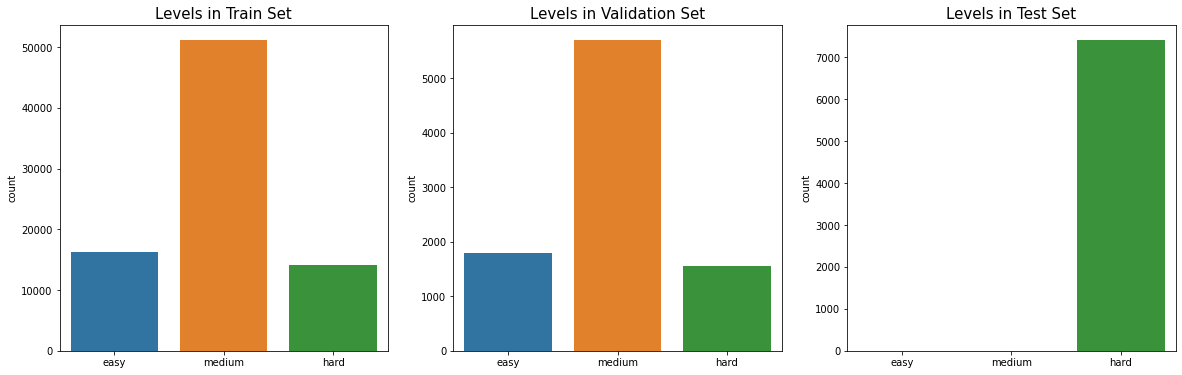

In [ ]:
fig, ax =plt.subplots(1,3, figsize = (20,6))

order = ['easy', 'medium', 'hard']

sns.countplot(x=train_levels, ax=ax[0], order=order)
sns.countplot(x=validation_levels, ax=ax[1], order=order)
sns.countplot(x=test_levels, ax=ax[2], order=order)

ax[0].set_title("Levels in Train Set", size = 15)
ax[1].set_title("Levels in Validation Set", size = 15)
ax[2].set_title("Levels in Test Set", size = 15)

plt.show()

In [ ]:
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()

# This function get the label for each query/sentence pair and saves them in a list
def get_info(samples):
  labels_list, query_len_list, fact_len_list = [], [], []
  for examples in samples:
      query = examples['question']
      contexts = examples['context']
      facts = examples['supporting_facts']

      # initializing a dict to save titles with corresponding supporting facts
      labels = {value:list() for value in contexts['title']}
      for t, title in enumerate(facts['title']):
          labels[title].append(facts['sent_id'][t])

      for t, title in enumerate(contexts['title']):
        # we only consider the gold paragraphs
        if title in facts['title']:
          for s, sentence in enumerate(contexts['sentences'][t]):
            if s in labels[title]:     
              labels_list.append(1)
            else:
              labels_list.append(0)
            query_len_list.append(len(query.split(' ')))
            fact_len_list.append(len(sentence.split(' ')))
  return labels_list, query_len_list, fact_len_list

In [ ]:
labels_list, query_list, facts_list = {}, {}, {}
for _type in ['train', 'validation', 'test']:
  labels_dist_list, query_len_list, fact_len_list = get_info(hpqa[_type])

  percentage = np.sum(np.array(labels_dist_list))/len(labels_dist_list)
  
  labels_list[_type] = {'0':1-percentage,
                        '1':percentage,}

  query_list[_type] = query_len_list
  facts_list[_type] = fact_len_list

In [ ]:
pd.DataFrame(labels_list).T.head()

0         1
train       0.630921  0.369079
validation  0.631754  0.368246
test        0.624823  0.375177

As we can see the distribution of the true labels against the whole sample (in the train/validation/test sets) is equal to around $\%63$. We will use this value to weight our preditions for fair metric computation and reaching best results.

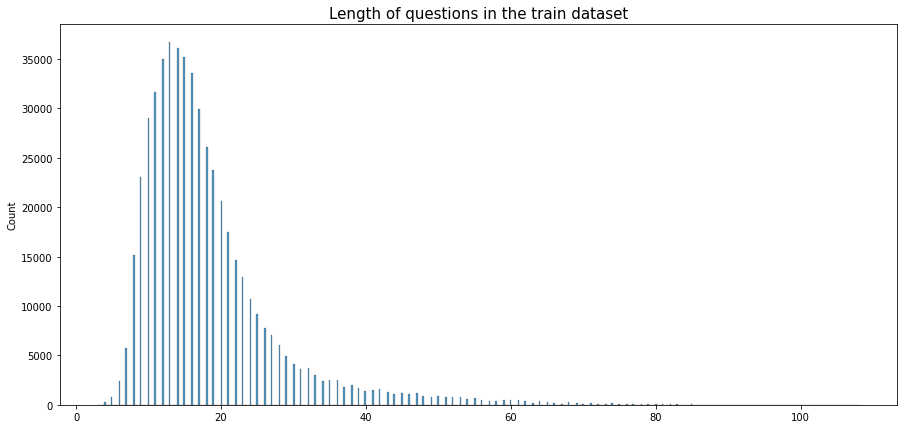

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15,7))
sns.histplot(np.array(query_list['train']))
plt.title('Length of questions in the train dataset', size = 15)
plt.show()

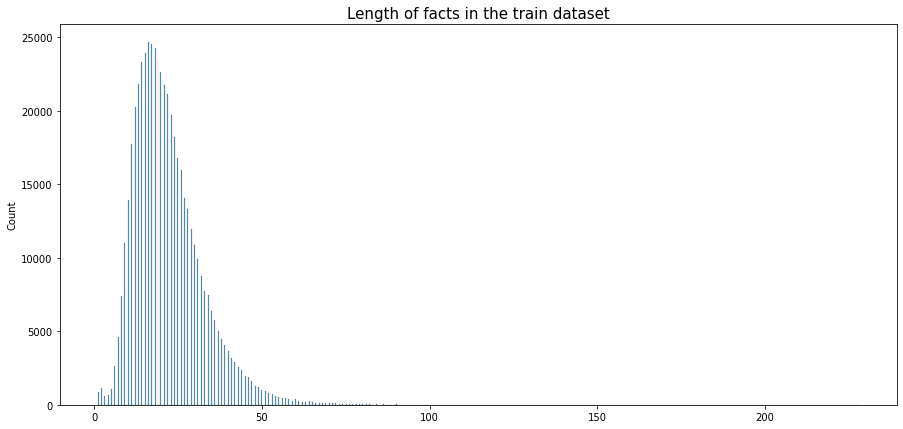

In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(np.array(facts_list['train']))
plt.title('Length of facts in the train dataset', size = 15)
plt.show()

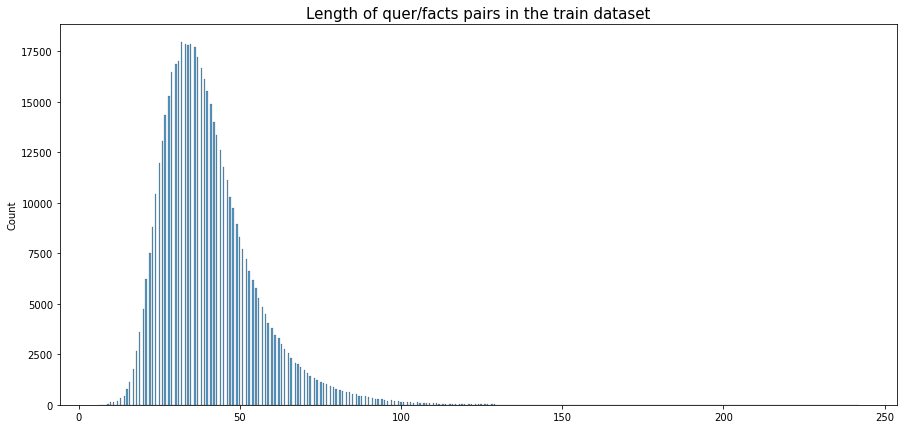

In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(np.array(query_list['train'])+np.array(facts_list['train']))
plt.title('Length of quer/facts pairs in the train dataset', size = 15)
plt.show()

Based on the upper histogram, it seem choosing 100 would be a good threshold that if we dont want to truncate sentences too much. In our work we applied 64 and 128 and since the results didn't change significantly, we set the final threshold to 64 for computational reasons.

## Preprocessing

In [ ]:
from transformers import AutoTokenizer
# model_checkpoint = "prajjwal1/bert-mini"
# model_checkpoint = 'prajjwal1/bert-small'
model_checkpoint = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def preprocess_dataset(examples):
    final = {'input_ids': [], 'attention_mask': [], 'labels': [], 'token_type_ids': []}
    
    for i in range(len(examples['id'])):
        query = examples['question'][i]
        contexts = examples['context'][i]
        facts = examples['supporting_facts'][i]

        # initializing a dict to save titles with corresponding supporting facts
        labels = {value:list() for value in contexts['title']}
        for t, title in enumerate(facts['title']):
            labels[title].append(facts['sent_id'][t])

        # Generating samples in proper format 
        for t, title in enumerate(contexts['title']):
          if title in facts['title']:
            for s, sentence in enumerate(contexts['sentences'][t]):
              # tokenizing query concatenated with sentences
              tokenized = tokenizer(query, sentence, padding="max_length", max_length=64, truncation=True)
              # Set the senetnce label to 1 if it's in facts O.W set to 0
              tokenized['labels'] = 1 if s in labels[title] else 0

              for key in tokenized.keys():
                  final[key].append(tokenized[key])
    return final

In [ ]:
import pandas as pd

samples = hpqa['validation'][sample_idx:sample_idx+1]
preprocessed_data = preprocess_dataset(samples)

df = {'sentences':[],
      'labels':[]}

for i in range(len(samples['id'])):
  for title in list(np.unique(np.array(samples['supporting_facts'][i]['title']))):
    idx = samples['context'][i]['title'].index(title)
    for j, sent in enumerate(samples['context'][i]['sentences'][idx]):
      df['sentences'].append(sent)
      df['labels'].append(preprocessed_data['labels'][j])

# 
print('Sentence labels in contexts')
pd.DataFrame(df).head(len(preprocessed_data['input_ids']))

Sentence labels in contexts


sentences  labels
0   The first season of "iCarly" aired on Nickelod...       1
1    The season introduces Carly Shay (Miranda Cos...       0
2    This is notably the only season without a 1 h...       1
3   Miranda Taylor Cosgrove (born May 14, 1993) is...       1
4    Her career began at the age of 3 with several...       0
5    Cosgrove's film debut came in 2003, when she ...       1
6    She appeared in a number of minor television ...       0
7    In 2007, she landed the role of Carly Shay, t...       0
8    As of May 2010, Cosgrove earned $180,000 per ...       0
9    Cosgrove also voiced Margo in the animated fi...       0
10   In 2016, she starred as Shea Moore on the sho...       0

In [ ]:
# We apply this transformation to the whole dataset
sent_class_dataset = hpqa.map(preprocess_dataset, batched= True, remove_columns=hpqa["train"].column_names)

  0%|          | 0/82 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
sent_class_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"],
)

In [ ]:
sent_class_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'token_type_ids'],
        num_rows: 526083
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'token_type_ids'],
        num_rows: 58374
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'token_type_ids'],
        num_rows: 47988
    })
})

Now we have around 500k samples in training set

In [ ]:
sent_class_dataset['train'][sample_idx]['input_ids']

tensor([  101, 23151,  2015,  7570,  5937,  2003,  1037,  3803,  2374,  2873,
         1998,  2280,  2447,  1996,  2499,  2007,  1105, 15750, 17112, 21174,
         5488,  1010,  2040,  3248,  2054,  2597,  1029,   102,  7570,  5937,
         2003,  4235,  5240,  2004,  2028,  1997,  2088,  2374,  1005,  1055,
        16097,  3125, 18321, 10779,  2015,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

In [ ]:
tokenizer.decode(sent_class_dataset['train'][sample_idx]['input_ids'])

"[CLS] frans hoek is a dutch football coach and former player the worked with łukasz fabianski, who plays what position? [SEP] hoek is widely regarded as one of world football's foremost goalkeeping mentors. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

## Train

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import AutoModelForSequenceClassification

# my_model_checkpoint = 'reza-madani/bert-for-sentence-identification'
# try:
#   print('Checkpoint loaded from reza-madani/bert-for-sentence-identification')
#   model = AutoModelForSequenceClassification.from_pretrained(my_model_checkpoint)
# except OSError:
#   print('No saved checkepoint found. Switched to base checkpoint')
#   model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
# except:
#   print('Model checkpoint doesn\'t exist')

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
print('Number of parameters: ', model.num_parameters())

Number of parameters:  109483778


In [ ]:
import torch
from torch import nn
from transformers import Trainer, TrainingArguments

# The following weights are chosen based on the distribution of 0/1 in train set
negative_weight,positive_weight = 0.35, 0.65

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs = False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([negative_weight,positive_weight]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 7.0 MB/s eta 0:00:00


In [ ]:
from evaluate import load

f1_metric = load("f1")
acc_metric = load('accuracy')

# metric = load("exact_match")
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis = 1)

  f1_score = f1_metric.compute(predictions=predictions, references=labels)
  accuracy = acc_metric.compute(predictions=predictions, references=labels)

  return {'F1_Score':f1_score,
          'Accuracy':accuracy}

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = 'reza-madani/bert-for-sentence-identification',
    fp16 = True,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    evaluation_strategy = 'steps',
    logging_steps = 5000,
    save_steps = 5000,
    push_to_hub = True,
    hub_strategy = 'checkpoint',
    overwrite_output_dir = True,
    resume_from_checkpoint = 'last-checkpoint',
    load_best_model_at_end = True
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = sent_class_dataset['train'],
    eval_dataset = sent_class_dataset['validation'],
    compute_metrics = compute_metrics
)
# try:
#   trainer.train(resume_from_checkpoint = 'reza-madani/bert-for-sentence-identification/last-checkpoint')
# except ValueError:
#   # This is to avoid getting error when using the trainer for the first time
#   trainer.train()

In [ ]:
# Pushing the model and the tokenizer to HUB
model.push_to_hub('nlpproject2023/bert-base-uncased')
tokenizer.push_to_hub('nlpproject2023/bert-base-uncased')

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nlpproject2023/bert-base-uncased/commit/4b5543b6cd597df74feb499c6d08d5381e7e8726', commit_message='Upload tokenizer', commit_description='', oid='4b5543b6cd597df74feb499c6d08d5381e7e8726', pr_url=None, pr_revision=None, pr_num=None)

## Evaluation:

### Preparations

Loading the trained model, tokenizer, and trainer

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Use checkpoint from trained model for this task
model_checkpoint = 'reza-madani/bert-for-sentence-identification'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
trainer = CustomTrainer(model=model)

Generating the gold files for evaluation process in desired format

In [ ]:
from tqdm import tqdm 

def prepare_gold_file(_dataset):
  gold_file = []

  for row in tqdm(_dataset):
    id = row["id"]
    answer = row["answer"]
    supporting_facts = row["supporting_facts"]
    sp = [[title, sent_id] for title, sent_id 
          in zip(supporting_facts["title"], supporting_facts["sent_id"])]

    gold_file.append({"_id": id, 
                      "answer": answer, 
                      "supporting_facts": sp})

  return gold_file

val_gold_file = prepare_gold_file(hpqa['validation'])
test_gold_file = prepare_gold_file(hpqa['test'])

100%|██████████| 7405/7405 [00:01<00:00, 6086.40it/s]


Defining the evaluation function

In [ ]:
def update_sp(metrics, prediction, gold):
    cur_sp_pred = set(map(tuple, prediction))
    gold_sp_pred = set(map(tuple, gold))
    tp, fp, fn = 0, 0, 0
    for e in cur_sp_pred:
        if e in gold_sp_pred:
            tp += 1
        else:
            fp += 1
    for e in gold_sp_pred:
        if e not in cur_sp_pred:
            fn += 1
    prec = 1.0 * tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = 1.0 * tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * prec * recall / (prec + recall) if prec + recall > 0 else 0.0
    em = 1.0 if fp + fn == 0 else 0.0
    metrics['sp_em'].append(em)
    metrics['sp_f1'].append(f1)
    metrics['sp_prec'].append(prec)
    metrics['sp_recall'].append(recall)
    return em, prec, recall


def eval(prediction, gold):

    metrics_list = {'sp_em': [], 'sp_f1': [], 'sp_prec': [], 'sp_recall': [],}
    for dp in gold:
        cur_id = dp['_id']

        sp_em, sp_prec, sp_recall = update_sp(
            metrics_list, prediction['sp'][cur_id], dp['supporting_facts'])

    N = len(gold)
    metrics_value = {'sp_em': 0, 'sp_f1': 0, 'sp_prec': 0, 'sp_recall': 0,}
    for k in metrics_list.keys():
        metrics_value[k] = np.mean(metrics_list[k])

    return metrics_value, metrics_list

### Evaluate on HPQA test and validation

In [ ]:
from tqdm import tqdm
from datasets import Dataset

import pandas as pd
from datasets import Dataset

# del output
output = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'facts']), preserve_index=False)

model.eval()
with torch.no_grad():
  model.to(device)
  # for examples in tqdm(hpqa['validation']):
  for examples in tqdm(hpqa['test']):
      final = {'input_ids': [], 
              'attention_mask': [], 
              'labels': [], 
              'token_type_ids': []}
      
      query = examples['question']
      contexts = examples['context']
      facts = examples['supporting_facts']

      if len(contexts['title'])==0:
        row['id'] = examples['id']
        row['question'] = query
        row['facts'] = []

        output = output.add_item(row)
        continue

      row = {}
      context_sentences, sp_sentences = [], []
      # Generating samples in proper format 
      for t, title in enumerate(contexts['title']):
        if title in facts['title']:
          for s, sentence in enumerate(contexts['sentences'][t]):
            context_sentences.append(sentence)
            tokenized = tokenizer(query, sentence, padding="max_length", max_length=64, truncation=True)
            tokenized['labels'] = 0

            for key in tokenized.keys():
                final[key].append(tokenized[key])

      x = Dataset.from_dict(final)
      x.set_format(type='torch', columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
      predictions, labels, _ = trainer.predict(x) 
          
      cnt = 0
      sp_idx = np.nonzero(np.argmax(predictions, axis=1))[0].tolist()
      for i in sp_idx:
        sp_sentences.append(context_sentences[i])

      row['id'] = examples['id']
      row['question'] = query
      row['facts'] = sp_sentences

      output = output.add_item(row)

  0%|          | 0/9045 [00:00<?, ?it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  0%|          | 1/9045 [00:00<16:14,  9.28it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  0%|          | 3/9045 [00:00<10:47, 13.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  0%|          | 5/9045 [00:00<11:33, 13.04it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  0%|          | 7/9045 [00:00<10:36, 14.20it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  0%|          | 9/9045 [00:00<10:16, 14.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  0%|          | 11/9045 [00:00<09:39, 15.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  0%|          | 13/9045 [00:00<09:10, 16.40it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  0%|          | 15/9045 [00:01<09:47, 15.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  0%|          | 18/9045 [00:01<09:23, 16.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  0%|          | 20/9045 [00:01<09:02, 16.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  0%|          | 22/9045 [00:01<10:49, 13.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  0%|          | 24/9045 [00:01<11:43, 12.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  0%|          | 26/9045 [00:01<12:49, 11.73it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  0%|          | 28/9045 [00:02<12:53, 11.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  0%|          | 30/9045 [00:02<12:30, 12.02it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  0%|          | 32/9045 [00:02<13:46, 10.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  0%|          | 34/9045 [00:02<13:20, 11.26it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  0%|          | 36/9045 [00:02<13:10, 11.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  0%|          | 38/9045 [00:02<12:51, 11.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  0%|          | 40/9045 [00:03<13:03, 11.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  0%|          | 42/9045 [00:03<12:53, 11.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  0%|          | 44/9045 [00:03<14:23, 10.43it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|          | 46/9045 [00:03<15:34,  9.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  1%|          | 48/9045 [00:04<16:17,  9.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  1%|          | 49/9045 [00:04<16:14,  9.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|          | 51/9045 [00:04<15:46,  9.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|          | 52/9045 [00:04<15:40,  9.57it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  1%|          | 53/9045 [00:04<17:11,  8.72it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  1%|          | 54/9045 [00:04<18:33,  8.07it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  1%|          | 56/9045 [00:04<16:31,  9.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  1%|          | 58/9045 [00:05<16:34,  9.04it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  1%|          | 60/9045 [00:05<16:12,  9.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  1%|          | 62/9045 [00:05<15:21,  9.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  1%|          | 63/9045 [00:05<15:23,  9.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  1%|          | 65/9045 [00:05<14:06, 10.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  1%|          | 67/9045 [00:05<14:01, 10.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  1%|          | 69/9045 [00:06<13:43, 10.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  1%|          | 71/9045 [00:06<13:26, 11.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  1%|          | 73/9045 [00:06<13:06, 11.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|          | 75/9045 [00:06<12:57, 11.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  1%|          | 77/9045 [00:06<12:09, 12.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  1%|          | 79/9045 [00:06<11:46, 12.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|          | 81/9045 [00:07<11:35, 12.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  1%|          | 83/9045 [00:07<11:12, 13.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|          | 85/9045 [00:07<11:18, 13.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  1%|          | 87/9045 [00:07<10:50, 13.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  1%|          | 89/9045 [00:07<10:47, 13.84it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  1%|          | 91/9045 [00:07<12:14, 12.19it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  1%|          | 93/9045 [00:08<12:27, 11.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  1%|          | 95/9045 [00:08<11:33, 12.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  1%|          | 97/9045 [00:08<11:02, 13.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|          | 99/9045 [00:08<10:51, 13.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  1%|          | 101/9045 [00:08<11:57, 12.46it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  1%|          | 103/9045 [00:08<12:41, 11.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|          | 105/9045 [00:08<12:17, 12.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  1%|          | 107/9045 [00:09<11:49, 12.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|          | 109/9045 [00:09<11:01, 13.52it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  1%|          | 111/9045 [00:09<10:56, 13.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  1%|▏         | 114/9045 [00:09<09:22, 15.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  1%|▏         | 117/9045 [00:09<08:32, 17.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  1%|▏         | 120/9045 [00:09<08:30, 17.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|▏         | 122/9045 [00:09<08:21, 17.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  1%|▏         | 124/9045 [00:10<08:09, 18.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  1%|▏         | 127/9045 [00:10<07:45, 19.17it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  1%|▏         | 130/9045 [00:10<07:08, 20.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


  1%|▏         | 133/9045 [00:10<07:02, 21.10it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  2%|▏         | 136/9045 [00:10<06:46, 21.89it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


  2%|▏         | 139/9045 [00:10<07:09, 20.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  2%|▏         | 142/9045 [00:10<07:21, 20.18it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


  2%|▏         | 145/9045 [00:11<07:42, 19.26it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


  2%|▏         | 147/9045 [00:11<07:50, 18.90it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  2%|▏         | 149/9045 [00:11<08:05, 18.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  2%|▏         | 151/9045 [00:11<08:05, 18.33it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  2%|▏         | 153/9045 [00:11<08:47, 16.84it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  2%|▏         | 156/9045 [00:11<08:04, 18.36it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  2%|▏         | 158/9045 [00:11<08:25, 17.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  2%|▏         | 160/9045 [00:11<08:17, 17.87it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  2%|▏         | 162/9045 [00:12<08:47, 16.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  2%|▏         | 165/9045 [00:12<08:11, 18.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  2%|▏         | 168/9045 [00:12<07:47, 18.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  2%|▏         | 171/9045 [00:12<07:23, 20.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  2%|▏         | 174/9045 [00:12<07:05, 20.84it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  2%|▏         | 177/9045 [00:12<07:46, 19.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  2%|▏         | 180/9045 [00:12<07:26, 19.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  2%|▏         | 183/9045 [00:13<07:22, 20.03it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  2%|▏         | 186/9045 [00:13<07:13, 20.46it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  2%|▏         | 189/9045 [00:13<07:42, 19.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  2%|▏         | 192/9045 [00:13<07:26, 19.82it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  2%|▏         | 195/9045 [00:13<07:31, 19.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  2%|▏         | 198/9045 [00:13<07:18, 20.19it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  2%|▏         | 201/9045 [00:13<07:25, 19.87it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  2%|▏         | 204/9045 [00:14<07:46, 18.97it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  2%|▏         | 207/9045 [00:14<07:28, 19.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  2%|▏         | 209/9045 [00:14<07:49, 18.80it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  2%|▏         | 211/9045 [00:14<08:07, 18.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  2%|▏         | 214/9045 [00:14<07:36, 19.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  2%|▏         | 217/9045 [00:14<07:29, 19.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  2%|▏         | 219/9045 [00:14<07:52, 18.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  2%|▏         | 222/9045 [00:15<07:22, 19.94it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  2%|▏         | 224/9045 [00:15<07:23, 19.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  3%|▎         | 227/9045 [00:15<07:10, 20.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 15
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  3%|▎         | 230/9045 [00:15<07:46, 18.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  3%|▎         | 232/9045 [00:15<07:54, 18.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  3%|▎         | 235/9045 [00:15<07:29, 19.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  3%|▎         | 238/9045 [00:15<07:21, 19.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  3%|▎         | 241/9045 [00:16<07:39, 19.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  3%|▎         | 243/9045 [00:16<07:40, 19.13it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  3%|▎         | 245/9045 [00:16<08:05, 18.12it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  3%|▎         | 248/9045 [00:16<07:36, 19.25it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  3%|▎         | 250/9045 [00:16<07:59, 18.34it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  3%|▎         | 252/9045 [00:16<08:30, 17.24it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  3%|▎         | 254/9045 [00:16<09:20, 15.69it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  3%|▎         | 257/9045 [00:17<08:39, 16.92it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  3%|▎         | 259/9045 [00:17<08:38, 16.96it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  3%|▎         | 261/9045 [00:17<09:06, 16.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  3%|▎         | 263/9045 [00:17<08:53, 16.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  3%|▎         | 265/9045 [00:17<08:37, 16.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  3%|▎         | 267/9045 [00:17<09:07, 16.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  3%|▎         | 269/9045 [00:17<09:14, 15.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  3%|▎         | 271/9045 [00:17<09:35, 15.24it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  3%|▎         | 273/9045 [00:18<10:21, 14.12it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  3%|▎         | 276/9045 [00:18<09:18, 15.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  3%|▎         | 278/9045 [00:18<08:46, 16.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  3%|▎         | 280/9045 [00:18<08:31, 17.15it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  3%|▎         | 282/9045 [00:18<08:31, 17.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  3%|▎         | 285/9045 [00:18<07:48, 18.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  3%|▎         | 287/9045 [00:18<07:43, 18.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  3%|▎         | 289/9045 [00:18<08:20, 17.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  3%|▎         | 292/9045 [00:19<07:46, 18.77it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


  3%|▎         | 295/9045 [00:19<07:24, 19.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  3%|▎         | 297/9045 [00:19<07:45, 18.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  3%|▎         | 300/9045 [00:19<07:54, 18.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  3%|▎         | 303/9045 [00:19<07:29, 19.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  3%|▎         | 306/9045 [00:19<07:13, 20.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  3%|▎         | 309/9045 [00:19<07:38, 19.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  3%|▎         | 311/9045 [00:20<08:00, 18.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  3%|▎         | 313/9045 [00:20<07:50, 18.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  3%|▎         | 315/9045 [00:20<08:29, 17.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  4%|▎         | 317/9045 [00:20<09:04, 16.02it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  4%|▎         | 319/9045 [00:20<09:43, 14.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▎         | 321/9045 [00:20<09:27, 15.37it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  4%|▎         | 323/9045 [00:20<09:54, 14.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  4%|▎         | 325/9045 [00:20<09:08, 15.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  4%|▎         | 327/9045 [00:21<08:57, 16.21it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  4%|▎         | 329/9045 [00:21<08:41, 16.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


  4%|▎         | 331/9045 [00:21<08:28, 17.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  4%|▎         | 333/9045 [00:21<08:41, 16.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  4%|▎         | 335/9045 [00:21<08:41, 16.70it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  4%|▎         | 337/9045 [00:21<08:52, 16.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▎         | 339/9045 [00:21<09:12, 15.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▍         | 341/9045 [00:21<09:03, 16.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  4%|▍         | 343/9045 [00:22<08:55, 16.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  4%|▍         | 345/9045 [00:22<09:03, 16.02it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  4%|▍         | 347/9045 [00:22<09:11, 15.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  4%|▍         | 349/9045 [00:22<09:22, 15.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  4%|▍         | 351/9045 [00:22<10:02, 14.42it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▍         | 353/9045 [00:22<09:41, 14.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  4%|▍         | 355/9045 [00:22<09:47, 14.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▍         | 357/9045 [00:23<10:05, 14.36it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▍         | 359/9045 [00:23<09:47, 14.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▍         | 361/9045 [00:23<09:42, 14.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  4%|▍         | 363/9045 [00:23<09:28, 15.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  4%|▍         | 365/9045 [00:23<09:12, 15.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  4%|▍         | 367/9045 [00:23<09:08, 15.82it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  4%|▍         | 369/9045 [00:23<09:54, 14.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▍         | 371/9045 [00:23<09:47, 14.77it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  4%|▍         | 373/9045 [00:24<10:04, 14.35it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  4%|▍         | 375/9045 [00:24<10:40, 13.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  4%|▍         | 377/9045 [00:24<10:01, 14.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  4%|▍         | 379/9045 [00:24<10:09, 14.21it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  4%|▍         | 381/9045 [00:24<09:28, 15.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  4%|▍         | 383/9045 [00:24<08:58, 16.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  4%|▍         | 385/9045 [00:24<09:12, 15.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  4%|▍         | 387/9045 [00:25<08:49, 16.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▍         | 389/9045 [00:25<08:48, 16.37it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  4%|▍         | 392/9045 [00:25<08:42, 16.55it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  4%|▍         | 395/9045 [00:25<08:11, 17.59it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  4%|▍         | 397/9045 [00:25<08:31, 16.92it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  4%|▍         | 399/9045 [00:25<08:17, 17.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  4%|▍         | 401/9045 [00:25<08:11, 17.58it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  4%|▍         | 404/9045 [00:25<07:46, 18.54it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  4%|▍         | 406/9045 [00:26<07:44, 18.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  5%|▍         | 408/9045 [00:26<07:42, 18.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  5%|▍         | 410/9045 [00:26<07:42, 18.69it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  5%|▍         | 412/9045 [00:26<08:17, 17.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  5%|▍         | 414/9045 [00:26<13:59, 10.28it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  5%|▍         | 416/9045 [00:26<12:28, 11.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  5%|▍         | 419/9045 [00:27<10:19, 13.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  5%|▍         | 422/9045 [00:27<09:10, 15.65it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  5%|▍         | 424/9045 [00:27<08:41, 16.53it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  5%|▍         | 426/9045 [00:27<08:36, 16.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  5%|▍         | 428/9045 [00:27<08:16, 17.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  5%|▍         | 430/9045 [00:27<08:01, 17.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  5%|▍         | 432/9045 [00:27<08:20, 17.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  5%|▍         | 435/9045 [00:27<07:45, 18.51it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  5%|▍         | 438/9045 [00:28<07:26, 19.26it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  5%|▍         | 441/9045 [00:28<07:40, 18.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  5%|▍         | 443/9045 [00:28<07:33, 18.95it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  5%|▍         | 446/9045 [00:28<07:14, 19.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  5%|▍         | 448/9045 [00:28<07:19, 19.56it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  5%|▍         | 451/9045 [00:28<07:06, 20.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  5%|▌         | 454/9045 [00:28<07:50, 18.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  5%|▌         | 456/9045 [00:29<07:55, 18.05it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  5%|▌         | 458/9045 [00:29<07:48, 18.34it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  5%|▌         | 460/9045 [00:29<08:11, 17.46it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  5%|▌         | 462/9045 [00:29<08:33, 16.70it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  5%|▌         | 464/9045 [00:29<09:30, 15.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  5%|▌         | 466/9045 [00:29<09:22, 15.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  5%|▌         | 469/9045 [00:29<08:17, 17.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  5%|▌         | 472/9045 [00:29<07:48, 18.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  5%|▌         | 475/9045 [00:30<07:53, 18.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  5%|▌         | 477/9045 [00:30<07:44, 18.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  5%|▌         | 479/9045 [00:30<07:43, 18.50it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  5%|▌         | 482/9045 [00:30<07:21, 19.42it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  5%|▌         | 484/9045 [00:30<07:54, 18.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


  5%|▌         | 486/9045 [00:30<08:08, 17.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  5%|▌         | 489/9045 [00:30<07:42, 18.48it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  5%|▌         | 491/9045 [00:31<08:36, 16.55it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  5%|▌         | 493/9045 [00:31<08:40, 16.43it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  5%|▌         | 496/9045 [00:31<08:28, 16.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


  6%|▌         | 499/9045 [00:31<08:25, 16.89it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  6%|▌         | 501/9045 [00:31<09:09, 15.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  6%|▌         | 503/9045 [00:31<08:50, 16.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  6%|▌         | 505/9045 [00:31<08:33, 16.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  6%|▌         | 507/9045 [00:32<08:24, 16.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  6%|▌         | 510/9045 [00:32<07:53, 18.03it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  6%|▌         | 512/9045 [00:32<08:23, 16.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  6%|▌         | 515/9045 [00:32<07:51, 18.10it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  6%|▌         | 517/9045 [00:32<07:49, 18.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  6%|▌         | 520/9045 [00:32<07:36, 18.68it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  6%|▌         | 523/9045 [00:32<07:22, 19.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  6%|▌         | 526/9045 [00:32<07:05, 20.04it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  6%|▌         | 528/9045 [00:33<07:30, 18.89it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  6%|▌         | 531/9045 [00:33<07:17, 19.45it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  6%|▌         | 533/9045 [00:33<07:16, 19.48it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  6%|▌         | 535/9045 [00:33<07:48, 18.18it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  6%|▌         | 537/9045 [00:33<08:09, 17.37it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  6%|▌         | 539/9045 [00:33<08:28, 16.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  6%|▌         | 541/9045 [00:33<08:11, 17.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  6%|▌         | 543/9045 [00:33<08:35, 16.50it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  6%|▌         | 545/9045 [00:34<08:13, 17.22it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  6%|▌         | 547/9045 [00:34<09:36, 14.75it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  6%|▌         | 549/9045 [00:34<09:24, 15.04it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  6%|▌         | 551/9045 [00:34<08:55, 15.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  6%|▌         | 553/9045 [00:34<09:16, 15.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  6%|▌         | 555/9045 [00:34<09:00, 15.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  6%|▌         | 557/9045 [00:34<08:56, 15.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  6%|▌         | 559/9045 [00:35<09:20, 15.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  6%|▌         | 561/9045 [00:35<08:48, 16.06it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  6%|▌         | 563/9045 [00:35<09:01, 15.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  6%|▋         | 566/9045 [00:35<08:08, 17.37it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  6%|▋         | 568/9045 [00:35<08:39, 16.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  6%|▋         | 571/9045 [00:35<07:59, 17.67it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  6%|▋         | 573/9045 [00:35<08:28, 16.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


  6%|▋         | 576/9045 [00:36<08:48, 16.02it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  6%|▋         | 578/9045 [00:36<13:27, 10.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  6%|▋         | 580/9045 [00:36<11:59, 11.76it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  6%|▋         | 582/9045 [00:36<11:29, 12.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  6%|▋         | 584/9045 [00:36<10:25, 13.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  6%|▋         | 586/9045 [00:36<09:43, 14.51it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  7%|▋         | 588/9045 [00:37<09:43, 14.49it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 590/9045 [00:37<09:08, 15.40it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 592/9045 [00:37<09:22, 15.04it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  7%|▋         | 595/9045 [00:37<08:21, 16.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 598/9045 [00:37<07:57, 17.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  7%|▋         | 601/9045 [00:37<07:40, 18.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  7%|▋         | 603/9045 [00:37<07:35, 18.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  7%|▋         | 605/9045 [00:38<08:21, 16.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  7%|▋         | 607/9045 [00:38<08:47, 16.00it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  7%|▋         | 609/9045 [00:38<08:51, 15.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 611/9045 [00:38<08:40, 16.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  7%|▋         | 613/9045 [00:38<08:19, 16.89it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  7%|▋         | 615/9045 [00:38<08:21, 16.80it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


  7%|▋         | 617/9045 [00:38<09:11, 15.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  7%|▋         | 619/9045 [00:38<10:13, 13.73it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  7%|▋         | 621/9045 [00:39<09:49, 14.29it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  7%|▋         | 623/9045 [00:39<10:19, 13.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  7%|▋         | 625/9045 [00:39<10:03, 13.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  7%|▋         | 627/9045 [00:39<09:49, 14.27it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  7%|▋         | 629/9045 [00:39<10:05, 13.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  7%|▋         | 631/9045 [00:39<09:26, 14.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  7%|▋         | 633/9045 [00:39<10:02, 13.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  7%|▋         | 635/9045 [00:40<09:36, 14.59it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  7%|▋         | 637/9045 [00:40<09:42, 14.44it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  7%|▋         | 639/9045 [00:40<09:35, 14.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  7%|▋         | 641/9045 [00:40<08:58, 15.62it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  7%|▋         | 643/9045 [00:40<08:40, 16.16it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  7%|▋         | 645/9045 [00:40<08:23, 16.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  7%|▋         | 647/9045 [00:40<08:33, 16.37it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 649/9045 [00:40<09:01, 15.50it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 651/9045 [00:41<09:07, 15.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  7%|▋         | 653/9045 [00:41<09:57, 14.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


  7%|▋         | 655/9045 [00:41<09:48, 14.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  7%|▋         | 657/9045 [00:41<09:24, 14.86it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  7%|▋         | 659/9045 [00:41<08:45, 15.94it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  7%|▋         | 661/9045 [00:41<09:21, 14.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  7%|▋         | 663/9045 [00:41<09:36, 14.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  7%|▋         | 665/9045 [00:42<09:17, 15.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  7%|▋         | 667/9045 [00:42<09:17, 15.02it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 669/9045 [00:42<09:03, 15.41it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 671/9045 [00:42<09:15, 15.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  7%|▋         | 673/9045 [00:42<08:44, 15.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 675/9045 [00:42<08:29, 16.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  7%|▋         | 677/9045 [00:42<08:20, 16.71it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  8%|▊         | 679/9045 [00:42<08:28, 16.47it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  8%|▊         | 681/9045 [00:43<08:35, 16.23it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  8%|▊         | 684/9045 [00:43<08:01, 17.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  8%|▊         | 686/9045 [00:43<08:01, 17.37it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  8%|▊         | 688/9045 [00:43<08:25, 16.52it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  8%|▊         | 690/9045 [00:43<13:59,  9.96it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  8%|▊         | 692/9045 [00:43<12:32, 11.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  8%|▊         | 694/9045 [00:44<11:10, 12.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  8%|▊         | 696/9045 [00:44<10:06, 13.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  8%|▊         | 698/9045 [00:44<09:36, 14.48it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  8%|▊         | 700/9045 [00:44<08:52, 15.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  8%|▊         | 702/9045 [00:44<08:23, 16.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  8%|▊         | 704/9045 [00:44<08:10, 17.01it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


  8%|▊         | 706/9045 [00:44<08:38, 16.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  8%|▊         | 708/9045 [00:44<08:18, 16.73it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  8%|▊         | 710/9045 [00:44<07:55, 17.53it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  8%|▊         | 712/9045 [00:45<08:29, 16.36it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  8%|▊         | 714/9045 [00:45<08:29, 16.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  8%|▊         | 716/9045 [00:45<08:11, 16.93it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  8%|▊         | 718/9045 [00:45<09:03, 15.32it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  8%|▊         | 720/9045 [00:45<09:07, 15.21it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  8%|▊         | 722/9045 [00:45<08:44, 15.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  8%|▊         | 724/9045 [00:45<08:21, 16.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  8%|▊         | 726/9045 [00:45<08:09, 16.99it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  8%|▊         | 728/9045 [00:46<08:35, 16.15it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  8%|▊         | 730/9045 [00:46<08:39, 15.99it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  8%|▊         | 732/9045 [00:46<08:16, 16.76it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  8%|▊         | 734/9045 [00:46<09:12, 15.05it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  8%|▊         | 736/9045 [00:46<09:48, 14.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


  8%|▊         | 738/9045 [00:46<09:41, 14.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  8%|▊         | 740/9045 [00:46<09:06, 15.20it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  8%|▊         | 742/9045 [00:47<09:39, 14.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  8%|▊         | 744/9045 [00:47<08:51, 15.61it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  8%|▊         | 746/9045 [00:47<09:06, 15.19it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 14
  Batch size = 8


  8%|▊         | 748/9045 [00:47<09:52, 14.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  8%|▊         | 750/9045 [00:47<09:44, 14.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  8%|▊         | 752/9045 [00:47<08:59, 15.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  8%|▊         | 754/9045 [00:47<08:23, 16.48it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  8%|▊         | 756/9045 [00:47<08:32, 16.18it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  8%|▊         | 758/9045 [00:48<08:45, 15.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  8%|▊         | 760/9045 [00:48<08:22, 16.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  8%|▊         | 762/9045 [00:48<13:47, 10.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  8%|▊         | 764/9045 [00:48<12:04, 11.43it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  8%|▊         | 766/9045 [00:48<11:11, 12.33it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  8%|▊         | 768/9045 [00:48<10:08, 13.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  9%|▊         | 770/9045 [00:49<09:14, 14.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  9%|▊         | 772/9045 [00:49<08:35, 16.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▊         | 774/9045 [00:49<08:17, 16.63it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  9%|▊         | 777/9045 [00:49<08:13, 16.76it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▊         | 779/9045 [00:49<08:16, 16.64it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  9%|▊         | 781/9045 [00:49<08:33, 16.08it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  9%|▊         | 783/9045 [00:49<08:20, 16.52it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  9%|▊         | 785/9045 [00:49<08:41, 15.85it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▊         | 787/9045 [00:50<08:31, 16.13it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▊         | 789/9045 [00:50<09:23, 14.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  9%|▊         | 791/9045 [00:50<08:40, 15.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▉         | 793/9045 [00:50<08:21, 16.45it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  9%|▉         | 795/9045 [00:50<08:53, 15.47it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  9%|▉         | 797/9045 [00:50<09:12, 14.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  9%|▉         | 799/9045 [00:50<08:40, 15.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  9%|▉         | 801/9045 [00:50<08:36, 15.95it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▉         | 803/9045 [00:51<08:55, 15.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  9%|▉         | 805/9045 [00:51<08:39, 15.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


  9%|▉         | 807/9045 [00:51<09:27, 14.53it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


  9%|▉         | 809/9045 [00:51<09:54, 13.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  9%|▉         | 811/9045 [00:51<09:52, 13.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▉         | 813/9045 [00:51<09:14, 14.84it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  9%|▉         | 815/9045 [00:51<09:29, 14.44it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  9%|▉         | 817/9045 [00:52<10:11, 13.45it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  9%|▉         | 819/9045 [00:52<11:17, 12.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  9%|▉         | 821/9045 [00:52<10:54, 12.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▉         | 823/9045 [00:52<09:45, 14.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  9%|▉         | 825/9045 [00:52<09:21, 14.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  9%|▉         | 827/9045 [00:52<09:26, 14.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  9%|▉         | 829/9045 [00:53<16:50,  8.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  9%|▉         | 831/9045 [00:53<15:02,  9.10it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


  9%|▉         | 833/9045 [00:53<13:07, 10.42it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  9%|▉         | 835/9045 [00:53<12:28, 10.97it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▉         | 837/9045 [00:53<11:04, 12.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  9%|▉         | 839/9045 [00:54<10:39, 12.84it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▉         | 841/9045 [00:54<10:46, 12.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  9%|▉         | 843/9045 [00:54<10:15, 13.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  9%|▉         | 845/9045 [00:54<10:05, 13.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  9%|▉         | 847/9045 [00:54<10:41, 12.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


  9%|▉         | 849/9045 [00:54<10:24, 13.13it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


  9%|▉         | 851/9045 [00:54<10:11, 13.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


  9%|▉         | 853/9045 [00:55<10:03, 13.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


  9%|▉         | 855/9045 [00:55<10:04, 13.56it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


  9%|▉         | 857/9045 [00:55<09:31, 14.32it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


  9%|▉         | 859/9045 [00:55<09:03, 15.05it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 10%|▉         | 861/9045 [00:55<09:58, 13.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 10%|▉         | 863/9045 [00:55<10:00, 13.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 10%|▉         | 865/9045 [00:55<09:38, 14.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 10%|▉         | 867/9045 [00:56<09:56, 13.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|▉         | 869/9045 [00:56<09:58, 13.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 10%|▉         | 871/9045 [00:56<10:05, 13.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 10%|▉         | 873/9045 [00:56<10:36, 12.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|▉         | 875/9045 [00:56<11:12, 12.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|▉         | 877/9045 [00:56<11:13, 12.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 10%|▉         | 879/9045 [00:57<11:14, 12.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|▉         | 881/9045 [00:57<11:22, 11.96it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 10%|▉         | 883/9045 [00:57<11:04, 12.29it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 10%|▉         | 885/9045 [00:57<11:47, 11.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 10%|▉         | 887/9045 [00:57<11:12, 12.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 10%|▉         | 889/9045 [00:57<11:44, 11.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 10%|▉         | 891/9045 [00:58<11:06, 12.23it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 10%|▉         | 893/9045 [00:58<16:33,  8.21it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|▉         | 895/9045 [00:58<14:33,  9.33it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 10%|▉         | 897/9045 [00:58<14:02,  9.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 10%|▉         | 899/9045 [00:59<13:17, 10.22it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|▉         | 901/9045 [00:59<12:28, 10.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 10%|▉         | 903/9045 [00:59<11:23, 11.91it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|█         | 905/9045 [00:59<10:29, 12.93it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 10%|█         | 907/9045 [00:59<10:27, 12.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 10%|█         | 909/9045 [00:59<09:54, 13.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 10%|█         | 911/9045 [00:59<09:34, 14.17it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 10%|█         | 913/9045 [00:59<09:16, 14.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 10%|█         | 915/9045 [01:00<09:17, 14.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 10%|█         | 917/9045 [01:00<09:05, 14.90it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 10%|█         | 919/9045 [01:00<10:25, 13.00it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|█         | 921/9045 [01:00<09:43, 13.92it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 10%|█         | 923/9045 [01:00<09:22, 14.43it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 10%|█         | 925/9045 [01:00<08:57, 15.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 10%|█         | 927/9045 [01:00<08:51, 15.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 10%|█         | 929/9045 [01:01<08:56, 15.12it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|█         | 931/9045 [01:01<09:28, 14.28it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 10%|█         | 933/9045 [01:01<09:53, 13.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 10%|█         | 935/9045 [01:01<09:27, 14.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 10%|█         | 937/9045 [01:01<09:24, 14.38it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 10%|█         | 939/9045 [01:01<08:56, 15.10it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 10%|█         | 941/9045 [01:01<09:23, 14.39it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 10%|█         | 943/9045 [01:02<09:13, 14.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 10%|█         | 945/9045 [01:02<09:34, 14.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 10%|█         | 947/9045 [01:02<09:18, 14.50it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 10%|█         | 949/9045 [01:02<09:26, 14.29it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█         | 951/9045 [01:02<09:01, 14.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 11%|█         | 953/9045 [01:02<14:09,  9.53it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 11%|█         | 955/9045 [01:03<13:13, 10.19it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 11%|█         | 957/9045 [01:03<12:35, 10.71it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 11%|█         | 959/9045 [01:03<12:15, 10.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 11%|█         | 961/9045 [01:03<11:34, 11.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 11%|█         | 963/9045 [01:03<11:34, 11.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 11%|█         | 965/9045 [01:03<10:23, 12.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 11%|█         | 967/9045 [01:04<11:04, 12.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 11%|█         | 969/9045 [01:04<10:14, 13.15it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 11%|█         | 971/9045 [01:04<11:14, 11.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 11%|█         | 973/9045 [01:04<10:55, 12.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 11%|█         | 975/9045 [01:04<10:29, 12.82it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 11%|█         | 977/9045 [01:04<10:26, 12.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 11%|█         | 979/9045 [01:04<09:59, 13.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█         | 981/9045 [01:05<09:23, 14.30it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█         | 983/9045 [01:05<09:01, 14.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 11%|█         | 985/9045 [01:05<08:46, 15.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 11%|█         | 987/9045 [01:05<08:53, 15.11it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█         | 989/9045 [01:05<08:25, 15.92it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 11%|█         | 991/9045 [01:05<09:08, 14.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 11%|█         | 993/9045 [01:05<08:51, 15.15it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 11%|█         | 995/9045 [01:06<09:45, 13.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█         | 997/9045 [01:06<09:12, 14.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 11%|█         | 999/9045 [01:06<08:53, 15.07it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█         | 1001/9045 [01:06<08:17, 16.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 11%|█         | 1003/9045 [01:06<13:23, 10.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 11%|█         | 1005/9045 [01:06<11:33, 11.59it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 11%|█         | 1008/9045 [01:07<10:15, 13.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█         | 1010/9045 [01:07<09:33, 14.00it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 11%|█         | 1012/9045 [01:07<10:04, 13.30it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 11%|█         | 1014/9045 [01:07<10:21, 12.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 11%|█         | 1016/9045 [01:07<10:19, 12.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 11%|█▏        | 1018/9045 [01:07<09:53, 13.53it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 11%|█▏        | 1020/9045 [01:07<10:03, 13.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 11%|█▏        | 1022/9045 [01:08<10:37, 12.59it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█▏        | 1024/9045 [01:08<10:18, 12.97it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 11%|█▏        | 1026/9045 [01:08<09:49, 13.60it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 11%|█▏        | 1028/9045 [01:08<10:08, 13.17it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 11%|█▏        | 1030/9045 [01:08<09:40, 13.82it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█▏        | 1032/9045 [01:08<09:50, 13.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 11%|█▏        | 1034/9045 [01:08<09:07, 14.63it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 11%|█▏        | 1036/9045 [01:09<09:00, 14.82it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 11%|█▏        | 1038/9045 [01:09<08:22, 15.94it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 11%|█▏        | 1040/9045 [01:09<08:16, 16.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 12%|█▏        | 1042/9045 [01:09<08:13, 16.23it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1044/9045 [01:09<08:01, 16.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 12%|█▏        | 1046/9045 [01:09<08:38, 15.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 12%|█▏        | 1048/9045 [01:09<08:43, 15.28it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 12%|█▏        | 1050/9045 [01:10<14:35,  9.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 12%|█▏        | 1052/9045 [01:10<12:53, 10.33it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 12%|█▏        | 1054/9045 [01:10<12:11, 10.92it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 12%|█▏        | 1056/9045 [01:10<11:58, 11.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 12%|█▏        | 1058/9045 [01:10<10:37, 12.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 12%|█▏        | 1060/9045 [01:10<09:40, 13.76it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 12%|█▏        | 1062/9045 [01:11<09:35, 13.86it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 12%|█▏        | 1064/9045 [01:11<09:37, 13.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 12%|█▏        | 1066/9045 [01:11<08:49, 15.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 12%|█▏        | 1068/9045 [01:11<08:21, 15.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1070/9045 [01:11<08:42, 15.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1072/9045 [01:11<08:28, 15.69it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 12%|█▏        | 1074/9045 [01:11<08:49, 15.05it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 12%|█▏        | 1076/9045 [01:12<09:00, 14.76it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1078/9045 [01:12<09:09, 14.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 12%|█▏        | 1080/9045 [01:12<10:04, 13.17it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1082/9045 [01:12<09:35, 13.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 12%|█▏        | 1084/9045 [01:12<10:24, 12.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 12%|█▏        | 1086/9045 [01:12<10:14, 12.95it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 12%|█▏        | 1088/9045 [01:13<11:25, 11.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 12%|█▏        | 1090/9045 [01:13<11:35, 11.44it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 12%|█▏        | 1092/9045 [01:13<11:29, 11.53it/s]***** Running Prediction *****
  Num examples = 17
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 12%|█▏        | 1094/9045 [01:13<18:42,  7.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1096/9045 [01:14<16:03,  8.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 12%|█▏        | 1098/9045 [01:14<15:01,  8.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 12%|█▏        | 1100/9045 [01:14<13:15,  9.99it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1102/9045 [01:14<12:52, 10.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1104/9045 [01:14<12:26, 10.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 12%|█▏        | 1106/9045 [01:14<11:47, 11.21it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 12%|█▏        | 1108/9045 [01:15<11:59, 11.04it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 12%|█▏        | 1110/9045 [01:15<11:26, 11.56it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 12%|█▏        | 1112/9045 [01:15<11:04, 11.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 12%|█▏        | 1114/9045 [01:15<10:02, 13.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 12%|█▏        | 1116/9045 [01:15<09:37, 13.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1118/9045 [01:15<09:36, 13.76it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 12%|█▏        | 1120/9045 [01:15<10:39, 12.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 12%|█▏        | 1122/9045 [01:16<10:02, 13.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 12%|█▏        | 1124/9045 [01:16<09:50, 13.41it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 12%|█▏        | 1126/9045 [01:16<09:14, 14.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 12%|█▏        | 1128/9045 [01:16<08:52, 14.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 12%|█▏        | 1130/9045 [01:16<08:41, 15.18it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 13%|█▎        | 1132/9045 [01:16<09:15, 14.24it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 13%|█▎        | 1134/9045 [01:16<09:13, 14.30it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 13%|█▎        | 1136/9045 [01:17<14:55,  8.83it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 13%|█▎        | 1138/9045 [01:17<13:48,  9.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 13%|█▎        | 1140/9045 [01:17<12:42, 10.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 13%|█▎        | 1142/9045 [01:17<11:47, 11.18it/s]***** Running Prediction *****
  Num examples = 19
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 13%|█▎        | 1144/9045 [01:18<12:20, 10.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 13%|█▎        | 1146/9045 [01:18<11:00, 11.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 13%|█▎        | 1148/9045 [01:18<10:12, 12.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1150/9045 [01:18<09:26, 13.94it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1152/9045 [01:18<08:49, 14.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 13%|█▎        | 1154/9045 [01:18<08:35, 15.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 13%|█▎        | 1156/9045 [01:18<08:49, 14.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1158/9045 [01:18<08:40, 15.14it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 13%|█▎        | 1160/9045 [01:19<08:54, 14.75it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1162/9045 [01:19<08:37, 15.23it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 13%|█▎        | 1164/9045 [01:19<08:27, 15.52it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 13%|█▎        | 1166/9045 [01:19<08:37, 15.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 13%|█▎        | 1168/9045 [01:19<08:10, 16.05it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1170/9045 [01:19<07:49, 16.77it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 13%|█▎        | 1172/9045 [01:19<07:37, 17.19it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1174/9045 [01:19<07:31, 17.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 13%|█▎        | 1176/9045 [01:20<12:46, 10.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 13%|█▎        | 1178/9045 [01:20<11:23, 11.51it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 13%|█▎        | 1180/9045 [01:20<10:43, 12.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 13%|█▎        | 1182/9045 [01:20<10:28, 12.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1184/9045 [01:20<10:10, 12.89it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 13%|█▎        | 1186/9045 [01:20<10:25, 12.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 13%|█▎        | 1188/9045 [01:21<10:06, 12.96it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1190/9045 [01:21<10:15, 12.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 13%|█▎        | 1192/9045 [01:21<09:52, 13.25it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 13%|█▎        | 1194/9045 [01:21<09:42, 13.48it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 13%|█▎        | 1196/9045 [01:21<10:43, 12.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 13%|█▎        | 1198/9045 [01:21<10:12, 12.80it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1200/9045 [01:22<10:26, 12.52it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 13%|█▎        | 1202/9045 [01:22<11:07, 11.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 13%|█▎        | 1204/9045 [01:22<10:43, 12.18it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1206/9045 [01:22<10:24, 12.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 13%|█▎        | 1208/9045 [01:22<10:16, 12.72it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1210/9045 [01:22<09:39, 13.52it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 13%|█▎        | 1212/9045 [01:23<15:42,  8.31it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 13%|█▎        | 1214/9045 [01:23<14:58,  8.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 13%|█▎        | 1216/9045 [01:23<13:33,  9.63it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 13%|█▎        | 1218/9045 [01:23<12:39, 10.30it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 13%|█▎        | 1220/9045 [01:23<12:34, 10.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 14%|█▎        | 1222/9045 [01:24<11:21, 11.48it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 14%|█▎        | 1224/9045 [01:24<11:22, 11.46it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 14%|█▎        | 1226/9045 [01:24<10:20, 12.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 14%|█▎        | 1228/9045 [01:24<09:51, 13.21it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 14%|█▎        | 1230/9045 [01:24<10:29, 12.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 14%|█▎        | 1232/9045 [01:24<09:56, 13.10it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 14%|█▎        | 1234/9045 [01:25<10:42, 12.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 14%|█▎        | 1236/9045 [01:25<10:21, 12.56it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 14%|█▎        | 1238/9045 [01:25<11:42, 11.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 14%|█▎        | 1240/9045 [01:25<10:57, 11.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 14%|█▎        | 1242/9045 [01:25<10:32, 12.34it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 14%|█▍        | 1244/9045 [01:25<10:44, 12.11it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 14%|█▍        | 1246/9045 [01:26<11:03, 11.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 14%|█▍        | 1248/9045 [01:26<16:02,  8.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 14%|█▍        | 1250/9045 [01:26<14:16,  9.10it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 14%|█▍        | 1252/9045 [01:26<13:45,  9.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 14%|█▍        | 1254/9045 [01:27<13:56,  9.32it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 14%|█▍        | 1256/9045 [01:27<12:19, 10.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 14%|█▍        | 1258/9045 [01:27<12:01, 10.79it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 14%|█▍        | 1260/9045 [01:27<11:35, 11.19it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 14%|█▍        | 1262/9045 [01:27<12:30, 10.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 14%|█▍        | 1264/9045 [01:27<11:55, 10.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 14%|█▍        | 1266/9045 [01:28<11:36, 11.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 14%|█▍        | 1268/9045 [01:28<11:19, 11.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 14%|█▍        | 1270/9045 [01:28<10:52, 11.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 14%|█▍        | 1272/9045 [01:28<11:02, 11.73it/s]***** Running Prediction *****
  Num examples = 19
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 14%|█▍        | 1274/9045 [01:28<12:20, 10.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 14%|█▍        | 1276/9045 [01:28<11:04, 11.70it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 14%|█▍        | 1278/9045 [01:29<12:04, 10.72it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 14%|█▍        | 1280/9045 [01:29<12:08, 10.67it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 14%|█▍        | 1282/9045 [01:29<18:19,  7.06it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 14%|█▍        | 1283/9045 [01:30<17:44,  7.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 14%|█▍        | 1285/9045 [01:30<15:07,  8.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 14%|█▍        | 1287/9045 [01:30<13:47,  9.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 14%|█▍        | 1289/9045 [01:30<12:23, 10.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 14%|█▍        | 1291/9045 [01:30<11:41, 11.05it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 14%|█▍        | 1293/9045 [01:30<11:25, 11.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 14%|█▍        | 1295/9045 [01:30<11:15, 11.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 14%|█▍        | 1297/9045 [01:31<10:45, 12.01it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 14%|█▍        | 1299/9045 [01:31<10:22, 12.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 14%|█▍        | 1301/9045 [01:31<10:58, 11.76it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 14%|█▍        | 1303/9045 [01:31<10:30, 12.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 14%|█▍        | 1305/9045 [01:31<10:22, 12.42it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 14%|█▍        | 1307/9045 [01:31<10:12, 12.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 14%|█▍        | 1309/9045 [01:32<10:07, 12.74it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 14%|█▍        | 1311/9045 [01:32<10:20, 12.46it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▍        | 1313/9045 [01:32<09:42, 13.27it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▍        | 1315/9045 [01:32<09:38, 13.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 15%|█▍        | 1317/9045 [01:32<14:52,  8.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 15%|█▍        | 1319/9045 [01:33<13:37,  9.45it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▍        | 1321/9045 [01:33<11:41, 11.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▍        | 1323/9045 [01:33<10:33, 12.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 15%|█▍        | 1325/9045 [01:33<10:35, 12.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 15%|█▍        | 1327/9045 [01:33<10:25, 12.35it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▍        | 1329/9045 [01:33<10:40, 12.05it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▍        | 1331/9045 [01:33<10:00, 12.84it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▍        | 1333/9045 [01:34<09:39, 13.31it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▍        | 1335/9045 [01:34<09:59, 12.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 15%|█▍        | 1337/9045 [01:34<09:25, 13.64it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 15%|█▍        | 1339/9045 [01:34<10:32, 12.18it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▍        | 1341/9045 [01:34<09:48, 13.08it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▍        | 1343/9045 [01:34<09:44, 13.17it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 15%|█▍        | 1345/9045 [01:35<09:35, 13.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▍        | 1347/9045 [01:35<09:04, 14.14it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 15%|█▍        | 1349/9045 [01:35<09:23, 13.66it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 15%|█▍        | 1351/9045 [01:35<09:35, 13.37it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 15%|█▍        | 1353/9045 [01:35<14:56,  8.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 15%|█▍        | 1355/9045 [01:36<13:05,  9.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▌        | 1357/9045 [01:36<11:35, 11.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 15%|█▌        | 1359/9045 [01:36<11:11, 11.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 15%|█▌        | 1361/9045 [01:36<10:54, 11.74it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▌        | 1363/9045 [01:36<10:27, 12.23it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▌        | 1365/9045 [01:36<09:29, 13.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 15%|█▌        | 1367/9045 [01:36<09:08, 13.99it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▌        | 1369/9045 [01:37<09:20, 13.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▌        | 1371/9045 [01:37<08:48, 14.52it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▌        | 1373/9045 [01:37<08:20, 15.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 15%|█▌        | 1375/9045 [01:37<08:22, 15.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 15%|█▌        | 1377/9045 [01:37<09:08, 13.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 15%|█▌        | 1379/9045 [01:37<09:42, 13.16it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 15%|█▌        | 1381/9045 [01:38<15:00,  8.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▌        | 1383/9045 [01:38<13:03,  9.78it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 15%|█▌        | 1385/9045 [01:38<11:42, 10.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▌        | 1387/9045 [01:38<10:35, 12.05it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 15%|█▌        | 1389/9045 [01:38<09:32, 13.38it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 15%|█▌        | 1391/9045 [01:38<09:40, 13.19it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 15%|█▌        | 1393/9045 [01:38<09:29, 13.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 15%|█▌        | 1395/9045 [01:39<09:35, 13.30it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 15%|█▌        | 1397/9045 [01:39<09:08, 13.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 15%|█▌        | 1399/9045 [01:39<08:48, 14.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 15%|█▌        | 1401/9045 [01:39<08:40, 14.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 16%|█▌        | 1403/9045 [01:39<08:55, 14.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 16%|█▌        | 1405/9045 [01:39<08:34, 14.85it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▌        | 1407/9045 [01:39<08:36, 14.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 16%|█▌        | 1409/9045 [01:40<08:48, 14.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 16%|█▌        | 1411/9045 [01:40<13:28,  9.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 16%|█▌        | 1413/9045 [01:40<12:00, 10.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▌        | 1415/9045 [01:40<10:48, 11.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 16%|█▌        | 1417/9045 [01:40<10:37, 11.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 16%|█▌        | 1419/9045 [01:41<10:38, 11.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▌        | 1421/9045 [01:41<10:13, 12.43it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 16%|█▌        | 1423/9045 [01:41<10:17, 12.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 16%|█▌        | 1425/9045 [01:41<09:49, 12.92it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 16%|█▌        | 1427/9045 [01:41<09:43, 13.05it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 16%|█▌        | 1429/9045 [01:41<09:14, 13.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 16%|█▌        | 1431/9045 [01:41<09:16, 13.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 16%|█▌        | 1433/9045 [01:42<09:20, 13.59it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▌        | 1435/9045 [01:42<08:56, 14.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▌        | 1437/9045 [01:42<08:57, 14.14it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▌        | 1439/9045 [01:42<15:06,  8.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 16%|█▌        | 1441/9045 [01:42<13:17,  9.54it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▌        | 1443/9045 [01:43<12:48,  9.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▌        | 1445/9045 [01:43<11:49, 10.71it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▌        | 1447/9045 [01:43<11:40, 10.84it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▌        | 1449/9045 [01:43<10:26, 12.13it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 16%|█▌        | 1451/9045 [01:43<09:23, 13.47it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 16%|█▌        | 1453/9045 [01:43<08:56, 14.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▌        | 1455/9045 [01:43<08:32, 14.80it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▌        | 1457/9045 [01:44<08:48, 14.35it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 16%|█▌        | 1459/9045 [01:44<09:12, 13.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▌        | 1461/9045 [01:44<08:55, 14.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▌        | 1463/9045 [01:44<08:57, 14.11it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 16%|█▌        | 1465/9045 [01:44<14:07,  8.94it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▌        | 1467/9045 [01:45<13:02,  9.68it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 16%|█▌        | 1469/9045 [01:45<12:10, 10.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 16%|█▋        | 1471/9045 [01:45<11:30, 10.97it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 16%|█▋        | 1473/9045 [01:45<11:00, 11.46it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 16%|█▋        | 1475/9045 [01:45<09:57, 12.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 16%|█▋        | 1477/9045 [01:45<09:09, 13.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 16%|█▋        | 1479/9045 [01:45<08:43, 14.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▋        | 1481/9045 [01:46<08:25, 14.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▋        | 1483/9045 [01:46<08:15, 15.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 16%|█▋        | 1485/9045 [01:46<09:14, 13.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▋        | 1487/9045 [01:46<09:32, 13.20it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 16%|█▋        | 1489/9045 [01:46<09:04, 13.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 16%|█▋        | 1491/9045 [01:46<09:05, 13.85it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 17%|█▋        | 1493/9045 [01:46<09:27, 13.31it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 17%|█▋        | 1495/9045 [01:47<15:11,  8.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 17%|█▋        | 1497/9045 [01:47<13:11,  9.54it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 17%|█▋        | 1499/9045 [01:47<12:27, 10.10it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 17%|█▋        | 1501/9045 [01:47<11:19, 11.10it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 24
  Batch size = 8


 17%|█▋        | 1503/9045 [01:48<12:50,  9.78it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 17%|█▋        | 1505/9045 [01:48<12:29, 10.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 17%|█▋        | 1507/9045 [01:48<12:36,  9.97it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 17%|█▋        | 1509/9045 [01:48<11:21, 11.07it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 17%|█▋        | 1511/9045 [01:48<12:26, 10.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 17%|█▋        | 1513/9045 [01:49<11:52, 10.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 17%|█▋        | 1515/9045 [01:49<11:53, 10.55it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 17%|█▋        | 1517/9045 [01:49<11:18, 11.10it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 17%|█▋        | 1519/9045 [01:49<12:23, 10.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 17%|█▋        | 1521/9045 [01:49<12:04, 10.38it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 17%|█▋        | 1523/9045 [01:50<17:29,  7.16it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 17%|█▋        | 1525/9045 [01:50<15:02,  8.34it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 17%|█▋        | 1527/9045 [01:50<14:43,  8.51it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 17%|█▋        | 1528/9045 [01:50<14:33,  8.61it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 17%|█▋        | 1529/9045 [01:50<14:21,  8.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 17%|█▋        | 1531/9045 [01:50<12:19, 10.16it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 17%|█▋        | 1533/9045 [01:51<11:25, 10.96it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 17%|█▋        | 1535/9045 [01:51<10:18, 12.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 17%|█▋        | 1537/9045 [01:51<10:20, 12.10it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 17%|█▋        | 1539/9045 [01:51<09:46, 12.80it/s]***** Running Prediction *****
  Num examples = 17
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 17%|█▋        | 1541/9045 [01:51<10:36, 11.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 17%|█▋        | 1543/9045 [01:51<09:58, 12.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 17%|█▋        | 1545/9045 [01:52<09:31, 13.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 17%|█▋        | 1547/9045 [01:52<09:09, 13.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 17%|█▋        | 1549/9045 [01:52<14:11,  8.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 17%|█▋        | 1551/9045 [01:52<12:33,  9.94it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 17%|█▋        | 1553/9045 [01:52<11:15, 11.09it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 17%|█▋        | 1555/9045 [01:53<10:31, 11.85it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 17%|█▋        | 1557/9045 [01:53<10:40, 11.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 17%|█▋        | 1559/9045 [01:53<10:30, 11.87it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 17%|█▋        | 1561/9045 [01:53<10:40, 11.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 17%|█▋        | 1563/9045 [01:53<10:00, 12.47it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 17%|█▋        | 1565/9045 [01:53<09:34, 13.03it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 17%|█▋        | 1567/9045 [01:53<09:10, 13.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 17%|█▋        | 1569/9045 [01:54<08:52, 14.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 17%|█▋        | 1571/9045 [01:54<09:17, 13.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 17%|█▋        | 1573/9045 [01:54<09:16, 13.42it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 17%|█▋        | 1575/9045 [01:54<14:41,  8.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 17%|█▋        | 1577/9045 [01:54<13:08,  9.47it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 17%|█▋        | 1579/9045 [01:55<13:10,  9.44it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 17%|█▋        | 1581/9045 [01:55<12:10, 10.21it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 18%|█▊        | 1583/9045 [01:55<10:33, 11.78it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 18%|█▊        | 1585/9045 [01:55<10:03, 12.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 18%|█▊        | 1587/9045 [01:55<10:26, 11.90it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 18%|█▊        | 1589/9045 [01:55<09:51, 12.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 18%|█▊        | 1591/9045 [01:56<09:32, 13.02it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 18%|█▊        | 1593/9045 [01:56<09:19, 13.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 18%|█▊        | 1595/9045 [01:56<09:23, 13.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 18%|█▊        | 1597/9045 [01:56<08:52, 13.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 18%|█▊        | 1599/9045 [01:56<08:50, 14.04it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 18%|█▊        | 1601/9045 [01:56<08:27, 14.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 18%|█▊        | 1603/9045 [01:57<14:40,  8.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 18%|█▊        | 1605/9045 [01:57<14:07,  8.78it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 18%|█▊        | 1607/9045 [01:57<13:40,  9.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 18%|█▊        | 1609/9045 [01:57<12:29,  9.92it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 18%|█▊        | 1611/9045 [01:57<12:08, 10.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 18%|█▊        | 1613/9045 [01:58<10:50, 11.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 18%|█▊        | 1615/9045 [01:58<10:15, 12.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 18%|█▊        | 1617/9045 [01:58<10:04, 12.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 18%|█▊        | 1619/9045 [01:58<10:35, 11.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 18%|█▊        | 1621/9045 [01:58<10:14, 12.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 18%|█▊        | 1623/9045 [01:58<10:47, 11.47it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 18%|█▊        | 1625/9045 [01:59<10:29, 11.79it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 18%|█▊        | 1627/9045 [01:59<09:58, 12.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 18%|█▊        | 1629/9045 [01:59<14:09,  8.73it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 18%|█▊        | 1631/9045 [01:59<13:40,  9.04it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 18%|█▊        | 1633/9045 [02:00<14:29,  8.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 21
  Batch size = 8


 18%|█▊        | 1635/9045 [02:00<14:51,  8.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 18%|█▊        | 1637/9045 [02:00<13:15,  9.31it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 18%|█▊        | 1639/9045 [02:00<12:24,  9.95it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 18%|█▊        | 1641/9045 [02:00<11:52, 10.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 18%|█▊        | 1643/9045 [02:00<10:45, 11.47it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 18%|█▊        | 1645/9045 [02:01<10:26, 11.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 18%|█▊        | 1647/9045 [02:01<09:44, 12.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 18%|█▊        | 1649/9045 [02:01<09:24, 13.10it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 18%|█▊        | 1651/9045 [02:01<14:06,  8.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 18%|█▊        | 1653/9045 [02:01<12:42,  9.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 18%|█▊        | 1655/9045 [02:02<11:26, 10.77it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 18%|█▊        | 1657/9045 [02:02<10:24, 11.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 18%|█▊        | 1659/9045 [02:02<10:04, 12.22it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 18%|█▊        | 1661/9045 [02:02<09:32, 12.89it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 18%|█▊        | 1663/9045 [02:02<10:43, 11.47it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 18%|█▊        | 1665/9045 [02:02<10:06, 12.17it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 18%|█▊        | 1667/9045 [02:03<10:10, 12.09it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 18%|█▊        | 1669/9045 [02:03<09:52, 12.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 18%|█▊        | 1671/9045 [02:03<10:44, 11.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 18%|█▊        | 1673/9045 [02:03<10:25, 11.79it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▊        | 1675/9045 [02:04<16:11,  7.59it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▊        | 1677/9045 [02:04<14:25,  8.51it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 19%|█▊        | 1679/9045 [02:04<13:18,  9.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 19%|█▊        | 1681/9045 [02:04<11:55, 10.29it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▊        | 1683/9045 [02:04<12:15, 10.01it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 19%|█▊        | 1685/9045 [02:04<11:52, 10.32it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▊        | 1687/9045 [02:05<11:52, 10.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 19%|█▊        | 1689/9045 [02:05<11:59, 10.23it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▊        | 1691/9045 [02:05<11:41, 10.48it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▊        | 1693/9045 [02:05<11:33, 10.59it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 19%|█▊        | 1695/9045 [02:05<12:13, 10.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1697/9045 [02:06<11:55, 10.27it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1699/9045 [02:06<16:05,  7.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 19%|█▉        | 1701/9045 [02:06<14:04,  8.70it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 19%|█▉        | 1703/9045 [02:06<12:39,  9.67it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 19%|█▉        | 1705/9045 [02:06<12:12, 10.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1707/9045 [02:07<11:28, 10.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 19%|█▉        | 1709/9045 [02:07<10:53, 11.22it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 19%|█▉        | 1711/9045 [02:07<11:30, 10.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 19%|█▉        | 1713/9045 [02:07<10:43, 11.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 19%|█▉        | 1715/9045 [02:07<10:04, 12.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 19%|█▉        | 1717/9045 [02:07<09:59, 12.23it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 19%|█▉        | 1719/9045 [02:08<10:02, 12.15it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1721/9045 [02:08<15:24,  7.92it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 19%|█▉        | 1723/9045 [02:08<13:51,  8.80it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1725/9045 [02:08<12:18,  9.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 19%|█▉        | 1727/9045 [02:09<11:15, 10.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▉        | 1729/9045 [02:09<10:29, 11.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1731/9045 [02:09<10:03, 12.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 19%|█▉        | 1733/9045 [02:09<09:20, 13.04it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 19%|█▉        | 1735/9045 [02:09<10:15, 11.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 19%|█▉        | 1737/9045 [02:09<10:30, 11.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1739/9045 [02:09<10:02, 12.13it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▉        | 1741/9045 [02:10<10:22, 11.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 19%|█▉        | 1743/9045 [02:10<09:42, 12.54it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1745/9045 [02:10<15:05,  8.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 19%|█▉        | 1747/9045 [02:10<13:09,  9.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 19%|█▉        | 1749/9045 [02:11<12:24,  9.80it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1751/9045 [02:11<11:36, 10.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 19%|█▉        | 1753/9045 [02:11<10:29, 11.58it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 19%|█▉        | 1755/9045 [02:11<09:33, 12.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1757/9045 [02:11<09:16, 13.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 19%|█▉        | 1759/9045 [02:11<08:59, 13.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▉        | 1761/9045 [02:11<09:11, 13.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 19%|█▉        | 1763/9045 [02:12<09:11, 13.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|█▉        | 1765/9045 [02:12<09:08, 13.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 20%|█▉        | 1767/9045 [02:12<14:31,  8.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|█▉        | 1769/9045 [02:12<12:47,  9.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 20%|█▉        | 1771/9045 [02:12<11:17, 10.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 20%|█▉        | 1773/9045 [02:13<10:38, 11.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 20%|█▉        | 1775/9045 [02:13<10:09, 11.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|█▉        | 1777/9045 [02:13<10:16, 11.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 20%|█▉        | 1779/9045 [02:13<10:33, 11.47it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|█▉        | 1781/9045 [02:13<10:01, 12.08it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|█▉        | 1783/9045 [02:13<09:35, 12.62it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 20%|█▉        | 1785/9045 [02:14<10:35, 11.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|█▉        | 1787/9045 [02:14<15:49,  7.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|█▉        | 1789/9045 [02:14<14:04,  8.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|█▉        | 1791/9045 [02:14<12:47,  9.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 16
  Batch size = 8


 20%|█▉        | 1793/9045 [02:15<12:28,  9.68it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|█▉        | 1795/9045 [02:15<11:51, 10.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 20%|█▉        | 1797/9045 [02:15<10:48, 11.18it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|█▉        | 1799/9045 [02:15<10:41, 11.29it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|█▉        | 1801/9045 [02:15<09:46, 12.34it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|█▉        | 1803/9045 [02:15<10:07, 11.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|█▉        | 1805/9045 [02:16<09:35, 12.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|█▉        | 1807/9045 [02:16<09:28, 12.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 20%|██        | 1809/9045 [02:16<14:30,  8.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 20%|██        | 1811/9045 [02:16<13:22,  9.02it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|██        | 1813/9045 [02:17<13:05,  9.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 20%|██        | 1815/9045 [02:17<11:47, 10.22it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|██        | 1817/9045 [02:17<11:40, 10.32it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|██        | 1819/9045 [02:17<10:58, 10.98it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|██        | 1821/9045 [02:17<10:16, 11.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|██        | 1823/9045 [02:17<09:50, 12.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 20%|██        | 1825/9045 [02:17<10:19, 11.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 20%|██        | 1827/9045 [02:18<09:45, 12.32it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|██        | 1829/9045 [02:18<10:03, 11.97it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|██        | 1831/9045 [02:18<16:08,  7.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 20%|██        | 1833/9045 [02:18<14:10,  8.48it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 20%|██        | 1835/9045 [02:19<13:16,  9.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|██        | 1837/9045 [02:19<12:22,  9.71it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|██        | 1839/9045 [02:19<11:08, 10.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|██        | 1841/9045 [02:19<11:16, 10.65it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|██        | 1843/9045 [02:19<10:39, 11.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 20%|██        | 1845/9045 [02:19<10:37, 11.29it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 20%|██        | 1847/9045 [02:20<10:21, 11.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 20%|██        | 1849/9045 [02:20<10:20, 11.60it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 20%|██        | 1851/9045 [02:20<17:22,  6.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 20%|██        | 1852/9045 [02:20<16:31,  7.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 20%|██        | 1854/9045 [02:21<14:27,  8.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██        | 1856/9045 [02:21<14:00,  8.55it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██        | 1857/9045 [02:21<13:55,  8.60it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██        | 1858/9045 [02:21<13:31,  8.86it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 21%|██        | 1859/9045 [02:21<14:06,  8.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██        | 1861/9045 [02:21<12:50,  9.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██        | 1863/9045 [02:22<12:16,  9.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██        | 1865/9045 [02:22<11:10, 10.70it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 21%|██        | 1867/9045 [02:22<11:58, 10.00it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 21%|██        | 1869/9045 [02:22<12:27,  9.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 21%|██        | 1870/9045 [02:23<17:59,  6.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 21%|██        | 1872/9045 [02:23<15:11,  7.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 21%|██        | 1874/9045 [02:23<13:10,  9.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 21%|██        | 1876/9045 [02:23<11:50, 10.09it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 21%|██        | 1878/9045 [02:23<11:27, 10.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 21%|██        | 1880/9045 [02:23<10:55, 10.94it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 21%|██        | 1882/9045 [02:24<11:38, 10.26it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██        | 1884/9045 [02:24<10:28, 11.39it/s]***** Running Prediction *****
  Num examples = 16
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 21%|██        | 1886/9045 [02:24<10:54, 10.93it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 21%|██        | 1888/9045 [02:24<10:04, 11.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 21%|██        | 1890/9045 [02:24<09:36, 12.41it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 21%|██        | 1892/9045 [02:25<15:29,  7.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 21%|██        | 1894/9045 [02:25<13:49,  8.62it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██        | 1896/9045 [02:25<12:46,  9.32it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 21%|██        | 1898/9045 [02:25<12:06,  9.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██        | 1900/9045 [02:25<11:22, 10.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 21%|██        | 1902/9045 [02:26<11:30, 10.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 21%|██        | 1904/9045 [02:26<11:07, 10.70it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██        | 1906/9045 [02:26<10:15, 11.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 21%|██        | 1908/9045 [02:26<09:43, 12.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██        | 1910/9045 [02:26<09:39, 12.31it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██        | 1912/9045 [02:26<09:22, 12.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██        | 1914/9045 [02:27<14:34,  8.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 21%|██        | 1916/9045 [02:27<13:38,  8.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██        | 1918/9045 [02:27<12:45,  9.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██        | 1920/9045 [02:27<12:16,  9.67it/s]***** Running Prediction *****
  Num examples = 17
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 21%|██        | 1922/9045 [02:28<13:26,  8.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 21%|██▏       | 1924/9045 [02:28<12:04,  9.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██▏       | 1926/9045 [02:28<11:24, 10.40it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 21%|██▏       | 1928/9045 [02:28<11:28, 10.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██▏       | 1930/9045 [02:28<10:48, 10.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 21%|██▏       | 1932/9045 [02:28<10:52, 10.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 21%|██▏       | 1934/9045 [02:29<15:05,  7.85it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 21%|██▏       | 1936/9045 [02:29<12:40,  9.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██▏       | 1938/9045 [02:29<11:12, 10.56it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 21%|██▏       | 1940/9045 [02:29<10:49, 10.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 21%|██▏       | 1942/9045 [02:29<10:24, 11.38it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 21%|██▏       | 1944/9045 [02:30<10:31, 11.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 1946/9045 [02:30<09:58, 11.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 1948/9045 [02:30<09:46, 12.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 22%|██▏       | 1950/9045 [02:30<10:35, 11.16it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 1952/9045 [02:30<10:43, 11.03it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 22%|██▏       | 1954/9045 [02:31<16:04,  7.35it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 1956/9045 [02:31<13:45,  8.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 1958/9045 [02:31<12:03,  9.79it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 1960/9045 [02:31<11:34, 10.21it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 1962/9045 [02:31<10:43, 11.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 22%|██▏       | 1964/9045 [02:32<10:39, 11.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 22%|██▏       | 1966/9045 [02:32<10:33, 11.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 1968/9045 [02:32<10:05, 11.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 22%|██▏       | 1970/9045 [02:32<09:48, 12.03it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 1972/9045 [02:33<15:07,  7.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 22%|██▏       | 1974/9045 [02:33<14:13,  8.29it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 1976/9045 [02:33<13:17,  8.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 1978/9045 [02:33<12:16,  9.60it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 22%|██▏       | 1980/9045 [02:33<10:59, 10.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 22%|██▏       | 1982/9045 [02:33<10:06, 11.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 22%|██▏       | 1984/9045 [02:34<09:21, 12.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 1986/9045 [02:34<09:06, 12.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 22%|██▏       | 1988/9045 [02:34<08:48, 13.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 1990/9045 [02:34<09:11, 12.80it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 1992/9045 [02:34<14:13,  8.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 22%|██▏       | 1994/9045 [02:35<13:18,  8.83it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 22%|██▏       | 1996/9045 [02:35<13:19,  8.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 1998/9045 [02:35<12:24,  9.46it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 2000/9045 [02:35<11:54,  9.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 2002/9045 [02:35<11:20, 10.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 22%|██▏       | 2004/9045 [02:36<10:42, 10.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 2006/9045 [02:36<10:37, 11.05it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 22%|██▏       | 2008/9045 [02:36<10:40, 10.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 2010/9045 [02:36<16:02,  7.31it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 2012/9045 [02:37<14:18,  8.19it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 2013/9045 [02:37<14:08,  8.29it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 22%|██▏       | 2014/9045 [02:37<13:45,  8.52it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 22%|██▏       | 2016/9045 [02:37<12:58,  9.03it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 2018/9045 [02:37<12:10,  9.62it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 2020/9045 [02:37<12:09,  9.63it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 22%|██▏       | 2021/9045 [02:37<12:49,  9.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 2023/9045 [02:38<12:20,  9.49it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 22%|██▏       | 2025/9045 [02:38<11:40, 10.02it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 2027/9045 [02:38<16:16,  7.19it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 2029/9045 [02:38<14:05,  8.29it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 2031/9045 [02:39<12:49,  9.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 22%|██▏       | 2033/9045 [02:39<12:11,  9.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 22%|██▏       | 2035/9045 [02:39<11:41, 10.00it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 23%|██▎       | 2037/9045 [02:39<10:43, 10.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 23%|██▎       | 2039/9045 [02:39<10:13, 11.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 23%|██▎       | 2041/9045 [02:39<10:15, 11.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 23%|██▎       | 2043/9045 [02:40<10:01, 11.64it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 23%|██▎       | 2045/9045 [02:40<14:53,  7.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 23%|██▎       | 2046/9045 [02:40<14:47,  7.88it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 23%|██▎       | 2047/9045 [02:40<14:49,  7.87it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 23%|██▎       | 2049/9045 [02:40<12:37,  9.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 23%|██▎       | 2051/9045 [02:41<12:03,  9.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 23%|██▎       | 2053/9045 [02:41<12:20,  9.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 23%|██▎       | 2054/9045 [02:41<12:14,  9.52it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 23%|██▎       | 2056/9045 [02:41<11:45,  9.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 23%|██▎       | 2058/9045 [02:41<11:21, 10.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 23%|██▎       | 2060/9045 [02:42<11:48,  9.85it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 23%|██▎       | 2062/9045 [02:42<11:27, 10.16it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 23%|██▎       | 2064/9045 [02:42<15:58,  7.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 23%|██▎       | 2066/9045 [02:42<13:34,  8.57it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 23%|██▎       | 2068/9045 [02:43<11:54,  9.77it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 23%|██▎       | 2070/9045 [02:43<11:26, 10.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 23%|██▎       | 2072/9045 [02:43<10:36, 10.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 23%|██▎       | 2074/9045 [02:43<10:57, 10.60it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 23%|██▎       | 2076/9045 [02:43<11:15, 10.31it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 23%|██▎       | 2078/9045 [02:43<10:19, 11.24it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 23%|██▎       | 2080/9045 [02:44<15:25,  7.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 23%|██▎       | 2081/9045 [02:44<14:46,  7.86it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 23%|██▎       | 2082/9045 [02:44<14:35,  7.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 23%|██▎       | 2084/9045 [02:44<13:39,  8.50it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 23%|██▎       | 2086/9045 [02:44<12:14,  9.47it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 23%|██▎       | 2088/9045 [02:45<12:32,  9.24it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 23%|██▎       | 2089/9045 [02:45<12:32,  9.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 23%|██▎       | 2091/9045 [02:45<10:43, 10.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 23%|██▎       | 2093/9045 [02:45<10:17, 11.25it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 23%|██▎       | 2095/9045 [02:45<10:51, 10.67it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 23%|██▎       | 2097/9045 [02:45<11:06, 10.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 23%|██▎       | 2099/9045 [02:46<15:14,  7.60it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 23%|██▎       | 2101/9045 [02:46<13:05,  8.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 23%|██▎       | 2103/9045 [02:46<11:58,  9.66it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 23%|██▎       | 2105/9045 [02:46<11:32, 10.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 23%|██▎       | 2107/9045 [02:47<10:54, 10.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 23%|██▎       | 2109/9045 [02:47<10:18, 11.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 23%|██▎       | 2111/9045 [02:47<09:40, 11.95it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 23%|██▎       | 2113/9045 [02:47<09:02, 12.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 23%|██▎       | 2115/9045 [02:47<14:00,  8.25it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 23%|██▎       | 2117/9045 [02:48<12:21,  9.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 23%|██▎       | 2119/9045 [02:48<11:53,  9.71it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 23%|██▎       | 2121/9045 [02:48<11:45,  9.81it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 23%|██▎       | 2123/9045 [02:48<11:37,  9.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 23%|██▎       | 2125/9045 [02:48<11:01, 10.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 24%|██▎       | 2127/9045 [02:48<10:33, 10.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 24%|██▎       | 2129/9045 [02:49<15:14,  7.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 24%|██▎       | 2131/9045 [02:49<13:23,  8.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 24%|██▎       | 2133/9045 [02:49<12:47,  9.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 24%|██▎       | 2135/9045 [02:49<12:08,  9.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 24%|██▎       | 2137/9045 [02:50<11:32,  9.98it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 24%|██▎       | 2139/9045 [02:50<11:17, 10.20it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 24%|██▎       | 2141/9045 [02:50<11:10, 10.30it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 24%|██▎       | 2143/9045 [02:50<10:23, 11.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 24%|██▎       | 2145/9045 [02:51<14:47,  7.77it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 24%|██▎       | 2146/9045 [02:51<14:41,  7.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 24%|██▎       | 2147/9045 [02:51<14:09,  8.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 24%|██▎       | 2148/9045 [02:51<13:43,  8.38it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 24%|██▍       | 2149/9045 [02:51<14:02,  8.19it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 24%|██▍       | 2151/9045 [02:51<12:58,  8.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 24%|██▍       | 2153/9045 [02:51<11:40,  9.84it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 24%|██▍       | 2155/9045 [02:52<10:38, 10.80it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 24%|██▍       | 2157/9045 [02:52<11:23, 10.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 24%|██▍       | 2159/9045 [02:52<10:54, 10.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 24%|██▍       | 2161/9045 [02:52<16:12,  7.08it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 24%|██▍       | 2162/9045 [02:53<16:10,  7.09it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 24%|██▍       | 2163/9045 [02:53<16:03,  7.14it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 24%|██▍       | 2164/9045 [02:53<15:49,  7.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 24%|██▍       | 2166/9045 [02:53<13:54,  8.24it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 24%|██▍       | 2168/9045 [02:53<12:30,  9.17it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 24%|██▍       | 2169/9045 [02:53<13:22,  8.56it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 24%|██▍       | 2170/9045 [02:54<13:02,  8.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 24%|██▍       | 2172/9045 [02:54<11:45,  9.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 24%|██▍       | 2174/9045 [02:54<11:39,  9.82it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 24%|██▍       | 2175/9045 [02:54<21:04,  5.43it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 24%|██▍       | 2176/9045 [02:54<19:11,  5.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 24%|██▍       | 2178/9045 [02:55<15:44,  7.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 24%|██▍       | 2180/9045 [02:55<13:26,  8.51it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 24%|██▍       | 2182/9045 [02:55<12:09,  9.41it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 24%|██▍       | 2184/9045 [02:55<11:13, 10.19it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 24%|██▍       | 2186/9045 [02:55<11:21, 10.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 24%|██▍       | 2188/9045 [02:56<11:01, 10.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 24%|██▍       | 2190/9045 [02:56<10:37, 10.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 24%|██▍       | 2192/9045 [02:56<15:07,  7.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 24%|██▍       | 2194/9045 [02:56<12:52,  8.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 24%|██▍       | 2196/9045 [02:56<12:00,  9.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 24%|██▍       | 2198/9045 [02:57<11:09, 10.22it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 24%|██▍       | 2200/9045 [02:57<10:45, 10.61it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 24%|██▍       | 2202/9045 [02:57<10:09, 11.23it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 24%|██▍       | 2204/9045 [02:57<09:25, 12.09it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 24%|██▍       | 2206/9045 [02:57<09:19, 12.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 24%|██▍       | 2208/9045 [02:58<13:57,  8.17it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 24%|██▍       | 2210/9045 [02:58<13:11,  8.63it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 24%|██▍       | 2212/9045 [02:58<13:05,  8.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 24%|██▍       | 2214/9045 [02:58<12:16,  9.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 24%|██▍       | 2216/9045 [02:58<11:30,  9.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 25%|██▍       | 2218/9045 [02:59<10:42, 10.63it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 25%|██▍       | 2220/9045 [02:59<10:11, 11.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 25%|██▍       | 2222/9045 [02:59<09:51, 11.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 25%|██▍       | 2224/9045 [02:59<14:18,  7.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▍       | 2225/9045 [02:59<13:47,  8.24it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 25%|██▍       | 2227/9045 [03:00<12:33,  9.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▍       | 2229/9045 [03:00<11:45,  9.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▍       | 2231/9045 [03:00<11:23,  9.96it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 25%|██▍       | 2233/9045 [03:00<11:52,  9.56it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 25%|██▍       | 2235/9045 [03:00<11:23,  9.96it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 25%|██▍       | 2237/9045 [03:01<16:47,  6.76it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 25%|██▍       | 2239/9045 [03:01<14:33,  7.79it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 25%|██▍       | 2240/9045 [03:01<14:21,  7.90it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 25%|██▍       | 2242/9045 [03:01<12:23,  9.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 25%|██▍       | 2244/9045 [03:02<11:11, 10.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▍       | 2246/9045 [03:02<10:51, 10.43it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▍       | 2248/9045 [03:02<11:05, 10.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 25%|██▍       | 2250/9045 [03:02<10:59, 10.31it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▍       | 2252/9045 [03:02<10:35, 10.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▍       | 2254/9045 [03:03<14:40,  7.71it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 25%|██▍       | 2255/9045 [03:03<14:29,  7.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▍       | 2257/9045 [03:03<12:40,  8.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 25%|██▍       | 2259/9045 [03:03<11:34,  9.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▍       | 2261/9045 [03:03<10:42, 10.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 25%|██▌       | 2263/9045 [03:03<10:12, 11.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▌       | 2265/9045 [03:04<09:43, 11.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 25%|██▌       | 2267/9045 [03:04<09:35, 11.77it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▌       | 2269/9045 [03:04<09:25, 11.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▌       | 2271/9045 [03:04<13:53,  8.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▌       | 2273/9045 [03:05<12:42,  8.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▌       | 2275/9045 [03:05<12:08,  9.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▌       | 2277/9045 [03:05<11:29,  9.82it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▌       | 2279/9045 [03:05<10:55, 10.32it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▌       | 2281/9045 [03:05<10:54, 10.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▌       | 2283/9045 [03:06<11:11, 10.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 25%|██▌       | 2285/9045 [03:06<11:12, 10.06it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▌       | 2287/9045 [03:06<14:58,  7.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▌       | 2288/9045 [03:06<14:21,  7.84it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 25%|██▌       | 2289/9045 [03:06<14:14,  7.91it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 25%|██▌       | 2291/9045 [03:07<12:46,  8.82it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 25%|██▌       | 2293/9045 [03:07<11:52,  9.47it/s]***** Running Prediction *****
  Num examples = 18
  Batch size = 8


 25%|██▌       | 2294/9045 [03:07<13:04,  8.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▌       | 2296/9045 [03:07<11:21,  9.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 25%|██▌       | 2298/9045 [03:07<10:31, 10.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 25%|██▌       | 2300/9045 [03:07<10:16, 10.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 25%|██▌       | 2302/9045 [03:07<09:26, 11.90it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 25%|██▌       | 2304/9045 [03:08<13:58,  8.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 25%|██▌       | 2306/9045 [03:08<12:32,  8.95it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 26%|██▌       | 2308/9045 [03:08<12:17,  9.13it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 26%|██▌       | 2310/9045 [03:08<11:56,  9.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 26%|██▌       | 2312/9045 [03:09<10:58, 10.22it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 26%|██▌       | 2314/9045 [03:09<11:12, 10.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 26%|██▌       | 2316/9045 [03:09<10:51, 10.33it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 26%|██▌       | 2318/9045 [03:10<16:01,  7.00it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 26%|██▌       | 2319/9045 [03:10<15:50,  7.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 26%|██▌       | 2320/9045 [03:10<15:34,  7.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 26%|██▌       | 2322/9045 [03:10<13:50,  8.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 26%|██▌       | 2324/9045 [03:10<13:32,  8.27it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 26%|██▌       | 2326/9045 [03:10<12:13,  9.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 26%|██▌       | 2328/9045 [03:11<11:33,  9.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 26%|██▌       | 2330/9045 [03:11<11:20,  9.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 26%|██▌       | 2332/9045 [03:11<11:14,  9.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 26%|██▌       | 2334/9045 [03:11<15:49,  7.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 26%|██▌       | 2336/9045 [03:12<13:58,  8.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 26%|██▌       | 2338/9045 [03:12<12:21,  9.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 26%|██▌       | 2340/9045 [03:12<11:23,  9.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 26%|██▌       | 2342/9045 [03:12<11:08, 10.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 26%|██▌       | 2344/9045 [03:12<10:01, 11.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 26%|██▌       | 2346/9045 [03:12<10:18, 10.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 26%|██▌       | 2348/9045 [03:13<14:37,  7.63it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 26%|██▌       | 2349/9045 [03:13<14:27,  7.71it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 26%|██▌       | 2350/9045 [03:13<13:56,  8.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 26%|██▌       | 2352/9045 [03:13<11:34,  9.64it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 26%|██▌       | 2354/9045 [03:13<11:13,  9.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 26%|██▌       | 2356/9045 [03:14<10:11, 10.93it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 26%|██▌       | 2358/9045 [03:14<10:47, 10.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 26%|██▌       | 2360/9045 [03:14<10:03, 11.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 26%|██▌       | 2362/9045 [03:14<14:11,  7.85it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 26%|██▌       | 2363/9045 [03:14<13:55,  8.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 26%|██▌       | 2365/9045 [03:15<11:59,  9.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 26%|██▌       | 2367/9045 [03:15<10:29, 10.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 26%|██▌       | 2369/9045 [03:15<09:36, 11.58it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 26%|██▌       | 2371/9045 [03:15<08:58, 12.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 26%|██▌       | 2373/9045 [03:15<08:32, 13.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 26%|██▋       | 2375/9045 [03:16<13:22,  8.31it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 26%|██▋       | 2377/9045 [03:16<11:46,  9.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 26%|██▋       | 2379/9045 [03:16<11:03, 10.05it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 26%|██▋       | 2381/9045 [03:16<10:22, 10.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 26%|██▋       | 2383/9045 [03:16<09:54, 11.21it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 26%|██▋       | 2385/9045 [03:16<10:07, 10.96it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 26%|██▋       | 2387/9045 [03:17<10:26, 10.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 26%|██▋       | 2389/9045 [03:17<14:34,  7.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 26%|██▋       | 2391/9045 [03:17<13:07,  8.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 26%|██▋       | 2393/9045 [03:17<11:53,  9.33it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 26%|██▋       | 2395/9045 [03:18<12:09,  9.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 27%|██▋       | 2397/9045 [03:18<11:38,  9.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 27%|██▋       | 2399/9045 [03:18<10:32, 10.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 27%|██▋       | 2401/9045 [03:18<09:56, 11.14it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 27%|██▋       | 2403/9045 [03:19<15:00,  7.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 27%|██▋       | 2405/9045 [03:19<13:24,  8.25it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 27%|██▋       | 2407/9045 [03:19<12:43,  8.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 27%|██▋       | 2409/9045 [03:19<12:00,  9.22it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 27%|██▋       | 2411/9045 [03:19<10:31, 10.50it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 27%|██▋       | 2413/9045 [03:19<10:06, 10.94it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 27%|██▋       | 2415/9045 [03:20<09:41, 11.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 27%|██▋       | 2417/9045 [03:20<14:22,  7.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 27%|██▋       | 2419/9045 [03:20<13:06,  8.43it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 27%|██▋       | 2421/9045 [03:21<13:06,  8.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 27%|██▋       | 2423/9045 [03:21<12:13,  9.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 27%|██▋       | 2425/9045 [03:21<11:17,  9.77it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 27%|██▋       | 2427/9045 [03:21<10:31, 10.48it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 27%|██▋       | 2429/9045 [03:21<10:00, 11.02it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 27%|██▋       | 2431/9045 [03:22<14:21,  7.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 27%|██▋       | 2433/9045 [03:22<12:55,  8.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 27%|██▋       | 2435/9045 [03:22<11:36,  9.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 27%|██▋       | 2437/9045 [03:22<10:51, 10.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 27%|██▋       | 2439/9045 [03:22<09:55, 11.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 27%|██▋       | 2441/9045 [03:22<09:15, 11.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 27%|██▋       | 2443/9045 [03:23<09:05, 12.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 27%|██▋       | 2445/9045 [03:23<08:50, 12.43it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 27%|██▋       | 2447/9045 [03:23<13:21,  8.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 27%|██▋       | 2449/9045 [03:23<11:37,  9.46it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 27%|██▋       | 2451/9045 [03:23<11:05,  9.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 27%|██▋       | 2453/9045 [03:24<10:03, 10.93it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 27%|██▋       | 2455/9045 [03:24<10:23, 10.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 27%|██▋       | 2457/9045 [03:24<10:39, 10.31it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 27%|██▋       | 2459/9045 [03:24<14:46,  7.43it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 27%|██▋       | 2461/9045 [03:25<12:52,  8.52it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 27%|██▋       | 2463/9045 [03:25<11:44,  9.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 27%|██▋       | 2465/9045 [03:25<11:13,  9.77it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 27%|██▋       | 2467/9045 [03:25<10:52, 10.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 27%|██▋       | 2469/9045 [03:26<15:23,  7.12it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 27%|██▋       | 2471/9045 [03:26<14:05,  7.78it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 27%|██▋       | 2472/9045 [03:26<13:36,  8.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 27%|██▋       | 2473/9045 [03:26<13:59,  7.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 27%|██▋       | 2474/9045 [03:26<13:19,  8.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 27%|██▋       | 2475/9045 [03:26<13:05,  8.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 27%|██▋       | 2476/9045 [03:26<13:32,  8.08it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 27%|██▋       | 2477/9045 [03:27<14:17,  7.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 27%|██▋       | 2478/9045 [03:27<13:29,  8.12it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 27%|██▋       | 2479/9045 [03:27<13:56,  7.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 27%|██▋       | 2480/9045 [03:27<13:29,  8.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 27%|██▋       | 2482/9045 [03:27<12:09,  8.99it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 27%|██▋       | 2484/9045 [03:28<18:08,  6.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 27%|██▋       | 2486/9045 [03:28<15:07,  7.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 28%|██▊       | 2488/9045 [03:28<12:45,  8.57it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 28%|██▊       | 2490/9045 [03:28<11:40,  9.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 28%|██▊       | 2492/9045 [03:28<10:39, 10.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 28%|██▊       | 2494/9045 [03:28<10:11, 10.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 28%|██▊       | 2496/9045 [03:29<09:42, 11.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2498/9045 [03:29<14:02,  7.77it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 28%|██▊       | 2499/9045 [03:29<13:51,  7.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 28%|██▊       | 2501/9045 [03:29<12:32,  8.69it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 28%|██▊       | 2502/9045 [03:29<12:28,  8.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 28%|██▊       | 2504/9045 [03:30<10:53, 10.01it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2506/9045 [03:30<11:01,  9.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 28%|██▊       | 2508/9045 [03:30<09:58, 10.92it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 28%|██▊       | 2510/9045 [03:30<10:31, 10.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 28%|██▊       | 2512/9045 [03:31<15:28,  7.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 28%|██▊       | 2514/9045 [03:31<13:18,  8.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 28%|██▊       | 2516/9045 [03:31<11:44,  9.27it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 28%|██▊       | 2518/9045 [03:31<11:26,  9.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 28%|██▊       | 2520/9045 [03:31<11:14,  9.67it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2522/9045 [03:32<10:17, 10.56it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 28%|██▊       | 2524/9045 [03:32<14:32,  7.47it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2526/9045 [03:32<12:41,  8.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2528/9045 [03:32<11:39,  9.32it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 28%|██▊       | 2530/9045 [03:33<12:10,  8.92it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 28%|██▊       | 2532/9045 [03:33<11:22,  9.54it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2534/9045 [03:33<11:08,  9.75it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 28%|██▊       | 2536/9045 [03:33<15:24,  7.04it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 28%|██▊       | 2538/9045 [03:34<14:08,  7.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 28%|██▊       | 2539/9045 [03:34<13:36,  7.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 28%|██▊       | 2541/9045 [03:34<12:10,  8.90it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2543/9045 [03:34<10:53,  9.95it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 28%|██▊       | 2545/9045 [03:34<11:21,  9.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2547/9045 [03:34<10:46, 10.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 28%|██▊       | 2549/9045 [03:35<10:12, 10.61it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2551/9045 [03:35<14:10,  7.63it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 28%|██▊       | 2553/9045 [03:35<12:14,  8.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 28%|██▊       | 2555/9045 [03:35<11:51,  9.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 28%|██▊       | 2557/9045 [03:36<10:58,  9.85it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2559/9045 [03:36<10:21, 10.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 28%|██▊       | 2561/9045 [03:36<09:49, 11.01it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2563/9045 [03:36<13:56,  7.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 28%|██▊       | 2565/9045 [03:36<12:19,  8.77it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 28%|██▊       | 2567/9045 [03:37<11:06,  9.71it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 28%|██▊       | 2569/9045 [03:37<10:20, 10.44it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 28%|██▊       | 2571/9045 [03:37<10:11, 10.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2573/9045 [03:37<09:40, 11.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 28%|██▊       | 2575/9045 [03:38<13:55,  7.75it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 28%|██▊       | 2577/9045 [03:38<12:39,  8.51it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▊       | 2579/9045 [03:38<12:11,  8.84it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 29%|██▊       | 2580/9045 [03:38<12:13,  8.81it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 29%|██▊       | 2582/9045 [03:38<11:07,  9.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 29%|██▊       | 2584/9045 [03:38<10:22, 10.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 17
  Batch size = 8


 29%|██▊       | 2586/9045 [03:39<11:49,  9.11it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 29%|██▊       | 2587/9045 [03:39<16:29,  6.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 29%|██▊       | 2589/9045 [03:39<14:16,  7.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 29%|██▊       | 2591/9045 [03:39<12:11,  8.83it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▊       | 2593/9045 [03:39<11:04,  9.70it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 29%|██▊       | 2595/9045 [03:40<11:06,  9.68it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▊       | 2597/9045 [03:40<09:59, 10.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 29%|██▊       | 2599/9045 [03:40<13:55,  7.72it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 29%|██▉       | 2601/9045 [03:40<12:59,  8.27it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2602/9045 [03:41<13:17,  8.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▉       | 2604/9045 [03:41<11:49,  9.08it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▉       | 2606/9045 [03:41<11:19,  9.47it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2608/9045 [03:41<11:06,  9.65it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 29%|██▉       | 2610/9045 [03:41<10:12, 10.51it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 29%|██▉       | 2612/9045 [03:42<16:18,  6.57it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2613/9045 [03:42<16:22,  6.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 29%|██▉       | 2614/9045 [03:42<15:30,  6.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 29%|██▉       | 2616/9045 [03:42<13:48,  7.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 29%|██▉       | 2618/9045 [03:43<12:44,  8.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 29%|██▉       | 2620/9045 [03:43<12:04,  8.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▉       | 2621/9045 [03:43<11:51,  9.03it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2622/9045 [03:43<12:23,  8.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 29%|██▉       | 2623/9045 [03:43<20:26,  5.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▉       | 2625/9045 [03:44<16:10,  6.62it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 29%|██▉       | 2626/9045 [03:44<14:59,  7.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 29%|██▉       | 2628/9045 [03:44<12:51,  8.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▉       | 2630/9045 [03:44<11:28,  9.32it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 29%|██▉       | 2632/9045 [03:44<10:18, 10.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 29%|██▉       | 2634/9045 [03:44<10:03, 10.62it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2636/9045 [03:45<15:07,  7.06it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▉       | 2638/9045 [03:45<12:58,  8.23it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 29%|██▉       | 2640/9045 [03:45<13:06,  8.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2642/9045 [03:45<12:21,  8.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 29%|██▉       | 2644/9045 [03:46<11:04,  9.63it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 29%|██▉       | 2646/9045 [03:46<15:26,  6.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 29%|██▉       | 2647/9045 [03:46<14:48,  7.20it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 29%|██▉       | 2649/9045 [03:46<13:02,  8.17it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 29%|██▉       | 2650/9045 [03:47<13:17,  8.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 29%|██▉       | 2652/9045 [03:47<12:14,  8.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 29%|██▉       | 2654/9045 [03:47<11:39,  9.14it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2655/9045 [03:47<11:55,  8.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 29%|██▉       | 2657/9045 [03:47<10:39,  9.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2659/9045 [03:48<15:37,  6.81it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 29%|██▉       | 2660/9045 [03:48<15:18,  6.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 29%|██▉       | 2662/9045 [03:48<12:50,  8.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 29%|██▉       | 2664/9045 [03:48<12:02,  8.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2665/9045 [03:48<12:06,  8.78it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 29%|██▉       | 2667/9045 [03:48<11:49,  8.99it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 30%|██▉       | 2669/9045 [03:49<10:22, 10.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 30%|██▉       | 2671/9045 [03:49<14:59,  7.08it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 30%|██▉       | 2672/9045 [03:49<14:33,  7.30it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 30%|██▉       | 2673/9045 [03:49<14:07,  7.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 30%|██▉       | 2675/9045 [03:49<11:50,  8.97it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 30%|██▉       | 2677/9045 [03:50<10:38,  9.98it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 30%|██▉       | 2679/9045 [03:50<10:27, 10.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 30%|██▉       | 2681/9045 [03:50<10:16, 10.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 30%|██▉       | 2683/9045 [03:50<13:59,  7.57it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 30%|██▉       | 2684/9045 [03:51<13:50,  7.66it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 30%|██▉       | 2685/9045 [03:51<13:46,  7.70it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 30%|██▉       | 2687/9045 [03:51<11:51,  8.94it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 30%|██▉       | 2689/9045 [03:51<11:07,  9.52it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 30%|██▉       | 2690/9045 [03:51<11:30,  9.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 30%|██▉       | 2692/9045 [03:51<10:31, 10.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 30%|██▉       | 2694/9045 [03:52<15:45,  6.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 30%|██▉       | 2696/9045 [03:52<14:07,  7.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 30%|██▉       | 2697/9045 [03:52<13:40,  7.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 30%|██▉       | 2699/9045 [03:52<11:50,  8.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 30%|██▉       | 2701/9045 [03:52<10:33, 10.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 30%|██▉       | 2703/9045 [03:53<10:25, 10.14it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 30%|██▉       | 2705/9045 [03:53<15:12,  6.95it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 30%|██▉       | 2706/9045 [03:53<14:28,  7.30it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 30%|██▉       | 2707/9045 [03:53<14:08,  7.47it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 30%|██▉       | 2709/9045 [03:54<12:29,  8.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 30%|██▉       | 2711/9045 [03:54<11:06,  9.51it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 30%|██▉       | 2713/9045 [03:54<10:37,  9.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 30%|███       | 2715/9045 [03:54<11:17,  9.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 30%|███       | 2716/9045 [03:54<11:14,  9.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 30%|███       | 2717/9045 [03:55<16:29,  6.40it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 30%|███       | 2719/9045 [03:55<14:54,  7.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 30%|███       | 2720/9045 [03:55<14:07,  7.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 30%|███       | 2722/9045 [03:55<12:34,  8.38it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 30%|███       | 2723/9045 [03:55<12:10,  8.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 30%|███       | 2725/9045 [03:55<11:22,  9.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 19
  Batch size = 8


 30%|███       | 2727/9045 [03:56<12:16,  8.58it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 30%|███       | 2728/9045 [03:56<16:54,  6.23it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 30%|███       | 2729/9045 [03:56<15:46,  6.68it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 30%|███       | 2730/9045 [03:56<14:51,  7.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 30%|███       | 2732/9045 [03:56<12:27,  8.45it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 30%|███       | 2733/9045 [03:56<12:14,  8.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 30%|███       | 2734/9045 [03:57<11:50,  8.88it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 30%|███       | 2735/9045 [03:57<12:26,  8.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 30%|███       | 2737/9045 [03:57<11:07,  9.44it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 30%|███       | 2739/9045 [03:57<09:52, 10.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 30%|███       | 2741/9045 [03:58<16:26,  6.39it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 30%|███       | 2742/9045 [03:58<16:26,  6.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 30%|███       | 2743/9045 [03:58<15:11,  6.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 30%|███       | 2745/9045 [03:58<13:07,  8.00it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 30%|███       | 2747/9045 [03:58<12:46,  8.21it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 30%|███       | 2749/9045 [03:58<12:05,  8.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 30%|███       | 2750/9045 [03:59<11:52,  8.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 30%|███       | 2751/9045 [03:59<11:51,  8.85it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 30%|███       | 2752/9045 [03:59<19:07,  5.49it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 30%|███       | 2753/9045 [03:59<18:42,  5.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 30%|███       | 2754/9045 [03:59<16:37,  6.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 30%|███       | 2756/9045 [04:00<14:00,  7.48it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 30%|███       | 2757/9045 [04:00<13:19,  7.86it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 30%|███       | 2758/9045 [04:00<13:19,  7.86it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 31%|███       | 2759/9045 [04:00<13:26,  7.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███       | 2761/9045 [04:00<11:45,  8.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███       | 2762/9045 [04:00<11:27,  9.14it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 31%|███       | 2763/9045 [04:01<19:40,  5.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 31%|███       | 2765/9045 [04:01<15:17,  6.84it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███       | 2767/9045 [04:01<13:17,  7.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 31%|███       | 2769/9045 [04:01<11:40,  8.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 31%|███       | 2770/9045 [04:01<11:27,  9.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 31%|███       | 2772/9045 [04:01<10:43,  9.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███       | 2774/9045 [04:02<15:27,  6.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 31%|███       | 2775/9045 [04:02<14:33,  7.18it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███       | 2776/9045 [04:02<13:53,  7.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███       | 2777/9045 [04:02<13:44,  7.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 31%|███       | 2779/9045 [04:02<11:43,  8.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 31%|███       | 2781/9045 [04:03<11:00,  9.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███       | 2783/9045 [04:03<10:47,  9.67it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 31%|███       | 2784/9045 [04:03<11:29,  9.08it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 31%|███       | 2785/9045 [04:03<16:58,  6.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 31%|███       | 2787/9045 [04:03<14:08,  7.38it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███       | 2788/9045 [04:04<13:35,  7.67it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███       | 2789/9045 [04:04<12:54,  8.07it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 31%|███       | 2791/9045 [04:04<11:57,  8.72it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███       | 2792/9045 [04:04<11:48,  8.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 31%|███       | 2794/9045 [04:04<11:05,  9.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 31%|███       | 2796/9045 [04:05<15:35,  6.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 31%|███       | 2798/9045 [04:05<13:49,  7.54it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 31%|███       | 2800/9045 [04:05<12:39,  8.22it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 31%|███       | 2802/9045 [04:05<11:08,  9.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 31%|███       | 2804/9045 [04:05<10:08, 10.26it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 31%|███       | 2806/9045 [04:06<10:07, 10.27it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███       | 2808/9045 [04:06<15:29,  6.71it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 31%|███       | 2809/9045 [04:06<14:35,  7.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 31%|███       | 2811/9045 [04:06<12:58,  8.01it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 31%|███       | 2812/9045 [04:07<13:18,  7.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███       | 2813/9045 [04:07<13:19,  7.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 31%|███       | 2814/9045 [04:07<12:40,  8.19it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 31%|███       | 2816/9045 [04:07<11:22,  9.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 31%|███       | 2817/9045 [04:07<11:14,  9.24it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 31%|███       | 2818/9045 [04:07<18:13,  5.69it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 31%|███       | 2820/9045 [04:08<14:16,  7.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███       | 2821/9045 [04:08<13:39,  7.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 31%|███       | 2822/9045 [04:08<13:05,  7.92it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███       | 2823/9045 [04:08<12:25,  8.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 31%|███       | 2825/9045 [04:08<10:59,  9.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███       | 2826/9045 [04:08<10:51,  9.55it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 31%|███▏      | 2827/9045 [04:09<17:29,  5.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███▏      | 2829/9045 [04:09<14:48,  6.99it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 31%|███▏      | 2831/9045 [04:09<12:30,  8.28it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 31%|███▏      | 2832/9045 [04:09<12:36,  8.21it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 31%|███▏      | 2834/9045 [04:09<10:51,  9.53it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 31%|███▏      | 2836/9045 [04:09<10:41,  9.68it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 31%|███▏      | 2838/9045 [04:10<15:46,  6.56it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███▏      | 2839/9045 [04:10<14:45,  7.01it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███▏      | 2840/9045 [04:10<13:52,  7.46it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███▏      | 2841/9045 [04:10<13:12,  7.82it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 31%|███▏      | 2842/9045 [04:10<12:45,  8.10it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 31%|███▏      | 2843/9045 [04:10<13:09,  7.86it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███▏      | 2845/9045 [04:11<11:43,  8.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███▏      | 2846/9045 [04:11<11:33,  8.94it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 31%|███▏      | 2847/9045 [04:11<18:04,  5.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 31%|███▏      | 2849/9045 [04:11<14:02,  7.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 32%|███▏      | 2851/9045 [04:11<12:20,  8.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2853/9045 [04:12<10:59,  9.38it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 32%|███▏      | 2855/9045 [04:12<10:22,  9.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2857/9045 [04:12<10:09, 10.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2859/9045 [04:12<13:57,  7.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2861/9045 [04:13<12:42,  8.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2863/9045 [04:13<12:15,  8.41it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2864/9045 [04:13<12:46,  8.06it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2865/9045 [04:13<13:07,  7.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 32%|███▏      | 2866/9045 [04:13<13:05,  7.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 32%|███▏      | 2867/9045 [04:14<20:05,  5.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 32%|███▏      | 2868/9045 [04:14<17:44,  5.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 32%|███▏      | 2869/9045 [04:14<16:18,  6.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 32%|███▏      | 2870/9045 [04:14<15:23,  6.68it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2871/9045 [04:14<15:17,  6.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 32%|███▏      | 2872/9045 [04:14<14:34,  7.06it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 32%|███▏      | 2873/9045 [04:14<15:01,  6.84it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 32%|███▏      | 2875/9045 [04:15<13:19,  7.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2877/9045 [04:15<12:57,  7.94it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 32%|███▏      | 2878/9045 [04:15<20:00,  5.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2879/9045 [04:15<17:54,  5.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 32%|███▏      | 2881/9045 [04:16<15:31,  6.61it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2882/9045 [04:16<15:26,  6.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 32%|███▏      | 2883/9045 [04:16<14:23,  7.14it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2884/9045 [04:16<14:21,  7.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2885/9045 [04:16<13:17,  7.72it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2886/9045 [04:16<13:34,  7.56it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2887/9045 [04:16<13:56,  7.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2888/9045 [04:17<21:17,  4.82it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2889/9045 [04:17<18:46,  5.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2891/9045 [04:17<14:40,  6.99it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 32%|███▏      | 2893/9045 [04:17<12:20,  8.31it/s]***** Running Prediction *****
  Num examples = 16
  Batch size = 8


 32%|███▏      | 2894/9045 [04:17<13:00,  7.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 32%|███▏      | 2896/9045 [04:18<11:42,  8.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2898/9045 [04:18<11:18,  9.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2899/9045 [04:18<16:51,  6.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 32%|███▏      | 2901/9045 [04:18<13:35,  7.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 32%|███▏      | 2903/9045 [04:19<12:13,  8.38it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2905/9045 [04:19<11:29,  8.91it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2907/9045 [04:19<10:42,  9.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 32%|███▏      | 2909/9045 [04:19<15:13,  6.71it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 32%|███▏      | 2911/9045 [04:20<13:05,  7.81it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2912/9045 [04:20<12:55,  7.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 32%|███▏      | 2914/9045 [04:20<11:50,  8.63it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 32%|███▏      | 2915/9045 [04:20<12:09,  8.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2917/9045 [04:20<11:48,  8.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 32%|███▏      | 2919/9045 [04:21<15:30,  6.59it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 32%|███▏      | 2921/9045 [04:21<13:24,  7.61it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 32%|███▏      | 2922/9045 [04:21<13:17,  7.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 32%|███▏      | 2924/9045 [04:21<11:51,  8.60it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 32%|███▏      | 2925/9045 [04:21<12:16,  8.31it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 32%|███▏      | 2926/9045 [04:21<12:20,  8.26it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 32%|███▏      | 2927/9045 [04:22<12:15,  8.32it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2928/9045 [04:22<18:42,  5.45it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 32%|███▏      | 2930/9045 [04:22<14:43,  6.92it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2932/9045 [04:22<13:16,  7.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 32%|███▏      | 2934/9045 [04:23<12:28,  8.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 32%|███▏      | 2936/9045 [04:23<11:15,  9.04it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 32%|███▏      | 2938/9045 [04:23<10:46,  9.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 2940/9045 [04:23<14:22,  7.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 2941/9045 [04:23<13:51,  7.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 2943/9045 [04:24<12:19,  8.25it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 2945/9045 [04:24<11:21,  8.95it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 33%|███▎      | 2946/9045 [04:24<11:41,  8.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 33%|███▎      | 2947/9045 [04:24<11:21,  8.95it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 2949/9045 [04:24<10:31,  9.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 2950/9045 [04:25<16:13,  6.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 33%|███▎      | 2951/9045 [04:25<14:52,  6.82it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 33%|███▎      | 2952/9045 [04:25<14:27,  7.02it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 2953/9045 [04:25<13:20,  7.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 33%|███▎      | 2955/9045 [04:25<11:59,  8.47it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 33%|███▎      | 2957/9045 [04:25<10:41,  9.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 33%|███▎      | 2959/9045 [04:26<09:50, 10.30it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 2961/9045 [04:26<14:33,  6.96it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 2963/9045 [04:26<12:39,  8.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 33%|███▎      | 2965/9045 [04:26<11:13,  9.03it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 2967/9045 [04:26<10:19,  9.82it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 2969/9045 [04:27<14:41,  6.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 33%|███▎      | 2971/9045 [04:27<13:39,  7.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 2973/9045 [04:27<12:24,  8.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 2975/9045 [04:28<11:29,  8.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 2976/9045 [04:28<11:19,  8.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 2978/9045 [04:28<10:27,  9.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 33%|███▎      | 2980/9045 [04:28<14:02,  7.20it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 2982/9045 [04:28<12:25,  8.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 2984/9045 [04:29<11:45,  8.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 2986/9045 [04:29<11:07,  9.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 2988/9045 [04:29<10:25,  9.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 33%|███▎      | 2990/9045 [04:29<14:17,  7.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 33%|███▎      | 2992/9045 [04:30<13:06,  7.69it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 33%|███▎      | 2993/9045 [04:30<13:04,  7.72it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 33%|███▎      | 2994/9045 [04:30<12:49,  7.86it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 2996/9045 [04:30<11:38,  8.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 33%|███▎      | 2998/9045 [04:30<10:41,  9.43it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 33%|███▎      | 2999/9045 [04:31<16:12,  6.22it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 33%|███▎      | 3000/9045 [04:31<15:52,  6.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 3001/9045 [04:31<14:32,  6.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 3002/9045 [04:31<13:41,  7.36it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 33%|███▎      | 3003/9045 [04:31<15:01,  6.71it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 3004/9045 [04:31<14:28,  6.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 3005/9045 [04:31<13:29,  7.46it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 3006/9045 [04:32<13:46,  7.30it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 3007/9045 [04:32<12:58,  7.76it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 33%|███▎      | 3008/9045 [04:32<14:01,  7.17it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 3009/9045 [04:32<21:59,  4.58it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 33%|███▎      | 3010/9045 [04:32<19:54,  5.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 3011/9045 [04:33<16:59,  5.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 33%|███▎      | 3012/9045 [04:33<15:26,  6.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 33%|███▎      | 3014/9045 [04:33<12:35,  7.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 3015/9045 [04:33<12:07,  8.28it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 3016/9045 [04:33<11:40,  8.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 33%|███▎      | 3017/9045 [04:33<11:41,  8.60it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 3018/9045 [04:33<11:33,  8.70it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 3019/9045 [04:34<19:27,  5.16it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 33%|███▎      | 3020/9045 [04:34<16:52,  5.95it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 33%|███▎      | 3022/9045 [04:34<14:16,  7.03it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 33%|███▎      | 3023/9045 [04:34<13:58,  7.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 33%|███▎      | 3025/9045 [04:34<11:44,  8.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 33%|███▎      | 3027/9045 [04:34<10:42,  9.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 33%|███▎      | 3028/9045 [04:35<16:34,  6.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 33%|███▎      | 3030/9045 [04:35<13:50,  7.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 34%|███▎      | 3032/9045 [04:35<11:57,  8.38it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▎      | 3034/9045 [04:35<10:45,  9.32it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 34%|███▎      | 3036/9045 [04:36<10:23,  9.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 34%|███▎      | 3038/9045 [04:36<14:02,  7.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▎      | 3039/9045 [04:36<13:26,  7.45it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 34%|███▎      | 3041/9045 [04:36<11:43,  8.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▎      | 3042/9045 [04:36<11:25,  8.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 34%|███▎      | 3044/9045 [04:37<11:24,  8.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▎      | 3045/9045 [04:37<11:08,  8.98it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 34%|███▎      | 3046/9045 [04:37<11:38,  8.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▎      | 3047/9045 [04:37<17:43,  5.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▎      | 3048/9045 [04:37<15:51,  6.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 34%|███▎      | 3050/9045 [04:37<12:42,  7.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 34%|███▎      | 3052/9045 [04:38<11:12,  8.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 34%|███▍      | 3054/9045 [04:38<10:01,  9.95it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 34%|███▍      | 3056/9045 [04:38<10:07,  9.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 34%|███▍      | 3058/9045 [04:38<13:59,  7.14it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 34%|███▍      | 3059/9045 [04:39<13:55,  7.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 34%|███▍      | 3061/9045 [04:39<12:01,  8.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 34%|███▍      | 3063/9045 [04:39<11:33,  8.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3064/9045 [04:39<11:17,  8.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 34%|███▍      | 3065/9045 [04:39<11:35,  8.60it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 34%|███▍      | 3066/9045 [04:39<11:52,  8.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3067/9045 [04:40<17:53,  5.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3068/9045 [04:40<16:00,  6.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 34%|███▍      | 3070/9045 [04:40<12:45,  7.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 34%|███▍      | 3072/9045 [04:40<11:07,  8.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 34%|███▍      | 3074/9045 [04:40<10:29,  9.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3076/9045 [04:41<14:47,  6.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 34%|███▍      | 3078/9045 [04:41<12:46,  7.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 34%|███▍      | 3080/9045 [04:41<12:10,  8.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 34%|███▍      | 3082/9045 [04:41<11:24,  8.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 34%|███▍      | 3083/9045 [04:42<11:09,  8.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3084/9045 [04:42<11:07,  8.94it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 34%|███▍      | 3085/9045 [04:42<17:53,  5.55it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 34%|███▍      | 3086/9045 [04:42<16:52,  5.89it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 34%|███▍      | 3087/9045 [04:42<15:31,  6.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 34%|███▍      | 3089/9045 [04:42<12:59,  7.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 34%|███▍      | 3091/9045 [04:43<11:47,  8.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3093/9045 [04:43<10:39,  9.31it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3094/9045 [04:43<15:24,  6.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3095/9045 [04:43<14:13,  6.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3096/9045 [04:43<13:14,  7.48it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 34%|███▍      | 3098/9045 [04:44<11:39,  8.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3100/9045 [04:44<10:49,  9.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3101/9045 [04:44<10:40,  9.28it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 34%|███▍      | 3103/9045 [04:44<15:53,  6.23it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3104/9045 [04:44<14:58,  6.61it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 34%|███▍      | 3105/9045 [04:45<14:34,  6.79it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 34%|███▍      | 3106/9045 [04:45<14:15,  6.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3108/9045 [04:45<12:10,  8.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 34%|███▍      | 3109/9045 [04:45<11:46,  8.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 34%|███▍      | 3111/9045 [04:45<11:25,  8.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3112/9045 [04:46<18:15,  5.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3113/9045 [04:46<16:27,  6.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3114/9045 [04:46<14:47,  6.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3115/9045 [04:46<13:46,  7.18it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 34%|███▍      | 3116/9045 [04:46<12:48,  7.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3117/9045 [04:46<12:20,  8.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 34%|███▍      | 3118/9045 [04:46<11:48,  8.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3119/9045 [04:46<11:44,  8.41it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 34%|███▍      | 3120/9045 [04:47<11:26,  8.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 35%|███▍      | 3121/9045 [04:47<11:08,  8.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 35%|███▍      | 3122/9045 [04:47<19:49,  4.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 35%|███▍      | 3123/9045 [04:47<17:29,  5.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 35%|███▍      | 3125/9045 [04:47<13:51,  7.12it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▍      | 3127/9045 [04:48<11:52,  8.30it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 35%|███▍      | 3128/9045 [04:48<12:33,  7.85it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▍      | 3129/9045 [04:48<11:59,  8.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▍      | 3130/9045 [04:48<11:36,  8.49it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 35%|███▍      | 3131/9045 [04:48<20:48,  4.74it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 35%|███▍      | 3132/9045 [04:49<19:31,  5.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▍      | 3133/9045 [04:49<17:18,  5.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▍      | 3134/9045 [04:49<15:25,  6.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 35%|███▍      | 3135/9045 [04:49<13:52,  7.10it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 35%|███▍      | 3136/9045 [04:49<14:00,  7.03it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 35%|███▍      | 3137/9045 [04:49<14:01,  7.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▍      | 3138/9045 [04:49<12:49,  7.67it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 35%|███▍      | 3139/9045 [04:49<13:46,  7.14it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 35%|███▍      | 3140/9045 [04:50<22:29,  4.38it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 35%|███▍      | 3142/9045 [04:50<17:23,  5.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▍      | 3143/9045 [04:50<15:50,  6.21it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 35%|███▍      | 3144/9045 [04:50<16:03,  6.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▍      | 3145/9045 [04:51<15:10,  6.48it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 35%|███▍      | 3146/9045 [04:51<14:12,  6.92it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 35%|███▍      | 3147/9045 [04:51<14:26,  6.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▍      | 3148/9045 [04:51<13:26,  7.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 35%|███▍      | 3149/9045 [04:51<20:03,  4.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▍      | 3150/9045 [04:51<17:28,  5.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▍      | 3152/9045 [04:52<13:52,  7.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 35%|███▍      | 3154/9045 [04:52<12:12,  8.04it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 35%|███▍      | 3155/9045 [04:52<12:17,  7.99it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 35%|███▍      | 3156/9045 [04:52<12:25,  7.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▍      | 3157/9045 [04:52<11:55,  8.23it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 35%|███▍      | 3158/9045 [04:53<18:09,  5.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 35%|███▍      | 3160/9045 [04:53<14:57,  6.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 35%|███▍      | 3162/9045 [04:53<12:31,  7.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▍      | 3164/9045 [04:53<10:51,  9.03it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 35%|███▌      | 3166/9045 [04:53<10:19,  9.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▌      | 3168/9045 [04:54<14:16,  6.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 35%|███▌      | 3169/9045 [04:54<13:38,  7.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▌      | 3170/9045 [04:54<13:00,  7.52it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▌      | 3172/9045 [04:54<11:26,  8.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 35%|███▌      | 3174/9045 [04:54<11:15,  8.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 35%|███▌      | 3176/9045 [04:55<14:32,  6.73it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▌      | 3177/9045 [04:55<13:39,  7.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 35%|███▌      | 3179/9045 [04:55<12:30,  7.82it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 35%|███▌      | 3180/9045 [04:55<12:17,  7.95it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 35%|███▌      | 3181/9045 [04:55<12:03,  8.10it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 35%|███▌      | 3182/9045 [04:55<11:48,  8.28it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▌      | 3184/9045 [04:56<10:03,  9.72it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 35%|███▌      | 3186/9045 [04:56<15:35,  6.26it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 35%|███▌      | 3188/9045 [04:56<12:47,  7.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 35%|███▌      | 3190/9045 [04:56<11:39,  8.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▌      | 3191/9045 [04:57<11:19,  8.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 35%|███▌      | 3193/9045 [04:57<15:06,  6.46it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▌      | 3195/9045 [04:57<12:49,  7.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▌      | 3196/9045 [04:57<12:21,  7.89it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 35%|███▌      | 3197/9045 [04:57<12:31,  7.78it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 35%|███▌      | 3199/9045 [04:58<11:24,  8.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▌      | 3201/9045 [04:58<10:40,  9.12it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 35%|███▌      | 3202/9045 [04:58<16:28,  5.91it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 35%|███▌      | 3203/9045 [04:58<15:47,  6.16it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 35%|███▌      | 3204/9045 [04:58<15:15,  6.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 35%|███▌      | 3205/9045 [04:59<13:54,  7.00it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 35%|███▌      | 3206/9045 [04:59<13:54,  7.00it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 35%|███▌      | 3208/9045 [04:59<11:41,  8.32it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 35%|███▌      | 3209/9045 [04:59<11:31,  8.44it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 35%|███▌      | 3210/9045 [04:59<11:27,  8.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▌      | 3211/9045 [05:00<18:17,  5.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3213/9045 [05:00<14:22,  6.76it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▌      | 3214/9045 [05:00<13:47,  7.04it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3215/9045 [05:00<12:46,  7.61it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3216/9045 [05:00<12:05,  8.04it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3218/9045 [05:00<10:38,  9.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 36%|███▌      | 3220/9045 [05:01<16:08,  6.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3222/9045 [05:01<13:51,  7.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3223/9045 [05:01<13:13,  7.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3224/9045 [05:01<12:42,  7.63it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 36%|███▌      | 3225/9045 [05:01<13:07,  7.39it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 36%|███▌      | 3226/9045 [05:01<13:50,  7.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3227/9045 [05:02<12:52,  7.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▌      | 3228/9045 [05:02<12:26,  7.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3229/9045 [05:02<18:53,  5.13it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 36%|███▌      | 3230/9045 [05:02<17:31,  5.53it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▌      | 3231/9045 [05:02<15:44,  6.16it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 36%|███▌      | 3232/9045 [05:02<14:15,  6.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▌      | 3233/9045 [05:03<13:35,  7.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3234/9045 [05:03<12:34,  7.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▌      | 3235/9045 [05:03<11:58,  8.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3236/9045 [05:03<11:48,  8.20it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▌      | 3237/9045 [05:03<19:50,  4.88it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 36%|███▌      | 3238/9045 [05:03<18:06,  5.35it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 36%|███▌      | 3239/9045 [05:04<16:54,  5.72it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▌      | 3240/9045 [05:04<15:44,  6.14it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3242/9045 [05:04<12:43,  7.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3244/9045 [05:04<11:15,  8.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3245/9045 [05:04<10:58,  8.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3246/9045 [05:05<17:16,  5.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3248/9045 [05:05<14:19,  6.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3249/9045 [05:05<13:29,  7.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3250/9045 [05:05<12:58,  7.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3251/9045 [05:05<12:33,  7.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3252/9045 [05:05<12:01,  8.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 36%|███▌      | 3253/9045 [05:05<11:22,  8.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3254/9045 [05:05<10:57,  8.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▌      | 3255/9045 [05:06<11:41,  8.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 36%|███▌      | 3256/9045 [05:06<20:01,  4.82it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3257/9045 [05:06<17:17,  5.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▌      | 3258/9045 [05:06<15:44,  6.13it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▌      | 3260/9045 [05:06<13:23,  7.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3261/9045 [05:07<12:37,  7.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3262/9045 [05:07<12:49,  7.51it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▌      | 3263/9045 [05:07<12:56,  7.44it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 36%|███▌      | 3264/9045 [05:07<18:55,  5.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▌      | 3265/9045 [05:07<16:56,  5.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 36%|███▌      | 3267/9045 [05:08<14:25,  6.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3268/9045 [05:08<13:27,  7.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▌      | 3269/9045 [05:08<12:35,  7.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▌      | 3270/9045 [05:08<12:13,  7.88it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3272/9045 [05:08<10:51,  8.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▌      | 3273/9045 [05:08<17:33,  5.48it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▌      | 3274/9045 [05:09<15:49,  6.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▌      | 3276/9045 [05:09<12:59,  7.40it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 36%|███▌      | 3277/9045 [05:09<13:23,  7.18it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 36%|███▋      | 3279/9045 [05:09<11:57,  8.04it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▋      | 3281/9045 [05:10<15:38,  6.14it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▋      | 3282/9045 [05:10<14:53,  6.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▋      | 3283/9045 [05:10<13:42,  7.00it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▋      | 3284/9045 [05:10<12:54,  7.44it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▋      | 3285/9045 [05:10<12:11,  7.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 36%|███▋      | 3287/9045 [05:10<10:42,  8.96it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 36%|███▋      | 3288/9045 [05:10<11:31,  8.32it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 36%|███▋      | 3290/9045 [05:11<16:04,  5.97it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 36%|███▋      | 3291/9045 [05:11<15:28,  6.19it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▋      | 3293/9045 [05:11<12:55,  7.42it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 36%|███▋      | 3295/9045 [05:11<11:29,  8.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 36%|███▋      | 3296/9045 [05:11<11:06,  8.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▋      | 3297/9045 [05:12<10:54,  8.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▋      | 3298/9045 [05:12<17:00,  5.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 36%|███▋      | 3299/9045 [05:12<15:09,  6.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 36%|███▋      | 3301/9045 [05:12<12:30,  7.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3302/9045 [05:12<12:13,  7.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 37%|███▋      | 3304/9045 [05:13<11:20,  8.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 37%|███▋      | 3305/9045 [05:13<11:08,  8.59it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3307/9045 [05:13<15:14,  6.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 37%|███▋      | 3308/9045 [05:13<14:11,  6.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3309/9045 [05:13<13:08,  7.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 37%|███▋      | 3310/9045 [05:13<12:41,  7.53it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 37%|███▋      | 3311/9045 [05:14<12:56,  7.38it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 37%|███▋      | 3312/9045 [05:14<12:58,  7.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 37%|███▋      | 3314/9045 [05:14<10:43,  8.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 37%|███▋      | 3315/9045 [05:14<16:25,  5.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 37%|███▋      | 3316/9045 [05:14<14:53,  6.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 37%|███▋      | 3318/9045 [05:15<11:59,  7.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 37%|███▋      | 3319/9045 [05:15<12:00,  7.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 37%|███▋      | 3321/9045 [05:15<10:48,  8.83it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3322/9045 [05:15<10:44,  8.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 37%|███▋      | 3323/9045 [05:15<16:24,  5.81it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3325/9045 [05:16<13:43,  6.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3326/9045 [05:16<13:00,  7.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3327/9045 [05:16<12:23,  7.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 37%|███▋      | 3329/9045 [05:16<11:40,  8.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3330/9045 [05:16<11:12,  8.50it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 37%|███▋      | 3332/9045 [05:17<15:09,  6.28it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 37%|███▋      | 3334/9045 [05:17<13:25,  7.09it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 37%|███▋      | 3335/9045 [05:17<13:32,  7.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 37%|███▋      | 3337/9045 [05:17<11:52,  8.01it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 37%|███▋      | 3338/9045 [05:17<11:54,  7.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3340/9045 [05:18<16:04,  5.91it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 37%|███▋      | 3341/9045 [05:18<15:41,  6.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3343/9045 [05:18<13:23,  7.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3344/9045 [05:18<12:43,  7.47it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 37%|███▋      | 3345/9045 [05:18<12:12,  7.78it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 37%|███▋      | 3346/9045 [05:18<12:05,  7.85it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3347/9045 [05:19<11:35,  8.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3348/9045 [05:19<18:07,  5.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3350/9045 [05:19<14:10,  6.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3351/9045 [05:19<13:04,  7.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 37%|███▋      | 3353/9045 [05:19<11:16,  8.41it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 37%|███▋      | 3354/9045 [05:19<11:28,  8.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3356/9045 [05:20<10:31,  9.00it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 37%|███▋      | 3357/9045 [05:20<15:52,  5.97it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 37%|███▋      | 3358/9045 [05:20<15:35,  6.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 37%|███▋      | 3359/9045 [05:20<14:19,  6.61it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 37%|███▋      | 3360/9045 [05:20<14:20,  6.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3361/9045 [05:21<13:23,  7.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 37%|███▋      | 3362/9045 [05:21<12:39,  7.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 37%|███▋      | 3364/9045 [05:21<10:57,  8.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3365/9045 [05:21<17:40,  5.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3367/9045 [05:21<14:07,  6.70it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 37%|███▋      | 3368/9045 [05:22<14:33,  6.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3369/9045 [05:22<13:36,  6.95it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 37%|███▋      | 3370/9045 [05:22<13:36,  6.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 37%|███▋      | 3372/9045 [05:22<11:51,  7.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3373/9045 [05:23<18:57,  4.98it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 37%|███▋      | 3374/9045 [05:23<18:08,  5.21it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 37%|███▋      | 3375/9045 [05:23<17:28,  5.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 37%|███▋      | 3376/9045 [05:23<15:35,  6.06it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 37%|███▋      | 3378/9045 [05:23<13:09,  7.18it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3380/9045 [05:23<12:03,  7.83it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3381/9045 [05:24<16:48,  5.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3382/9045 [05:24<15:09,  6.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3383/9045 [05:24<14:27,  6.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 37%|███▋      | 3384/9045 [05:24<13:26,  7.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 37%|███▋      | 3386/9045 [05:24<11:58,  7.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 37%|███▋      | 3388/9045 [05:25<10:45,  8.76it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 37%|███▋      | 3389/9045 [05:25<15:27,  6.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 37%|███▋      | 3391/9045 [05:25<12:41,  7.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 38%|███▊      | 3392/9045 [05:25<12:04,  7.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 38%|███▊      | 3394/9045 [05:25<10:58,  8.59it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 38%|███▊      | 3395/9045 [05:25<11:16,  8.35it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 38%|███▊      | 3397/9045 [05:26<15:03,  6.25it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 38%|███▊      | 3398/9045 [05:26<14:22,  6.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 38%|███▊      | 3399/9045 [05:26<14:00,  6.72it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 38%|███▊      | 3400/9045 [05:26<13:01,  7.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3401/9045 [05:26<12:08,  7.74it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 38%|███▊      | 3402/9045 [05:27<11:29,  8.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 38%|███▊      | 3404/9045 [05:27<11:10,  8.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3405/9045 [05:27<16:52,  5.57it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 38%|███▊      | 3406/9045 [05:27<15:46,  5.96it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 38%|███▊      | 3407/9045 [05:27<15:01,  6.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 38%|███▊      | 3409/9045 [05:28<11:57,  7.85it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 38%|███▊      | 3411/9045 [05:28<10:41,  8.78it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 38%|███▊      | 3412/9045 [05:28<11:26,  8.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 38%|███▊      | 3413/9045 [05:28<16:49,  5.58it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 38%|███▊      | 3414/9045 [05:28<15:50,  5.93it/s]***** Running Prediction *****
  Num examples = 16
  Batch size = 8


 38%|███▊      | 3415/9045 [05:29<15:30,  6.05it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 38%|███▊      | 3417/9045 [05:29<12:11,  7.69it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 38%|███▊      | 3419/9045 [05:29<10:45,  8.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3421/9045 [05:29<14:39,  6.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 38%|███▊      | 3423/9045 [05:30<12:21,  7.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 38%|███▊      | 3425/9045 [05:30<10:48,  8.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 38%|███▊      | 3427/9045 [05:30<10:18,  9.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 38%|███▊      | 3429/9045 [05:30<13:20,  7.01it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 38%|███▊      | 3430/9045 [05:30<13:14,  7.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 38%|███▊      | 3431/9045 [05:31<12:29,  7.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3433/9045 [05:31<11:03,  8.46it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 38%|███▊      | 3435/9045 [05:31<10:35,  8.83it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3436/9045 [05:31<10:24,  8.99it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 38%|███▊      | 3437/9045 [05:31<10:43,  8.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 38%|███▊      | 3438/9045 [05:32<16:18,  5.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 38%|███▊      | 3440/9045 [05:32<13:13,  7.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3441/9045 [05:32<12:40,  7.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 38%|███▊      | 3442/9045 [05:32<12:53,  7.24it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 38%|███▊      | 3443/9045 [05:32<12:10,  7.66it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 38%|███▊      | 3444/9045 [05:32<12:30,  7.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 38%|███▊      | 3445/9045 [05:32<11:37,  8.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 38%|███▊      | 3446/9045 [05:33<17:56,  5.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 38%|███▊      | 3447/9045 [05:33<15:27,  6.04it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3448/9045 [05:33<13:56,  6.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3449/9045 [05:33<12:52,  7.24it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 38%|███▊      | 3450/9045 [05:33<12:42,  7.34it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 38%|███▊      | 3451/9045 [05:33<12:34,  7.42it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 38%|███▊      | 3452/9045 [05:33<12:37,  7.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3453/9045 [05:34<12:07,  7.69it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 38%|███▊      | 3454/9045 [05:34<19:50,  4.70it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 38%|███▊      | 3456/9045 [05:34<15:48,  5.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3457/9045 [05:34<14:20,  6.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 38%|███▊      | 3458/9045 [05:34<13:10,  7.07it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 38%|███▊      | 3460/9045 [05:35<11:17,  8.24it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3461/9045 [05:35<10:55,  8.51it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 38%|███▊      | 3462/9045 [05:35<16:17,  5.71it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 38%|███▊      | 3464/9045 [05:35<13:40,  6.80it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 38%|███▊      | 3465/9045 [05:35<13:36,  6.84it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 38%|███▊      | 3466/9045 [05:36<13:01,  7.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3467/9045 [05:36<12:09,  7.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 38%|███▊      | 3469/9045 [05:36<10:26,  8.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 38%|███▊      | 3470/9045 [05:36<15:43,  5.91it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 38%|███▊      | 3471/9045 [05:36<14:38,  6.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3473/9045 [05:36<12:11,  7.62it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 38%|███▊      | 3475/9045 [05:37<10:27,  8.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 38%|███▊      | 3476/9045 [05:37<10:18,  9.00it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 38%|███▊      | 3477/9045 [05:37<10:47,  8.60it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 38%|███▊      | 3478/9045 [05:37<17:52,  5.19it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 38%|███▊      | 3479/9045 [05:37<16:38,  5.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 38%|███▊      | 3480/9045 [05:38<15:16,  6.07it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 38%|███▊      | 3481/9045 [05:38<15:23,  6.03it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 38%|███▊      | 3482/9045 [05:38<14:21,  6.46it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 39%|███▊      | 3483/9045 [05:38<13:05,  7.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 39%|███▊      | 3484/9045 [05:38<12:38,  7.33it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 39%|███▊      | 3485/9045 [05:38<13:16,  6.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▊      | 3486/9045 [05:39<23:44,  3.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 39%|███▊      | 3487/9045 [05:39<19:30,  4.75it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▊      | 3488/9045 [05:39<17:12,  5.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▊      | 3489/9045 [05:39<14:56,  6.20it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 39%|███▊      | 3490/9045 [05:39<13:27,  6.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 39%|███▊      | 3492/9045 [05:39<11:55,  7.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 39%|███▊      | 3494/9045 [05:40<15:48,  5.85it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 39%|███▊      | 3495/9045 [05:40<14:44,  6.28it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 39%|███▊      | 3497/9045 [05:40<12:29,  7.40it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 39%|███▊      | 3498/9045 [05:40<12:06,  7.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▊      | 3499/9045 [05:40<11:44,  7.87it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▊      | 3501/9045 [05:41<15:47,  5.85it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 39%|███▊      | 3502/9045 [05:41<14:26,  6.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▊      | 3504/9045 [05:41<12:12,  7.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 39%|███▉      | 3506/9045 [05:41<11:56,  7.73it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 39%|███▉      | 3507/9045 [05:42<11:56,  7.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 39%|███▉      | 3509/9045 [05:42<16:07,  5.72it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▉      | 3510/9045 [05:42<14:53,  6.19it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3512/9045 [05:42<12:28,  7.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 39%|███▉      | 3514/9045 [05:43<10:49,  8.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 39%|███▉      | 3516/9045 [05:43<09:55,  9.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 39%|███▉      | 3518/9045 [05:43<14:15,  6.46it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 39%|███▉      | 3519/9045 [05:43<13:50,  6.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 39%|███▉      | 3520/9045 [05:44<13:24,  6.87it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▉      | 3521/9045 [05:44<12:32,  7.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3522/9045 [05:44<11:50,  7.78it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 39%|███▉      | 3524/9045 [05:44<10:50,  8.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 39%|███▉      | 3525/9045 [05:44<15:55,  5.78it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▉      | 3526/9045 [05:44<14:38,  6.28it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 39%|███▉      | 3527/9045 [05:45<13:58,  6.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 39%|███▉      | 3528/9045 [05:45<12:51,  7.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 39%|███▉      | 3529/9045 [05:45<12:08,  7.57it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 39%|███▉      | 3530/9045 [05:45<11:58,  7.67it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▉      | 3531/9045 [05:45<11:31,  7.97it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 39%|███▉      | 3532/9045 [05:45<17:29,  5.25it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3534/9045 [05:45<12:57,  7.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 39%|███▉      | 3536/9045 [05:46<10:55,  8.41it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▉      | 3537/9045 [05:46<10:38,  8.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3539/9045 [05:46<09:51,  9.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 39%|███▉      | 3540/9045 [05:46<14:58,  6.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 39%|███▉      | 3541/9045 [05:46<13:57,  6.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▉      | 3543/9045 [05:47<12:06,  7.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3545/9045 [05:47<10:54,  8.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 39%|███▉      | 3547/9045 [05:47<10:03,  9.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3548/9045 [05:47<14:45,  6.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3549/9045 [05:48<13:42,  6.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3550/9045 [05:48<13:12,  6.93it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 39%|███▉      | 3551/9045 [05:48<13:06,  6.98it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 39%|███▉      | 3553/9045 [05:48<11:57,  7.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 39%|███▉      | 3555/9045 [05:48<14:54,  6.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▉      | 3556/9045 [05:49<14:04,  6.50it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 39%|███▉      | 3557/9045 [05:49<13:27,  6.80it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 39%|███▉      | 3559/9045 [05:49<11:13,  8.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3561/9045 [05:49<10:32,  8.67it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 39%|███▉      | 3562/9045 [05:50<17:10,  5.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 39%|███▉      | 3563/9045 [05:50<15:50,  5.77it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 39%|███▉      | 3564/9045 [05:50<14:28,  6.31it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3565/9045 [05:50<13:06,  6.97it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 39%|███▉      | 3567/9045 [05:50<10:51,  8.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 39%|███▉      | 3569/9045 [05:50<10:14,  8.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 39%|███▉      | 3571/9045 [05:51<14:05,  6.47it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 39%|███▉      | 3572/9045 [05:51<13:29,  6.76it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 40%|███▉      | 3573/9045 [05:51<12:52,  7.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|███▉      | 3574/9045 [05:51<12:08,  7.51it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|███▉      | 3575/9045 [05:51<11:54,  7.65it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|███▉      | 3576/9045 [05:51<12:14,  7.45it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 40%|███▉      | 3577/9045 [05:51<11:28,  7.94it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 40%|███▉      | 3578/9045 [05:52<11:36,  7.84it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 40%|███▉      | 3579/9045 [05:52<17:27,  5.22it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 40%|███▉      | 3581/9045 [05:52<13:11,  6.91it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|███▉      | 3582/9045 [05:52<12:12,  7.46it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|███▉      | 3584/9045 [05:52<10:56,  8.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|███▉      | 3585/9045 [05:52<10:41,  8.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|███▉      | 3586/9045 [05:53<16:30,  5.51it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 40%|███▉      | 3587/9045 [05:53<14:51,  6.12it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 40%|███▉      | 3588/9045 [05:53<14:10,  6.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 40%|███▉      | 3589/9045 [05:53<12:59,  7.00it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|███▉      | 3590/9045 [05:53<13:38,  6.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|███▉      | 3591/9045 [05:54<13:35,  6.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 40%|███▉      | 3592/9045 [05:54<12:56,  7.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|███▉      | 3593/9045 [05:54<20:33,  4.42it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 40%|███▉      | 3594/9045 [05:54<19:11,  4.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 40%|███▉      | 3595/9045 [05:54<16:53,  5.38it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 40%|███▉      | 3596/9045 [05:54<14:46,  6.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 40%|███▉      | 3597/9045 [05:55<13:52,  6.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|███▉      | 3598/9045 [05:55<13:30,  6.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 40%|███▉      | 3599/9045 [05:55<12:23,  7.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|███▉      | 3600/9045 [05:55<11:39,  7.78it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 40%|███▉      | 3601/9045 [05:55<19:00,  4.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|███▉      | 3602/9045 [05:55<16:16,  5.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|███▉      | 3604/9045 [05:56<13:03,  6.94it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 40%|███▉      | 3605/9045 [05:56<13:03,  6.94it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|███▉      | 3606/9045 [05:56<12:51,  7.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|███▉      | 3607/9045 [05:56<12:10,  7.45it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 40%|███▉      | 3609/9045 [05:57<16:12,  5.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 40%|███▉      | 3611/9045 [05:57<13:08,  6.89it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 40%|███▉      | 3613/9045 [05:57<11:09,  8.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 40%|███▉      | 3615/9045 [05:57<10:22,  8.73it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 40%|███▉      | 3616/9045 [05:58<15:15,  5.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|███▉      | 3617/9045 [05:58<14:07,  6.40it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|████      | 3619/9045 [05:58<11:54,  7.59it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 40%|████      | 3620/9045 [05:58<11:22,  7.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 40%|████      | 3621/9045 [05:58<10:50,  8.33it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|████      | 3622/9045 [05:58<11:03,  8.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|████      | 3623/9045 [05:59<17:36,  5.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|████      | 3624/9045 [05:59<15:23,  5.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|████      | 3625/9045 [05:59<14:02,  6.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|████      | 3626/9045 [05:59<12:54,  7.00it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|████      | 3628/9045 [05:59<11:49,  7.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|████      | 3629/9045 [05:59<11:12,  8.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|████      | 3630/9045 [06:00<16:47,  5.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|████      | 3631/9045 [06:00<15:13,  5.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 40%|████      | 3632/9045 [06:00<13:43,  6.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|████      | 3633/9045 [06:00<12:39,  7.12it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|████      | 3634/9045 [06:00<12:21,  7.30it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|████      | 3636/9045 [06:00<11:12,  8.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|████      | 3637/9045 [06:00<10:47,  8.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 40%|████      | 3639/9045 [06:01<15:39,  5.75it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 40%|████      | 3640/9045 [06:01<14:48,  6.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 40%|████      | 3642/9045 [06:01<12:11,  7.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|████      | 3644/9045 [06:01<10:54,  8.25it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 40%|████      | 3645/9045 [06:02<11:17,  7.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|████      | 3646/9045 [06:02<16:39,  5.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 40%|████      | 3647/9045 [06:02<14:58,  6.00it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 40%|████      | 3648/9045 [06:02<14:32,  6.19it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|████      | 3649/9045 [06:02<13:06,  6.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 40%|████      | 3651/9045 [06:02<10:51,  8.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|████      | 3652/9045 [06:03<10:36,  8.48it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 40%|████      | 3653/9045 [06:03<17:00,  5.28it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 40%|████      | 3654/9045 [06:03<15:48,  5.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|████      | 3656/9045 [06:03<12:38,  7.10it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 40%|████      | 3657/9045 [06:03<12:22,  7.26it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 40%|████      | 3658/9045 [06:04<12:12,  7.35it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 40%|████      | 3660/9045 [06:04<10:17,  8.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 40%|████      | 3661/9045 [06:04<15:38,  5.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 40%|████      | 3663/9045 [06:04<12:38,  7.09it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 41%|████      | 3664/9045 [06:04<12:21,  7.26it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3665/9045 [06:04<11:36,  7.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3667/9045 [06:05<10:12,  8.77it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 41%|████      | 3669/9045 [06:05<13:52,  6.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 41%|████      | 3670/9045 [06:05<12:59,  6.89it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3672/9045 [06:05<11:41,  7.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3673/9045 [06:06<11:43,  7.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 41%|████      | 3674/9045 [06:06<11:18,  7.91it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 41%|████      | 3675/9045 [06:06<12:04,  7.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 41%|████      | 3676/9045 [06:06<17:39,  5.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3677/9045 [06:06<15:18,  5.84it/s]***** Running Prediction *****
  Num examples = 16
  Batch size = 8


 41%|████      | 3678/9045 [06:06<15:04,  5.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3680/9045 [06:07<12:11,  7.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3681/9045 [06:07<12:04,  7.40it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 41%|████      | 3682/9045 [06:07<12:19,  7.26it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 41%|████      | 3683/9045 [06:07<19:02,  4.69it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3684/9045 [06:07<17:06,  5.22it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 41%|████      | 3685/9045 [06:08<16:49,  5.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 41%|████      | 3686/9045 [06:08<15:06,  5.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 41%|████      | 3688/9045 [06:08<13:13,  6.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3690/9045 [06:08<11:57,  7.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3691/9045 [06:09<17:21,  5.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████      | 3692/9045 [06:09<15:59,  5.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3693/9045 [06:09<14:27,  6.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 41%|████      | 3694/9045 [06:09<14:03,  6.35it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3696/9045 [06:09<11:43,  7.61it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 41%|████      | 3697/9045 [06:10<17:47,  5.01it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████      | 3698/9045 [06:10<16:19,  5.46it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 41%|████      | 3699/9045 [06:10<15:59,  5.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3700/9045 [06:10<14:26,  6.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 41%|████      | 3701/9045 [06:10<14:19,  6.22it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3702/9045 [06:10<13:24,  6.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 41%|████      | 3703/9045 [06:10<12:20,  7.22it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 41%|████      | 3704/9045 [06:11<13:11,  6.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████      | 3705/9045 [06:11<12:42,  7.01it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████      | 3706/9045 [06:11<21:22,  4.16it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3707/9045 [06:11<18:24,  4.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 41%|████      | 3708/9045 [06:12<17:02,  5.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 41%|████      | 3709/9045 [06:12<15:16,  5.82it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 41%|████      | 3710/9045 [06:12<15:07,  5.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3712/9045 [06:12<11:56,  7.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 41%|████      | 3713/9045 [06:12<17:03,  5.21it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3715/9045 [06:13<13:12,  6.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 41%|████      | 3716/9045 [06:13<12:13,  7.26it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 41%|████      | 3717/9045 [06:13<12:08,  7.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████      | 3718/9045 [06:13<11:27,  7.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████      | 3719/9045 [06:13<10:49,  8.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3720/9045 [06:13<17:03,  5.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 41%|████      | 3721/9045 [06:13<14:47,  6.00it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████      | 3722/9045 [06:14<13:27,  6.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3723/9045 [06:14<12:11,  7.28it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 41%|████      | 3725/9045 [06:14<11:50,  7.48it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3726/9045 [06:14<11:33,  7.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████      | 3727/9045 [06:14<11:11,  7.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 41%|████      | 3728/9045 [06:14<11:04,  8.00it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████      | 3729/9045 [06:15<17:10,  5.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████      | 3730/9045 [06:15<15:17,  5.79it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 41%|████      | 3731/9045 [06:15<14:12,  6.24it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 41%|████▏     | 3732/9045 [06:15<13:35,  6.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 41%|████▏     | 3733/9045 [06:15<12:41,  6.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████▏     | 3734/9045 [06:15<12:13,  7.24it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 41%|████▏     | 3735/9045 [06:15<12:14,  7.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████▏     | 3736/9045 [06:16<18:31,  4.78it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████▏     | 3737/9045 [06:16<15:44,  5.62it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 41%|████▏     | 3738/9045 [06:16<14:45,  6.00it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████▏     | 3739/9045 [06:16<13:27,  6.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████▏     | 3740/9045 [06:16<12:26,  7.11it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 41%|████▏     | 3741/9045 [06:16<11:58,  7.38it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████▏     | 3743/9045 [06:17<16:07,  5.48it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 41%|████▏     | 3745/9045 [06:17<12:59,  6.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 41%|████▏     | 3747/9045 [06:17<11:57,  7.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 41%|████▏     | 3749/9045 [06:18<10:53,  8.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 41%|████▏     | 3751/9045 [06:18<13:47,  6.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 41%|████▏     | 3752/9045 [06:18<12:53,  6.85it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3754/9045 [06:18<11:07,  7.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 42%|████▏     | 3755/9045 [06:18<10:47,  8.17it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 42%|████▏     | 3757/9045 [06:19<14:09,  6.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 42%|████▏     | 3759/9045 [06:19<12:32,  7.02it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 42%|████▏     | 3760/9045 [06:19<12:32,  7.03it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 42%|████▏     | 3761/9045 [06:19<12:18,  7.16it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3763/9045 [06:19<10:43,  8.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3764/9045 [06:20<15:37,  5.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3766/9045 [06:20<12:51,  6.84it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 42%|████▏     | 3767/9045 [06:20<12:36,  6.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3768/9045 [06:20<11:50,  7.43it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 42%|████▏     | 3769/9045 [06:20<11:26,  7.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3771/9045 [06:21<10:20,  8.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3772/9045 [06:21<15:43,  5.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 42%|████▏     | 3773/9045 [06:21<14:39,  5.99it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3775/9045 [06:21<12:10,  7.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 42%|████▏     | 3776/9045 [06:21<11:29,  7.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 42%|████▏     | 3777/9045 [06:22<11:19,  7.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3778/9045 [06:22<17:55,  4.90it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 42%|████▏     | 3779/9045 [06:22<15:45,  5.57it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3781/9045 [06:22<12:15,  7.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 42%|████▏     | 3782/9045 [06:22<11:34,  7.58it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 42%|████▏     | 3783/9045 [06:23<11:38,  7.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3784/9045 [06:23<10:55,  8.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 42%|████▏     | 3785/9045 [06:23<16:41,  5.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3786/9045 [06:23<14:29,  6.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 42%|████▏     | 3788/9045 [06:23<11:57,  7.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3790/9045 [06:23<10:29,  8.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 42%|████▏     | 3792/9045 [06:24<14:17,  6.13it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 42%|████▏     | 3794/9045 [06:24<12:14,  7.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 42%|████▏     | 3796/9045 [06:24<10:42,  8.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 42%|████▏     | 3798/9045 [06:24<09:41,  9.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3800/9045 [06:25<13:23,  6.53it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 42%|████▏     | 3801/9045 [06:25<12:55,  6.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3802/9045 [06:25<12:10,  7.18it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 42%|████▏     | 3803/9045 [06:25<12:09,  7.19it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3804/9045 [06:25<11:36,  7.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3805/9045 [06:26<10:54,  8.01it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 42%|████▏     | 3806/9045 [06:26<11:17,  7.73it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 42%|████▏     | 3807/9045 [06:26<19:44,  4.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3808/9045 [06:26<17:11,  5.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3809/9045 [06:26<15:14,  5.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3810/9045 [06:27<13:31,  6.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 42%|████▏     | 3811/9045 [06:27<13:12,  6.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3812/9045 [06:27<12:25,  7.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3813/9045 [06:27<20:03,  4.35it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 42%|████▏     | 3814/9045 [06:27<16:50,  5.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3815/9045 [06:27<14:59,  5.81it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 42%|████▏     | 3816/9045 [06:28<13:32,  6.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3817/9045 [06:28<12:40,  6.88it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 42%|████▏     | 3818/9045 [06:28<13:25,  6.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3819/9045 [06:28<12:11,  7.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3820/9045 [06:28<21:12,  4.10it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 42%|████▏     | 3821/9045 [06:29<17:32,  4.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 42%|████▏     | 3822/9045 [06:29<15:03,  5.78it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3824/9045 [06:29<11:52,  7.32it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 42%|████▏     | 3825/9045 [06:29<11:24,  7.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 42%|████▏     | 3827/9045 [06:29<14:47,  5.88it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 42%|████▏     | 3828/9045 [06:30<14:06,  6.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 42%|████▏     | 3830/9045 [06:30<11:41,  7.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 42%|████▏     | 3832/9045 [06:30<11:16,  7.71it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 42%|████▏     | 3833/9045 [06:30<10:46,  8.06it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 42%|████▏     | 3834/9045 [06:30<16:20,  5.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 42%|████▏     | 3836/9045 [06:31<13:42,  6.33it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 42%|████▏     | 3838/9045 [06:31<11:22,  7.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 42%|████▏     | 3839/9045 [06:31<10:53,  7.96it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 42%|████▏     | 3840/9045 [06:31<15:15,  5.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 42%|████▏     | 3841/9045 [06:31<13:47,  6.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 42%|████▏     | 3843/9045 [06:32<11:16,  7.69it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 43%|████▎     | 3845/9045 [06:32<09:58,  8.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3846/9045 [06:32<09:47,  8.85it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 43%|████▎     | 3847/9045 [06:32<14:38,  5.92it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 43%|████▎     | 3848/9045 [06:32<14:04,  6.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 43%|████▎     | 3850/9045 [06:33<12:24,  6.97it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 43%|████▎     | 3851/9045 [06:33<12:46,  6.78it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 43%|████▎     | 3852/9045 [06:33<12:05,  7.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3853/9045 [06:33<11:19,  7.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3854/9045 [06:33<16:35,  5.21it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 43%|████▎     | 3855/9045 [06:34<15:21,  5.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 43%|████▎     | 3857/9045 [06:34<11:59,  7.21it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 43%|████▎     | 3858/9045 [06:34<11:12,  7.71it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 43%|████▎     | 3859/9045 [06:34<11:11,  7.72it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 43%|████▎     | 3860/9045 [06:34<17:52,  4.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3862/9045 [06:35<13:29,  6.40it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 43%|████▎     | 3863/9045 [06:35<12:51,  6.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3865/9045 [06:35<10:49,  7.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3866/9045 [06:35<10:29,  8.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3867/9045 [06:35<16:13,  5.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3868/9045 [06:35<14:25,  5.98it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3869/9045 [06:36<13:09,  6.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3870/9045 [06:36<12:18,  7.01it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 43%|████▎     | 3871/9045 [06:36<12:17,  7.02it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3873/9045 [06:36<11:08,  7.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3874/9045 [06:36<16:44,  5.15it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 43%|████▎     | 3875/9045 [06:37<15:29,  5.56it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3876/9045 [06:37<14:04,  6.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3878/9045 [06:37<11:55,  7.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3880/9045 [06:37<15:19,  5.62it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 43%|████▎     | 3881/9045 [06:38<14:55,  5.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 43%|████▎     | 3882/9045 [06:38<14:11,  6.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3883/9045 [06:38<13:06,  6.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3884/9045 [06:38<12:22,  6.95it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 43%|████▎     | 3885/9045 [06:38<12:09,  7.07it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 43%|████▎     | 3887/9045 [06:38<14:57,  5.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3888/9045 [06:39<13:32,  6.35it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 43%|████▎     | 3889/9045 [06:39<13:31,  6.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3890/9045 [06:39<13:04,  6.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3891/9045 [06:39<12:05,  7.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3892/9045 [06:39<11:31,  7.45it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 43%|████▎     | 3893/9045 [06:39<10:43,  8.01it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 43%|████▎     | 3894/9045 [06:40<16:53,  5.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3895/9045 [06:40<14:54,  5.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3896/9045 [06:40<13:45,  6.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3897/9045 [06:40<12:52,  6.66it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 43%|████▎     | 3898/9045 [06:40<13:12,  6.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3899/9045 [06:40<12:36,  6.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3900/9045 [06:41<18:45,  4.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3901/9045 [06:41<16:15,  5.27it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 43%|████▎     | 3902/9045 [06:41<15:41,  5.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3903/9045 [06:41<14:16,  6.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3904/9045 [06:41<12:52,  6.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3905/9045 [06:41<12:26,  6.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3906/9045 [06:41<11:50,  7.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3907/9045 [06:42<19:29,  4.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 43%|████▎     | 3908/9045 [06:42<16:40,  5.13it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3910/9045 [06:42<13:05,  6.54it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3911/9045 [06:42<12:29,  6.85it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 43%|████▎     | 3913/9045 [06:43<10:48,  7.92it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 43%|████▎     | 3914/9045 [06:43<16:10,  5.29it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 43%|████▎     | 3915/9045 [06:43<14:51,  5.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3916/9045 [06:43<13:29,  6.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 43%|████▎     | 3917/9045 [06:43<12:19,  6.93it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 43%|████▎     | 3918/9045 [06:43<11:18,  7.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3919/9045 [06:44<11:26,  7.47it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 43%|████▎     | 3920/9045 [06:44<19:00,  4.50it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 43%|████▎     | 3921/9045 [06:44<16:33,  5.16it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 43%|████▎     | 3922/9045 [06:44<15:13,  5.61it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 43%|████▎     | 3923/9045 [06:44<13:57,  6.11it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 43%|████▎     | 3924/9045 [06:44<12:46,  6.68it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 43%|████▎     | 3925/9045 [06:45<11:46,  7.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 43%|████▎     | 3926/9045 [06:45<11:37,  7.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 43%|████▎     | 3927/9045 [06:45<18:11,  4.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3928/9045 [06:45<15:59,  5.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3929/9045 [06:45<13:52,  6.15it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 43%|████▎     | 3931/9045 [06:46<11:27,  7.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 43%|████▎     | 3933/9045 [06:46<10:06,  8.42it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 43%|████▎     | 3934/9045 [06:46<15:29,  5.50it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▎     | 3935/9045 [06:46<14:08,  6.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▎     | 3936/9045 [06:46<12:44,  6.68it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▎     | 3937/9045 [06:46<12:01,  7.08it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 44%|████▎     | 3938/9045 [06:47<12:33,  6.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▎     | 3939/9045 [06:47<11:40,  7.29it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▎     | 3940/9045 [06:47<17:58,  4.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▎     | 3942/9045 [06:47<13:21,  6.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▎     | 3943/9045 [06:47<12:22,  6.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▎     | 3944/9045 [06:48<11:31,  7.38it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▎     | 3946/9045 [06:48<10:09,  8.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 44%|████▎     | 3947/9045 [06:48<15:33,  5.46it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▎     | 3949/9045 [06:48<12:31,  6.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▎     | 3950/9045 [06:48<11:58,  7.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▎     | 3951/9045 [06:49<11:34,  7.33it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 44%|████▎     | 3952/9045 [06:49<11:44,  7.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▎     | 3953/9045 [06:49<11:05,  7.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▎     | 3954/9045 [06:49<16:25,  5.16it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 44%|████▎     | 3955/9045 [06:49<15:11,  5.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▎     | 3956/9045 [06:49<13:17,  6.38it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 44%|████▎     | 3957/9045 [06:50<12:49,  6.61it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 44%|████▍     | 3958/9045 [06:50<12:22,  6.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▍     | 3959/9045 [06:50<11:32,  7.34it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 44%|████▍     | 3960/9045 [06:50<11:58,  7.08it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 44%|████▍     | 3961/9045 [06:50<17:15,  4.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 3963/9045 [06:50<13:04,  6.48it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 3965/9045 [06:51<11:20,  7.47it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 3966/9045 [06:51<10:49,  7.81it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▍     | 3967/9045 [06:51<15:25,  5.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▍     | 3969/9045 [06:51<12:33,  6.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 3971/9045 [06:52<10:48,  7.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 44%|████▍     | 3973/9045 [06:52<10:23,  8.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▍     | 3974/9045 [06:52<14:40,  5.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 3975/9045 [06:52<13:19,  6.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 44%|████▍     | 3977/9045 [06:52<11:01,  7.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▍     | 3978/9045 [06:53<10:36,  7.96it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 3979/9045 [06:53<10:34,  7.98it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 44%|████▍     | 3980/9045 [06:53<15:51,  5.32it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 3982/9045 [06:53<12:46,  6.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 3984/9045 [06:53<11:01,  7.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▍     | 3985/9045 [06:54<10:32,  8.00it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 44%|████▍     | 3986/9045 [06:54<10:52,  7.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 3987/9045 [06:54<17:20,  4.86it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 3988/9045 [06:54<15:43,  5.36it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 44%|████▍     | 3989/9045 [06:54<14:53,  5.66it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 44%|████▍     | 3990/9045 [06:55<14:04,  5.99it/s]***** Running Prediction *****
  Num examples = 16
  Batch size = 8


 44%|████▍     | 3991/9045 [06:55<15:06,  5.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 3992/9045 [06:55<14:12,  5.93it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 44%|████▍     | 3993/9045 [06:55<21:10,  3.98it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 44%|████▍     | 3994/9045 [06:55<18:25,  4.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 3995/9045 [06:56<15:29,  5.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▍     | 3997/9045 [06:56<12:18,  6.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▍     | 3998/9045 [06:56<11:37,  7.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▍     | 3999/9045 [06:56<10:50,  7.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 4000/9045 [06:56<17:25,  4.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 4001/9045 [06:57<15:10,  5.54it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 44%|████▍     | 4002/9045 [06:57<13:18,  6.31it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▍     | 4004/9045 [06:57<11:08,  7.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▍     | 4006/9045 [06:57<15:01,  5.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 4007/9045 [06:57<14:21,  5.85it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▍     | 4008/9045 [06:58<13:03,  6.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 4009/9045 [06:58<12:13,  6.86it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 44%|████▍     | 4010/9045 [06:58<12:33,  6.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 4011/9045 [06:58<12:23,  6.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▍     | 4012/9045 [06:58<11:38,  7.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 4013/9045 [06:59<19:57,  4.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 4014/9045 [06:59<17:05,  4.90it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▍     | 4015/9045 [06:59<15:18,  5.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 44%|████▍     | 4016/9045 [06:59<13:37,  6.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 4017/9045 [06:59<12:50,  6.53it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▍     | 4018/9045 [06:59<12:30,  6.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 44%|████▍     | 4019/9045 [07:00<19:26,  4.31it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 44%|████▍     | 4020/9045 [07:00<16:28,  5.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 44%|████▍     | 4021/9045 [07:00<14:54,  5.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 44%|████▍     | 4022/9045 [07:00<13:38,  6.14it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▍     | 4023/9045 [07:00<12:16,  6.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▍     | 4024/9045 [07:00<11:33,  7.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 44%|████▍     | 4025/9045 [07:01<18:49,  4.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▍     | 4026/9045 [07:01<15:53,  5.26it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▍     | 4027/9045 [07:01<14:17,  5.85it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▍     | 4028/9045 [07:01<13:22,  6.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 45%|████▍     | 4029/9045 [07:01<12:38,  6.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▍     | 4030/9045 [07:01<11:30,  7.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▍     | 4031/9045 [07:01<10:52,  7.69it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 45%|████▍     | 4032/9045 [07:02<19:13,  4.35it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 45%|████▍     | 4033/9045 [07:02<15:59,  5.22it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 45%|████▍     | 4034/9045 [07:02<15:32,  5.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▍     | 4035/9045 [07:02<13:37,  6.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▍     | 4036/9045 [07:02<12:13,  6.83it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▍     | 4037/9045 [07:02<11:25,  7.31it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 45%|████▍     | 4038/9045 [07:03<19:04,  4.37it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▍     | 4039/9045 [07:03<15:58,  5.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▍     | 4040/9045 [07:03<14:05,  5.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▍     | 4041/9045 [07:03<12:33,  6.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▍     | 4042/9045 [07:03<11:34,  7.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▍     | 4044/9045 [07:04<10:12,  8.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▍     | 4045/9045 [07:04<15:24,  5.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▍     | 4046/9045 [07:04<13:41,  6.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▍     | 4047/9045 [07:04<12:26,  6.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▍     | 4048/9045 [07:04<11:33,  7.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▍     | 4049/9045 [07:04<10:52,  7.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▍     | 4050/9045 [07:04<10:34,  7.87it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▍     | 4051/9045 [07:05<17:29,  4.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 45%|████▍     | 4053/9045 [07:05<12:58,  6.41it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 45%|████▍     | 4054/9045 [07:05<12:46,  6.52it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▍     | 4056/9045 [07:05<11:01,  7.55it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 45%|████▍     | 4057/9045 [07:06<15:36,  5.33it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▍     | 4059/9045 [07:06<12:33,  6.62it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▍     | 4061/9045 [07:06<11:27,  7.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 45%|████▍     | 4062/9045 [07:06<11:04,  7.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▍     | 4063/9045 [07:07<25:06,  3.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▍     | 4064/9045 [07:07<22:36,  3.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▍     | 4065/9045 [07:08<20:44,  4.00it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 45%|████▍     | 4066/9045 [07:08<20:31,  4.04it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▍     | 4067/9045 [07:08<18:20,  4.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▍     | 4068/9045 [07:08<17:30,  4.74it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 45%|████▍     | 4069/9045 [07:08<16:32,  5.02it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▍     | 4070/9045 [07:09<31:30,  2.63it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▌     | 4071/9045 [07:09<27:56,  2.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▌     | 4072/9045 [07:10<23:56,  3.46it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 45%|████▌     | 4073/9045 [07:10<21:08,  3.92it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▌     | 4074/9045 [07:10<21:13,  3.90it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 45%|████▌     | 4075/9045 [07:10<18:59,  4.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▌     | 4076/9045 [07:11<30:57,  2.67it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▌     | 4077/9045 [07:11<28:12,  2.94it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▌     | 4078/9045 [07:11<25:23,  3.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▌     | 4079/9045 [07:12<22:53,  3.62it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 45%|████▌     | 4080/9045 [07:12<20:25,  4.05it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 45%|████▌     | 4081/9045 [07:12<18:39,  4.43it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▌     | 4082/9045 [07:13<31:42,  2.61it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▌     | 4083/9045 [07:13<26:49,  3.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▌     | 4084/9045 [07:13<22:59,  3.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▌     | 4085/9045 [07:13<21:29,  3.85it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 45%|████▌     | 4086/9045 [07:13<20:38,  4.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▌     | 4087/9045 [07:14<19:40,  4.20it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 45%|████▌     | 4088/9045 [07:14<20:11,  4.09it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▌     | 4089/9045 [07:15<34:47,  2.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▌     | 4090/9045 [07:15<30:32,  2.70it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▌     | 4091/9045 [07:15<25:36,  3.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▌     | 4092/9045 [07:15<22:47,  3.62it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 45%|████▌     | 4093/9045 [07:16<19:58,  4.13it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 45%|████▌     | 4094/9045 [07:16<18:42,  4.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▌     | 4095/9045 [07:16<31:03,  2.66it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 45%|████▌     | 4096/9045 [07:17<28:08,  2.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▌     | 4097/9045 [07:17<24:37,  3.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▌     | 4098/9045 [07:17<22:02,  3.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▌     | 4099/9045 [07:17<23:18,  3.54it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 45%|████▌     | 4100/9045 [07:18<25:04,  3.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▌     | 4101/9045 [07:19<42:13,  1.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▌     | 4102/9045 [07:19<34:55,  2.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▌     | 4103/9045 [07:19<29:22,  2.80it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 45%|████▌     | 4104/9045 [07:19<25:20,  3.25it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 45%|████▌     | 4105/9045 [07:20<22:59,  3.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▌     | 4106/9045 [07:20<23:36,  3.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▌     | 4107/9045 [07:20<30:31,  2.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 45%|████▌     | 4108/9045 [07:21<24:55,  3.30it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 45%|████▌     | 4109/9045 [07:21<21:21,  3.85it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 45%|████▌     | 4110/9045 [07:21<18:45,  4.38it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 45%|████▌     | 4111/9045 [07:21<15:56,  5.16it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 45%|████▌     | 4112/9045 [07:21<15:18,  5.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 45%|████▌     | 4113/9045 [07:22<20:59,  3.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 45%|████▌     | 4115/9045 [07:22<15:11,  5.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 46%|████▌     | 4117/9045 [07:22<12:28,  6.59it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 46%|████▌     | 4118/9045 [07:22<12:13,  6.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4119/9045 [07:22<11:46,  6.97it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 46%|████▌     | 4120/9045 [07:23<17:30,  4.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4121/9045 [07:23<15:12,  5.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 46%|████▌     | 4123/9045 [07:23<11:54,  6.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4124/9045 [07:23<11:12,  7.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 46%|████▌     | 4125/9045 [07:23<10:39,  7.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4126/9045 [07:24<15:45,  5.20it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4128/9045 [07:24<12:45,  6.42it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 46%|████▌     | 4129/9045 [07:24<12:10,  6.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▌     | 4130/9045 [07:24<11:23,  7.19it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 46%|████▌     | 4132/9045 [07:25<15:32,  5.27it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 46%|████▌     | 4134/9045 [07:25<12:35,  6.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▌     | 4135/9045 [07:25<11:54,  6.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4136/9045 [07:25<11:18,  7.24it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4138/9045 [07:25<09:52,  8.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 46%|████▌     | 4139/9045 [07:26<14:44,  5.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▌     | 4140/9045 [07:26<13:23,  6.11it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4141/9045 [07:26<12:19,  6.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▌     | 4143/9045 [07:26<10:34,  7.73it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 46%|████▌     | 4144/9045 [07:26<10:45,  7.59it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 46%|████▌     | 4145/9045 [07:27<16:33,  4.93it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 46%|████▌     | 4146/9045 [07:27<15:25,  5.30it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 46%|████▌     | 4147/9045 [07:27<13:45,  5.94it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4148/9045 [07:27<12:26,  6.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4149/9045 [07:27<11:17,  7.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4151/9045 [07:28<14:46,  5.52it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▌     | 4152/9045 [07:28<13:17,  6.14it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 46%|████▌     | 4153/9045 [07:28<12:45,  6.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4154/9045 [07:28<11:53,  6.86it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▌     | 4156/9045 [07:28<10:16,  7.93it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 46%|████▌     | 4157/9045 [07:28<10:42,  7.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4158/9045 [07:29<16:02,  5.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 46%|████▌     | 4159/9045 [07:29<14:00,  5.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4160/9045 [07:29<12:30,  6.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4161/9045 [07:29<11:19,  7.18it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 46%|████▌     | 4162/9045 [07:29<11:50,  6.87it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 46%|████▌     | 4163/9045 [07:29<11:46,  6.91it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4164/9045 [07:30<17:47,  4.57it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 46%|████▌     | 4165/9045 [07:30<17:05,  4.76it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4166/9045 [07:30<15:09,  5.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▌     | 4167/9045 [07:30<13:31,  6.01it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 46%|████▌     | 4168/9045 [07:30<13:13,  6.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▌     | 4169/9045 [07:30<11:52,  6.84it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 46%|████▌     | 4170/9045 [07:31<18:46,  4.33it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 46%|████▌     | 4171/9045 [07:31<16:06,  5.04it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4172/9045 [07:31<14:41,  5.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4173/9045 [07:31<12:58,  6.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4174/9045 [07:31<12:22,  6.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▌     | 4175/9045 [07:31<11:41,  6.94it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 46%|████▌     | 4176/9045 [07:32<18:59,  4.27it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 46%|████▌     | 4177/9045 [07:32<17:47,  4.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4178/9045 [07:32<15:19,  5.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▌     | 4179/9045 [07:32<13:44,  5.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 46%|████▌     | 4180/9045 [07:32<12:32,  6.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▌     | 4181/9045 [07:33<12:19,  6.58it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 46%|████▌     | 4182/9045 [07:33<20:44,  3.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 46%|████▌     | 4183/9045 [07:33<17:45,  4.56it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 46%|████▋     | 4184/9045 [07:33<16:20,  4.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▋     | 4185/9045 [07:33<14:34,  5.56it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 46%|████▋     | 4186/9045 [07:34<13:57,  5.81it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 46%|████▋     | 4187/9045 [07:34<13:52,  5.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 46%|████▋     | 4188/9045 [07:34<22:11,  3.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▋     | 4189/9045 [07:34<18:28,  4.38it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 46%|████▋     | 4190/9045 [07:35<15:39,  5.17it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 46%|████▋     | 4191/9045 [07:35<14:37,  5.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▋     | 4192/9045 [07:35<13:39,  5.92it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 46%|████▋     | 4193/9045 [07:35<13:35,  5.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 46%|████▋     | 4194/9045 [07:35<12:51,  6.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▋     | 4195/9045 [07:36<18:53,  4.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 46%|████▋     | 4196/9045 [07:36<15:45,  5.13it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 46%|████▋     | 4197/9045 [07:36<13:41,  5.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▋     | 4198/9045 [07:36<12:37,  6.40it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 46%|████▋     | 4199/9045 [07:36<11:35,  6.97it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 46%|████▋     | 4200/9045 [07:36<10:44,  7.52it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 46%|████▋     | 4201/9045 [07:37<18:17,  4.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 46%|████▋     | 4202/9045 [07:37<15:46,  5.12it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 46%|████▋     | 4204/9045 [07:37<12:23,  6.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4206/9045 [07:37<10:38,  7.58it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4207/9045 [07:37<15:16,  5.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 47%|████▋     | 4208/9045 [07:38<13:35,  5.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4209/9045 [07:38<12:27,  6.47it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4210/9045 [07:38<11:42,  6.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4211/9045 [07:38<10:55,  7.38it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 47%|████▋     | 4212/9045 [07:38<17:34,  4.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4213/9045 [07:38<15:06,  5.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4214/9045 [07:39<13:16,  6.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4215/9045 [07:39<11:57,  6.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4216/9045 [07:39<10:53,  7.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4217/9045 [07:39<10:39,  7.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4218/9045 [07:39<10:28,  7.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 47%|████▋     | 4219/9045 [07:39<16:25,  4.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4220/9045 [07:40<14:09,  5.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 47%|████▋     | 4221/9045 [07:40<12:27,  6.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4222/9045 [07:40<11:24,  7.05it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 47%|████▋     | 4223/9045 [07:40<11:33,  6.96it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 47%|████▋     | 4224/9045 [07:40<11:27,  7.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4225/9045 [07:40<17:13,  4.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4226/9045 [07:40<14:35,  5.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4228/9045 [07:41<11:22,  7.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4229/9045 [07:41<10:48,  7.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4230/9045 [07:41<10:07,  7.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4231/9045 [07:41<15:42,  5.11it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 47%|████▋     | 4232/9045 [07:41<14:33,  5.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4234/9045 [07:42<12:01,  6.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4235/9045 [07:42<11:34,  6.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4236/9045 [07:42<10:54,  7.35it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 47%|████▋     | 4237/9045 [07:42<16:31,  4.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4238/9045 [07:42<14:42,  5.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 47%|████▋     | 4240/9045 [07:43<12:16,  6.52it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 47%|████▋     | 4241/9045 [07:43<12:33,  6.38it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 47%|████▋     | 4242/9045 [07:43<18:02,  4.44it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 47%|████▋     | 4243/9045 [07:43<16:48,  4.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4244/9045 [07:44<14:31,  5.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 47%|████▋     | 4245/9045 [07:44<12:47,  6.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4246/9045 [07:44<11:59,  6.67it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4247/9045 [07:44<11:15,  7.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4248/9045 [07:44<10:23,  7.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4249/9045 [07:44<16:33,  4.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4250/9045 [07:44<14:01,  5.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4251/9045 [07:45<12:31,  6.38it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4252/9045 [07:45<11:10,  7.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4253/9045 [07:45<10:25,  7.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4254/9045 [07:45<10:10,  7.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4255/9045 [07:45<17:07,  4.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4256/9045 [07:45<14:58,  5.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4257/9045 [07:46<13:28,  5.92it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4258/9045 [07:46<12:42,  6.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 47%|████▋     | 4259/9045 [07:46<11:42,  6.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4260/9045 [07:46<11:17,  7.06it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 47%|████▋     | 4261/9045 [07:46<19:10,  4.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4262/9045 [07:47<16:09,  4.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4264/9045 [07:47<12:19,  6.46it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4265/9045 [07:47<11:38,  6.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4266/9045 [07:47<10:57,  7.27it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 47%|████▋     | 4267/9045 [07:47<15:34,  5.11it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4268/9045 [07:47<13:39,  5.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 47%|████▋     | 4269/9045 [07:48<12:05,  6.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4270/9045 [07:48<10:58,  7.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4271/9045 [07:48<10:26,  7.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4272/9045 [07:48<17:12,  4.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4273/9045 [07:48<15:14,  5.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4274/9045 [07:48<13:24,  5.93it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4276/9045 [07:49<10:54,  7.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4277/9045 [07:49<10:23,  7.65it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 47%|████▋     | 4278/9045 [07:49<10:14,  7.76it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 47%|████▋     | 4279/9045 [07:49<18:06,  4.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4280/9045 [07:49<15:51,  5.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4281/9045 [07:50<14:05,  5.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4282/9045 [07:50<13:02,  6.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4283/9045 [07:50<12:00,  6.60it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 47%|████▋     | 4284/9045 [07:50<12:28,  6.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 47%|████▋     | 4285/9045 [07:50<19:16,  4.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4286/9045 [07:51<16:38,  4.77it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 47%|████▋     | 4287/9045 [07:51<14:39,  5.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4288/9045 [07:51<13:03,  6.07it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 47%|████▋     | 4289/9045 [07:51<12:58,  6.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 47%|████▋     | 4290/9045 [07:51<11:54,  6.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4291/9045 [07:52<18:20,  4.32it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4292/9045 [07:52<16:38,  4.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 47%|████▋     | 4293/9045 [07:52<14:51,  5.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 47%|████▋     | 4294/9045 [07:52<13:18,  5.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 47%|████▋     | 4295/9045 [07:52<12:52,  6.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 47%|████▋     | 4296/9045 [07:52<11:54,  6.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4297/9045 [07:53<17:51,  4.43it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4298/9045 [07:53<15:13,  5.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4299/9045 [07:53<13:29,  5.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4300/9045 [07:53<11:52,  6.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4301/9045 [07:53<11:11,  7.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4302/9045 [07:53<11:04,  7.14it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 48%|████▊     | 4303/9045 [07:54<17:19,  4.56it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 48%|████▊     | 4304/9045 [07:54<16:35,  4.76it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4305/9045 [07:54<14:16,  5.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4306/9045 [07:54<12:28,  6.33it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 48%|████▊     | 4307/9045 [07:54<12:50,  6.15it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 48%|████▊     | 4308/9045 [07:55<19:11,  4.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4310/9045 [07:55<13:53,  5.68it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 48%|████▊     | 4312/9045 [07:55<11:14,  7.02it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4313/9045 [07:55<10:31,  7.50it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 48%|████▊     | 4314/9045 [07:55<10:30,  7.50it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 48%|████▊     | 4315/9045 [07:56<16:22,  4.82it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 48%|████▊     | 4316/9045 [07:56<14:52,  5.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4318/9045 [07:56<11:49,  6.67it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 48%|████▊     | 4319/9045 [07:56<11:41,  6.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4320/9045 [07:56<10:55,  7.21it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4321/9045 [07:57<15:41,  5.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4322/9045 [07:57<13:58,  5.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4323/9045 [07:57<12:57,  6.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 48%|████▊     | 4324/9045 [07:57<12:19,  6.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4325/9045 [07:57<11:22,  6.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4326/9045 [07:57<10:22,  7.58it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4327/9045 [07:58<15:38,  5.03it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 48%|████▊     | 4329/9045 [07:58<11:44,  6.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4331/9045 [07:58<10:01,  7.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4332/9045 [07:58<14:19,  5.48it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4333/9045 [07:58<12:56,  6.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4334/9045 [07:59<11:38,  6.74it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4336/9045 [07:59<10:04,  7.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 48%|████▊     | 4338/9045 [07:59<13:40,  5.73it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 48%|████▊     | 4339/9045 [07:59<13:17,  5.90it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 48%|████▊     | 4340/9045 [08:00<12:55,  6.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4341/9045 [08:00<12:30,  6.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 48%|████▊     | 4342/9045 [08:00<12:01,  6.52it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 48%|████▊     | 4343/9045 [08:00<11:59,  6.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4344/9045 [08:00<16:59,  4.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4345/9045 [08:00<14:26,  5.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4346/9045 [08:01<12:32,  6.24it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 48%|████▊     | 4347/9045 [08:01<11:44,  6.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4348/9045 [08:01<10:38,  7.36it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 48%|████▊     | 4349/9045 [08:01<10:30,  7.45it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 48%|████▊     | 4350/9045 [08:01<15:42,  4.98it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4351/9045 [08:01<13:31,  5.78it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4352/9045 [08:01<11:58,  6.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4353/9045 [08:02<11:01,  7.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 48%|████▊     | 4354/9045 [08:02<10:17,  7.59it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 48%|████▊     | 4355/9045 [08:02<10:48,  7.23it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 48%|████▊     | 4356/9045 [08:02<17:15,  4.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 48%|████▊     | 4358/9045 [08:02<12:46,  6.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4359/9045 [08:03<11:39,  6.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4360/9045 [08:03<10:58,  7.11it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 48%|████▊     | 4361/9045 [08:03<10:44,  7.27it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 48%|████▊     | 4363/9045 [08:03<13:52,  5.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 48%|████▊     | 4364/9045 [08:03<12:34,  6.20it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4365/9045 [08:04<11:31,  6.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4366/9045 [08:04<10:41,  7.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4367/9045 [08:04<10:27,  7.46it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 48%|████▊     | 4368/9045 [08:04<11:26,  6.81it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 48%|████▊     | 4369/9045 [08:04<17:51,  4.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4370/9045 [08:05<16:12,  4.81it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4371/9045 [08:05<14:04,  5.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4372/9045 [08:05<12:37,  6.17it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 48%|████▊     | 4373/9045 [08:05<13:12,  5.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4374/9045 [08:05<20:50,  3.73it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 48%|████▊     | 4375/9045 [08:06<19:24,  4.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4376/9045 [08:06<16:55,  4.60it/s]***** Running Prediction *****
  Num examples = 18
  Batch size = 8


 48%|████▊     | 4377/9045 [08:06<17:01,  4.57it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 48%|████▊     | 4378/9045 [08:06<15:20,  5.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4379/9045 [08:06<13:37,  5.71it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 48%|████▊     | 4380/9045 [08:07<19:31,  3.98it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 48%|████▊     | 4381/9045 [08:07<17:32,  4.43it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 48%|████▊     | 4382/9045 [08:07<16:38,  4.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4383/9045 [08:07<14:39,  5.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 48%|████▊     | 4384/9045 [08:07<12:42,  6.11it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 48%|████▊     | 4385/9045 [08:07<12:24,  6.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 48%|████▊     | 4386/9045 [08:08<19:18,  4.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▊     | 4387/9045 [08:08<19:26,  3.99it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 49%|████▊     | 4388/9045 [08:08<16:19,  4.75it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 49%|████▊     | 4389/9045 [08:08<15:18,  5.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 49%|████▊     | 4390/9045 [08:09<14:48,  5.24it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▊     | 4391/9045 [08:09<13:49,  5.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▊     | 4392/9045 [08:09<20:51,  3.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▊     | 4393/9045 [08:09<17:42,  4.38it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▊     | 4394/9045 [08:10<15:22,  5.04it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 49%|████▊     | 4395/9045 [08:10<14:33,  5.32it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 49%|████▊     | 4396/9045 [08:10<12:35,  6.16it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 49%|████▊     | 4397/9045 [08:10<13:52,  5.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▊     | 4398/9045 [08:10<20:59,  3.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▊     | 4399/9045 [08:11<17:30,  4.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 49%|████▊     | 4400/9045 [08:11<15:05,  5.13it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 49%|████▊     | 4401/9045 [08:11<14:51,  5.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▊     | 4402/9045 [08:11<13:37,  5.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▊     | 4403/9045 [08:11<19:48,  3.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▊     | 4404/9045 [08:12<17:19,  4.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▊     | 4405/9045 [08:12<15:37,  4.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▊     | 4406/9045 [08:12<14:13,  5.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▊     | 4407/9045 [08:12<13:02,  5.93it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 49%|████▊     | 4408/9045 [08:12<11:39,  6.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▊     | 4409/9045 [08:13<17:14,  4.48it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▉     | 4410/9045 [08:13<14:30,  5.33it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 49%|████▉     | 4411/9045 [08:13<12:32,  6.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4412/9045 [08:13<11:38,  6.64it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 49%|████▉     | 4413/9045 [08:13<11:24,  6.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4414/9045 [08:13<10:58,  7.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4415/9045 [08:14<17:01,  4.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▉     | 4416/9045 [08:14<14:42,  5.24it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4417/9045 [08:14<13:27,  5.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▉     | 4418/9045 [08:14<12:03,  6.40it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▉     | 4419/9045 [08:14<11:17,  6.82it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 49%|████▉     | 4420/9045 [08:14<11:18,  6.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4421/9045 [08:15<17:09,  4.49it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 49%|████▉     | 4422/9045 [08:15<15:34,  4.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4423/9045 [08:15<13:41,  5.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4424/9045 [08:15<12:09,  6.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▉     | 4425/9045 [08:15<10:54,  7.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4426/9045 [08:16<17:12,  4.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4427/9045 [08:16<15:04,  5.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4428/9045 [08:16<13:18,  5.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▉     | 4429/9045 [08:16<11:48,  6.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4430/9045 [08:16<11:14,  6.84it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▉     | 4431/9045 [08:16<10:18,  7.46it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 49%|████▉     | 4432/9045 [08:17<16:54,  4.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▉     | 4433/9045 [08:17<14:16,  5.38it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4434/9045 [08:17<12:58,  5.93it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▉     | 4435/9045 [08:17<11:35,  6.63it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4437/9045 [08:17<09:57,  7.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▉     | 4438/9045 [08:17<14:39,  5.24it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 49%|████▉     | 4439/9045 [08:18<13:56,  5.51it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4440/9045 [08:18<12:44,  6.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4441/9045 [08:18<11:41,  6.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4442/9045 [08:18<11:16,  6.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4443/9045 [08:18<16:33,  4.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4444/9045 [08:19<14:42,  5.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4445/9045 [08:19<12:54,  5.94it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 49%|████▉     | 4446/9045 [08:19<12:23,  6.18it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4447/9045 [08:19<11:25,  6.71it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▉     | 4449/9045 [08:19<14:45,  5.19it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4450/9045 [08:19<13:34,  5.64it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4452/9045 [08:20<11:09,  6.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4453/9045 [08:20<10:44,  7.13it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 49%|████▉     | 4454/9045 [08:20<16:08,  4.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▉     | 4455/9045 [08:20<14:27,  5.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4456/9045 [08:20<12:59,  5.89it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 49%|████▉     | 4457/9045 [08:21<12:36,  6.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 49%|████▉     | 4458/9045 [08:21<12:29,  6.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▉     | 4459/9045 [08:21<11:26,  6.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4460/9045 [08:21<17:20,  4.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▉     | 4461/9045 [08:21<14:57,  5.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4462/9045 [08:22<13:02,  5.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4463/9045 [08:22<11:49,  6.46it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 49%|████▉     | 4464/9045 [08:22<10:44,  7.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4465/9045 [08:22<10:01,  7.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4466/9045 [08:22<15:32,  4.91it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 49%|████▉     | 4467/9045 [08:22<13:38,  5.59it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4468/9045 [08:23<12:16,  6.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▉     | 4469/9045 [08:23<11:10,  6.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 49%|████▉     | 4470/9045 [08:23<10:31,  7.25it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 49%|████▉     | 4471/9045 [08:23<16:02,  4.75it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4472/9045 [08:23<14:16,  5.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 49%|████▉     | 4473/9045 [08:23<12:46,  5.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 49%|████▉     | 4474/9045 [08:24<12:21,  6.17it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 49%|████▉     | 4475/9045 [08:24<12:09,  6.26it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 49%|████▉     | 4476/9045 [08:24<11:33,  6.59it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 49%|████▉     | 4477/9045 [08:24<18:31,  4.11it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|████▉     | 4478/9045 [08:24<16:16,  4.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|████▉     | 4479/9045 [08:25<14:34,  5.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4480/9045 [08:25<13:05,  5.81it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|████▉     | 4481/9045 [08:25<13:30,  5.63it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|████▉     | 4482/9045 [08:25<13:17,  5.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4483/9045 [08:25<19:11,  3.96it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 50%|████▉     | 4484/9045 [08:26<16:36,  4.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4485/9045 [08:26<14:45,  5.15it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 50%|████▉     | 4486/9045 [08:26<13:16,  5.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 50%|████▉     | 4487/9045 [08:26<12:25,  6.11it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|████▉     | 4488/9045 [08:27<21:15,  3.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|████▉     | 4489/9045 [08:27<17:53,  4.24it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|████▉     | 4490/9045 [08:27<15:27,  4.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 50%|████▉     | 4491/9045 [08:27<13:14,  5.73it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 50%|████▉     | 4492/9045 [08:27<13:30,  5.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|████▉     | 4493/9045 [08:27<12:20,  6.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4494/9045 [08:28<17:58,  4.22it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 50%|████▉     | 4495/9045 [08:28<14:58,  5.06it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|████▉     | 4496/9045 [08:28<13:46,  5.50it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 50%|████▉     | 4497/9045 [08:28<12:03,  6.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|████▉     | 4498/9045 [08:28<11:52,  6.38it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 50%|████▉     | 4499/9045 [08:29<17:16,  4.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4500/9045 [08:29<14:48,  5.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4501/9045 [08:29<12:58,  5.83it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|████▉     | 4502/9045 [08:29<11:54,  6.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4503/9045 [08:29<11:03,  6.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 50%|████▉     | 4504/9045 [08:29<11:01,  6.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|████▉     | 4505/9045 [08:30<17:29,  4.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|████▉     | 4506/9045 [08:30<15:25,  4.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|████▉     | 4507/9045 [08:30<13:30,  5.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 50%|████▉     | 4508/9045 [08:30<12:17,  6.15it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|████▉     | 4510/9045 [08:31<16:14,  4.65it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 50%|████▉     | 4511/9045 [08:31<14:40,  5.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|████▉     | 4512/9045 [08:31<13:39,  5.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|████▉     | 4513/9045 [08:31<12:31,  6.03it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|████▉     | 4514/9045 [08:31<12:13,  6.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|████▉     | 4515/9045 [08:31<11:25,  6.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4516/9045 [08:32<17:09,  4.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 50%|████▉     | 4517/9045 [08:32<14:29,  5.21it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4518/9045 [08:32<12:46,  5.90it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 50%|████▉     | 4519/9045 [08:32<11:18,  6.67it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 50%|████▉     | 4520/9045 [08:32<10:13,  7.37it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 50%|████▉     | 4521/9045 [08:33<16:45,  4.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|████▉     | 4522/9045 [08:33<15:05,  5.00it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4523/9045 [08:33<13:26,  5.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4524/9045 [08:33<12:16,  6.14it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 50%|█████     | 4525/9045 [08:33<11:35,  6.49it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 50%|█████     | 4526/9045 [08:33<10:49,  6.95it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 50%|█████     | 4527/9045 [08:34<17:53,  4.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4528/9045 [08:34<15:29,  4.86it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|█████     | 4529/9045 [08:34<14:07,  5.33it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 50%|█████     | 4530/9045 [08:34<13:19,  5.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4531/9045 [08:34<11:54,  6.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 50%|█████     | 4532/9045 [08:34<10:54,  6.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|█████     | 4533/9045 [08:35<17:11,  4.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|█████     | 4534/9045 [08:35<15:06,  4.97it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 50%|█████     | 4535/9045 [08:35<14:05,  5.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4536/9045 [08:35<13:15,  5.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|█████     | 4537/9045 [08:35<12:19,  6.09it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 50%|█████     | 4538/9045 [08:36<18:43,  4.01it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|█████     | 4539/9045 [08:36<16:22,  4.58it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|█████     | 4540/9045 [08:36<14:36,  5.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|█████     | 4541/9045 [08:36<12:52,  5.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 50%|█████     | 4542/9045 [08:36<11:48,  6.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|█████     | 4543/9045 [08:36<11:06,  6.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|█████     | 4544/9045 [08:37<16:57,  4.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|█████     | 4545/9045 [08:37<14:34,  5.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|█████     | 4546/9045 [08:37<13:00,  5.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 50%|█████     | 4547/9045 [08:37<12:02,  6.23it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|█████     | 4548/9045 [08:37<11:55,  6.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4549/9045 [08:38<18:11,  4.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|█████     | 4550/9045 [08:38<16:04,  4.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 50%|█████     | 4551/9045 [08:38<14:37,  5.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4552/9045 [08:38<13:37,  5.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|█████     | 4553/9045 [08:38<13:02,  5.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4554/9045 [08:39<19:21,  3.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|█████     | 4555/9045 [08:39<17:16,  4.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 50%|█████     | 4556/9045 [08:39<15:25,  4.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4557/9045 [08:39<13:35,  5.50it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|█████     | 4558/9045 [08:39<12:42,  5.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 50%|█████     | 4559/9045 [08:40<11:39,  6.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|█████     | 4560/9045 [08:40<17:22,  4.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|█████     | 4561/9045 [08:40<14:45,  5.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 50%|█████     | 4562/9045 [08:40<13:03,  5.72it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 50%|█████     | 4563/9045 [08:40<13:03,  5.72it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 50%|█████     | 4564/9045 [08:41<13:38,  5.48it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 50%|█████     | 4565/9045 [08:41<14:00,  5.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 50%|█████     | 4566/9045 [08:41<20:09,  3.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 50%|█████     | 4567/9045 [08:41<16:57,  4.40it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 51%|█████     | 4568/9045 [08:41<14:57,  4.99it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 51%|█████     | 4569/9045 [08:42<14:56,  4.99it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 51%|█████     | 4570/9045 [08:42<13:34,  5.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4571/9045 [08:42<19:58,  3.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 51%|█████     | 4572/9045 [08:42<16:58,  4.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 51%|█████     | 4573/9045 [08:43<15:12,  4.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4574/9045 [08:43<13:45,  5.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4575/9045 [08:43<12:59,  5.74it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████     | 4576/9045 [08:43<13:09,  5.66it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 51%|█████     | 4577/9045 [08:43<19:21,  3.85it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 51%|█████     | 4578/9045 [08:44<17:05,  4.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4579/9045 [08:44<14:51,  5.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4580/9045 [08:44<13:03,  5.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4581/9045 [08:44<11:36,  6.41it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████     | 4582/9045 [08:44<18:00,  4.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4583/9045 [08:45<15:09,  4.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 51%|█████     | 4584/9045 [08:45<13:19,  5.58it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 51%|█████     | 4585/9045 [08:45<12:59,  5.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4586/9045 [08:45<11:47,  6.30it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 51%|█████     | 4587/9045 [08:45<16:58,  4.38it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 51%|█████     | 4588/9045 [08:46<15:20,  4.84it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 51%|█████     | 4589/9045 [08:46<13:03,  5.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4590/9045 [08:46<11:48,  6.29it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 51%|█████     | 4591/9045 [08:46<11:45,  6.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4592/9045 [08:46<10:53,  6.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4593/9045 [08:46<17:03,  4.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4594/9045 [08:47<14:46,  5.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 51%|█████     | 4595/9045 [08:47<12:59,  5.71it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████     | 4596/9045 [08:47<12:39,  5.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 51%|█████     | 4597/9045 [08:47<11:18,  6.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4598/9045 [08:47<16:23,  4.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4599/9045 [08:47<13:55,  5.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4600/9045 [08:48<12:57,  5.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4601/9045 [08:48<11:41,  6.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4602/9045 [08:48<10:58,  6.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4603/9045 [08:48<10:17,  7.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 51%|█████     | 4604/9045 [08:48<15:34,  4.75it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 51%|█████     | 4605/9045 [08:48<14:03,  5.26it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 51%|█████     | 4607/9045 [08:49<11:50,  6.25it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████     | 4608/9045 [08:49<11:32,  6.41it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4609/9045 [08:49<16:22,  4.51it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████     | 4610/9045 [08:49<14:50,  4.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4611/9045 [08:50<13:02,  5.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4612/9045 [08:50<11:39,  6.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 51%|█████     | 4613/9045 [08:50<10:32,  7.01it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 51%|█████     | 4614/9045 [08:50<15:42,  4.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4615/9045 [08:50<13:24,  5.51it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4617/9045 [08:50<11:11,  6.59it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 51%|█████     | 4618/9045 [08:51<10:48,  6.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 51%|█████     | 4619/9045 [08:51<10:11,  7.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4620/9045 [08:51<15:27,  4.77it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 51%|█████     | 4621/9045 [08:51<13:21,  5.52it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4622/9045 [08:51<12:08,  6.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████     | 4623/9045 [08:52<12:09,  6.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4624/9045 [08:52<11:15,  6.54it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████     | 4625/9045 [08:52<16:59,  4.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 51%|█████     | 4626/9045 [08:52<14:49,  4.97it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 51%|█████     | 4627/9045 [08:52<12:46,  5.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4628/9045 [08:52<11:31,  6.38it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4629/9045 [08:53<10:52,  6.77it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████     | 4630/9045 [08:53<17:25,  4.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4631/9045 [08:53<15:09,  4.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 51%|█████     | 4632/9045 [08:53<13:35,  5.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████     | 4633/9045 [08:53<12:09,  6.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████     | 4634/9045 [08:53<10:51,  6.77it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████     | 4635/9045 [08:54<10:30,  6.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████▏    | 4636/9045 [08:54<17:49,  4.12it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████▏    | 4637/9045 [08:54<16:25,  4.47it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 51%|█████▏    | 4638/9045 [08:54<14:02,  5.23it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 51%|█████▏    | 4639/9045 [08:55<13:38,  5.38it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 51%|█████▏    | 4640/9045 [08:55<13:39,  5.38it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████▏    | 4641/9045 [08:55<20:33,  3.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████▏    | 4642/9045 [08:55<16:53,  4.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████▏    | 4643/9045 [08:55<14:53,  4.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████▏    | 4644/9045 [08:56<13:45,  5.33it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 51%|█████▏    | 4645/9045 [08:56<13:12,  5.55it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████▏    | 4646/9045 [08:56<18:24,  3.98it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 51%|█████▏    | 4647/9045 [08:56<17:19,  4.23it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 51%|█████▏    | 4648/9045 [08:57<15:55,  4.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████▏    | 4649/9045 [08:57<14:01,  5.22it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 51%|█████▏    | 4650/9045 [08:57<12:34,  5.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 51%|█████▏    | 4651/9045 [08:57<12:26,  5.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████▏    | 4652/9045 [08:58<20:28,  3.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████▏    | 4653/9045 [08:58<17:13,  4.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 51%|█████▏    | 4654/9045 [08:58<15:11,  4.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 51%|█████▏    | 4655/9045 [08:58<13:39,  5.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 51%|█████▏    | 4656/9045 [08:58<12:54,  5.67it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 51%|█████▏    | 4657/9045 [08:59<20:20,  3.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 51%|█████▏    | 4658/9045 [08:59<16:51,  4.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4659/9045 [08:59<14:19,  5.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4660/9045 [08:59<12:49,  5.70it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 52%|█████▏    | 4661/9045 [08:59<12:52,  5.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4662/9045 [09:00<18:07,  4.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4663/9045 [09:00<15:26,  4.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4664/9045 [09:00<13:23,  5.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 52%|█████▏    | 4665/9045 [09:00<12:36,  5.79it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 52%|█████▏    | 4666/9045 [09:00<12:23,  5.89it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 52%|█████▏    | 4667/9045 [09:00<11:54,  6.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 52%|█████▏    | 4668/9045 [09:01<16:59,  4.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4669/9045 [09:01<14:51,  4.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4670/9045 [09:01<12:59,  5.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 52%|█████▏    | 4671/9045 [09:01<11:27,  6.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4672/9045 [09:01<10:39,  6.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4673/9045 [09:02<16:24,  4.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4674/9045 [09:02<14:12,  5.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4675/9045 [09:02<12:52,  5.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4676/9045 [09:02<12:01,  6.06it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 52%|█████▏    | 4677/9045 [09:02<10:57,  6.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4678/9045 [09:03<17:11,  4.24it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 52%|█████▏    | 4679/9045 [09:03<15:22,  4.73it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4680/9045 [09:03<13:38,  5.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4681/9045 [09:03<12:10,  5.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4682/9045 [09:03<11:28,  6.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4683/9045 [09:03<10:48,  6.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4684/9045 [09:04<16:39,  4.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 52%|█████▏    | 4685/9045 [09:04<14:08,  5.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4686/9045 [09:04<12:19,  5.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4687/9045 [09:04<11:06,  6.54it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 52%|█████▏    | 4688/9045 [09:04<10:07,  7.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 52%|█████▏    | 4689/9045 [09:05<17:06,  4.24it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4690/9045 [09:05<14:56,  4.86it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4691/9045 [09:05<13:23,  5.42it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4692/9045 [09:05<12:14,  5.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4693/9045 [09:05<11:08,  6.51it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 52%|█████▏    | 4694/9045 [09:06<18:07,  4.00it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4695/9045 [09:06<15:39,  4.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4696/9045 [09:06<13:38,  5.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4697/9045 [09:06<12:13,  5.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4698/9045 [09:06<11:01,  6.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 52%|█████▏    | 4699/9045 [09:06<16:37,  4.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4700/9045 [09:07<14:46,  4.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4701/9045 [09:07<13:05,  5.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4702/9045 [09:07<12:00,  6.03it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4703/9045 [09:07<11:20,  6.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4704/9045 [09:07<16:42,  4.33it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 52%|█████▏    | 4705/9045 [09:08<15:17,  4.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4706/9045 [09:08<13:36,  5.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4707/9045 [09:08<12:09,  5.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 52%|█████▏    | 4708/9045 [09:08<10:59,  6.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4709/9045 [09:08<10:01,  7.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4710/9045 [09:08<15:34,  4.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4711/9045 [09:09<13:14,  5.46it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4712/9045 [09:09<11:51,  6.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4713/9045 [09:09<11:02,  6.54it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4714/9045 [09:09<11:12,  6.44it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 52%|█████▏    | 4715/9045 [09:09<18:15,  3.95it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 52%|█████▏    | 4716/9045 [09:10<16:27,  4.38it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4717/9045 [09:10<14:37,  4.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4718/9045 [09:10<13:26,  5.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 52%|█████▏    | 4719/9045 [09:10<12:20,  5.84it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 52%|█████▏    | 4720/9045 [09:10<17:20,  4.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 52%|█████▏    | 4721/9045 [09:11<15:08,  4.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4722/9045 [09:11<13:28,  5.35it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 52%|█████▏    | 4723/9045 [09:11<11:56,  6.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4724/9045 [09:11<10:58,  6.56it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 52%|█████▏    | 4725/9045 [09:11<11:03,  6.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4726/9045 [09:11<16:07,  4.46it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4727/9045 [09:12<13:43,  5.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4728/9045 [09:12<12:40,  5.68it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 52%|█████▏    | 4729/9045 [09:12<12:22,  5.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4730/9045 [09:12<11:43,  6.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4731/9045 [09:12<17:25,  4.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 52%|█████▏    | 4732/9045 [09:13<14:34,  4.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4733/9045 [09:13<13:04,  5.50it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 52%|█████▏    | 4734/9045 [09:13<11:38,  6.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 52%|█████▏    | 4735/9045 [09:13<11:41,  6.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4736/9045 [09:13<18:36,  3.86it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 52%|█████▏    | 4737/9045 [09:14<16:45,  4.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 52%|█████▏    | 4738/9045 [09:14<14:52,  4.82it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 52%|█████▏    | 4739/9045 [09:14<14:20,  5.01it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 52%|█████▏    | 4740/9045 [09:14<14:00,  5.12it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 52%|█████▏    | 4741/9045 [09:15<20:02,  3.58it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 52%|█████▏    | 4742/9045 [09:15<17:41,  4.05it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 52%|█████▏    | 4743/9045 [09:15<15:06,  4.75it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 52%|█████▏    | 4744/9045 [09:15<14:21,  4.99it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 52%|█████▏    | 4745/9045 [09:15<12:57,  5.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4746/9045 [09:15<12:01,  5.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 52%|█████▏    | 4747/9045 [09:16<17:49,  4.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 52%|█████▏    | 4748/9045 [09:16<15:07,  4.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4749/9045 [09:16<13:02,  5.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4750/9045 [09:16<11:31,  6.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4751/9045 [09:16<10:49,  6.61it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 53%|█████▎    | 4752/9045 [09:17<16:21,  4.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4753/9045 [09:17<14:08,  5.06it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 53%|█████▎    | 4754/9045 [09:17<12:17,  5.82it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 53%|█████▎    | 4755/9045 [09:17<12:35,  5.68it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 53%|█████▎    | 4756/9045 [09:17<12:21,  5.78it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 53%|█████▎    | 4757/9045 [09:18<17:48,  4.01it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 53%|█████▎    | 4758/9045 [09:18<14:40,  4.87it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 53%|█████▎    | 4759/9045 [09:18<12:53,  5.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4760/9045 [09:18<11:33,  6.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4761/9045 [09:18<10:35,  6.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4762/9045 [09:19<15:56,  4.48it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 53%|█████▎    | 4763/9045 [09:19<14:10,  5.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4764/9045 [09:19<12:35,  5.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4765/9045 [09:19<11:11,  6.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 53%|█████▎    | 4766/9045 [09:19<11:14,  6.34it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 53%|█████▎    | 4767/9045 [09:20<17:29,  4.08it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 53%|█████▎    | 4768/9045 [09:20<15:57,  4.47it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4769/9045 [09:20<13:51,  5.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4770/9045 [09:20<12:43,  5.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 53%|█████▎    | 4771/9045 [09:20<11:22,  6.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4772/9045 [09:21<16:54,  4.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4773/9045 [09:21<14:36,  4.87it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 53%|█████▎    | 4774/9045 [09:21<13:46,  5.17it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4775/9045 [09:21<12:07,  5.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4776/9045 [09:21<11:46,  6.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4777/9045 [09:22<17:49,  3.99it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 53%|█████▎    | 4778/9045 [09:22<15:52,  4.48it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 53%|█████▎    | 4779/9045 [09:22<13:19,  5.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4780/9045 [09:22<11:51,  5.99it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 53%|█████▎    | 4781/9045 [09:22<10:37,  6.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4782/9045 [09:22<16:39,  4.27it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 53%|█████▎    | 4783/9045 [09:23<14:35,  4.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4784/9045 [09:23<12:35,  5.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 53%|█████▎    | 4785/9045 [09:23<11:15,  6.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4786/9045 [09:23<10:37,  6.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4787/9045 [09:23<10:31,  6.74it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 53%|█████▎    | 4788/9045 [09:24<17:04,  4.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4789/9045 [09:24<14:35,  4.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4790/9045 [09:24<12:28,  5.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4791/9045 [09:24<11:23,  6.22it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 53%|█████▎    | 4792/9045 [09:24<11:14,  6.30it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 53%|█████▎    | 4793/9045 [09:25<17:30,  4.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4794/9045 [09:25<14:56,  4.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4795/9045 [09:25<12:53,  5.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4796/9045 [09:25<11:44,  6.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 53%|█████▎    | 4797/9045 [09:25<11:11,  6.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4798/9045 [09:25<16:42,  4.24it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 53%|█████▎    | 4799/9045 [09:26<14:52,  4.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4800/9045 [09:26<13:32,  5.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4801/9045 [09:26<12:24,  5.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4802/9045 [09:26<11:26,  6.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4803/9045 [09:26<16:31,  4.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 53%|█████▎    | 4804/9045 [09:27<14:17,  4.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4805/9045 [09:27<12:32,  5.63it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 53%|█████▎    | 4806/9045 [09:27<12:02,  5.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 53%|█████▎    | 4807/9045 [09:27<10:44,  6.58it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 53%|█████▎    | 4808/9045 [09:27<15:21,  4.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4809/9045 [09:27<13:17,  5.31it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 53%|█████▎    | 4810/9045 [09:28<11:59,  5.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4811/9045 [09:28<10:58,  6.43it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 53%|█████▎    | 4812/9045 [09:28<11:09,  6.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4813/9045 [09:28<15:52,  4.44it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4814/9045 [09:28<13:50,  5.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4815/9045 [09:28<12:08,  5.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4816/9045 [09:29<11:04,  6.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4817/9045 [09:29<10:36,  6.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4818/9045 [09:29<10:33,  6.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4819/9045 [09:29<16:42,  4.21it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 53%|█████▎    | 4820/9045 [09:30<16:00,  4.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4821/9045 [09:30<14:10,  4.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4822/9045 [09:30<13:12,  5.33it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 53%|█████▎    | 4823/9045 [09:30<13:35,  5.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 53%|█████▎    | 4824/9045 [09:31<20:56,  3.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4825/9045 [09:31<17:48,  3.95it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 53%|█████▎    | 4826/9045 [09:31<15:09,  4.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 53%|█████▎    | 4827/9045 [09:31<13:48,  5.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4828/9045 [09:31<12:18,  5.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4829/9045 [09:32<17:14,  4.07it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 53%|█████▎    | 4830/9045 [09:32<14:18,  4.91it/s]***** Running Prediction *****
  Num examples = 17
  Batch size = 8


 53%|█████▎    | 4831/9045 [09:32<14:33,  4.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4832/9045 [09:32<12:36,  5.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4834/9045 [09:32<14:26,  4.86it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 53%|█████▎    | 4835/9045 [09:33<12:38,  5.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 53%|█████▎    | 4836/9045 [09:33<11:20,  6.18it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 53%|█████▎    | 4837/9045 [09:33<10:34,  6.63it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 53%|█████▎    | 4838/9045 [09:33<10:38,  6.59it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 53%|█████▎    | 4839/9045 [09:33<10:37,  6.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▎    | 4840/9045 [09:33<15:26,  4.54it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 54%|█████▎    | 4841/9045 [09:34<13:57,  5.02it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 54%|█████▎    | 4842/9045 [09:34<13:24,  5.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▎    | 4843/9045 [09:34<12:18,  5.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▎    | 4844/9045 [09:34<11:10,  6.26it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▎    | 4845/9045 [09:34<15:44,  4.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 54%|█████▎    | 4846/9045 [09:35<14:19,  4.89it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 54%|█████▎    | 4847/9045 [09:35<13:18,  5.26it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▎    | 4848/9045 [09:35<11:46,  5.94it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▎    | 4849/9045 [09:35<11:18,  6.18it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▎    | 4850/9045 [09:35<16:04,  4.35it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 54%|█████▎    | 4851/9045 [09:36<14:33,  4.80it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 54%|█████▎    | 4852/9045 [09:36<13:19,  5.25it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▎    | 4853/9045 [09:36<11:54,  5.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▎    | 4854/9045 [09:36<10:49,  6.46it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▎    | 4855/9045 [09:36<15:37,  4.47it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 54%|█████▎    | 4856/9045 [09:36<13:54,  5.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▎    | 4857/9045 [09:37<11:59,  5.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▎    | 4858/9045 [09:37<10:55,  6.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▎    | 4859/9045 [09:37<09:57,  7.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▎    | 4860/9045 [09:37<15:11,  4.59it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 54%|█████▎    | 4861/9045 [09:37<13:48,  5.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4862/9045 [09:37<12:16,  5.68it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▍    | 4863/9045 [09:38<11:41,  5.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▍    | 4864/9045 [09:38<10:54,  6.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4865/9045 [09:38<16:15,  4.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 54%|█████▍    | 4866/9045 [09:38<14:24,  4.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▍    | 4867/9045 [09:38<12:41,  5.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4868/9045 [09:39<11:29,  6.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4869/9045 [09:39<10:40,  6.52it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4870/9045 [09:39<15:58,  4.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4871/9045 [09:39<13:49,  5.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4872/9045 [09:39<12:04,  5.76it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4873/9045 [09:39<11:15,  6.17it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4874/9045 [09:40<10:38,  6.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4875/9045 [09:40<16:13,  4.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4876/9045 [09:40<14:12,  4.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4877/9045 [09:40<12:34,  5.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4878/9045 [09:40<11:18,  6.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4879/9045 [09:41<10:24,  6.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4880/9045 [09:41<10:09,  6.84it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 54%|█████▍    | 4881/9045 [09:41<16:00,  4.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4882/9045 [09:41<14:08,  4.91it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 54%|█████▍    | 4883/9045 [09:41<13:04,  5.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4884/9045 [09:41<11:33,  6.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4885/9045 [09:42<10:25,  6.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4886/9045 [09:42<15:45,  4.40it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4887/9045 [09:42<13:42,  5.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4888/9045 [09:42<12:18,  5.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4889/9045 [09:42<11:29,  6.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4890/9045 [09:43<16:07,  4.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4891/9045 [09:43<13:39,  5.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4892/9045 [09:43<11:56,  5.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4893/9045 [09:43<10:44,  6.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4894/9045 [09:43<10:16,  6.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4895/9045 [09:44<14:59,  4.61it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 54%|█████▍    | 4896/9045 [09:44<13:56,  4.96it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 54%|█████▍    | 4897/9045 [09:44<13:54,  4.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4898/9045 [09:44<12:25,  5.56it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 54%|█████▍    | 4899/9045 [09:44<12:30,  5.52it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 54%|█████▍    | 4900/9045 [09:45<18:15,  3.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4901/9045 [09:45<15:08,  4.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4902/9045 [09:45<13:28,  5.13it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 54%|█████▍    | 4903/9045 [09:45<11:57,  5.78it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 54%|█████▍    | 4904/9045 [09:45<12:07,  5.70it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 54%|█████▍    | 4905/9045 [09:46<19:13,  3.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4906/9045 [09:46<16:18,  4.23it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4907/9045 [09:46<14:19,  4.81it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4908/9045 [09:46<12:52,  5.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4909/9045 [09:46<11:45,  5.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4910/9045 [09:47<18:28,  3.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▍    | 4911/9045 [09:47<16:23,  4.20it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 54%|█████▍    | 4912/9045 [09:47<14:14,  4.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▍    | 4913/9045 [09:47<13:07,  5.25it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4914/9045 [09:47<11:52,  5.80it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 54%|█████▍    | 4915/9045 [09:48<16:18,  4.22it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▍    | 4916/9045 [09:48<14:04,  4.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4917/9045 [09:48<12:14,  5.62it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4918/9045 [09:48<10:49,  6.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 54%|█████▍    | 4919/9045 [09:48<09:57,  6.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4920/9045 [09:49<15:03,  4.57it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▍    | 4921/9045 [09:49<13:25,  5.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4922/9045 [09:49<11:46,  5.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 54%|█████▍    | 4923/9045 [09:49<10:43,  6.40it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 54%|█████▍    | 4924/9045 [09:49<10:23,  6.61it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 54%|█████▍    | 4925/9045 [09:50<16:55,  4.06it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 54%|█████▍    | 4926/9045 [09:50<14:01,  4.89it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 54%|█████▍    | 4927/9045 [09:50<12:58,  5.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 54%|█████▍    | 4928/9045 [09:50<11:40,  5.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 54%|█████▍    | 4929/9045 [09:50<10:34,  6.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4930/9045 [09:51<16:14,  4.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4931/9045 [09:51<13:54,  4.93it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 55%|█████▍    | 4932/9045 [09:51<12:03,  5.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4933/9045 [09:51<11:06,  6.17it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▍    | 4934/9045 [09:51<10:27,  6.55it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4935/9045 [09:52<15:37,  4.38it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4936/9045 [09:52<13:23,  5.12it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 55%|█████▍    | 4937/9045 [09:52<12:47,  5.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▍    | 4938/9045 [09:52<11:44,  5.83it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▍    | 4939/9045 [09:52<10:54,  6.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▍    | 4940/9045 [09:53<16:52,  4.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4941/9045 [09:53<14:29,  4.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4942/9045 [09:53<12:45,  5.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▍    | 4943/9045 [09:53<11:08,  6.14it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 55%|█████▍    | 4944/9045 [09:53<10:48,  6.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▍    | 4945/9045 [09:53<15:30,  4.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4946/9045 [09:54<13:25,  5.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4947/9045 [09:54<11:57,  5.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▍    | 4948/9045 [09:54<11:05,  6.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4949/9045 [09:54<15:49,  4.32it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 55%|█████▍    | 4950/9045 [09:54<14:14,  4.79it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 55%|█████▍    | 4951/9045 [09:55<12:03,  5.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▍    | 4952/9045 [09:55<11:10,  6.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4953/9045 [09:55<10:15,  6.65it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▍    | 4954/9045 [09:55<09:53,  6.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▍    | 4955/9045 [09:55<14:49,  4.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4956/9045 [09:55<12:44,  5.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4957/9045 [09:56<11:21,  6.00it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4958/9045 [09:56<10:28,  6.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4959/9045 [09:56<15:35,  4.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 55%|█████▍    | 4960/9045 [09:56<14:11,  4.80it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 55%|█████▍    | 4961/9045 [09:56<12:10,  5.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4962/9045 [09:56<10:59,  6.19it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 55%|█████▍    | 4963/9045 [09:57<11:19,  6.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4964/9045 [09:57<16:10,  4.21it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 55%|█████▍    | 4965/9045 [09:57<14:23,  4.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4966/9045 [09:57<12:35,  5.40it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▍    | 4967/9045 [09:57<11:46,  5.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▍    | 4968/9045 [09:58<10:59,  6.18it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 55%|█████▍    | 4969/9045 [09:58<17:46,  3.82it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 55%|█████▍    | 4970/9045 [09:58<16:19,  4.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▍    | 4971/9045 [09:58<14:17,  4.75it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 55%|█████▍    | 4972/9045 [09:59<14:07,  4.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▍    | 4973/9045 [09:59<12:48,  5.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▍    | 4974/9045 [09:59<17:29,  3.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 4975/9045 [09:59<14:50,  4.57it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▌    | 4976/9045 [09:59<13:30,  5.02it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 55%|█████▌    | 4977/9045 [10:00<12:00,  5.65it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▌    | 4978/9045 [10:00<11:46,  5.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▌    | 4979/9045 [10:00<16:47,  4.04it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▌    | 4980/9045 [10:00<14:26,  4.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▌    | 4981/9045 [10:00<13:01,  5.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 4982/9045 [10:01<11:43,  5.78it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▌    | 4983/9045 [10:01<11:29,  5.89it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 55%|█████▌    | 4984/9045 [10:01<17:41,  3.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 4985/9045 [10:01<15:10,  4.46it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▌    | 4986/9045 [10:01<13:39,  4.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▌    | 4987/9045 [10:02<12:37,  5.36it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▌    | 4988/9045 [10:02<12:02,  5.62it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 4989/9045 [10:02<17:38,  3.83it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▌    | 4990/9045 [10:02<15:37,  4.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▌    | 4991/9045 [10:03<14:07,  4.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 4992/9045 [10:03<12:25,  5.43it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 55%|█████▌    | 4993/9045 [10:03<11:12,  6.02it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 55%|█████▌    | 4994/9045 [10:03<18:46,  3.60it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 55%|█████▌    | 4995/9045 [10:04<16:27,  4.10it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 55%|█████▌    | 4996/9045 [10:04<13:54,  4.85it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 4997/9045 [10:04<12:12,  5.53it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 55%|█████▌    | 4998/9045 [10:04<18:13,  3.70it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 4999/9045 [10:04<15:04,  4.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 55%|█████▌    | 5000/9045 [10:04<12:45,  5.28it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 55%|█████▌    | 5001/9045 [10:05<11:00,  6.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▌    | 5002/9045 [10:05<10:06,  6.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▌    | 5003/9045 [10:05<15:14,  4.42it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 5004/9045 [10:05<12:56,  5.20it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 55%|█████▌    | 5005/9045 [10:05<12:34,  5.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▌    | 5006/9045 [10:05<11:18,  5.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▌    | 5007/9045 [10:06<10:26,  6.44it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▌    | 5008/9045 [10:06<15:39,  4.30it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 55%|█████▌    | 5009/9045 [10:06<14:14,  4.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 55%|█████▌    | 5010/9045 [10:06<12:24,  5.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 55%|█████▌    | 5011/9045 [10:06<10:46,  6.24it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 55%|█████▌    | 5012/9045 [10:07<09:53,  6.79it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▌    | 5013/9045 [10:07<15:12,  4.42it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 55%|█████▌    | 5014/9045 [10:07<13:35,  4.94it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 55%|█████▌    | 5015/9045 [10:07<12:43,  5.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 5016/9045 [10:07<11:03,  6.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▌    | 5017/9045 [10:07<10:20,  6.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 55%|█████▌    | 5018/9045 [10:08<15:14,  4.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 55%|█████▌    | 5019/9045 [10:08<12:50,  5.23it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 56%|█████▌    | 5020/9045 [10:08<11:04,  6.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5021/9045 [10:08<10:03,  6.67it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5023/9045 [10:09<12:56,  5.18it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 56%|█████▌    | 5024/9045 [10:09<12:24,  5.40it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 56%|█████▌    | 5025/9045 [10:09<11:43,  5.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5026/9045 [10:09<10:44,  6.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5027/9045 [10:09<09:52,  6.78it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 56%|█████▌    | 5028/9045 [10:10<15:12,  4.40it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▌    | 5029/9045 [10:10<13:18,  5.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5030/9045 [10:10<11:32,  5.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5031/9045 [10:10<10:21,  6.46it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 56%|█████▌    | 5032/9045 [10:10<10:22,  6.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5033/9045 [10:11<14:58,  4.46it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▌    | 5035/9045 [10:11<11:39,  5.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5036/9045 [10:11<10:41,  6.25it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 56%|█████▌    | 5037/9045 [10:11<10:26,  6.39it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 56%|█████▌    | 5038/9045 [10:12<15:35,  4.28it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 56%|█████▌    | 5039/9045 [10:12<13:08,  5.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▌    | 5040/9045 [10:12<11:47,  5.66it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 56%|█████▌    | 5041/9045 [10:12<10:22,  6.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▌    | 5042/9045 [10:12<15:05,  4.42it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 56%|█████▌    | 5043/9045 [10:12<13:34,  4.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5044/9045 [10:13<12:11,  5.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5045/9045 [10:13<10:52,  6.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5046/9045 [10:13<09:59,  6.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▌    | 5047/9045 [10:13<14:53,  4.47it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▌    | 5048/9045 [10:13<13:08,  5.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5049/9045 [10:13<11:18,  5.89it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 56%|█████▌    | 5050/9045 [10:13<10:10,  6.55it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 56%|█████▌    | 5051/9045 [10:14<10:38,  6.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5052/9045 [10:14<15:47,  4.21it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 56%|█████▌    | 5053/9045 [10:14<14:26,  4.61it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5054/9045 [10:14<12:38,  5.26it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5055/9045 [10:15<11:35,  5.73it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 56%|█████▌    | 5056/9045 [10:15<11:27,  5.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5057/9045 [10:15<15:52,  4.19it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5058/9045 [10:15<13:15,  5.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5059/9045 [10:15<12:16,  5.41it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▌    | 5060/9045 [10:15<11:13,  5.92it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 56%|█████▌    | 5061/9045 [10:16<10:01,  6.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5062/9045 [10:16<15:38,  4.25it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▌    | 5063/9045 [10:16<14:18,  4.64it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 56%|█████▌    | 5064/9045 [10:16<13:29,  4.92it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 56%|█████▌    | 5065/9045 [10:17<12:57,  5.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5066/9045 [10:17<11:53,  5.58it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▌    | 5067/9045 [10:17<18:45,  3.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5068/9045 [10:17<15:46,  4.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5069/9045 [10:17<13:49,  4.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5070/9045 [10:18<12:19,  5.37it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▌    | 5071/9045 [10:18<17:34,  3.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▌    | 5072/9045 [10:18<15:40,  4.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5073/9045 [10:18<14:02,  4.71it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▌    | 5074/9045 [10:19<12:51,  5.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5075/9045 [10:19<11:38,  5.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5076/9045 [10:19<18:17,  3.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▌    | 5077/9045 [10:19<15:52,  4.17it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 56%|█████▌    | 5078/9045 [10:19<14:01,  4.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▌    | 5079/9045 [10:20<12:51,  5.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5080/9045 [10:20<11:27,  5.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▌    | 5081/9045 [10:20<16:15,  4.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▌    | 5082/9045 [10:20<14:07,  4.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▌    | 5083/9045 [10:20<12:07,  5.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▌    | 5084/9045 [10:21<10:58,  6.01it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▌    | 5085/9045 [10:21<10:24,  6.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▌    | 5086/9045 [10:21<15:23,  4.29it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▌    | 5087/9045 [10:21<12:58,  5.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▋    | 5088/9045 [10:21<11:16,  5.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 56%|█████▋    | 5089/9045 [10:21<10:27,  6.30it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 56%|█████▋    | 5090/9045 [10:22<09:53,  6.67it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 56%|█████▋    | 5091/9045 [10:22<16:16,  4.05it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▋    | 5092/9045 [10:22<13:51,  4.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▋    | 5093/9045 [10:22<12:09,  5.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▋    | 5094/9045 [10:22<11:11,  5.89it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▋    | 5095/9045 [10:23<16:23,  4.01it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 56%|█████▋    | 5096/9045 [10:23<14:58,  4.39it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 56%|█████▋    | 5097/9045 [10:23<13:57,  4.72it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▋    | 5098/9045 [10:23<12:27,  5.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▋    | 5099/9045 [10:24<11:43,  5.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▋    | 5100/9045 [10:24<10:50,  6.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▋    | 5101/9045 [10:24<15:43,  4.18it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 56%|█████▋    | 5102/9045 [10:24<13:51,  4.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▋    | 5103/9045 [10:24<11:53,  5.53it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 56%|█████▋    | 5104/9045 [10:25<11:45,  5.59it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▋    | 5105/9045 [10:25<17:05,  3.84it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▋    | 5106/9045 [10:25<14:25,  4.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▋    | 5107/9045 [10:25<12:37,  5.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 56%|█████▋    | 5108/9045 [10:25<11:11,  5.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 56%|█████▋    | 5109/9045 [10:25<10:13,  6.41it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 56%|█████▋    | 5110/9045 [10:26<15:22,  4.26it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 57%|█████▋    | 5111/9045 [10:26<14:05,  4.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5112/9045 [10:26<12:14,  5.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5113/9045 [10:26<10:59,  5.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5114/9045 [10:26<10:02,  6.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5115/9045 [10:27<14:39,  4.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5116/9045 [10:27<12:42,  5.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5117/9045 [10:27<11:17,  5.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5118/9045 [10:27<10:25,  6.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 57%|█████▋    | 5119/9045 [10:28<14:56,  4.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5120/9045 [10:28<12:56,  5.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 57%|█████▋    | 5121/9045 [10:28<12:15,  5.34it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 57%|█████▋    | 5122/9045 [10:28<10:44,  6.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5123/9045 [10:28<10:12,  6.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5124/9045 [10:28<15:07,  4.32it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 57%|█████▋    | 5125/9045 [10:29<12:41,  5.15it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 57%|█████▋    | 5126/9045 [10:29<12:01,  5.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5127/9045 [10:29<10:50,  6.02it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5128/9045 [10:29<09:57,  6.55it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 57%|█████▋    | 5129/9045 [10:29<14:57,  4.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5130/9045 [10:30<12:46,  5.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5131/9045 [10:30<11:19,  5.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5132/9045 [10:30<10:23,  6.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 57%|█████▋    | 5133/9045 [10:30<09:35,  6.80it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 57%|█████▋    | 5134/9045 [10:30<16:02,  4.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5135/9045 [10:31<13:50,  4.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5136/9045 [10:31<12:19,  5.28it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 57%|█████▋    | 5137/9045 [10:31<11:50,  5.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5138/9045 [10:31<15:54,  4.09it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 57%|█████▋    | 5139/9045 [10:31<13:20,  4.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 57%|█████▋    | 5140/9045 [10:31<11:51,  5.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5141/9045 [10:32<10:59,  5.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 57%|█████▋    | 5142/9045 [10:32<10:51,  5.99it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5143/9045 [10:32<16:14,  4.00it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5144/9045 [10:32<14:19,  4.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5145/9045 [10:32<12:55,  5.03it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 57%|█████▋    | 5146/9045 [10:33<12:35,  5.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5147/9045 [10:33<11:20,  5.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 57%|█████▋    | 5148/9045 [10:33<15:57,  4.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 57%|█████▋    | 5149/9045 [10:33<14:47,  4.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5150/9045 [10:34<13:15,  4.89it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 57%|█████▋    | 5151/9045 [10:34<12:35,  5.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5152/9045 [10:34<11:28,  5.65it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 57%|█████▋    | 5153/9045 [10:34<17:47,  3.65it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 57%|█████▋    | 5154/9045 [10:35<16:05,  4.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5155/9045 [10:35<14:06,  4.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5156/9045 [10:35<13:13,  4.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 57%|█████▋    | 5157/9045 [10:35<11:51,  5.46it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 57%|█████▋    | 5158/9045 [10:36<18:41,  3.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5159/9045 [10:36<15:40,  4.13it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 57%|█████▋    | 5160/9045 [10:36<14:55,  4.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5161/9045 [10:36<12:54,  5.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5162/9045 [10:36<11:18,  5.73it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 57%|█████▋    | 5163/9045 [10:37<17:02,  3.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5164/9045 [10:37<14:11,  4.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5165/9045 [10:37<12:17,  5.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5166/9045 [10:37<10:51,  5.95it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 57%|█████▋    | 5167/9045 [10:37<15:55,  4.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5168/9045 [10:37<13:31,  4.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5169/9045 [10:38<12:15,  5.27it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 57%|█████▋    | 5170/9045 [10:38<12:12,  5.29it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 57%|█████▋    | 5171/9045 [10:38<10:46,  5.99it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 57%|█████▋    | 5172/9045 [10:38<15:36,  4.14it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 57%|█████▋    | 5173/9045 [10:38<13:34,  4.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5174/9045 [10:39<11:46,  5.48it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 57%|█████▋    | 5175/9045 [10:39<10:56,  5.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5176/9045 [10:39<09:55,  6.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 57%|█████▋    | 5177/9045 [10:39<14:40,  4.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 57%|█████▋    | 5178/9045 [10:39<12:20,  5.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5179/9045 [10:39<10:56,  5.89it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 57%|█████▋    | 5180/9045 [10:40<10:21,  6.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5181/9045 [10:40<15:12,  4.23it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 57%|█████▋    | 5182/9045 [10:40<13:33,  4.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 57%|█████▋    | 5183/9045 [10:40<11:33,  5.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5184/9045 [10:40<10:24,  6.18it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 57%|█████▋    | 5185/9045 [10:41<09:19,  6.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 57%|█████▋    | 5186/9045 [10:41<14:12,  4.52it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 57%|█████▋    | 5187/9045 [10:41<12:06,  5.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5188/9045 [10:41<10:53,  5.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5189/9045 [10:41<10:14,  6.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5190/9045 [10:41<09:38,  6.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5191/9045 [10:42<15:01,  4.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 57%|█████▋    | 5192/9045 [10:42<13:06,  4.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 57%|█████▋    | 5193/9045 [10:42<11:22,  5.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 57%|█████▋    | 5194/9045 [10:42<10:29,  6.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5195/9045 [10:43<15:19,  4.19it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 57%|█████▋    | 5196/9045 [10:43<13:54,  4.61it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 57%|█████▋    | 5197/9045 [10:43<13:03,  4.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 57%|█████▋    | 5198/9045 [10:43<11:19,  5.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 57%|█████▋    | 5199/9045 [10:43<10:25,  6.15it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 57%|█████▋    | 5200/9045 [10:44<15:29,  4.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5201/9045 [10:44<13:26,  4.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5202/9045 [10:44<11:41,  5.48it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 58%|█████▊    | 5203/9045 [10:44<10:45,  5.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5204/9045 [10:44<09:48,  6.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5205/9045 [10:45<14:25,  4.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5206/9045 [10:45<12:18,  5.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5207/9045 [10:45<11:13,  5.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5208/9045 [10:45<10:26,  6.12it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5209/9045 [10:45<14:59,  4.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5210/9045 [10:45<12:42,  5.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5211/9045 [10:46<11:05,  5.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5212/9045 [10:46<10:14,  6.24it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 58%|█████▊    | 5213/9045 [10:46<10:41,  5.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5214/9045 [10:46<15:51,  4.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5215/9045 [10:46<13:18,  4.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5216/9045 [10:47<11:48,  5.41it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5217/9045 [10:47<10:45,  5.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5218/9045 [10:47<10:18,  6.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5219/9045 [10:47<14:33,  4.38it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 58%|█████▊    | 5220/9045 [10:47<13:20,  4.78it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 58%|█████▊    | 5221/9045 [10:48<11:25,  5.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5222/9045 [10:48<10:21,  6.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5223/9045 [10:48<15:37,  4.08it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 58%|█████▊    | 5224/9045 [10:48<13:00,  4.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5225/9045 [10:48<11:32,  5.52it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5226/9045 [10:48<10:20,  6.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5227/9045 [10:49<09:15,  6.87it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5228/9045 [10:49<14:27,  4.40it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 58%|█████▊    | 5229/9045 [10:49<12:30,  5.09it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 58%|█████▊    | 5230/9045 [10:49<11:52,  5.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5231/9045 [10:49<10:36,  5.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5232/9045 [10:49<09:52,  6.44it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 58%|█████▊    | 5233/9045 [10:50<15:09,  4.19it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 58%|█████▊    | 5234/9045 [10:50<13:29,  4.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 58%|█████▊    | 5235/9045 [10:50<12:48,  4.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5236/9045 [10:50<12:16,  5.17it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 58%|█████▊    | 5237/9045 [10:51<18:18,  3.47it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 58%|█████▊    | 5238/9045 [10:51<15:40,  4.05it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5239/9045 [10:51<13:57,  4.54it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 58%|█████▊    | 5240/9045 [10:51<13:15,  4.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 58%|█████▊    | 5241/9045 [10:52<12:29,  5.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5242/9045 [10:52<18:13,  3.48it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 58%|█████▊    | 5243/9045 [10:52<16:17,  3.89it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 58%|█████▊    | 5244/9045 [10:52<14:54,  4.25it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 58%|█████▊    | 5245/9045 [10:53<12:42,  4.98it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5246/9045 [10:53<16:59,  3.72it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5247/9045 [10:53<14:33,  4.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5248/9045 [10:53<12:31,  5.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5249/9045 [10:53<10:57,  5.77it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5250/9045 [10:54<10:07,  6.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5251/9045 [10:54<15:14,  4.15it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5252/9045 [10:54<13:12,  4.79it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 58%|█████▊    | 5253/9045 [10:54<12:10,  5.19it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5254/9045 [10:54<10:47,  5.86it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 58%|█████▊    | 5255/9045 [10:55<15:26,  4.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5256/9045 [10:55<13:03,  4.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5257/9045 [10:55<11:42,  5.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 58%|█████▊    | 5258/9045 [10:55<10:32,  5.99it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 58%|█████▊    | 5259/9045 [10:55<10:29,  6.02it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 58%|█████▊    | 5260/9045 [10:56<15:35,  4.04it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5261/9045 [10:56<13:01,  4.84it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 58%|█████▊    | 5262/9045 [10:56<11:17,  5.58it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 58%|█████▊    | 5263/9045 [10:56<10:22,  6.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5264/9045 [10:56<09:37,  6.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5265/9045 [10:57<14:47,  4.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 58%|█████▊    | 5266/9045 [10:57<12:59,  4.85it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 58%|█████▊    | 5267/9045 [10:57<12:13,  5.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5268/9045 [10:57<11:01,  5.71it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5269/9045 [10:58<15:30,  4.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5270/9045 [10:58<13:34,  4.64it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 58%|█████▊    | 5271/9045 [10:58<12:42,  4.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5272/9045 [10:58<11:25,  5.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5273/9045 [10:58<10:12,  6.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5274/9045 [10:58<15:03,  4.17it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 58%|█████▊    | 5275/9045 [10:59<13:31,  4.65it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 58%|█████▊    | 5276/9045 [10:59<12:15,  5.13it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 58%|█████▊    | 5277/9045 [10:59<10:44,  5.85it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5278/9045 [10:59<09:52,  6.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5279/9045 [10:59<14:27,  4.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5280/9045 [11:00<12:32,  5.00it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 58%|█████▊    | 5281/9045 [11:00<11:03,  5.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5282/9045 [11:00<10:33,  5.94it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 58%|█████▊    | 5283/9045 [11:00<16:10,  3.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5284/9045 [11:00<13:49,  4.54it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 58%|█████▊    | 5285/9045 [11:01<12:52,  4.86it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 58%|█████▊    | 5286/9045 [11:01<12:03,  5.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 58%|█████▊    | 5287/9045 [11:01<10:43,  5.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5288/9045 [11:01<15:09,  4.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 58%|█████▊    | 5289/9045 [11:01<13:19,  4.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 58%|█████▊    | 5290/9045 [11:02<12:10,  5.14it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 58%|█████▊    | 5291/9045 [11:02<10:46,  5.81it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 59%|█████▊    | 5292/9045 [11:02<15:25,  4.06it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▊    | 5293/9045 [11:02<13:10,  4.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▊    | 5294/9045 [11:02<11:39,  5.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▊    | 5295/9045 [11:03<11:01,  5.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▊    | 5296/9045 [11:03<09:54,  6.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▊    | 5297/9045 [11:03<15:25,  4.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 59%|█████▊    | 5298/9045 [11:03<14:09,  4.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▊    | 5299/9045 [11:03<12:20,  5.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▊    | 5300/9045 [11:04<11:11,  5.58it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▊    | 5301/9045 [11:04<16:00,  3.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▊    | 5302/9045 [11:04<13:38,  4.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▊    | 5303/9045 [11:04<11:57,  5.22it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▊    | 5304/9045 [11:04<10:59,  5.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▊    | 5305/9045 [11:05<10:02,  6.21it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 59%|█████▊    | 5306/9045 [11:05<15:43,  3.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 59%|█████▊    | 5307/9045 [11:05<13:58,  4.46it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 59%|█████▊    | 5308/9045 [11:05<12:16,  5.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▊    | 5309/9045 [11:05<11:28,  5.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▊    | 5310/9045 [11:06<16:59,  3.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▊    | 5311/9045 [11:06<14:21,  4.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▊    | 5312/9045 [11:06<12:26,  5.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▊    | 5313/9045 [11:06<11:07,  5.59it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 59%|█████▉    | 5314/9045 [11:06<11:06,  5.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5315/9045 [11:07<16:06,  3.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5316/9045 [11:07<14:18,  4.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5317/9045 [11:07<12:59,  4.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5318/9045 [11:07<12:09,  5.11it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5319/9045 [11:08<18:32,  3.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 59%|█████▉    | 5320/9045 [11:08<15:50,  3.92it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 59%|█████▉    | 5321/9045 [11:08<14:27,  4.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5322/9045 [11:08<13:07,  4.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 59%|█████▉    | 5323/9045 [11:09<17:35,  3.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5324/9045 [11:09<14:21,  4.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5325/9045 [11:09<12:09,  5.10it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 59%|█████▉    | 5326/9045 [11:09<11:26,  5.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 59%|█████▉    | 5327/9045 [11:09<10:04,  6.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▉    | 5328/9045 [11:10<14:40,  4.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▉    | 5329/9045 [11:10<12:48,  4.84it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5330/9045 [11:10<11:36,  5.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5331/9045 [11:10<10:37,  5.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 59%|█████▉    | 5332/9045 [11:10<10:35,  5.84it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▉    | 5333/9045 [11:11<14:38,  4.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▉    | 5334/9045 [11:11<12:50,  4.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 59%|█████▉    | 5335/9045 [11:11<11:29,  5.38it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▉    | 5336/9045 [11:11<10:18,  6.00it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5337/9045 [11:12<14:49,  4.17it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▉    | 5338/9045 [11:12<12:37,  4.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5339/9045 [11:12<11:14,  5.50it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 59%|█████▉    | 5340/9045 [11:12<11:23,  5.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▉    | 5341/9045 [11:12<10:28,  5.89it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 59%|█████▉    | 5342/9045 [11:13<16:19,  3.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5343/9045 [11:13<13:41,  4.51it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 59%|█████▉    | 5344/9045 [11:13<12:46,  4.83it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 59%|█████▉    | 5345/9045 [11:13<12:05,  5.10it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 59%|█████▉    | 5346/9045 [11:14<16:05,  3.83it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▉    | 5347/9045 [11:14<13:50,  4.45it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 59%|█████▉    | 5348/9045 [11:14<12:17,  5.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▉    | 5349/9045 [11:14<10:48,  5.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▉    | 5350/9045 [11:14<09:50,  6.25it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▉    | 5351/9045 [11:14<14:11,  4.34it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 59%|█████▉    | 5352/9045 [11:15<13:06,  4.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5353/9045 [11:15<11:42,  5.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5354/9045 [11:15<10:44,  5.73it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5355/9045 [11:15<15:09,  4.06it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 59%|█████▉    | 5356/9045 [11:15<12:59,  4.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5357/9045 [11:16<11:19,  5.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5358/9045 [11:16<10:17,  5.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▉    | 5359/9045 [11:16<09:31,  6.45it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5360/9045 [11:16<14:33,  4.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▉    | 5361/9045 [11:16<12:29,  4.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▉    | 5362/9045 [11:16<10:52,  5.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 59%|█████▉    | 5363/9045 [11:17<10:14,  5.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5364/9045 [11:17<15:05,  4.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5365/9045 [11:17<13:09,  4.66it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 59%|█████▉    | 5366/9045 [11:17<12:22,  4.95it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 59%|█████▉    | 5367/9045 [11:18<11:58,  5.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5368/9045 [11:18<10:39,  5.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 59%|█████▉    | 5369/9045 [11:18<14:34,  4.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 59%|█████▉    | 5370/9045 [11:18<13:11,  4.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 59%|█████▉    | 5371/9045 [11:18<11:31,  5.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5372/9045 [11:18<10:17,  5.95it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 59%|█████▉    | 5373/9045 [11:19<15:15,  4.01it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5374/9045 [11:19<13:20,  4.58it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 59%|█████▉    | 5375/9045 [11:19<12:51,  4.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 59%|█████▉    | 5376/9045 [11:19<11:13,  5.45it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 59%|█████▉    | 5377/9045 [11:20<11:35,  5.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 59%|█████▉    | 5378/9045 [11:20<16:30,  3.70it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 59%|█████▉    | 5379/9045 [11:20<13:34,  4.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5380/9045 [11:20<12:02,  5.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 59%|█████▉    | 5381/9045 [11:20<10:52,  5.62it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 60%|█████▉    | 5382/9045 [11:21<15:42,  3.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|█████▉    | 5383/9045 [11:21<13:30,  4.52it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 60%|█████▉    | 5384/9045 [11:21<11:49,  5.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5385/9045 [11:21<11:12,  5.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|█████▉    | 5386/9045 [11:21<10:21,  5.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|█████▉    | 5387/9045 [11:22<15:50,  3.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|█████▉    | 5388/9045 [11:22<13:59,  4.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5389/9045 [11:22<12:29,  4.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5390/9045 [11:22<11:14,  5.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 60%|█████▉    | 5391/9045 [11:22<10:19,  5.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5392/9045 [11:23<15:39,  3.89it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 60%|█████▉    | 5393/9045 [11:23<14:39,  4.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|█████▉    | 5394/9045 [11:23<12:36,  4.82it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5395/9045 [11:23<11:52,  5.12it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 60%|█████▉    | 5396/9045 [11:24<17:21,  3.50it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 60%|█████▉    | 5397/9045 [11:24<15:32,  3.91it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 60%|█████▉    | 5398/9045 [11:24<15:00,  4.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|█████▉    | 5399/9045 [11:24<13:04,  4.65it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 60%|█████▉    | 5400/9045 [11:25<18:38,  3.26it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 60%|█████▉    | 5401/9045 [11:25<16:01,  3.79it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|█████▉    | 5402/9045 [11:25<13:53,  4.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5403/9045 [11:25<12:15,  4.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|█████▉    | 5404/9045 [11:26<10:54,  5.56it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|█████▉    | 5405/9045 [11:26<15:18,  3.96it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 60%|█████▉    | 5406/9045 [11:26<12:43,  4.77it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5407/9045 [11:26<11:15,  5.38it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|█████▉    | 5408/9045 [11:26<10:15,  5.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 60%|█████▉    | 5409/9045 [11:27<14:39,  4.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|█████▉    | 5410/9045 [11:27<12:46,  4.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 60%|█████▉    | 5411/9045 [11:27<11:19,  5.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|█████▉    | 5412/9045 [11:27<10:13,  5.92it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 60%|█████▉    | 5413/9045 [11:27<09:08,  6.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|█████▉    | 5414/9045 [11:28<14:15,  4.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 60%|█████▉    | 5415/9045 [11:28<12:17,  4.92it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 60%|█████▉    | 5416/9045 [11:28<10:34,  5.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|█████▉    | 5417/9045 [11:28<09:43,  6.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|█████▉    | 5418/9045 [11:29<14:52,  4.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|█████▉    | 5419/9045 [11:29<12:57,  4.66it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 60%|█████▉    | 5420/9045 [11:29<12:36,  4.79it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 60%|█████▉    | 5421/9045 [11:29<12:41,  4.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|█████▉    | 5422/9045 [11:29<11:22,  5.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5423/9045 [11:30<15:14,  3.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|█████▉    | 5424/9045 [11:30<13:02,  4.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5425/9045 [11:30<11:40,  5.17it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|█████▉    | 5426/9045 [11:30<11:17,  5.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|██████    | 5427/9045 [11:30<10:34,  5.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|██████    | 5428/9045 [11:31<15:01,  4.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|██████    | 5429/9045 [11:31<13:13,  4.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|██████    | 5430/9045 [11:31<11:49,  5.10it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 60%|██████    | 5431/9045 [11:31<10:28,  5.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|██████    | 5432/9045 [11:31<15:01,  4.01it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 60%|██████    | 5433/9045 [11:32<13:04,  4.61it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|██████    | 5434/9045 [11:32<11:59,  5.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5435/9045 [11:32<10:51,  5.54it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 60%|██████    | 5436/9045 [11:32<15:49,  3.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5437/9045 [11:33<13:57,  4.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 60%|██████    | 5438/9045 [11:33<12:27,  4.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 60%|██████    | 5439/9045 [11:33<12:22,  4.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|██████    | 5440/9045 [11:33<11:22,  5.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|██████    | 5441/9045 [11:34<16:41,  3.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|██████    | 5442/9045 [11:34<15:05,  3.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|██████    | 5443/9045 [11:34<13:37,  4.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5444/9045 [11:34<12:05,  4.96it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5445/9045 [11:34<16:18,  3.68it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 60%|██████    | 5446/9045 [11:35<14:47,  4.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|██████    | 5447/9045 [11:35<12:57,  4.63it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 60%|██████    | 5448/9045 [11:35<12:13,  4.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|██████    | 5449/9045 [11:35<11:08,  5.38it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 60%|██████    | 5450/9045 [11:36<15:58,  3.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5451/9045 [11:36<13:36,  4.40it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5452/9045 [11:36<12:19,  4.86it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 60%|██████    | 5453/9045 [11:36<12:09,  4.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|██████    | 5454/9045 [11:37<16:49,  3.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5455/9045 [11:37<14:09,  4.23it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 60%|██████    | 5456/9045 [11:37<12:44,  4.70it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 60%|██████    | 5457/9045 [11:37<11:12,  5.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5458/9045 [11:37<10:28,  5.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|██████    | 5459/9045 [11:38<15:11,  3.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|██████    | 5460/9045 [11:38<13:29,  4.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 60%|██████    | 5461/9045 [11:38<12:14,  4.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|██████    | 5462/9045 [11:38<11:13,  5.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5463/9045 [11:38<15:59,  3.73it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 60%|██████    | 5464/9045 [11:39<14:40,  4.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|██████    | 5465/9045 [11:39<13:09,  4.54it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 60%|██████    | 5466/9045 [11:39<12:49,  4.65it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 60%|██████    | 5467/9045 [11:39<17:41,  3.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 60%|██████    | 5468/9045 [11:40<14:57,  3.98it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 60%|██████    | 5469/9045 [11:40<12:54,  4.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 60%|██████    | 5470/9045 [11:40<11:53,  5.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 60%|██████    | 5471/9045 [11:40<17:03,  3.49it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 60%|██████    | 5472/9045 [11:41<15:41,  3.79it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5473/9045 [11:41<13:22,  4.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5474/9045 [11:41<12:07,  4.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5475/9045 [11:41<11:29,  5.17it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 61%|██████    | 5476/9045 [11:41<15:27,  3.85it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████    | 5477/9045 [11:42<13:30,  4.40it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████    | 5478/9045 [11:42<11:35,  5.13it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 61%|██████    | 5479/9045 [11:42<11:14,  5.28it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5480/9045 [11:42<15:05,  3.94it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5481/9045 [11:42<12:48,  4.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5482/9045 [11:43<11:03,  5.37it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 61%|██████    | 5483/9045 [11:43<09:34,  6.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5484/9045 [11:43<08:55,  6.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5485/9045 [11:43<13:51,  4.28it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5486/9045 [11:43<12:05,  4.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5487/9045 [11:43<10:38,  5.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5488/9045 [11:44<09:42,  6.10it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████    | 5489/9045 [11:44<14:19,  4.14it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████    | 5490/9045 [11:44<12:07,  4.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5491/9045 [11:44<11:36,  5.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5492/9045 [11:44<10:34,  5.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 61%|██████    | 5493/9045 [11:45<09:32,  6.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████    | 5494/9045 [11:45<14:09,  4.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5495/9045 [11:45<12:02,  4.91it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████    | 5496/9045 [11:45<10:33,  5.61it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 61%|██████    | 5497/9045 [11:45<10:33,  5.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████    | 5498/9045 [11:46<14:49,  3.99it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████    | 5499/9045 [11:46<12:29,  4.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████    | 5500/9045 [11:46<11:12,  5.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████    | 5501/9045 [11:46<10:20,  5.71it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 61%|██████    | 5502/9045 [11:46<10:18,  5.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5503/9045 [11:47<14:29,  4.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████    | 5504/9045 [11:47<12:32,  4.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5505/9045 [11:47<11:02,  5.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5506/9045 [11:47<09:53,  5.96it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████    | 5507/9045 [11:48<14:10,  4.16it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████    | 5508/9045 [11:48<11:56,  4.93it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 61%|██████    | 5509/9045 [11:48<10:24,  5.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████    | 5510/9045 [11:48<09:46,  6.02it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 61%|██████    | 5511/9045 [11:48<14:27,  4.08it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 61%|██████    | 5512/9045 [11:49<12:59,  4.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 61%|██████    | 5513/9045 [11:49<11:14,  5.23it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████    | 5514/9045 [11:49<10:17,  5.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5515/9045 [11:49<09:28,  6.21it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████    | 5516/9045 [11:49<13:15,  4.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5517/9045 [11:49<11:29,  5.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5518/9045 [11:50<10:25,  5.64it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 61%|██████    | 5519/9045 [11:50<10:20,  5.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5520/9045 [11:50<14:11,  4.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5521/9045 [11:50<12:02,  4.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████    | 5522/9045 [11:50<10:38,  5.52it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 61%|██████    | 5523/9045 [11:51<10:22,  5.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5524/9045 [11:51<14:12,  4.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████    | 5525/9045 [11:51<12:58,  4.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5526/9045 [11:51<11:21,  5.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5527/9045 [11:51<10:25,  5.62it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 61%|██████    | 5528/9045 [11:52<09:39,  6.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5529/9045 [11:52<14:19,  4.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5530/9045 [11:52<12:24,  4.72it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 61%|██████    | 5531/9045 [11:52<12:24,  4.72it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████    | 5532/9045 [11:53<11:28,  5.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 61%|██████    | 5533/9045 [11:53<15:44,  3.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████    | 5534/9045 [11:53<13:34,  4.31it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5535/9045 [11:53<12:12,  4.79it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 61%|██████    | 5536/9045 [11:53<11:38,  5.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5537/9045 [11:54<15:35,  3.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████    | 5538/9045 [11:54<13:39,  4.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 61%|██████    | 5539/9045 [11:54<12:08,  4.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████    | 5540/9045 [11:54<11:13,  5.20it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████▏   | 5541/9045 [11:54<10:20,  5.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████▏   | 5542/9045 [11:55<15:46,  3.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████▏   | 5543/9045 [11:55<13:42,  4.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████▏   | 5544/9045 [11:55<12:13,  4.77it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 61%|██████▏   | 5545/9045 [11:55<12:15,  4.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████▏   | 5546/9045 [11:56<17:24,  3.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████▏   | 5547/9045 [11:56<15:16,  3.82it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████▏   | 5548/9045 [11:56<13:28,  4.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 61%|██████▏   | 5549/9045 [11:56<11:49,  4.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████▏   | 5550/9045 [11:57<15:22,  3.79it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 61%|██████▏   | 5551/9045 [11:57<13:08,  4.43it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 61%|██████▏   | 5552/9045 [11:57<11:54,  4.89it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 61%|██████▏   | 5553/9045 [11:57<11:34,  5.03it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████▏   | 5554/9045 [11:58<15:15,  3.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 61%|██████▏   | 5555/9045 [11:58<13:09,  4.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 61%|██████▏   | 5556/9045 [11:58<11:18,  5.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 61%|██████▏   | 5557/9045 [11:58<09:54,  5.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████▏   | 5558/9045 [11:58<09:26,  6.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 61%|██████▏   | 5559/9045 [11:59<14:00,  4.15it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 61%|██████▏   | 5560/9045 [11:59<11:40,  4.98it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 61%|██████▏   | 5561/9045 [11:59<10:54,  5.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 61%|██████▏   | 5562/9045 [11:59<09:50,  5.89it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5563/9045 [11:59<13:42,  4.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5564/9045 [12:00<11:43,  4.95it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5565/9045 [12:00<10:34,  5.48it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5566/9045 [12:00<09:29,  6.11it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 62%|██████▏   | 5567/9045 [12:00<13:51,  4.18it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5568/9045 [12:00<11:45,  4.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5569/9045 [12:01<10:36,  5.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5570/9045 [12:01<09:55,  5.84it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5571/9045 [12:01<13:47,  4.20it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5572/9045 [12:01<12:22,  4.68it/s]***** Running Prediction *****
  Num examples = 16
  Batch size = 8


 62%|██████▏   | 5573/9045 [12:01<11:57,  4.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5574/9045 [12:02<10:36,  5.45it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5575/9045 [12:02<09:54,  5.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5576/9045 [12:02<14:30,  3.99it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5577/9045 [12:02<12:59,  4.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5578/9045 [12:02<12:02,  4.80it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5579/9045 [12:03<10:39,  5.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 62%|██████▏   | 5580/9045 [12:03<14:43,  3.92it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 62%|██████▏   | 5581/9045 [12:03<13:22,  4.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 62%|██████▏   | 5582/9045 [12:03<11:34,  4.99it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5583/9045 [12:03<10:20,  5.58it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5584/9045 [12:04<14:34,  3.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5585/9045 [12:04<12:52,  4.48it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5586/9045 [12:04<11:25,  5.05it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 62%|██████▏   | 5587/9045 [12:04<09:59,  5.77it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5588/9045 [12:04<08:54,  6.47it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 62%|██████▏   | 5589/9045 [12:05<13:38,  4.22it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 62%|██████▏   | 5590/9045 [12:05<12:12,  4.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5591/9045 [12:05<10:51,  5.30it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 62%|██████▏   | 5592/9045 [12:05<10:54,  5.28it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5593/9045 [12:06<15:24,  3.73it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 62%|██████▏   | 5594/9045 [12:06<13:39,  4.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5595/9045 [12:06<11:48,  4.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5596/9045 [12:06<10:43,  5.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 62%|██████▏   | 5597/9045 [12:07<14:42,  3.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5598/9045 [12:07<12:38,  4.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5599/9045 [12:07<11:30,  4.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5600/9045 [12:07<10:46,  5.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 62%|██████▏   | 5601/9045 [12:07<10:21,  5.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5602/9045 [12:08<14:33,  3.94it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 62%|██████▏   | 5603/9045 [12:08<13:58,  4.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5604/9045 [12:08<12:17,  4.66it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 62%|██████▏   | 5605/9045 [12:08<11:55,  4.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5606/9045 [12:09<16:20,  3.51it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5607/9045 [12:09<14:13,  4.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5608/9045 [12:09<12:54,  4.44it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5609/9045 [12:09<12:02,  4.75it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5610/9045 [12:10<16:16,  3.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5611/9045 [12:10<13:58,  4.09it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 62%|██████▏   | 5612/9045 [12:10<12:12,  4.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5613/9045 [12:10<11:10,  5.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5614/9045 [12:11<16:35,  3.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5615/9045 [12:11<14:21,  3.98it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5616/9045 [12:11<12:42,  4.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 62%|██████▏   | 5617/9045 [12:11<11:21,  5.03it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 62%|██████▏   | 5618/9045 [12:12<17:24,  3.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 62%|██████▏   | 5619/9045 [12:12<15:04,  3.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5620/9045 [12:12<13:15,  4.31it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5621/9045 [12:12<12:56,  4.41it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5622/9045 [12:12<11:30,  4.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5623/9045 [12:13<14:52,  3.84it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 62%|██████▏   | 5624/9045 [12:13<13:39,  4.17it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5625/9045 [12:13<11:55,  4.78it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 62%|██████▏   | 5626/9045 [12:13<10:49,  5.26it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5627/9045 [12:14<15:04,  3.78it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5628/9045 [12:14<13:23,  4.25it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 62%|██████▏   | 5629/9045 [12:14<11:25,  4.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5630/9045 [12:14<10:21,  5.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5631/9045 [12:14<14:00,  4.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5632/9045 [12:15<12:09,  4.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5633/9045 [12:15<10:44,  5.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 62%|██████▏   | 5634/9045 [12:15<10:09,  5.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5635/9045 [12:15<09:29,  5.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5636/9045 [12:15<13:48,  4.11it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 62%|██████▏   | 5637/9045 [12:16<12:02,  4.72it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5638/9045 [12:16<11:13,  5.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5639/9045 [12:16<10:36,  5.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 62%|██████▏   | 5640/9045 [12:16<14:29,  3.92it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 62%|██████▏   | 5641/9045 [12:16<12:22,  4.58it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5642/9045 [12:17<11:34,  4.90it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5643/9045 [12:17<11:06,  5.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 62%|██████▏   | 5644/9045 [12:17<14:44,  3.85it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5645/9045 [12:17<12:30,  4.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5646/9045 [12:17<10:49,  5.23it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5647/9045 [12:18<10:10,  5.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 62%|██████▏   | 5648/9045 [12:18<13:51,  4.08it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 62%|██████▏   | 5649/9045 [12:18<12:31,  4.52it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5650/9045 [12:18<11:31,  4.91it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 62%|██████▏   | 5651/9045 [12:18<10:54,  5.18it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 62%|██████▏   | 5652/9045 [12:19<09:29,  5.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 62%|██████▏   | 5653/9045 [12:19<13:43,  4.12it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5654/9045 [12:19<11:46,  4.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5655/9045 [12:19<10:24,  5.43it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5656/9045 [12:19<09:17,  6.08it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5657/9045 [12:20<13:19,  4.24it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 63%|██████▎   | 5658/9045 [12:20<12:18,  4.59it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 63%|██████▎   | 5659/9045 [12:20<11:28,  4.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5660/9045 [12:20<10:02,  5.62it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 63%|██████▎   | 5661/9045 [12:21<13:59,  4.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5662/9045 [12:21<11:54,  4.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5663/9045 [12:21<10:39,  5.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5664/9045 [12:21<10:06,  5.57it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 63%|██████▎   | 5665/9045 [12:21<09:48,  5.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5666/9045 [12:22<13:37,  4.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5667/9045 [12:22<11:38,  4.84it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5668/9045 [12:22<10:18,  5.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5669/9045 [12:22<09:32,  5.90it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5670/9045 [12:22<14:24,  3.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5671/9045 [12:23<12:23,  4.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5672/9045 [12:23<10:49,  5.19it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5673/9045 [12:23<09:43,  5.78it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 63%|██████▎   | 5674/9045 [12:23<13:42,  4.10it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 63%|██████▎   | 5675/9045 [12:23<11:49,  4.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 63%|██████▎   | 5676/9045 [12:24<10:23,  5.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5677/9045 [12:24<09:12,  6.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5678/9045 [12:24<13:09,  4.26it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5679/9045 [12:24<11:06,  5.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 63%|██████▎   | 5680/9045 [12:24<10:09,  5.52it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 63%|██████▎   | 5681/9045 [12:24<09:40,  5.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5682/9045 [12:25<13:34,  4.13it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 63%|██████▎   | 5683/9045 [12:25<12:53,  4.35it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5684/9045 [12:25<11:18,  4.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 63%|██████▎   | 5685/9045 [12:25<10:39,  5.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 63%|██████▎   | 5686/9045 [12:26<15:47,  3.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5687/9045 [12:26<13:25,  4.17it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5688/9045 [12:26<11:50,  4.73it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 63%|██████▎   | 5689/9045 [12:26<11:28,  4.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5690/9045 [12:26<10:38,  5.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5691/9045 [12:27<15:01,  3.72it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 63%|██████▎   | 5692/9045 [12:27<13:50,  4.04it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5693/9045 [12:27<12:14,  4.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 63%|██████▎   | 5694/9045 [12:27<11:24,  4.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5695/9045 [12:28<15:47,  3.54it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 63%|██████▎   | 5696/9045 [12:28<14:38,  3.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5697/9045 [12:28<12:55,  4.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5698/9045 [12:28<11:25,  4.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5699/9045 [12:29<15:12,  3.67it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 63%|██████▎   | 5700/9045 [12:29<13:33,  4.11it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 63%|██████▎   | 5701/9045 [12:29<12:02,  4.63it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 63%|██████▎   | 5702/9045 [12:29<11:00,  5.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 63%|██████▎   | 5703/9045 [12:30<14:52,  3.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5704/9045 [12:30<12:23,  4.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 63%|██████▎   | 5705/9045 [12:30<10:50,  5.13it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5706/9045 [12:30<09:18,  5.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 63%|██████▎   | 5707/9045 [12:31<13:21,  4.17it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5708/9045 [12:31<11:23,  4.88it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 63%|██████▎   | 5709/9045 [12:31<10:39,  5.21it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5710/9045 [12:31<09:24,  5.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5711/9045 [12:31<08:31,  6.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5712/9045 [12:31<12:39,  4.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5713/9045 [12:32<11:02,  5.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5714/9045 [12:32<09:46,  5.68it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5715/9045 [12:32<08:41,  6.39it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 63%|██████▎   | 5716/9045 [12:32<12:58,  4.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5717/9045 [12:32<11:15,  4.92it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5718/9045 [12:32<09:38,  5.75it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 63%|██████▎   | 5719/9045 [12:33<09:36,  5.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5720/9045 [12:33<13:21,  4.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5721/9045 [12:33<11:22,  4.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5722/9045 [12:33<09:56,  5.57it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 63%|██████▎   | 5723/9045 [12:33<09:43,  5.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5724/9045 [12:34<13:32,  4.09it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5725/9045 [12:34<11:18,  4.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5726/9045 [12:34<10:10,  5.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 63%|██████▎   | 5727/9045 [12:34<09:59,  5.54it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 63%|██████▎   | 5728/9045 [12:35<13:47,  4.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5729/9045 [12:35<11:40,  4.73it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 63%|██████▎   | 5730/9045 [12:35<11:02,  5.00it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5731/9045 [12:35<09:50,  5.61it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5732/9045 [12:35<08:40,  6.37it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5733/9045 [12:36<12:30,  4.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5734/9045 [12:36<11:00,  5.02it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 63%|██████▎   | 5735/9045 [12:36<09:46,  5.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5736/9045 [12:36<08:55,  6.17it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 63%|██████▎   | 5737/9045 [12:36<13:04,  4.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5738/9045 [12:37<11:27,  4.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 63%|██████▎   | 5739/9045 [12:37<10:09,  5.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 63%|██████▎   | 5740/9045 [12:37<09:30,  5.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 63%|██████▎   | 5741/9045 [12:37<08:36,  6.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 63%|██████▎   | 5742/9045 [12:37<12:22,  4.45it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 63%|██████▎   | 5743/9045 [12:37<10:51,  5.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 64%|██████▎   | 5744/9045 [12:38<10:37,  5.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▎   | 5745/9045 [12:38<09:25,  5.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▎   | 5746/9045 [12:38<13:02,  4.21it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▎   | 5747/9045 [12:38<11:44,  4.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▎   | 5748/9045 [12:38<10:42,  5.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▎   | 5749/9045 [12:39<09:39,  5.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▎   | 5750/9045 [12:39<14:33,  3.77it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▎   | 5751/9045 [12:39<12:26,  4.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▎   | 5752/9045 [12:39<11:01,  4.98it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 64%|██████▎   | 5753/9045 [12:40<10:31,  5.21it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 64%|██████▎   | 5754/9045 [12:40<14:41,  3.73it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 64%|██████▎   | 5755/9045 [12:40<12:05,  4.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▎   | 5756/9045 [12:40<10:26,  5.25it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 64%|██████▎   | 5757/9045 [12:40<10:17,  5.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▎   | 5758/9045 [12:41<14:41,  3.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 64%|██████▎   | 5759/9045 [12:41<12:42,  4.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▎   | 5760/9045 [12:41<11:10,  4.90it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 64%|██████▎   | 5761/9045 [12:41<10:08,  5.40it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 64%|██████▎   | 5762/9045 [12:42<14:13,  3.84it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 64%|██████▎   | 5763/9045 [12:42<13:22,  4.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▎   | 5764/9045 [12:42<11:45,  4.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▎   | 5765/9045 [12:42<10:10,  5.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▎   | 5766/9045 [12:42<09:34,  5.71it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 64%|██████▍   | 5767/9045 [12:43<15:58,  3.42it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▍   | 5768/9045 [12:43<13:22,  4.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5769/9045 [12:43<11:42,  4.66it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 64%|██████▍   | 5770/9045 [12:43<10:31,  5.18it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 64%|██████▍   | 5771/9045 [12:44<14:46,  3.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▍   | 5772/9045 [12:44<12:42,  4.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 64%|██████▍   | 5773/9045 [12:44<12:03,  4.52it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5774/9045 [12:44<10:55,  4.99it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5775/9045 [12:45<15:32,  3.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5776/9045 [12:45<13:13,  4.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▍   | 5777/9045 [12:45<11:58,  4.55it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5778/9045 [12:45<10:26,  5.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5779/9045 [12:46<13:47,  3.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 64%|██████▍   | 5780/9045 [12:46<12:06,  4.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▍   | 5781/9045 [12:46<10:55,  4.98it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▍   | 5782/9045 [12:46<10:02,  5.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5783/9045 [12:46<13:54,  3.91it/s]***** Running Prediction *****
  Num examples = 19
  Batch size = 8


 64%|██████▍   | 5784/9045 [12:47<13:40,  3.98it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 64%|██████▍   | 5785/9045 [12:47<12:14,  4.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5786/9045 [12:47<10:47,  5.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▍   | 5787/9045 [12:47<09:41,  5.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5788/9045 [12:48<13:37,  3.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 64%|██████▍   | 5789/9045 [12:48<11:43,  4.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5790/9045 [12:48<10:31,  5.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5791/9045 [12:48<09:26,  5.74it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 64%|██████▍   | 5792/9045 [12:48<12:44,  4.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5793/9045 [12:48<10:45,  5.04it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▍   | 5794/9045 [12:49<09:25,  5.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5795/9045 [12:49<08:56,  6.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5796/9045 [12:49<13:17,  4.08it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5797/9045 [12:49<11:19,  4.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▍   | 5798/9045 [12:49<09:58,  5.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5799/9045 [12:49<09:21,  5.78it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5800/9045 [12:50<13:36,  3.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▍   | 5801/9045 [12:50<12:06,  4.46it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 64%|██████▍   | 5802/9045 [12:50<10:43,  5.04it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▍   | 5803/9045 [12:50<09:34,  5.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5804/9045 [12:51<13:23,  4.04it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▍   | 5805/9045 [12:51<11:21,  4.75it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 64%|██████▍   | 5806/9045 [12:51<10:25,  5.18it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 64%|██████▍   | 5807/9045 [12:51<09:39,  5.59it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 64%|██████▍   | 5808/9045 [12:52<13:58,  3.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5809/9045 [12:52<11:43,  4.60it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 64%|██████▍   | 5810/9045 [12:52<10:55,  4.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▍   | 5811/9045 [12:52<09:31,  5.66it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 64%|██████▍   | 5812/9045 [12:52<12:53,  4.18it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 64%|██████▍   | 5813/9045 [12:53<11:39,  4.62it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▍   | 5814/9045 [12:53<09:57,  5.41it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 64%|██████▍   | 5815/9045 [12:53<10:28,  5.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▍   | 5816/9045 [12:53<14:05,  3.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▍   | 5817/9045 [12:53<11:40,  4.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 64%|██████▍   | 5818/9045 [12:54<10:12,  5.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5819/9045 [12:54<09:09,  5.87it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 64%|██████▍   | 5820/9045 [12:54<13:29,  3.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 64%|██████▍   | 5821/9045 [12:54<11:57,  4.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▍   | 5822/9045 [12:54<10:42,  5.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 64%|██████▍   | 5823/9045 [12:55<09:43,  5.52it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 64%|██████▍   | 5824/9045 [12:55<09:29,  5.65it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 64%|██████▍   | 5825/9045 [12:55<13:43,  3.91it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 64%|██████▍   | 5826/9045 [12:55<12:47,  4.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 64%|██████▍   | 5827/9045 [12:56<10:58,  4.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5828/9045 [12:56<09:53,  5.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 64%|██████▍   | 5829/9045 [12:56<13:39,  3.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5830/9045 [12:56<11:50,  4.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 64%|██████▍   | 5831/9045 [12:56<10:48,  4.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 64%|██████▍   | 5832/9045 [12:57<10:05,  5.31it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 64%|██████▍   | 5833/9045 [12:57<14:54,  3.59it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 64%|██████▍   | 5834/9045 [12:57<13:27,  3.97it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5835/9045 [12:57<11:40,  4.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5836/9045 [12:57<10:33,  5.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5837/9045 [12:58<16:04,  3.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5838/9045 [12:58<13:40,  3.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▍   | 5839/9045 [12:58<11:46,  4.54it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▍   | 5840/9045 [12:58<10:50,  4.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▍   | 5841/9045 [12:59<15:53,  3.36it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▍   | 5842/9045 [12:59<14:07,  3.78it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 65%|██████▍   | 5843/9045 [12:59<13:27,  3.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▍   | 5844/9045 [13:00<11:50,  4.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5845/9045 [13:00<16:40,  3.20it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 65%|██████▍   | 5846/9045 [13:00<15:06,  3.53it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▍   | 5847/9045 [13:00<13:04,  4.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▍   | 5848/9045 [13:01<11:23,  4.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5849/9045 [13:01<14:40,  3.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5850/9045 [13:01<12:24,  4.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▍   | 5851/9045 [13:01<10:48,  4.92it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5852/9045 [13:01<10:04,  5.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5853/9045 [13:02<14:18,  3.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5854/9045 [13:02<12:09,  4.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 65%|██████▍   | 5855/9045 [13:02<10:34,  5.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5856/9045 [13:02<09:42,  5.48it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5857/9045 [13:03<14:16,  3.72it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 65%|██████▍   | 5858/9045 [13:03<12:51,  4.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▍   | 5859/9045 [13:03<11:52,  4.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▍   | 5860/9045 [13:03<10:38,  4.99it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▍   | 5861/9045 [13:04<14:25,  3.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▍   | 5862/9045 [13:04<12:27,  4.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▍   | 5863/9045 [13:04<10:51,  4.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5864/9045 [13:04<09:29,  5.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5865/9045 [13:05<13:29,  3.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▍   | 5866/9045 [13:05<11:31,  4.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5867/9045 [13:05<10:05,  5.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5868/9045 [13:05<08:54,  5.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5869/9045 [13:05<12:34,  4.21it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▍   | 5870/9045 [13:05<10:55,  4.85it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5871/9045 [13:06<09:23,  5.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▍   | 5872/9045 [13:06<08:31,  6.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▍   | 5873/9045 [13:06<12:40,  4.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 65%|██████▍   | 5874/9045 [13:06<11:36,  4.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▍   | 5875/9045 [13:06<10:19,  5.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▍   | 5876/9045 [13:07<09:15,  5.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▍   | 5877/9045 [13:07<13:32,  3.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5878/9045 [13:07<11:22,  4.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▍   | 5879/9045 [13:07<10:35,  4.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▌   | 5880/9045 [13:07<09:32,  5.53it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 65%|██████▌   | 5881/9045 [13:08<13:07,  4.02it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 65%|██████▌   | 5882/9045 [13:08<11:21,  4.64it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 65%|██████▌   | 5883/9045 [13:08<10:28,  5.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▌   | 5884/9045 [13:08<09:08,  5.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▌   | 5885/9045 [13:08<08:28,  6.21it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▌   | 5886/9045 [13:09<11:57,  4.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▌   | 5887/9045 [13:09<10:28,  5.03it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 65%|██████▌   | 5888/9045 [13:09<09:59,  5.26it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 65%|██████▌   | 5889/9045 [13:09<13:03,  4.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▌   | 5890/9045 [13:10<11:15,  4.67it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 65%|██████▌   | 5891/9045 [13:10<09:37,  5.46it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 65%|██████▌   | 5892/9045 [13:10<09:20,  5.63it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▌   | 5893/9045 [13:10<08:59,  5.85it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 65%|██████▌   | 5894/9045 [13:10<13:10,  3.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▌   | 5895/9045 [13:11<11:32,  4.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 65%|██████▌   | 5896/9045 [13:11<11:14,  4.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▌   | 5897/9045 [13:11<10:10,  5.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▌   | 5898/9045 [13:11<15:00,  3.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▌   | 5899/9045 [13:12<13:07,  4.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▌   | 5900/9045 [13:12<11:19,  4.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▌   | 5901/9045 [13:12<10:02,  5.22it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▌   | 5902/9045 [13:12<14:39,  3.57it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▌   | 5903/9045 [13:13<13:06,  3.99it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▌   | 5904/9045 [13:13<11:33,  4.53it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 65%|██████▌   | 5905/9045 [13:13<11:29,  4.56it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▌   | 5906/9045 [13:13<15:22,  3.40it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▌   | 5907/9045 [13:14<13:31,  3.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▌   | 5908/9045 [13:14<12:18,  4.25it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▌   | 5909/9045 [13:14<16:33,  3.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▌   | 5910/9045 [13:14<13:56,  3.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▌   | 5911/9045 [13:15<11:58,  4.36it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 65%|██████▌   | 5912/9045 [13:15<11:01,  4.73it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▌   | 5913/9045 [13:15<10:08,  5.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 65%|██████▌   | 5914/9045 [13:15<15:40,  3.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▌   | 5915/9045 [13:16<13:24,  3.89it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▌   | 5916/9045 [13:16<12:23,  4.21it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 65%|██████▌   | 5917/9045 [13:16<12:27,  4.18it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 65%|██████▌   | 5918/9045 [13:16<16:21,  3.19it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▌   | 5919/9045 [13:17<13:28,  3.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▌   | 5920/9045 [13:17<11:24,  4.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▌   | 5921/9045 [13:17<10:13,  5.09it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 65%|██████▌   | 5922/9045 [13:17<13:17,  3.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 65%|██████▌   | 5923/9045 [13:17<11:23,  4.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 65%|██████▌   | 5924/9045 [13:18<09:58,  5.22it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 66%|██████▌   | 5925/9045 [13:18<09:38,  5.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5926/9045 [13:18<13:03,  3.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5927/9045 [13:18<11:11,  4.65it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 66%|██████▌   | 5928/9045 [13:18<10:33,  4.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 66%|██████▌   | 5929/9045 [13:19<09:13,  5.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5930/9045 [13:19<13:01,  3.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5931/9045 [13:19<11:24,  4.55it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5932/9045 [13:19<10:20,  5.02it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5933/9045 [13:19<09:39,  5.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5934/9045 [13:20<13:28,  3.85it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5935/9045 [13:20<11:29,  4.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5936/9045 [13:20<10:03,  5.15it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 66%|██████▌   | 5937/9045 [13:20<08:53,  5.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5938/9045 [13:21<12:43,  4.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5939/9045 [13:21<11:13,  4.61it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5940/9045 [13:21<10:16,  5.03it/s]***** Running Prediction *****
  Num examples = 17
  Batch size = 8


 66%|██████▌   | 5941/9045 [13:21<10:49,  4.78it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 66%|██████▌   | 5942/9045 [13:22<13:49,  3.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5943/9045 [13:22<11:32,  4.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5944/9045 [13:22<09:58,  5.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5945/9045 [13:22<08:52,  5.83it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5946/9045 [13:22<12:11,  4.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5947/9045 [13:22<10:23,  4.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5948/9045 [13:23<09:26,  5.47it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5949/9045 [13:23<08:35,  6.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5950/9045 [13:23<12:55,  3.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5951/9045 [13:23<11:26,  4.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5952/9045 [13:23<10:03,  5.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 66%|██████▌   | 5953/9045 [13:24<09:04,  5.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 66%|██████▌   | 5954/9045 [13:24<13:14,  3.89it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 66%|██████▌   | 5955/9045 [13:24<11:59,  4.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 66%|██████▌   | 5956/9045 [13:24<10:58,  4.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5957/9045 [13:25<09:59,  5.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5958/9045 [13:25<13:13,  3.89it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 66%|██████▌   | 5959/9045 [13:25<11:12,  4.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5960/9045 [13:25<10:06,  5.09it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 66%|██████▌   | 5961/9045 [13:25<09:44,  5.28it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5962/9045 [13:26<13:45,  3.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5963/9045 [13:26<11:48,  4.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5964/9045 [13:26<10:24,  4.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5965/9045 [13:26<09:27,  5.43it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5966/9045 [13:27<13:46,  3.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5967/9045 [13:27<11:55,  4.30it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 66%|██████▌   | 5968/9045 [13:27<10:03,  5.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5969/9045 [13:27<13:12,  3.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5970/9045 [13:28<11:17,  4.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5971/9045 [13:28<09:58,  5.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5972/9045 [13:28<09:26,  5.42it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 66%|██████▌   | 5973/9045 [13:28<08:30,  6.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5974/9045 [13:28<12:06,  4.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5975/9045 [13:28<10:27,  4.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5976/9045 [13:29<09:22,  5.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5977/9045 [13:29<14:28,  3.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5978/9045 [13:29<12:29,  4.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5979/9045 [13:29<10:56,  4.67it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 66%|██████▌   | 5980/9045 [13:30<10:29,  4.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5981/9045 [13:30<14:35,  3.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5982/9045 [13:30<12:38,  4.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5983/9045 [13:30<11:41,  4.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5984/9045 [13:31<10:40,  4.78it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 66%|██████▌   | 5985/9045 [13:31<15:27,  3.30it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5986/9045 [13:31<13:13,  3.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5987/9045 [13:31<11:40,  4.37it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 66%|██████▌   | 5988/9045 [13:32<11:19,  4.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▌   | 5989/9045 [13:32<15:11,  3.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▌   | 5990/9045 [13:32<12:51,  3.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▌   | 5991/9045 [13:32<11:11,  4.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▌   | 5992/9045 [13:33<10:03,  5.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▋   | 5993/9045 [13:33<13:46,  3.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▋   | 5994/9045 [13:33<11:39,  4.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▋   | 5995/9045 [13:33<10:11,  4.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▋   | 5996/9045 [13:33<09:10,  5.54it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 66%|██████▋   | 5997/9045 [13:34<12:54,  3.94it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▋   | 5998/9045 [13:34<11:17,  4.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▋   | 5999/9045 [13:34<09:53,  5.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▋   | 6000/9045 [13:34<08:50,  5.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▋   | 6001/9045 [13:35<11:54,  4.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 66%|██████▋   | 6002/9045 [13:35<10:29,  4.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▋   | 6003/9045 [13:35<09:23,  5.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 66%|██████▋   | 6004/9045 [13:35<08:44,  5.80it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 66%|██████▋   | 6005/9045 [13:35<12:41,  3.99it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▋   | 6006/9045 [13:36<10:39,  4.75it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▋   | 6007/9045 [13:36<09:27,  5.35it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 66%|██████▋   | 6008/9045 [13:36<08:47,  5.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 66%|██████▋   | 6009/9045 [13:36<07:53,  6.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 66%|██████▋   | 6010/9045 [13:36<11:50,  4.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▋   | 6011/9045 [13:37<10:33,  4.79it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 66%|██████▋   | 6012/9045 [13:37<09:22,  5.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 66%|██████▋   | 6013/9045 [13:37<12:42,  3.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 66%|██████▋   | 6014/9045 [13:37<11:05,  4.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6015/9045 [13:37<09:44,  5.19it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 67%|██████▋   | 6016/9045 [13:37<09:26,  5.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6017/9045 [13:38<13:17,  3.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6018/9045 [13:38<11:43,  4.30it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6019/9045 [13:38<10:42,  4.71it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 67%|██████▋   | 6020/9045 [13:38<10:05,  5.00it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 67%|██████▋   | 6021/9045 [13:39<13:42,  3.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6022/9045 [13:39<11:34,  4.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6023/9045 [13:39<10:18,  4.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6024/9045 [13:39<09:36,  5.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6025/9045 [13:40<12:51,  3.91it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6026/9045 [13:40<11:22,  4.43it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6027/9045 [13:40<09:51,  5.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6028/9045 [13:40<08:49,  5.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6029/9045 [13:40<08:08,  6.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6030/9045 [13:41<11:58,  4.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6031/9045 [13:41<10:45,  4.67it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 67%|██████▋   | 6032/9045 [13:41<10:13,  4.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6033/9045 [13:41<09:15,  5.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6034/9045 [13:42<13:04,  3.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6035/9045 [13:42<11:25,  4.39it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 67%|██████▋   | 6036/9045 [13:42<11:04,  4.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6037/9045 [13:42<09:59,  5.02it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 67%|██████▋   | 6038/9045 [13:43<13:20,  3.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6039/9045 [13:43<11:16,  4.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6040/9045 [13:43<10:37,  4.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6041/9045 [13:43<13:48,  3.62it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 67%|██████▋   | 6042/9045 [13:43<12:17,  4.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6043/9045 [13:44<11:15,  4.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6044/9045 [13:44<09:41,  5.17it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 67%|██████▋   | 6045/9045 [13:44<13:19,  3.75it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 67%|██████▋   | 6046/9045 [13:44<12:15,  4.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6047/9045 [13:44<10:39,  4.68it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 67%|██████▋   | 6048/9045 [13:45<10:04,  4.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6049/9045 [13:45<13:28,  3.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6050/9045 [13:45<11:34,  4.31it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6051/9045 [13:45<10:37,  4.70it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 67%|██████▋   | 6052/9045 [13:46<09:50,  5.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6053/9045 [13:46<13:51,  3.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6054/9045 [13:46<12:01,  4.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6055/9045 [13:46<10:49,  4.60it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 67%|██████▋   | 6056/9045 [13:47<10:29,  4.75it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6057/9045 [13:47<14:14,  3.50it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6058/9045 [13:47<12:16,  4.05it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6059/9045 [13:47<11:00,  4.52it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6060/9045 [13:47<10:07,  4.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6061/9045 [13:48<13:48,  3.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6062/9045 [13:48<12:10,  4.09it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6063/9045 [13:48<11:04,  4.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6064/9045 [13:48<10:00,  4.97it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 67%|██████▋   | 6065/9045 [13:49<13:46,  3.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6066/9045 [13:49<11:23,  4.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6067/9045 [13:49<09:50,  5.04it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6068/9045 [13:49<08:44,  5.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6069/9045 [13:50<12:26,  3.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6070/9045 [13:50<10:49,  4.58it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6071/9045 [13:50<09:46,  5.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 67%|██████▋   | 6072/9045 [13:50<09:13,  5.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6073/9045 [13:51<12:37,  3.93it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 67%|██████▋   | 6074/9045 [13:51<11:32,  4.29it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6075/9045 [13:51<09:59,  4.95it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 67%|██████▋   | 6076/9045 [13:51<09:25,  5.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6077/9045 [13:51<12:31,  3.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 67%|██████▋   | 6078/9045 [13:52<10:48,  4.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6079/9045 [13:52<09:41,  5.10it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6080/9045 [13:52<09:00,  5.49it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6081/9045 [13:52<12:13,  4.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6082/9045 [13:52<10:45,  4.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6083/9045 [13:53<10:06,  4.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6084/9045 [13:53<08:58,  5.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6085/9045 [13:53<12:28,  3.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6086/9045 [13:53<10:48,  4.56it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 67%|██████▋   | 6087/9045 [13:53<10:13,  4.82it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 67%|██████▋   | 6088/9045 [13:54<09:26,  5.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6089/9045 [13:54<12:44,  3.87it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6090/9045 [13:54<11:05,  4.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6091/9045 [13:54<09:36,  5.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6092/9045 [13:54<08:35,  5.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6093/9045 [13:55<12:18,  3.99it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6094/9045 [13:55<10:32,  4.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 67%|██████▋   | 6095/9045 [13:55<09:30,  5.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 67%|██████▋   | 6096/9045 [13:56<13:04,  3.76it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 67%|██████▋   | 6097/9045 [13:56<10:49,  4.54it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 67%|██████▋   | 6098/9045 [13:56<10:03,  4.89it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 67%|██████▋   | 6099/9045 [13:56<09:35,  5.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 67%|██████▋   | 6100/9045 [13:56<12:53,  3.81it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6101/9045 [13:57<10:47,  4.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6102/9045 [13:57<09:18,  5.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6103/9045 [13:57<08:29,  5.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 67%|██████▋   | 6104/9045 [13:57<11:52,  4.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 67%|██████▋   | 6105/9045 [13:57<10:17,  4.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6106/9045 [13:57<09:11,  5.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6107/9045 [13:58<08:31,  5.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 68%|██████▊   | 6108/9045 [13:58<11:57,  4.09it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6109/9045 [13:58<10:22,  4.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6110/9045 [13:58<09:24,  5.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6111/9045 [13:58<08:42,  5.62it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6112/9045 [13:59<12:52,  3.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6113/9045 [13:59<11:23,  4.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6114/9045 [13:59<10:39,  4.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6115/9045 [13:59<09:30,  5.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 68%|██████▊   | 6116/9045 [14:00<13:35,  3.59it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 68%|██████▊   | 6117/9045 [14:00<11:49,  4.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6118/9045 [14:00<10:39,  4.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6119/9045 [14:00<09:52,  4.94it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6120/9045 [14:01<13:19,  3.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 68%|██████▊   | 6121/9045 [14:01<11:25,  4.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6122/9045 [14:01<10:21,  4.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6123/9045 [14:01<09:31,  5.11it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 68%|██████▊   | 6124/9045 [14:02<13:42,  3.55it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 68%|██████▊   | 6125/9045 [14:02<11:37,  4.19it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6126/9045 [14:02<10:29,  4.64it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6127/9045 [14:02<10:01,  4.85it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6128/9045 [14:03<14:42,  3.31it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6129/9045 [14:03<12:48,  3.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6130/9045 [14:03<11:40,  4.16it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 68%|██████▊   | 6131/9045 [14:04<16:05,  3.02it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6132/9045 [14:04<14:25,  3.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6133/9045 [14:04<12:44,  3.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 68%|██████▊   | 6134/9045 [14:04<11:17,  4.29it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 68%|██████▊   | 6135/9045 [14:05<14:49,  3.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 68%|██████▊   | 6136/9045 [14:05<12:36,  3.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6137/9045 [14:05<10:50,  4.47it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 68%|██████▊   | 6138/9045 [14:05<09:25,  5.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6139/9045 [14:06<12:37,  3.84it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 68%|██████▊   | 6140/9045 [14:06<11:15,  4.30it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6141/9045 [14:06<10:07,  4.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6142/9045 [14:06<09:07,  5.30it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6143/9045 [14:06<12:55,  3.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6144/9045 [14:07<10:48,  4.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6145/9045 [14:07<09:22,  5.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6146/9045 [14:07<08:47,  5.50it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 68%|██████▊   | 6147/9045 [14:07<12:01,  4.02it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6148/9045 [14:07<10:24,  4.64it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6149/9045 [14:08<09:42,  4.97it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 68%|██████▊   | 6150/9045 [14:08<13:38,  3.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6151/9045 [14:08<11:31,  4.18it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6152/9045 [14:08<10:28,  4.60it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 68%|██████▊   | 6153/9045 [14:08<09:35,  5.03it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 68%|██████▊   | 6154/9045 [14:09<13:31,  3.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6155/9045 [14:09<11:31,  4.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6156/9045 [14:09<09:47,  4.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6157/9045 [14:09<08:58,  5.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6158/9045 [14:10<12:33,  3.83it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 68%|██████▊   | 6159/9045 [14:10<11:14,  4.28it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6160/9045 [14:10<10:19,  4.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 68%|██████▊   | 6161/9045 [14:10<09:11,  5.23it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 68%|██████▊   | 6162/9045 [14:11<13:07,  3.66it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6163/9045 [14:11<11:35,  4.14it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 68%|██████▊   | 6164/9045 [14:11<10:13,  4.69it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6165/9045 [14:11<09:58,  4.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6166/9045 [14:12<13:27,  3.56it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6167/9045 [14:12<11:26,  4.19it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6168/9045 [14:12<10:03,  4.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6169/9045 [14:12<08:52,  5.40it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6170/9045 [14:13<11:51,  4.04it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6171/9045 [14:13<10:12,  4.69it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 68%|██████▊   | 6172/9045 [14:13<09:33,  5.01it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6173/9045 [14:13<12:32,  3.82it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 68%|██████▊   | 6174/9045 [14:13<10:48,  4.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6175/9045 [14:13<09:23,  5.10it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 68%|██████▊   | 6176/9045 [14:14<09:16,  5.15it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 68%|██████▊   | 6177/9045 [14:14<12:09,  3.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6178/9045 [14:14<10:14,  4.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6179/9045 [14:14<09:01,  5.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6180/9045 [14:14<08:16,  5.77it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 68%|██████▊   | 6181/9045 [14:15<12:24,  3.85it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 68%|██████▊   | 6182/9045 [14:15<10:28,  4.55it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6183/9045 [14:15<09:35,  4.98it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 68%|██████▊   | 6184/9045 [14:15<09:01,  5.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6185/9045 [14:16<12:05,  3.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 68%|██████▊   | 6186/9045 [14:16<10:12,  4.67it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 68%|██████▊   | 6187/9045 [14:16<09:09,  5.21it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 68%|██████▊   | 6188/9045 [14:16<08:56,  5.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 68%|██████▊   | 6189/9045 [14:17<11:52,  4.01it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 68%|██████▊   | 6190/9045 [14:17<09:54,  4.80it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 68%|██████▊   | 6191/9045 [14:17<09:23,  5.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 68%|██████▊   | 6192/9045 [14:17<08:18,  5.73it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 68%|██████▊   | 6193/9045 [14:17<11:50,  4.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 68%|██████▊   | 6194/9045 [14:18<10:00,  4.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 68%|██████▊   | 6195/9045 [14:18<09:02,  5.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▊   | 6196/9045 [14:18<08:13,  5.77it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 69%|██████▊   | 6197/9045 [14:18<13:18,  3.57it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 69%|██████▊   | 6198/9045 [14:19<12:46,  3.72it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 69%|██████▊   | 6199/9045 [14:19<12:20,  3.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▊   | 6200/9045 [14:19<15:46,  3.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▊   | 6201/9045 [14:20<13:27,  3.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▊   | 6202/9045 [14:20<12:10,  3.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▊   | 6203/9045 [14:20<11:01,  4.30it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 69%|██████▊   | 6204/9045 [14:20<15:19,  3.09it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 69%|██████▊   | 6205/9045 [14:21<13:17,  3.56it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▊   | 6206/9045 [14:21<11:28,  4.12it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 69%|██████▊   | 6207/9045 [14:21<09:53,  4.78it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▊   | 6208/9045 [14:21<13:10,  3.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▊   | 6209/9045 [14:21<11:14,  4.21it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 69%|██████▊   | 6210/9045 [14:22<10:17,  4.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▊   | 6211/9045 [14:22<09:20,  5.06it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▊   | 6212/9045 [14:22<12:31,  3.77it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 69%|██████▊   | 6213/9045 [14:22<11:29,  4.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▊   | 6214/9045 [14:23<09:59,  4.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▊   | 6215/9045 [14:23<08:42,  5.42it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▊   | 6216/9045 [14:23<12:11,  3.87it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 69%|██████▊   | 6217/9045 [14:23<10:14,  4.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▊   | 6218/9045 [14:23<09:04,  5.19it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6219/9045 [14:24<12:33,  3.75it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 69%|██████▉   | 6220/9045 [14:24<11:11,  4.21it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6221/9045 [14:24<09:47,  4.81it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 69%|██████▉   | 6222/9045 [14:24<08:35,  5.47it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 69%|██████▉   | 6223/9045 [14:25<12:17,  3.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6224/9045 [14:25<10:23,  4.52it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6225/9045 [14:25<08:57,  5.24it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6226/9045 [14:25<08:26,  5.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6227/9045 [14:25<11:50,  3.97it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6228/9045 [14:26<10:16,  4.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6229/9045 [14:26<09:13,  5.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▉   | 6230/9045 [14:26<08:40,  5.41it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▉   | 6231/9045 [14:26<12:19,  3.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▉   | 6232/9045 [14:27<10:44,  4.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6233/9045 [14:27<09:27,  4.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6234/9045 [14:27<08:39,  5.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6235/9045 [14:27<11:40,  4.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6236/9045 [14:27<10:08,  4.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6237/9045 [14:27<09:07,  5.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▉   | 6238/9045 [14:28<12:18,  3.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6239/9045 [14:28<10:40,  4.38it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 69%|██████▉   | 6240/9045 [14:28<09:55,  4.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6241/9045 [14:28<08:59,  5.19it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▉   | 6242/9045 [14:29<12:24,  3.77it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 69%|██████▉   | 6243/9045 [14:29<11:12,  4.17it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 69%|██████▉   | 6244/9045 [14:29<09:26,  4.94it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6245/9045 [14:29<08:30,  5.48it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6246/9045 [14:30<11:48,  3.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6247/9045 [14:30<10:09,  4.59it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▉   | 6248/9045 [14:30<09:03,  5.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6249/9045 [14:30<08:11,  5.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6250/9045 [14:31<11:55,  3.91it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 69%|██████▉   | 6251/9045 [14:31<10:51,  4.29it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6252/9045 [14:31<09:30,  4.89it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 69%|██████▉   | 6253/9045 [14:31<08:27,  5.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6254/9045 [14:31<12:00,  3.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6255/9045 [14:32<10:35,  4.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6256/9045 [14:32<09:14,  5.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6257/9045 [14:32<12:06,  3.84it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 69%|██████▉   | 6258/9045 [14:32<10:03,  4.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6259/9045 [14:32<09:12,  5.04it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6260/9045 [14:33<08:37,  5.38it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 69%|██████▉   | 6261/9045 [14:33<12:10,  3.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6262/9045 [14:33<10:29,  4.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6263/9045 [14:33<09:03,  5.12it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 69%|██████▉   | 6264/9045 [14:33<08:44,  5.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6265/9045 [14:34<12:20,  3.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6266/9045 [14:34<10:38,  4.35it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6267/9045 [14:34<09:13,  5.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6268/9045 [14:34<08:29,  5.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 69%|██████▉   | 6269/9045 [14:35<13:49,  3.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6270/9045 [14:35<12:13,  3.78it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 69%|██████▉   | 6271/9045 [14:35<11:39,  3.96it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6272/9045 [14:35<10:28,  4.41it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6273/9045 [14:36<14:36,  3.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6274/9045 [14:36<12:17,  3.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6275/9045 [14:36<11:09,  4.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 69%|██████▉   | 6276/9045 [14:36<10:09,  4.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6277/9045 [14:37<12:57,  3.56it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6278/9045 [14:37<10:54,  4.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 69%|██████▉   | 6279/9045 [14:37<09:35,  4.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6280/9045 [14:37<09:01,  5.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6281/9045 [14:38<12:11,  3.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 69%|██████▉   | 6282/9045 [14:38<10:47,  4.27it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 69%|██████▉   | 6283/9045 [14:38<10:19,  4.46it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 69%|██████▉   | 6284/9045 [14:39<13:35,  3.38it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▉   | 6285/9045 [14:39<11:33,  3.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 69%|██████▉   | 6286/9045 [14:39<10:16,  4.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|██████▉   | 6287/9045 [14:39<08:59,  5.11it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|██████▉   | 6288/9045 [14:39<12:21,  3.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|██████▉   | 6289/9045 [14:40<10:47,  4.26it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|██████▉   | 6290/9045 [14:40<09:44,  4.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|██████▉   | 6291/9045 [14:40<08:53,  5.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|██████▉   | 6292/9045 [14:40<12:17,  3.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|██████▉   | 6293/9045 [14:40<10:39,  4.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|██████▉   | 6294/9045 [14:41<09:10,  5.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|██████▉   | 6295/9045 [14:41<08:12,  5.59it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 70%|██████▉   | 6296/9045 [14:41<12:38,  3.63it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 70%|██████▉   | 6297/9045 [14:41<11:21,  4.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|██████▉   | 6298/9045 [14:42<10:23,  4.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|██████▉   | 6299/9045 [14:42<09:09,  4.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|██████▉   | 6300/9045 [14:42<13:03,  3.50it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|██████▉   | 6301/9045 [14:42<10:57,  4.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|██████▉   | 6302/9045 [14:42<09:29,  4.82it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|██████▉   | 6303/9045 [14:43<08:23,  5.45it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|██████▉   | 6304/9045 [14:43<11:47,  3.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|██████▉   | 6305/9045 [14:43<10:10,  4.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|██████▉   | 6306/9045 [14:43<09:17,  4.92it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 70%|██████▉   | 6307/9045 [14:44<13:04,  3.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|██████▉   | 6308/9045 [14:44<11:37,  3.93it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 70%|██████▉   | 6309/9045 [14:44<10:44,  4.24it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|██████▉   | 6310/9045 [14:44<09:34,  4.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|██████▉   | 6311/9045 [14:45<12:16,  3.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|██████▉   | 6312/9045 [14:45<10:27,  4.36it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 70%|██████▉   | 6313/9045 [14:45<09:45,  4.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|██████▉   | 6314/9045 [14:45<08:41,  5.23it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|██████▉   | 6315/9045 [14:46<11:28,  3.96it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|██████▉   | 6316/9045 [14:46<09:47,  4.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|██████▉   | 6317/9045 [14:46<08:35,  5.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|██████▉   | 6318/9045 [14:46<08:03,  5.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|██████▉   | 6319/9045 [14:46<11:29,  3.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|██████▉   | 6320/9045 [14:47<10:01,  4.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|██████▉   | 6321/9045 [14:47<08:44,  5.19it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|██████▉   | 6322/9045 [14:47<12:51,  3.53it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 70%|██████▉   | 6323/9045 [14:47<12:16,  3.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|██████▉   | 6324/9045 [14:48<10:26,  4.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|██████▉   | 6325/9045 [14:48<09:51,  4.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|██████▉   | 6326/9045 [14:48<12:54,  3.51it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|██████▉   | 6327/9045 [14:48<10:36,  4.27it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 70%|██████▉   | 6328/9045 [14:49<10:16,  4.41it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|██████▉   | 6329/9045 [14:49<13:49,  3.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|██████▉   | 6330/9045 [14:49<11:51,  3.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|██████▉   | 6331/9045 [14:49<10:24,  4.35it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|███████   | 6332/9045 [14:49<09:01,  5.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|███████   | 6333/9045 [14:50<12:19,  3.67it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|███████   | 6334/9045 [14:50<11:16,  4.01it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 70%|███████   | 6335/9045 [14:50<10:36,  4.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|███████   | 6336/9045 [14:50<09:26,  4.79it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|███████   | 6337/9045 [14:51<13:14,  3.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|███████   | 6338/9045 [14:51<11:20,  3.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|███████   | 6339/9045 [14:51<10:31,  4.29it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|███████   | 6340/9045 [14:51<09:26,  4.77it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 70%|███████   | 6341/9045 [14:52<14:08,  3.19it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|███████   | 6342/9045 [14:52<12:16,  3.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|███████   | 6343/9045 [14:52<10:55,  4.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|███████   | 6344/9045 [14:53<14:04,  3.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|███████   | 6345/9045 [14:53<11:48,  3.81it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 70%|███████   | 6346/9045 [14:53<11:18,  3.98it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|███████   | 6347/9045 [14:53<09:54,  4.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|███████   | 6348/9045 [14:54<12:59,  3.46it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 70%|███████   | 6349/9045 [14:54<11:30,  3.90it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 70%|███████   | 6350/9045 [14:54<10:22,  4.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|███████   | 6351/9045 [14:54<09:07,  4.92it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 70%|███████   | 6352/9045 [14:55<12:07,  3.70it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|███████   | 6353/9045 [14:55<10:12,  4.40it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 70%|███████   | 6354/9045 [14:55<08:57,  5.00it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|███████   | 6355/9045 [14:55<08:25,  5.32it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|███████   | 6356/9045 [14:56<12:19,  3.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|███████   | 6357/9045 [14:56<10:31,  4.25it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|███████   | 6358/9045 [14:56<09:38,  4.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|███████   | 6359/9045 [14:56<12:35,  3.56it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|███████   | 6360/9045 [14:57<11:02,  4.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|███████   | 6361/9045 [14:57<09:49,  4.55it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 70%|███████   | 6362/9045 [14:57<09:30,  4.70it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 70%|███████   | 6363/9045 [14:57<13:03,  3.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|███████   | 6364/9045 [14:57<10:55,  4.09it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 70%|███████   | 6365/9045 [14:58<10:13,  4.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|███████   | 6366/9045 [14:58<13:15,  3.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|███████   | 6367/9045 [14:58<11:44,  3.80it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 70%|███████   | 6368/9045 [14:59<10:58,  4.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 70%|███████   | 6369/9045 [14:59<10:21,  4.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 70%|███████   | 6370/9045 [14:59<13:59,  3.19it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 70%|███████   | 6371/9045 [14:59<12:15,  3.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 70%|███████   | 6372/9045 [15:00<11:01,  4.04it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 70%|███████   | 6373/9045 [15:00<10:34,  4.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 70%|███████   | 6374/9045 [15:00<13:49,  3.22it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 70%|███████   | 6375/9045 [15:00<12:03,  3.69it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 70%|███████   | 6376/9045 [15:01<10:43,  4.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6377/9045 [15:01<09:25,  4.71it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6378/9045 [15:01<12:39,  3.51it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████   | 6379/9045 [15:01<11:13,  3.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6380/9045 [15:02<10:16,  4.32it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████   | 6381/9045 [15:02<13:52,  3.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6382/9045 [15:02<11:26,  3.88it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 71%|███████   | 6383/9045 [15:02<10:30,  4.23it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6384/9045 [15:03<09:18,  4.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6385/9045 [15:03<12:53,  3.44it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 71%|███████   | 6386/9045 [15:03<11:34,  3.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6387/9045 [15:03<10:24,  4.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6388/9045 [15:04<09:32,  4.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6389/9045 [15:04<13:27,  3.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 71%|███████   | 6390/9045 [15:04<11:45,  3.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6391/9045 [15:04<10:31,  4.21it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6392/9045 [15:05<09:32,  4.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 71%|███████   | 6393/9045 [15:05<12:21,  3.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 71%|███████   | 6394/9045 [15:05<10:23,  4.25it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████   | 6395/9045 [15:05<09:27,  4.67it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████   | 6396/9045 [15:06<12:29,  3.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6397/9045 [15:06<10:43,  4.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 71%|███████   | 6398/9045 [15:06<09:22,  4.70it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6399/9045 [15:06<08:35,  5.14it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6400/9045 [15:07<12:23,  3.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 71%|███████   | 6401/9045 [15:07<11:06,  3.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 71%|███████   | 6402/9045 [15:07<09:50,  4.48it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████   | 6403/9045 [15:08<13:54,  3.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 71%|███████   | 6404/9045 [15:08<12:24,  3.55it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 71%|███████   | 6405/9045 [15:08<11:38,  3.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 71%|███████   | 6406/9045 [15:08<10:30,  4.18it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████   | 6407/9045 [15:09<15:24,  2.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6408/9045 [15:09<13:19,  3.30it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6409/9045 [15:09<11:26,  3.84it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6410/9045 [15:09<09:43,  4.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6411/9045 [15:10<12:10,  3.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6412/9045 [15:10<10:16,  4.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6413/9045 [15:10<09:14,  4.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6414/9045 [15:10<08:11,  5.35it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 71%|███████   | 6415/9045 [15:11<11:49,  3.71it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6416/9045 [15:11<10:20,  4.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6417/9045 [15:11<09:12,  4.75it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6418/9045 [15:11<12:04,  3.62it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████   | 6419/9045 [15:11<10:42,  4.08it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 71%|███████   | 6420/9045 [15:12<09:50,  4.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6421/9045 [15:12<08:33,  5.11it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 71%|███████   | 6422/9045 [15:12<12:59,  3.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████   | 6423/9045 [15:13<11:22,  3.84it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 71%|███████   | 6424/9045 [15:13<10:22,  4.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 71%|███████   | 6425/9045 [15:13<09:22,  4.66it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 71%|███████   | 6426/9045 [15:13<12:47,  3.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6427/9045 [15:13<10:41,  4.08it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 71%|███████   | 6428/9045 [15:14<09:54,  4.40it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 71%|███████   | 6429/9045 [15:14<08:52,  4.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6430/9045 [15:14<11:41,  3.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 71%|███████   | 6431/9045 [15:14<09:57,  4.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6432/9045 [15:14<08:44,  4.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6433/9045 [15:15<11:55,  3.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6434/9045 [15:15<10:03,  4.33it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6435/9045 [15:15<09:01,  4.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████   | 6436/9045 [15:15<07:57,  5.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 71%|███████   | 6437/9045 [15:16<11:11,  3.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 71%|███████   | 6438/9045 [15:16<09:44,  4.46it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6439/9045 [15:16<09:09,  4.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 71%|███████   | 6440/9045 [15:16<08:24,  5.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 71%|███████   | 6441/9045 [15:17<11:26,  3.79it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████   | 6442/9045 [15:17<09:57,  4.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6443/9045 [15:17<08:41,  4.99it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████   | 6444/9045 [15:17<11:53,  3.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████▏  | 6445/9045 [15:18<10:11,  4.25it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████▏  | 6446/9045 [15:18<09:24,  4.60it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████▏  | 6447/9045 [15:18<08:42,  4.97it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████▏  | 6448/9045 [15:18<12:17,  3.52it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 71%|███████▏  | 6449/9045 [15:18<10:12,  4.24it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 71%|███████▏  | 6450/9045 [15:19<09:24,  4.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████▏  | 6451/9045 [15:19<08:28,  5.10it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 71%|███████▏  | 6452/9045 [15:19<13:09,  3.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████▏  | 6453/9045 [15:20<11:21,  3.81it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 71%|███████▏  | 6454/9045 [15:20<10:41,  4.04it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████▏  | 6455/9045 [15:20<13:58,  3.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 71%|███████▏  | 6456/9045 [15:20<11:50,  3.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████▏  | 6457/9045 [15:21<10:20,  4.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████▏  | 6458/9045 [15:21<09:06,  4.73it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 71%|███████▏  | 6459/9045 [15:21<12:28,  3.46it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 71%|███████▏  | 6460/9045 [15:21<11:37,  3.70it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████▏  | 6461/9045 [15:22<09:53,  4.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████▏  | 6462/9045 [15:22<08:47,  4.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████▏  | 6463/9045 [15:22<12:04,  3.56it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 71%|███████▏  | 6464/9045 [15:22<11:07,  3.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 71%|███████▏  | 6465/9045 [15:23<09:44,  4.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 71%|███████▏  | 6466/9045 [15:23<13:41,  3.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 71%|███████▏  | 6467/9045 [15:23<11:35,  3.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6468/9045 [15:23<10:39,  4.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6469/9045 [15:24<09:37,  4.46it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6470/9045 [15:24<12:49,  3.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6471/9045 [15:24<11:15,  3.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6472/9045 [15:24<09:49,  4.36it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6473/9045 [15:25<09:36,  4.46it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6474/9045 [15:25<13:15,  3.23it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6475/9045 [15:25<11:13,  3.82it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 72%|███████▏  | 6476/9045 [15:25<10:19,  4.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6477/9045 [15:26<12:33,  3.41it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 72%|███████▏  | 6478/9045 [15:26<11:03,  3.87it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 72%|███████▏  | 6479/9045 [15:26<09:36,  4.45it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6480/9045 [15:26<08:28,  5.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6481/9045 [15:27<11:28,  3.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6482/9045 [15:27<09:45,  4.38it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 72%|███████▏  | 6483/9045 [15:27<08:25,  5.07it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 72%|███████▏  | 6484/9045 [15:27<12:05,  3.53it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6485/9045 [15:28<10:55,  3.91it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6486/9045 [15:28<09:41,  4.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6487/9045 [15:28<08:28,  5.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6488/9045 [15:28<11:33,  3.69it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 72%|███████▏  | 6489/9045 [15:29<10:02,  4.24it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 72%|███████▏  | 6490/9045 [15:29<09:10,  4.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6491/9045 [15:29<08:46,  4.85it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 72%|███████▏  | 6492/9045 [15:29<12:24,  3.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6493/9045 [15:30<10:44,  3.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 72%|███████▏  | 6494/9045 [15:30<09:29,  4.48it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6495/9045 [15:30<11:59,  3.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6496/9045 [15:30<10:25,  4.08it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 72%|███████▏  | 6497/9045 [15:30<08:57,  4.74it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 72%|███████▏  | 6498/9045 [15:31<07:49,  5.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6499/9045 [15:31<10:53,  3.89it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 72%|███████▏  | 6500/9045 [15:31<09:07,  4.65it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6501/9045 [15:31<08:20,  5.08it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 72%|███████▏  | 6502/9045 [15:31<08:04,  5.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6503/9045 [15:32<11:06,  3.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6504/9045 [15:32<09:43,  4.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6505/9045 [15:32<08:34,  4.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6506/9045 [15:33<11:24,  3.71it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6507/9045 [15:33<10:24,  4.06it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6508/9045 [15:33<09:37,  4.39it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 72%|███████▏  | 6509/9045 [15:33<09:03,  4.66it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 72%|███████▏  | 6510/9045 [15:34<11:23,  3.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6511/9045 [15:34<09:44,  4.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6512/9045 [15:34<08:37,  4.90it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6513/9045 [15:34<08:33,  4.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6514/9045 [15:34<11:24,  3.70it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 72%|███████▏  | 6515/9045 [15:35<10:33,  4.00it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 72%|███████▏  | 6516/9045 [15:35<09:45,  4.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6517/9045 [15:35<12:48,  3.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6518/9045 [15:35<10:51,  3.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6519/9045 [15:36<09:36,  4.38it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6520/9045 [15:36<08:55,  4.72it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 72%|███████▏  | 6521/9045 [15:36<12:37,  3.33it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6522/9045 [15:37<11:34,  3.63it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 72%|███████▏  | 6523/9045 [15:37<10:37,  3.96it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 72%|███████▏  | 6524/9045 [15:37<09:01,  4.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6525/9045 [15:37<11:36,  3.62it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6526/9045 [15:37<09:55,  4.23it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6527/9045 [15:38<09:00,  4.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6528/9045 [15:38<13:33,  3.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6529/9045 [15:38<11:35,  3.62it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 72%|███████▏  | 6530/9045 [15:38<10:10,  4.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6531/9045 [15:39<09:21,  4.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6532/9045 [15:39<13:37,  3.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6533/9045 [15:39<12:16,  3.41it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 72%|███████▏  | 6534/9045 [15:40<10:27,  4.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6535/9045 [15:40<13:23,  3.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6536/9045 [15:40<11:32,  3.62it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 72%|███████▏  | 6537/9045 [15:40<10:24,  4.02it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 72%|███████▏  | 6538/9045 [15:41<09:33,  4.37it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6539/9045 [15:41<12:00,  3.48it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6540/9045 [15:41<10:36,  3.94it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6541/9045 [15:41<09:15,  4.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6542/9045 [15:41<08:24,  4.96it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 72%|███████▏  | 6543/9045 [15:42<11:00,  3.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6544/9045 [15:42<09:38,  4.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6545/9045 [15:42<08:21,  4.98it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 72%|███████▏  | 6546/9045 [15:43<11:44,  3.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6547/9045 [15:43<10:07,  4.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 72%|███████▏  | 6548/9045 [15:43<09:05,  4.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6549/9045 [15:43<08:14,  5.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 72%|███████▏  | 6550/9045 [15:44<12:14,  3.40it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6551/9045 [15:44<10:34,  3.93it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 72%|███████▏  | 6552/9045 [15:44<09:02,  4.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6553/9045 [15:44<12:11,  3.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 72%|███████▏  | 6554/9045 [15:45<10:13,  4.06it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 72%|███████▏  | 6555/9045 [15:45<09:15,  4.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 72%|███████▏  | 6556/9045 [15:45<08:44,  4.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 72%|███████▏  | 6557/9045 [15:45<11:33,  3.59it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6558/9045 [15:46<10:51,  3.82it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 73%|███████▎  | 6559/9045 [15:46<09:25,  4.40it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 73%|███████▎  | 6560/9045 [15:46<08:25,  4.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6561/9045 [15:46<11:13,  3.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6562/9045 [15:46<09:46,  4.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6563/9045 [15:47<08:38,  4.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6564/9045 [15:47<11:20,  3.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6565/9045 [15:47<09:39,  4.28it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6566/9045 [15:47<08:49,  4.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6567/9045 [15:47<08:10,  5.05it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6568/9045 [15:48<11:18,  3.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6569/9045 [15:48<09:32,  4.33it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 73%|███████▎  | 6570/9045 [15:48<08:58,  4.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6571/9045 [15:49<11:54,  3.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6572/9045 [15:49<10:20,  3.99it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6573/9045 [15:49<08:54,  4.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6574/9045 [15:49<08:08,  5.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 73%|███████▎  | 6575/9045 [15:50<11:02,  3.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 73%|███████▎  | 6576/9045 [15:50<09:41,  4.25it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6577/9045 [15:50<09:02,  4.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6578/9045 [15:50<12:25,  3.31it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6579/9045 [15:51<10:20,  3.97it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6580/9045 [15:51<09:03,  4.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6581/9045 [15:51<08:22,  4.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6582/9045 [15:51<11:34,  3.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6583/9045 [15:51<09:56,  4.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 73%|███████▎  | 6584/9045 [15:52<09:06,  4.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 73%|███████▎  | 6585/9045 [15:52<08:27,  4.84it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6586/9045 [15:52<11:54,  3.44it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6587/9045 [15:52<10:06,  4.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 73%|███████▎  | 6588/9045 [15:53<09:38,  4.25it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 73%|███████▎  | 6589/9045 [15:53<12:38,  3.24it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 73%|███████▎  | 6590/9045 [15:53<11:31,  3.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 73%|███████▎  | 6591/9045 [15:54<10:25,  3.93it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 73%|███████▎  | 6592/9045 [15:54<10:03,  4.07it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6593/9045 [15:54<12:27,  3.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6594/9045 [15:54<10:24,  3.92it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6595/9045 [15:55<10:10,  4.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6596/9045 [15:55<08:59,  4.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6597/9045 [15:55<11:56,  3.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6598/9045 [15:55<10:13,  3.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 73%|███████▎  | 6599/9045 [15:56<09:27,  4.31it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6600/9045 [15:56<12:32,  3.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6601/9045 [15:56<11:00,  3.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 73%|███████▎  | 6602/9045 [15:56<10:05,  4.03it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 73%|███████▎  | 6603/9045 [15:57<13:21,  3.05it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6604/9045 [15:57<10:58,  3.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6605/9045 [15:57<09:24,  4.32it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6606/9045 [15:57<08:46,  4.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 73%|███████▎  | 6607/9045 [15:58<11:39,  3.48it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6608/9045 [15:58<09:46,  4.15it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 73%|███████▎  | 6609/9045 [15:58<09:02,  4.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6610/9045 [15:58<08:00,  5.07it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 73%|███████▎  | 6611/9045 [15:59<11:08,  3.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6612/9045 [15:59<09:29,  4.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6613/9045 [15:59<08:21,  4.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6614/9045 [15:59<11:02,  3.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6615/9045 [16:00<09:23,  4.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6616/9045 [16:00<08:15,  4.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6617/9045 [16:00<07:30,  5.39it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 73%|███████▎  | 6618/9045 [16:00<10:49,  3.74it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6619/9045 [16:00<08:59,  4.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6620/9045 [16:01<07:52,  5.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6621/9045 [16:01<10:31,  3.84it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 73%|███████▎  | 6622/9045 [16:01<09:26,  4.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6623/9045 [16:01<08:19,  4.85it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6624/9045 [16:01<07:31,  5.36it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6625/9045 [16:02<11:03,  3.64it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6626/9045 [16:02<09:54,  4.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6627/9045 [16:02<08:38,  4.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6628/9045 [16:03<11:03,  3.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6629/9045 [16:03<09:28,  4.25it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6630/9045 [16:03<08:43,  4.62it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6631/9045 [16:03<07:57,  5.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 73%|███████▎  | 6632/9045 [16:04<10:54,  3.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6633/9045 [16:04<09:18,  4.32it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6634/9045 [16:04<08:40,  4.64it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6635/9045 [16:04<11:23,  3.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6636/9045 [16:04<09:29,  4.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 73%|███████▎  | 6637/9045 [16:05<08:21,  4.80it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 73%|███████▎  | 6638/9045 [16:05<08:01,  5.00it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6639/9045 [16:05<10:35,  3.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6640/9045 [16:05<09:00,  4.45it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 73%|███████▎  | 6641/9045 [16:05<08:02,  4.98it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 73%|███████▎  | 6642/9045 [16:06<07:50,  5.10it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 73%|███████▎  | 6643/9045 [16:06<11:36,  3.45it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 73%|███████▎  | 6644/9045 [16:06<10:08,  3.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 73%|███████▎  | 6645/9045 [16:06<08:48,  4.54it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 73%|███████▎  | 6646/9045 [16:07<11:30,  3.47it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 73%|███████▎  | 6647/9045 [16:07<09:43,  4.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 73%|███████▎  | 6648/9045 [16:07<08:47,  4.54it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▎  | 6649/9045 [16:07<08:07,  4.92it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▎  | 6650/9045 [16:08<11:03,  3.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▎  | 6651/9045 [16:08<09:18,  4.29it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 74%|███████▎  | 6652/9045 [16:08<08:37,  4.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▎  | 6653/9045 [16:09<10:46,  3.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▎  | 6654/9045 [16:09<09:25,  4.23it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▎  | 6655/9045 [16:09<08:28,  4.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▎  | 6656/9045 [16:09<07:51,  5.07it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 74%|███████▎  | 6657/9045 [16:09<10:58,  3.63it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 74%|███████▎  | 6658/9045 [16:10<09:14,  4.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▎  | 6659/9045 [16:10<08:26,  4.71it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 74%|███████▎  | 6660/9045 [16:10<08:24,  4.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▎  | 6661/9045 [16:11<12:07,  3.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▎  | 6662/9045 [16:11<10:49,  3.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▎  | 6663/9045 [16:11<09:45,  4.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▎  | 6664/9045 [16:11<13:14,  3.00it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▎  | 6665/9045 [16:12<11:04,  3.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▎  | 6666/9045 [16:12<10:12,  3.89it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▎  | 6667/9045 [16:12<09:13,  4.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▎  | 6668/9045 [16:12<12:38,  3.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▎  | 6669/9045 [16:13<11:01,  3.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▎  | 6670/9045 [16:13<09:44,  4.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▍  | 6671/9045 [16:13<12:29,  3.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6672/9045 [16:13<10:30,  3.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6673/9045 [16:14<09:43,  4.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▍  | 6674/9045 [16:14<08:41,  4.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6675/9045 [16:14<11:31,  3.43it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 74%|███████▍  | 6676/9045 [16:14<09:46,  4.04it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6677/9045 [16:15<08:30,  4.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▍  | 6678/9045 [16:15<10:55,  3.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6679/9045 [16:15<09:24,  4.19it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▍  | 6680/9045 [16:15<08:19,  4.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6681/9045 [16:15<07:44,  5.09it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▍  | 6682/9045 [16:16<11:19,  3.48it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 74%|███████▍  | 6683/9045 [16:16<10:12,  3.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6684/9045 [16:16<08:51,  4.44it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▍  | 6685/9045 [16:17<11:30,  3.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6686/9045 [16:17<09:57,  3.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6687/9045 [16:17<08:42,  4.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6688/9045 [16:17<07:48,  5.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6689/9045 [16:18<10:42,  3.67it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 74%|███████▍  | 6690/9045 [16:18<09:42,  4.04it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 74%|███████▍  | 6691/9045 [16:18<08:22,  4.68it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▍  | 6692/9045 [16:18<11:17,  3.47it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 74%|███████▍  | 6693/9045 [16:19<09:48,  4.00it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▍  | 6694/9045 [16:19<09:39,  4.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▍  | 6695/9045 [16:19<08:41,  4.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6696/9045 [16:19<11:14,  3.48it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▍  | 6697/9045 [16:20<10:04,  3.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 74%|███████▍  | 6698/9045 [16:20<08:54,  4.39it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 74%|███████▍  | 6699/9045 [16:20<08:06,  4.82it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▍  | 6700/9045 [16:20<11:01,  3.54it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▍  | 6701/9045 [16:21<09:30,  4.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6702/9045 [16:21<08:24,  4.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6703/9045 [16:21<11:08,  3.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6704/9045 [16:21<09:29,  4.11it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 74%|███████▍  | 6705/9045 [16:21<08:29,  4.60it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▍  | 6706/9045 [16:22<08:08,  4.79it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▍  | 6707/9045 [16:22<11:03,  3.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6708/9045 [16:22<09:20,  4.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6709/9045 [16:22<08:08,  4.78it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 74%|███████▍  | 6710/9045 [16:23<11:13,  3.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▍  | 6711/9045 [16:23<09:53,  3.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 74%|███████▍  | 6712/9045 [16:23<09:07,  4.26it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 74%|███████▍  | 6713/9045 [16:24<11:42,  3.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▍  | 6714/9045 [16:24<10:03,  3.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6715/9045 [16:24<08:37,  4.51it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 74%|███████▍  | 6716/9045 [16:24<07:49,  4.96it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▍  | 6717/9045 [16:25<10:34,  3.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6718/9045 [16:25<09:08,  4.25it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6719/9045 [16:25<08:10,  4.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▍  | 6720/9045 [16:25<10:40,  3.63it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▍  | 6721/9045 [16:25<09:29,  4.08it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 74%|███████▍  | 6722/9045 [16:26<08:46,  4.41it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 74%|███████▍  | 6723/9045 [16:26<08:17,  4.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6724/9045 [16:26<11:32,  3.35it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 74%|███████▍  | 6725/9045 [16:26<10:04,  3.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▍  | 6726/9045 [16:27<08:59,  4.30it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▍  | 6727/9045 [16:27<12:33,  3.08it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6728/9045 [16:27<10:39,  3.62it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 74%|███████▍  | 6729/9045 [16:28<09:36,  4.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6730/9045 [16:28<08:33,  4.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▍  | 6731/9045 [16:28<12:46,  3.02it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 74%|███████▍  | 6732/9045 [16:29<12:02,  3.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6733/9045 [16:29<10:48,  3.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 74%|███████▍  | 6734/9045 [16:29<13:39,  2.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▍  | 6735/9045 [16:29<11:21,  3.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 74%|███████▍  | 6736/9045 [16:30<09:46,  3.94it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 74%|███████▍  | 6737/9045 [16:30<09:13,  4.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 74%|███████▍  | 6738/9045 [16:30<11:36,  3.31it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▍  | 6739/9045 [16:30<09:57,  3.86it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 75%|███████▍  | 6740/9045 [16:31<08:34,  4.48it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6741/9045 [16:31<11:00,  3.49it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 75%|███████▍  | 6742/9045 [16:31<09:57,  3.85it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 75%|███████▍  | 6743/9045 [16:31<08:33,  4.48it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 75%|███████▍  | 6744/9045 [16:31<07:31,  5.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6745/9045 [16:32<10:19,  3.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▍  | 6746/9045 [16:32<08:56,  4.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▍  | 6747/9045 [16:32<08:17,  4.62it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 75%|███████▍  | 6748/9045 [16:33<11:24,  3.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6749/9045 [16:33<09:43,  3.93it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 75%|███████▍  | 6750/9045 [16:33<08:22,  4.57it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▍  | 6751/9045 [16:33<07:35,  5.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6752/9045 [16:34<10:24,  3.67it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 75%|███████▍  | 6753/9045 [16:34<09:13,  4.14it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 75%|███████▍  | 6754/9045 [16:34<08:40,  4.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▍  | 6755/9045 [16:34<11:06,  3.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▍  | 6756/9045 [16:35<09:33,  3.99it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 75%|███████▍  | 6757/9045 [16:35<08:12,  4.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▍  | 6758/9045 [16:35<07:25,  5.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▍  | 6759/9045 [16:35<10:00,  3.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6760/9045 [16:35<08:48,  4.32it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▍  | 6761/9045 [16:36<08:02,  4.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6762/9045 [16:36<10:42,  3.55it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▍  | 6763/9045 [16:36<09:06,  4.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▍  | 6764/9045 [16:36<07:56,  4.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▍  | 6765/9045 [16:36<07:11,  5.28it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 75%|███████▍  | 6766/9045 [16:37<10:20,  3.67it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 75%|███████▍  | 6767/9045 [16:37<08:45,  4.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▍  | 6768/9045 [16:37<07:45,  4.89it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 75%|███████▍  | 6769/9045 [16:37<07:28,  5.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6770/9045 [16:38<10:06,  3.75it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▍  | 6771/9045 [16:38<08:51,  4.28it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 75%|███████▍  | 6772/9045 [16:38<07:41,  4.92it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 75%|███████▍  | 6773/9045 [16:39<10:13,  3.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▍  | 6774/9045 [16:39<08:44,  4.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6775/9045 [16:39<07:49,  4.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▍  | 6776/9045 [16:39<10:17,  3.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▍  | 6777/9045 [16:39<08:53,  4.25it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 75%|███████▍  | 6778/9045 [16:40<08:01,  4.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▍  | 6779/9045 [16:40<07:17,  5.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▍  | 6780/9045 [16:40<10:40,  3.54it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6781/9045 [16:40<09:39,  3.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▍  | 6782/9045 [16:41<08:30,  4.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▍  | 6783/9045 [16:41<07:43,  4.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▌  | 6784/9045 [16:41<10:39,  3.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▌  | 6785/9045 [16:41<09:22,  4.02it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▌  | 6786/9045 [16:41<08:33,  4.40it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▌  | 6787/9045 [16:42<11:29,  3.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▌  | 6788/9045 [16:42<09:51,  3.82it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 75%|███████▌  | 6789/9045 [16:42<08:42,  4.31it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 75%|███████▌  | 6790/9045 [16:43<08:41,  4.33it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 75%|███████▌  | 6791/9045 [16:43<12:09,  3.09it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 75%|███████▌  | 6792/9045 [16:43<11:18,  3.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▌  | 6793/9045 [16:44<09:58,  3.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 75%|███████▌  | 6794/9045 [16:44<13:31,  2.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▌  | 6795/9045 [16:44<11:09,  3.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▌  | 6796/9045 [16:44<09:49,  3.81it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 75%|███████▌  | 6797/9045 [16:45<13:11,  2.84it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▌  | 6798/9045 [16:45<10:47,  3.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▌  | 6799/9045 [16:45<08:59,  4.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▌  | 6800/9045 [16:45<07:55,  4.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▌  | 6801/9045 [16:46<10:22,  3.60it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 75%|███████▌  | 6802/9045 [16:46<08:42,  4.30it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▌  | 6803/9045 [16:46<07:36,  4.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▌  | 6804/9045 [16:47<09:54,  3.77it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 75%|███████▌  | 6805/9045 [16:47<09:00,  4.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▌  | 6806/9045 [16:47<07:50,  4.76it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▌  | 6807/9045 [16:47<07:05,  5.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▌  | 6808/9045 [16:47<09:33,  3.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▌  | 6809/9045 [16:48<08:27,  4.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 75%|███████▌  | 6810/9045 [16:48<07:43,  4.82it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 75%|███████▌  | 6811/9045 [16:48<10:25,  3.57it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 75%|███████▌  | 6812/9045 [16:48<09:14,  4.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 75%|███████▌  | 6813/9045 [16:48<08:08,  4.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▌  | 6814/9045 [16:49<07:24,  5.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 75%|███████▌  | 6815/9045 [16:49<10:00,  3.71it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 75%|███████▌  | 6816/9045 [16:49<08:27,  4.39it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▌  | 6817/9045 [16:49<07:34,  4.90it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▌  | 6818/9045 [16:50<10:10,  3.65it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▌  | 6819/9045 [16:50<08:55,  4.16it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 75%|███████▌  | 6820/9045 [16:50<08:22,  4.43it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▌  | 6821/9045 [16:50<07:37,  4.87it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 75%|███████▌  | 6822/9045 [16:51<09:53,  3.74it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 75%|███████▌  | 6823/9045 [16:51<08:31,  4.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 75%|███████▌  | 6824/9045 [16:51<07:44,  4.78it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 75%|███████▌  | 6825/9045 [16:51<10:03,  3.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 75%|███████▌  | 6826/9045 [16:52<09:03,  4.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 75%|███████▌  | 6827/9045 [16:52<07:51,  4.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 75%|███████▌  | 6828/9045 [16:52<07:04,  5.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6829/9045 [16:52<09:44,  3.79it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▌  | 6830/9045 [16:52<08:42,  4.24it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 76%|███████▌  | 6831/9045 [16:53<08:06,  4.55it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 76%|███████▌  | 6832/9045 [16:53<07:25,  4.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6833/9045 [16:53<09:56,  3.71it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▌  | 6834/9045 [16:53<08:48,  4.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 76%|███████▌  | 6835/9045 [16:54<07:40,  4.80it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▌  | 6836/9045 [16:54<09:47,  3.76it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6837/9045 [16:54<08:27,  4.35it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▌  | 6838/9045 [16:54<07:57,  4.62it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 76%|███████▌  | 6839/9045 [16:55<10:33,  3.48it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 76%|███████▌  | 6840/9045 [16:55<09:53,  3.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▌  | 6841/9045 [16:55<08:48,  4.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6842/9045 [16:55<07:58,  4.61it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 76%|███████▌  | 6843/9045 [16:56<11:10,  3.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6844/9045 [16:56<09:36,  3.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▌  | 6845/9045 [16:56<08:23,  4.37it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6846/9045 [16:57<11:00,  3.33it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 76%|███████▌  | 6847/9045 [16:57<09:25,  3.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6848/9045 [16:57<08:35,  4.26it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 76%|███████▌  | 6849/9045 [16:57<08:02,  4.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▌  | 6850/9045 [16:58<10:50,  3.37it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▌  | 6851/9045 [16:58<09:14,  3.96it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6852/9045 [16:58<08:07,  4.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 76%|███████▌  | 6853/9045 [16:58<10:55,  3.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6854/9045 [16:59<09:13,  3.96it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▌  | 6855/9045 [16:59<08:14,  4.43it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6856/9045 [16:59<11:36,  3.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6857/9045 [16:59<09:54,  3.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6858/9045 [17:00<08:53,  4.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 76%|███████▌  | 6859/9045 [17:00<08:07,  4.49it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▌  | 6860/9045 [17:00<10:45,  3.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6861/9045 [17:00<09:13,  3.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 76%|███████▌  | 6862/9045 [17:01<08:36,  4.23it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 76%|███████▌  | 6863/9045 [17:01<11:14,  3.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6864/9045 [17:01<09:21,  3.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6865/9045 [17:01<08:04,  4.50it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▌  | 6866/9045 [17:01<07:28,  4.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6867/9045 [17:02<09:43,  3.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6868/9045 [17:02<08:19,  4.36it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▌  | 6869/9045 [17:02<07:48,  4.64it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 76%|███████▌  | 6870/9045 [17:03<10:31,  3.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 76%|███████▌  | 6871/9045 [17:03<09:19,  3.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 76%|███████▌  | 6872/9045 [17:03<08:11,  4.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6873/9045 [17:03<07:18,  4.96it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6874/9045 [17:04<09:31,  3.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6875/9045 [17:04<08:21,  4.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6876/9045 [17:04<07:23,  4.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6877/9045 [17:04<09:48,  3.69it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▌  | 6878/9045 [17:04<08:53,  4.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6879/9045 [17:05<07:52,  4.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6880/9045 [17:05<10:16,  3.51it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 76%|███████▌  | 6881/9045 [17:05<08:49,  4.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6882/9045 [17:05<07:57,  4.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6883/9045 [17:06<07:06,  5.07it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 76%|███████▌  | 6884/9045 [17:06<09:22,  3.84it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 76%|███████▌  | 6885/9045 [17:06<08:01,  4.48it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6886/9045 [17:06<07:10,  5.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6887/9045 [17:07<09:37,  3.74it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▌  | 6888/9045 [17:07<08:46,  4.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6889/9045 [17:07<07:37,  4.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6890/9045 [17:07<09:43,  3.69it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▌  | 6891/9045 [17:08<08:43,  4.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▌  | 6892/9045 [17:08<07:53,  4.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6893/9045 [17:08<07:07,  5.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6894/9045 [17:08<09:48,  3.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▌  | 6895/9045 [17:08<08:33,  4.19it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 76%|███████▌  | 6896/9045 [17:09<08:04,  4.43it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▋  | 6897/9045 [17:09<10:11,  3.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▋  | 6898/9045 [17:09<08:38,  4.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▋  | 6899/9045 [17:09<07:30,  4.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▋  | 6900/9045 [17:10<06:47,  5.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▋  | 6901/9045 [17:10<09:13,  3.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▋  | 6902/9045 [17:10<08:01,  4.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▋  | 6903/9045 [17:10<07:04,  5.04it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 76%|███████▋  | 6904/9045 [17:11<09:14,  3.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 76%|███████▋  | 6905/9045 [17:11<07:57,  4.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 76%|███████▋  | 6906/9045 [17:11<06:58,  5.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 76%|███████▋  | 6907/9045 [17:11<06:32,  5.45it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 76%|███████▋  | 6908/9045 [17:12<09:38,  3.69it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 76%|███████▋  | 6909/9045 [17:12<08:23,  4.24it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▋  | 6910/9045 [17:12<07:42,  4.62it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 76%|███████▋  | 6911/9045 [17:12<10:11,  3.49it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 76%|███████▋  | 6912/9045 [17:12<09:05,  3.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 76%|███████▋  | 6913/9045 [17:13<07:55,  4.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 76%|███████▋  | 6914/9045 [17:13<10:18,  3.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 76%|███████▋  | 6915/9045 [17:13<08:52,  4.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▋  | 6916/9045 [17:13<07:38,  4.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 76%|███████▋  | 6917/9045 [17:13<06:45,  5.25it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 76%|███████▋  | 6918/9045 [17:14<09:36,  3.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 76%|███████▋  | 6919/9045 [17:14<08:24,  4.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6920/9045 [17:14<07:41,  4.60it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 77%|███████▋  | 6921/9045 [17:15<09:50,  3.60it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6922/9045 [17:15<08:35,  4.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6923/9045 [17:15<07:50,  4.51it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 77%|███████▋  | 6924/9045 [17:15<07:42,  4.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6925/9045 [17:16<10:24,  3.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 77%|███████▋  | 6926/9045 [17:16<08:53,  3.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6927/9045 [17:16<08:11,  4.31it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 77%|███████▋  | 6928/9045 [17:17<11:59,  2.94it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6929/9045 [17:17<10:45,  3.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6930/9045 [17:17<09:22,  3.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6931/9045 [17:18<12:16,  2.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6932/9045 [17:18<10:14,  3.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6933/9045 [17:18<08:50,  3.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6934/9045 [17:18<07:43,  4.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6935/9045 [17:18<10:02,  3.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6936/9045 [17:19<08:34,  4.10it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 77%|███████▋  | 6937/9045 [17:19<07:19,  4.80it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6938/9045 [17:19<09:34,  3.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6939/9045 [17:19<08:15,  4.25it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 77%|███████▋  | 6940/9045 [17:20<07:40,  4.57it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6941/9045 [17:20<09:53,  3.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6942/9045 [17:20<08:19,  4.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6943/9045 [17:20<07:50,  4.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6944/9045 [17:20<06:59,  5.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6945/9045 [17:21<09:46,  3.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6946/9045 [17:21<08:32,  4.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6947/9045 [17:21<07:38,  4.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6948/9045 [17:22<10:02,  3.48it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6949/9045 [17:22<08:32,  4.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6950/9045 [17:22<07:44,  4.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6951/9045 [17:22<06:49,  5.11it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6952/9045 [17:23<09:52,  3.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6953/9045 [17:23<08:22,  4.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6954/9045 [17:23<07:19,  4.75it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6955/9045 [17:23<09:39,  3.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6956/9045 [17:23<08:19,  4.18it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6957/9045 [17:24<07:17,  4.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6958/9045 [17:24<09:30,  3.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6959/9045 [17:24<08:07,  4.27it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6960/9045 [17:24<07:12,  4.82it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 77%|███████▋  | 6961/9045 [17:24<07:02,  4.94it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 77%|███████▋  | 6962/9045 [17:25<09:43,  3.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6963/9045 [17:25<08:12,  4.22it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 77%|███████▋  | 6964/9045 [17:25<07:35,  4.57it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 77%|███████▋  | 6965/9045 [17:26<10:14,  3.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6966/9045 [17:26<08:58,  3.86it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 77%|███████▋  | 6967/9045 [17:26<07:43,  4.48it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6968/9045 [17:26<09:45,  3.55it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6969/9045 [17:27<08:22,  4.13it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6970/9045 [17:27<07:28,  4.62it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6971/9045 [17:27<06:42,  5.15it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6972/9045 [17:27<09:22,  3.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6973/9045 [17:28<08:08,  4.24it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6974/9045 [17:28<07:36,  4.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6975/9045 [17:28<09:56,  3.47it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6976/9045 [17:28<08:37,  4.00it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 77%|███████▋  | 6977/9045 [17:28<07:25,  4.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6978/9045 [17:29<06:52,  5.01it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 77%|███████▋  | 6979/9045 [17:29<09:39,  3.56it/s]***** Running Prediction *****
  Num examples = 16
  Batch size = 8


 77%|███████▋  | 6980/9045 [17:29<09:25,  3.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6981/9045 [17:29<08:19,  4.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6982/9045 [17:30<10:36,  3.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6983/9045 [17:30<09:09,  3.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6984/9045 [17:30<08:01,  4.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6985/9045 [17:31<10:52,  3.16it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 77%|███████▋  | 6986/9045 [17:31<09:09,  3.75it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6987/9045 [17:31<08:00,  4.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6988/9045 [17:31<07:07,  4.81it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 77%|███████▋  | 6989/9045 [17:32<10:15,  3.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6990/9045 [17:32<08:55,  3.84it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6991/9045 [17:32<07:49,  4.37it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 6992/9045 [17:33<11:02,  3.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6993/9045 [17:33<09:28,  3.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 6994/9045 [17:33<08:25,  4.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 6995/9045 [17:33<10:59,  3.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6996/9045 [17:34<09:40,  3.53it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 77%|███████▋  | 6997/9045 [17:34<09:06,  3.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 6998/9045 [17:34<08:05,  4.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 77%|███████▋  | 6999/9045 [17:35<10:16,  3.32it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 7000/9045 [17:35<08:47,  3.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 7001/9045 [17:35<07:46,  4.38it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 7002/9045 [17:35<09:58,  3.42it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 77%|███████▋  | 7003/9045 [17:35<09:08,  3.72it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 77%|███████▋  | 7004/9045 [17:36<07:59,  4.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 7005/9045 [17:36<10:02,  3.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 77%|███████▋  | 7006/9045 [17:36<08:27,  4.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 77%|███████▋  | 7007/9045 [17:36<07:10,  4.73it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 77%|███████▋  | 7008/9045 [17:37<06:48,  4.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 77%|███████▋  | 7009/9045 [17:37<09:04,  3.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7010/9045 [17:37<07:54,  4.29it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7011/9045 [17:37<07:04,  4.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7012/9045 [17:38<09:15,  3.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7013/9045 [17:38<07:57,  4.25it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7014/9045 [17:38<07:24,  4.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7015/9045 [17:38<09:35,  3.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7016/9045 [17:39<08:11,  4.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7017/9045 [17:39<07:11,  4.70it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7018/9045 [17:39<09:09,  3.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7019/9045 [17:39<07:44,  4.37it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7020/9045 [17:39<06:46,  4.98it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7021/9045 [17:40<06:07,  5.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7022/9045 [17:40<08:42,  3.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7023/9045 [17:40<07:22,  4.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7024/9045 [17:40<06:41,  5.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7025/9045 [17:41<09:06,  3.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7026/9045 [17:41<07:53,  4.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7027/9045 [17:41<07:02,  4.78it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 78%|███████▊  | 7028/9045 [17:41<09:37,  3.49it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 78%|███████▊  | 7029/9045 [17:42<08:32,  3.93it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 78%|███████▊  | 7030/9045 [17:42<07:11,  4.67it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 78%|███████▊  | 7031/9045 [17:42<09:05,  3.69it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7032/9045 [17:42<07:58,  4.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7033/9045 [17:42<07:13,  4.65it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7034/9045 [17:43<06:38,  5.05it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7035/9045 [17:43<09:06,  3.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7036/9045 [17:43<07:42,  4.34it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7037/9045 [17:43<07:17,  4.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7038/9045 [17:44<09:18,  3.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7039/9045 [17:44<08:18,  4.02it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7040/9045 [17:44<07:36,  4.39it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 78%|███████▊  | 7041/9045 [17:44<06:42,  4.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7042/9045 [17:45<09:57,  3.35it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 78%|███████▊  | 7043/9045 [17:45<08:53,  3.75it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7044/9045 [17:45<08:13,  4.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7045/9045 [17:46<10:52,  3.06it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7046/9045 [17:46<09:01,  3.69it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 78%|███████▊  | 7047/9045 [17:46<07:41,  4.33it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 78%|███████▊  | 7048/9045 [17:46<09:59,  3.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7049/9045 [17:47<08:23,  3.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7050/9045 [17:47<07:24,  4.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7051/9045 [17:47<09:48,  3.39it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 78%|███████▊  | 7052/9045 [17:47<08:51,  3.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 78%|███████▊  | 7053/9045 [17:48<07:39,  4.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7054/9045 [17:48<06:48,  4.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7055/9045 [17:48<10:24,  3.19it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7056/9045 [17:48<09:11,  3.61it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7057/9045 [17:49<08:21,  3.97it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 78%|███████▊  | 7058/9045 [17:49<11:25,  2.90it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7059/9045 [17:49<10:09,  3.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7060/9045 [17:50<08:48,  3.76it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7061/9045 [17:50<08:10,  4.05it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7062/9045 [17:50<10:15,  3.22it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7063/9045 [17:50<08:46,  3.76it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 78%|███████▊  | 7064/9045 [17:51<07:30,  4.40it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 78%|███████▊  | 7065/9045 [17:51<10:03,  3.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7066/9045 [17:51<08:35,  3.84it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 78%|███████▊  | 7067/9045 [17:51<07:13,  4.57it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7068/9045 [17:52<09:17,  3.54it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 78%|███████▊  | 7069/9045 [17:52<08:19,  3.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7070/9045 [17:52<07:15,  4.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7071/9045 [17:53<09:10,  3.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7072/9045 [17:53<07:58,  4.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7073/9045 [17:53<07:06,  4.63it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7074/9045 [17:53<06:44,  4.87it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7075/9045 [17:53<08:56,  3.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 78%|███████▊  | 7076/9045 [17:54<07:30,  4.37it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 78%|███████▊  | 7077/9045 [17:54<07:11,  4.56it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7078/9045 [17:54<09:38,  3.40it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 78%|███████▊  | 7079/9045 [17:54<08:31,  3.85it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7080/9045 [17:55<07:52,  4.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7081/9045 [17:55<09:54,  3.31it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7082/9045 [17:55<08:22,  3.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7083/9045 [17:55<07:15,  4.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7084/9045 [17:56<06:33,  4.98it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 78%|███████▊  | 7085/9045 [17:56<09:13,  3.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7086/9045 [17:56<07:51,  4.15it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 78%|███████▊  | 7087/9045 [17:56<07:18,  4.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7088/9045 [17:57<09:46,  3.34it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 78%|███████▊  | 7089/9045 [17:57<08:09,  3.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 78%|███████▊  | 7090/9045 [17:57<07:12,  4.52it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 78%|███████▊  | 7091/9045 [17:58<09:54,  3.29it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7092/9045 [17:58<08:29,  3.83it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 78%|███████▊  | 7093/9045 [17:58<08:14,  3.95it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 78%|███████▊  | 7094/9045 [17:58<07:01,  4.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7095/9045 [17:59<09:09,  3.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7096/9045 [17:59<08:02,  4.04it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7097/9045 [17:59<07:02,  4.61it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 78%|███████▊  | 7098/9045 [17:59<09:33,  3.40it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 78%|███████▊  | 7099/9045 [17:59<08:10,  3.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 78%|███████▊  | 7100/9045 [18:00<07:14,  4.47it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 79%|███████▊  | 7101/9045 [18:00<09:42,  3.34it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 79%|███████▊  | 7102/9045 [18:00<08:26,  3.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 79%|███████▊  | 7103/9045 [18:00<07:38,  4.24it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▊  | 7104/9045 [18:01<09:50,  3.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▊  | 7105/9045 [18:01<08:39,  3.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▊  | 7106/9045 [18:01<07:51,  4.11it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 79%|███████▊  | 7107/9045 [18:02<07:49,  4.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▊  | 7108/9045 [18:02<10:10,  3.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▊  | 7109/9045 [18:02<08:33,  3.77it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 79%|███████▊  | 7110/9045 [18:02<07:20,  4.39it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 79%|███████▊  | 7111/9045 [18:03<09:36,  3.35it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 79%|███████▊  | 7112/9045 [18:03<08:28,  3.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▊  | 7113/9045 [18:03<07:37,  4.22it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 79%|███████▊  | 7114/9045 [18:04<10:12,  3.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▊  | 7115/9045 [18:04<08:57,  3.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▊  | 7116/9045 [18:04<08:01,  4.01it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 79%|███████▊  | 7117/9045 [18:04<07:41,  4.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▊  | 7118/9045 [18:05<10:19,  3.11it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 79%|███████▊  | 7119/9045 [18:05<09:24,  3.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▊  | 7120/9045 [18:05<08:29,  3.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▊  | 7121/9045 [18:06<11:26,  2.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▊  | 7122/9045 [18:06<09:28,  3.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7123/9045 [18:06<08:26,  3.79it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 79%|███████▉  | 7124/9045 [18:07<10:57,  2.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7125/9045 [18:07<09:06,  3.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7126/9045 [18:07<07:49,  4.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 79%|███████▉  | 7127/9045 [18:07<07:01,  4.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7128/9045 [18:08<09:11,  3.48it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 79%|███████▉  | 7129/9045 [18:08<08:16,  3.86it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 79%|███████▉  | 7130/9045 [18:08<07:02,  4.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 79%|███████▉  | 7131/9045 [18:08<08:59,  3.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 79%|███████▉  | 7132/9045 [18:08<07:37,  4.18it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 79%|███████▉  | 7133/9045 [18:09<07:08,  4.47it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 79%|███████▉  | 7134/9045 [18:09<09:41,  3.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▉  | 7135/9045 [18:09<08:29,  3.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 79%|███████▉  | 7136/9045 [18:09<07:34,  4.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7137/9045 [18:10<09:27,  3.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7138/9045 [18:10<07:59,  3.98it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 79%|███████▉  | 7139/9045 [18:10<07:01,  4.52it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 79%|███████▉  | 7140/9045 [18:10<06:10,  5.14it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 79%|███████▉  | 7141/9045 [18:11<08:47,  3.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7142/9045 [18:11<07:30,  4.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7143/9045 [18:11<06:43,  4.71it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 79%|███████▉  | 7144/9045 [18:11<08:43,  3.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 79%|███████▉  | 7145/9045 [18:12<07:22,  4.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 79%|███████▉  | 7146/9045 [18:12<06:54,  4.58it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 79%|███████▉  | 7147/9045 [18:12<08:54,  3.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7148/9045 [18:12<07:45,  4.07it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 79%|███████▉  | 7149/9045 [18:13<06:41,  4.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7150/9045 [18:13<08:50,  3.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▉  | 7151/9045 [18:13<07:42,  4.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7152/9045 [18:13<06:48,  4.63it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 79%|███████▉  | 7153/9045 [18:13<06:42,  4.70it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 79%|███████▉  | 7154/9045 [18:14<09:16,  3.40it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 79%|███████▉  | 7155/9045 [18:14<07:50,  4.02it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 79%|███████▉  | 7156/9045 [18:14<06:41,  4.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7157/9045 [18:15<08:56,  3.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 79%|███████▉  | 7158/9045 [18:15<07:57,  3.95it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 79%|███████▉  | 7159/9045 [18:15<07:18,  4.30it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▉  | 7160/9045 [18:15<09:19,  3.37it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 79%|███████▉  | 7161/9045 [18:16<08:08,  3.85it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 79%|███████▉  | 7162/9045 [18:16<07:40,  4.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7163/9045 [18:16<06:53,  4.55it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7164/9045 [18:16<08:58,  3.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▉  | 7165/9045 [18:17<07:46,  4.03it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 79%|███████▉  | 7166/9045 [18:17<07:11,  4.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 79%|███████▉  | 7167/9045 [18:17<09:04,  3.45it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 79%|███████▉  | 7168/9045 [18:17<08:04,  3.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7169/9045 [18:18<06:59,  4.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7170/9045 [18:18<09:11,  3.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7171/9045 [18:18<07:47,  4.01it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 79%|███████▉  | 7172/9045 [18:18<07:16,  4.30it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7173/9045 [18:19<09:48,  3.18it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 79%|███████▉  | 7174/9045 [18:19<08:18,  3.76it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▉  | 7175/9045 [18:19<07:33,  4.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▉  | 7176/9045 [18:19<07:00,  4.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7177/9045 [18:20<09:49,  3.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7178/9045 [18:20<08:26,  3.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7179/9045 [18:20<07:31,  4.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▉  | 7180/9045 [18:21<10:20,  3.01it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 79%|███████▉  | 7181/9045 [18:21<08:54,  3.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 79%|███████▉  | 7182/9045 [18:21<07:54,  3.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7183/9045 [18:22<10:36,  2.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 79%|███████▉  | 7184/9045 [18:22<09:01,  3.43it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7185/9045 [18:22<07:58,  3.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7186/9045 [18:22<07:16,  4.26it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 79%|███████▉  | 7187/9045 [18:23<10:03,  3.08it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 79%|███████▉  | 7188/9045 [18:23<09:12,  3.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 79%|███████▉  | 7189/9045 [18:23<08:03,  3.84it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 79%|███████▉  | 7190/9045 [18:24<10:11,  3.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|███████▉  | 7191/9045 [18:24<08:41,  3.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|███████▉  | 7192/9045 [18:24<07:40,  4.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|███████▉  | 7193/9045 [18:25<10:03,  3.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|███████▉  | 7194/9045 [18:25<08:50,  3.49it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 80%|███████▉  | 7195/9045 [18:25<08:05,  3.81it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|███████▉  | 7196/9045 [18:25<10:09,  3.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|███████▉  | 7197/9045 [18:26<08:46,  3.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|███████▉  | 7198/9045 [18:26<07:44,  3.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|███████▉  | 7199/9045 [18:26<07:14,  4.25it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|███████▉  | 7200/9045 [18:26<09:14,  3.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|███████▉  | 7201/9045 [18:27<07:49,  3.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 80%|███████▉  | 7202/9045 [18:27<07:04,  4.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|███████▉  | 7203/9045 [18:27<08:58,  3.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 80%|███████▉  | 7204/9045 [18:27<07:37,  4.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|███████▉  | 7205/9045 [18:27<06:39,  4.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|███████▉  | 7206/9045 [18:28<08:47,  3.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 80%|███████▉  | 7207/9045 [18:28<07:42,  3.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|███████▉  | 7208/9045 [18:28<06:44,  4.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|███████▉  | 7209/9045 [18:28<06:08,  4.98it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|███████▉  | 7210/9045 [18:29<08:18,  3.68it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 80%|███████▉  | 7211/9045 [18:29<07:28,  4.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 80%|███████▉  | 7212/9045 [18:29<06:41,  4.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|███████▉  | 7213/9045 [18:30<08:57,  3.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|███████▉  | 7214/9045 [18:30<07:38,  3.99it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|███████▉  | 7215/9045 [18:30<06:36,  4.62it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|███████▉  | 7216/9045 [18:30<08:28,  3.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|███████▉  | 7217/9045 [18:31<07:18,  4.17it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|███████▉  | 7218/9045 [18:31<06:24,  4.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 80%|███████▉  | 7219/9045 [18:31<08:22,  3.64it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 80%|███████▉  | 7220/9045 [18:31<07:05,  4.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|███████▉  | 7221/9045 [18:31<06:26,  4.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|███████▉  | 7222/9045 [18:32<06:08,  4.94it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 80%|███████▉  | 7223/9045 [18:32<08:10,  3.71it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 80%|███████▉  | 7224/9045 [18:32<07:28,  4.06it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 80%|███████▉  | 7225/9045 [18:32<07:08,  4.25it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|███████▉  | 7226/9045 [18:33<08:57,  3.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|███████▉  | 7227/9045 [18:33<07:42,  3.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|███████▉  | 7228/9045 [18:33<06:45,  4.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|███████▉  | 7229/9045 [18:34<08:50,  3.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|███████▉  | 7230/9045 [18:34<07:38,  3.95it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 80%|███████▉  | 7231/9045 [18:34<07:10,  4.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|███████▉  | 7232/9045 [18:34<08:57,  3.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|███████▉  | 7233/9045 [18:35<07:32,  4.00it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 80%|███████▉  | 7234/9045 [18:35<07:18,  4.13it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 80%|███████▉  | 7235/9045 [18:35<06:53,  4.38it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|████████  | 7236/9045 [18:35<08:37,  3.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|████████  | 7237/9045 [18:36<07:37,  3.95it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|████████  | 7238/9045 [18:36<06:54,  4.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|████████  | 7239/9045 [18:36<09:00,  3.34it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 80%|████████  | 7240/9045 [18:36<08:01,  3.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|████████  | 7241/9045 [18:37<07:12,  4.17it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|████████  | 7242/9045 [18:37<09:24,  3.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 80%|████████  | 7243/9045 [18:37<08:22,  3.59it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 80%|████████  | 7244/9045 [18:37<07:48,  3.84it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|████████  | 7245/9045 [18:38<09:58,  3.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|████████  | 7246/9045 [18:38<08:26,  3.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 80%|████████  | 7247/9045 [18:38<08:08,  3.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|████████  | 7248/9045 [18:39<07:11,  4.16it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 80%|████████  | 7249/9045 [18:39<10:20,  2.89it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|████████  | 7250/9045 [18:39<08:49,  3.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|████████  | 7251/9045 [18:39<07:59,  3.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|████████  | 7252/9045 [18:40<10:03,  2.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|████████  | 7253/9045 [18:40<08:29,  3.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|████████  | 7254/9045 [18:40<07:11,  4.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|████████  | 7255/9045 [18:41<08:42,  3.42it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 80%|████████  | 7256/9045 [18:41<07:50,  3.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|████████  | 7257/9045 [18:41<06:44,  4.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|████████  | 7258/9045 [18:41<08:29,  3.51it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 80%|████████  | 7259/9045 [18:42<07:37,  3.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|████████  | 7260/9045 [18:42<06:39,  4.47it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 80%|████████  | 7261/9045 [18:42<06:24,  4.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 80%|████████  | 7262/9045 [18:42<08:26,  3.52it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 80%|████████  | 7263/9045 [18:43<07:29,  3.96it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|████████  | 7264/9045 [18:43<06:35,  4.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|████████  | 7265/9045 [18:43<08:32,  3.47it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 80%|████████  | 7266/9045 [18:43<07:59,  3.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|████████  | 7267/9045 [18:44<07:10,  4.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|████████  | 7268/9045 [18:44<09:17,  3.19it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 80%|████████  | 7269/9045 [18:44<08:15,  3.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|████████  | 7270/9045 [18:44<07:09,  4.14it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|████████  | 7271/9045 [18:45<08:41,  3.40it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 80%|████████  | 7272/9045 [18:45<07:57,  3.71it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 80%|████████  | 7273/9045 [18:45<07:19,  4.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|████████  | 7274/9045 [18:45<06:46,  4.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|████████  | 7275/9045 [18:46<08:25,  3.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 80%|████████  | 7276/9045 [18:46<07:13,  4.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 80%|████████  | 7277/9045 [18:46<06:23,  4.62it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 80%|████████  | 7278/9045 [18:47<08:04,  3.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 80%|████████  | 7279/9045 [18:47<06:53,  4.27it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|████████  | 7280/9045 [18:47<06:08,  4.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 80%|████████  | 7281/9045 [18:47<08:09,  3.60it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████  | 7282/9045 [18:47<07:12,  4.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████  | 7283/9045 [18:48<06:22,  4.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████  | 7284/9045 [18:48<08:18,  3.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7285/9045 [18:48<07:08,  4.10it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████  | 7286/9045 [18:48<06:33,  4.48it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████  | 7287/9045 [18:49<08:26,  3.47it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████  | 7288/9045 [18:49<07:19,  4.00it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████  | 7289/9045 [18:49<06:30,  4.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████  | 7290/9045 [18:49<05:49,  5.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7291/9045 [18:50<07:56,  3.68it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 81%|████████  | 7292/9045 [18:50<07:16,  4.02it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 81%|████████  | 7293/9045 [18:50<06:32,  4.46it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 81%|████████  | 7294/9045 [18:51<09:15,  3.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7295/9045 [18:51<07:56,  3.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7296/9045 [18:51<07:09,  4.07it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████  | 7297/9045 [18:51<09:19,  3.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████  | 7298/9045 [18:52<07:59,  3.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7299/9045 [18:52<06:56,  4.19it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████  | 7300/9045 [18:52<08:37,  3.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7301/9045 [18:52<07:24,  3.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7302/9045 [18:53<06:30,  4.46it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7303/9045 [18:53<08:40,  3.35it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████  | 7304/9045 [18:53<08:06,  3.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████  | 7305/9045 [18:53<07:07,  4.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████  | 7306/9045 [18:54<06:40,  4.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7307/9045 [18:54<09:27,  3.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████  | 7308/9045 [18:54<08:13,  3.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████  | 7309/9045 [18:55<07:24,  3.91it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 81%|████████  | 7310/9045 [18:55<10:45,  2.69it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 81%|████████  | 7311/9045 [18:55<09:25,  3.07it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 81%|████████  | 7312/9045 [18:56<07:54,  3.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████  | 7313/9045 [18:56<09:36,  3.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7314/9045 [18:56<08:08,  3.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7315/9045 [18:56<06:57,  4.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7316/9045 [18:57<08:54,  3.24it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████  | 7317/9045 [18:57<07:34,  3.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7318/9045 [18:57<06:32,  4.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7319/9045 [18:57<05:45,  4.99it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7320/9045 [18:58<07:41,  3.74it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████  | 7321/9045 [18:58<06:55,  4.15it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7322/9045 [18:58<06:06,  4.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████  | 7323/9045 [18:58<08:25,  3.40it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████  | 7324/9045 [18:59<07:14,  3.96it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 81%|████████  | 7325/9045 [18:59<06:53,  4.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7326/9045 [18:59<08:35,  3.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████  | 7327/9045 [18:59<07:18,  3.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7328/9045 [19:00<06:30,  4.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 81%|████████  | 7329/9045 [19:00<08:04,  3.54it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████  | 7330/9045 [19:00<06:59,  4.08it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████  | 7331/9045 [19:00<06:43,  4.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7332/9045 [19:01<08:31,  3.35it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 81%|████████  | 7333/9045 [19:01<07:42,  3.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████  | 7334/9045 [19:01<06:41,  4.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7335/9045 [19:01<05:52,  4.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████  | 7336/9045 [19:02<08:13,  3.46it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████  | 7337/9045 [19:02<07:16,  3.91it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████  | 7338/9045 [19:02<06:37,  4.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████  | 7339/9045 [19:03<08:20,  3.41it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 81%|████████  | 7340/9045 [19:03<07:34,  3.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7341/9045 [19:03<06:27,  4.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████  | 7342/9045 [19:03<08:14,  3.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████  | 7343/9045 [19:04<07:16,  3.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████  | 7344/9045 [19:04<06:28,  4.38it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████  | 7345/9045 [19:04<08:02,  3.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████  | 7346/9045 [19:04<06:57,  4.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████  | 7347/9045 [19:04<06:12,  4.55it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 81%|████████  | 7348/9045 [19:05<08:21,  3.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████  | 7349/9045 [19:05<07:03,  4.01it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████▏ | 7350/9045 [19:05<06:12,  4.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████▏ | 7351/9045 [19:06<08:20,  3.38it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████▏ | 7352/9045 [19:06<07:21,  3.83it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████▏ | 7353/9045 [19:06<06:47,  4.15it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 81%|████████▏ | 7354/9045 [19:06<06:44,  4.18it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████▏ | 7355/9045 [19:07<08:34,  3.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 81%|████████▏ | 7356/9045 [19:07<07:57,  3.54it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████▏ | 7357/9045 [19:07<06:57,  4.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 81%|████████▏ | 7358/9045 [19:08<08:30,  3.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████▏ | 7359/9045 [19:08<07:18,  3.85it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████▏ | 7360/9045 [19:08<06:29,  4.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████▏ | 7361/9045 [19:08<08:43,  3.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████▏ | 7362/9045 [19:09<07:35,  3.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 81%|████████▏ | 7363/9045 [19:09<06:45,  4.15it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 81%|████████▏ | 7364/9045 [19:09<08:51,  3.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 81%|████████▏ | 7365/9045 [19:09<07:42,  3.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████▏ | 7366/9045 [19:10<07:08,  3.92it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 81%|████████▏ | 7367/9045 [19:10<09:14,  3.02it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 81%|████████▏ | 7368/9045 [19:10<08:11,  3.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 81%|████████▏ | 7369/9045 [19:11<07:22,  3.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 81%|████████▏ | 7370/9045 [19:11<10:16,  2.72it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 81%|████████▏ | 7371/9045 [19:11<08:34,  3.25it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7372/9045 [19:11<07:26,  3.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7373/9045 [19:12<06:34,  4.24it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7374/9045 [19:12<08:20,  3.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7375/9045 [19:12<07:04,  3.94it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7376/9045 [19:12<06:22,  4.36it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 82%|████████▏ | 7377/9045 [19:13<08:21,  3.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 82%|████████▏ | 7378/9045 [19:13<06:59,  3.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7379/9045 [19:13<06:20,  4.38it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7380/9045 [19:14<08:03,  3.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7381/9045 [19:14<07:17,  3.81it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 82%|████████▏ | 7382/9045 [19:14<06:16,  4.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7383/9045 [19:14<08:16,  3.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7384/9045 [19:15<07:05,  3.90it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7385/9045 [19:15<06:17,  4.40it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7386/9045 [19:15<08:05,  3.42it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7387/9045 [19:15<07:02,  3.92it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 82%|████████▏ | 7388/9045 [19:16<06:34,  4.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7389/9045 [19:16<08:26,  3.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7390/9045 [19:16<07:13,  3.82it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7391/9045 [19:16<06:22,  4.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7392/9045 [19:16<05:47,  4.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7393/9045 [19:17<07:35,  3.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7394/9045 [19:17<06:35,  4.17it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7395/9045 [19:17<05:56,  4.63it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 82%|████████▏ | 7396/9045 [19:18<07:59,  3.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7397/9045 [19:18<06:46,  4.06it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 82%|████████▏ | 7398/9045 [19:18<06:23,  4.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7399/9045 [19:18<08:01,  3.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7400/9045 [19:19<06:53,  3.97it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7401/9045 [19:19<05:57,  4.60it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7402/9045 [19:19<07:40,  3.57it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 82%|████████▏ | 7403/9045 [19:19<06:56,  3.94it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7404/9045 [19:20<06:08,  4.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7405/9045 [19:20<07:47,  3.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7406/9045 [19:20<06:41,  4.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 82%|████████▏ | 7407/9045 [19:20<05:47,  4.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7408/9045 [19:21<07:33,  3.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7409/9045 [19:21<06:36,  4.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7410/9045 [19:21<05:51,  4.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7411/9045 [19:21<07:51,  3.46it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7412/9045 [19:22<06:46,  4.02it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 82%|████████▏ | 7413/9045 [19:22<06:37,  4.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7414/9045 [19:22<06:04,  4.48it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 82%|████████▏ | 7415/9045 [19:23<08:39,  3.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7416/9045 [19:23<07:32,  3.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7417/9045 [19:23<06:51,  3.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7418/9045 [19:23<09:03,  2.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7419/9045 [19:24<07:51,  3.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7420/9045 [19:24<06:56,  3.90it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 82%|████████▏ | 7421/9045 [19:24<09:09,  2.95it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7422/9045 [19:25<08:03,  3.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7423/9045 [19:25<07:11,  3.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 82%|████████▏ | 7424/9045 [19:25<09:33,  2.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7425/9045 [19:26<08:22,  3.22it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 82%|████████▏ | 7426/9045 [19:26<07:53,  3.42it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 82%|████████▏ | 7427/9045 [19:26<10:24,  2.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7428/9045 [19:27<08:57,  3.01it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 82%|████████▏ | 7429/9045 [19:27<07:48,  3.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7430/9045 [19:27<09:03,  2.97it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 82%|████████▏ | 7431/9045 [19:27<07:30,  3.59it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 82%|████████▏ | 7432/9045 [19:28<06:52,  3.91it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 82%|████████▏ | 7433/9045 [19:28<08:42,  3.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7434/9045 [19:28<07:26,  3.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7435/9045 [19:28<06:36,  4.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7436/9045 [19:29<05:47,  4.63it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7437/9045 [19:29<07:31,  3.56it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7438/9045 [19:29<06:34,  4.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7439/9045 [19:29<05:55,  4.52it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 82%|████████▏ | 7440/9045 [19:30<08:00,  3.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 82%|████████▏ | 7441/9045 [19:30<06:45,  3.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 82%|████████▏ | 7442/9045 [19:30<05:55,  4.51it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7443/9045 [19:31<07:35,  3.51it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 82%|████████▏ | 7444/9045 [19:31<06:46,  3.94it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7445/9045 [19:31<06:00,  4.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7446/9045 [19:31<07:32,  3.53it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 82%|████████▏ | 7447/9045 [19:31<06:46,  3.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7448/9045 [19:32<05:50,  4.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7449/9045 [19:32<07:32,  3.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7450/9045 [19:32<06:27,  4.12it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7451/9045 [19:32<05:48,  4.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7452/9045 [19:33<07:29,  3.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7453/9045 [19:33<06:37,  4.00it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7454/9045 [19:33<05:55,  4.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7455/9045 [19:34<07:25,  3.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 82%|████████▏ | 7456/9045 [19:34<06:22,  4.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 82%|████████▏ | 7457/9045 [19:34<05:38,  4.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7458/9045 [19:34<07:23,  3.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 82%|████████▏ | 7459/9045 [19:34<06:21,  4.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 82%|████████▏ | 7460/9045 [19:35<05:26,  4.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 82%|████████▏ | 7461/9045 [19:35<05:03,  5.22it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 82%|████████▏ | 7462/9045 [19:35<06:47,  3.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7463/9045 [19:35<05:56,  4.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 83%|████████▎ | 7464/9045 [19:35<05:24,  4.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7465/9045 [19:36<07:05,  3.71it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 83%|████████▎ | 7466/9045 [19:36<06:16,  4.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7467/9045 [19:36<05:28,  4.80it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 83%|████████▎ | 7468/9045 [19:37<07:13,  3.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7469/9045 [19:37<06:07,  4.29it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 83%|████████▎ | 7470/9045 [19:37<05:23,  4.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7471/9045 [19:37<07:34,  3.46it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 83%|████████▎ | 7472/9045 [19:37<06:20,  4.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7473/9045 [19:38<05:44,  4.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7474/9045 [19:38<07:25,  3.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7475/9045 [19:38<06:24,  4.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7476/9045 [19:38<05:39,  4.62it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 83%|████████▎ | 7477/9045 [19:39<07:34,  3.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7478/9045 [19:39<06:29,  4.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7479/9045 [19:39<05:48,  4.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7480/9045 [19:40<07:29,  3.48it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 83%|████████▎ | 7481/9045 [19:40<06:18,  4.13it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 83%|████████▎ | 7482/9045 [19:40<05:49,  4.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7483/9045 [19:40<05:17,  4.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 83%|████████▎ | 7484/9045 [19:41<08:01,  3.24it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7485/9045 [19:41<07:06,  3.66it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 83%|████████▎ | 7486/9045 [19:41<06:59,  3.72it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 83%|████████▎ | 7487/9045 [19:42<09:17,  2.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7488/9045 [19:42<07:52,  3.30it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 83%|████████▎ | 7489/9045 [19:42<07:25,  3.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7490/9045 [19:43<09:03,  2.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7491/9045 [19:43<07:35,  3.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7492/9045 [19:43<06:31,  3.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7493/9045 [19:43<08:16,  3.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7494/9045 [19:43<07:04,  3.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7495/9045 [19:44<06:06,  4.23it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7496/9045 [19:44<07:50,  3.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7497/9045 [19:44<06:45,  3.81it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 83%|████████▎ | 7498/9045 [19:44<05:55,  4.36it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 83%|████████▎ | 7499/9045 [19:45<07:34,  3.40it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7500/9045 [19:45<06:34,  3.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7501/9045 [19:45<05:44,  4.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7502/9045 [19:46<07:19,  3.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7503/9045 [19:46<06:11,  4.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7504/9045 [19:46<05:33,  4.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7505/9045 [19:46<07:18,  3.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7506/9045 [19:46<06:13,  4.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7507/9045 [19:47<05:24,  4.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7508/9045 [19:47<06:53,  3.71it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 83%|████████▎ | 7509/9045 [19:47<05:47,  4.42it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 83%|████████▎ | 7510/9045 [19:47<05:33,  4.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7511/9045 [19:48<07:13,  3.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7512/9045 [19:48<06:08,  4.16it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 83%|████████▎ | 7513/9045 [19:48<05:43,  4.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7514/9045 [19:48<05:06,  5.00it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 83%|████████▎ | 7515/9045 [19:49<06:57,  3.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7516/9045 [19:49<06:04,  4.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7517/9045 [19:49<05:17,  4.82it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7518/9045 [19:49<07:03,  3.61it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 83%|████████▎ | 7519/9045 [19:50<06:10,  4.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7520/9045 [19:50<05:24,  4.70it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7521/9045 [19:50<06:52,  3.70it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 83%|████████▎ | 7522/9045 [19:50<05:46,  4.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 83%|████████▎ | 7523/9045 [19:50<05:04,  5.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7524/9045 [19:51<06:46,  3.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7525/9045 [19:51<05:47,  4.37it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7526/9045 [19:51<05:05,  4.98it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 83%|████████▎ | 7527/9045 [19:52<06:34,  3.84it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 83%|████████▎ | 7528/9045 [19:52<06:07,  4.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7529/9045 [19:52<05:22,  4.71it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 83%|████████▎ | 7530/9045 [19:52<07:03,  3.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7531/9045 [19:52<06:06,  4.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7532/9045 [19:53<05:22,  4.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7533/9045 [19:53<07:20,  3.43it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 83%|████████▎ | 7534/9045 [19:53<06:05,  4.13it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 83%|████████▎ | 7535/9045 [19:53<05:33,  4.53it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 83%|████████▎ | 7536/9045 [19:54<07:22,  3.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7537/9045 [19:54<06:13,  4.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7538/9045 [19:54<05:28,  4.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7539/9045 [19:55<07:00,  3.58it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 83%|████████▎ | 7540/9045 [19:55<06:27,  3.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 83%|████████▎ | 7541/9045 [19:55<05:51,  4.28it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 83%|████████▎ | 7542/9045 [19:55<07:27,  3.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7543/9045 [19:56<06:23,  3.91it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 83%|████████▎ | 7544/9045 [19:56<05:54,  4.24it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 83%|████████▎ | 7545/9045 [19:56<07:46,  3.22it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7546/9045 [19:56<07:00,  3.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7547/9045 [19:57<06:16,  3.98it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7548/9045 [19:57<05:46,  4.32it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7549/9045 [19:57<07:35,  3.28it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 83%|████████▎ | 7550/9045 [19:57<06:39,  3.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 83%|████████▎ | 7551/9045 [19:58<06:05,  4.09it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 83%|████████▎ | 7552/9045 [19:58<08:10,  3.04it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▎ | 7553/9045 [19:58<07:15,  3.43it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 84%|████████▎ | 7554/9045 [19:59<06:45,  3.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▎ | 7555/9045 [19:59<08:29,  2.92it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 84%|████████▎ | 7556/9045 [19:59<07:12,  3.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▎ | 7557/9045 [19:59<06:13,  3.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▎ | 7558/9045 [20:00<07:56,  3.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▎ | 7559/9045 [20:00<06:59,  3.54it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▎ | 7560/9045 [20:00<06:25,  3.85it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 84%|████████▎ | 7561/9045 [20:01<07:33,  3.27it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 84%|████████▎ | 7562/9045 [20:01<06:45,  3.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▎ | 7563/9045 [20:01<05:43,  4.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▎ | 7564/9045 [20:01<07:17,  3.39it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 84%|████████▎ | 7565/9045 [20:02<06:23,  3.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 84%|████████▎ | 7566/9045 [20:02<05:38,  4.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▎ | 7567/9045 [20:02<07:22,  3.34it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▎ | 7568/9045 [20:02<06:30,  3.78it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▎ | 7569/9045 [20:03<05:52,  4.19it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 84%|████████▎ | 7570/9045 [20:03<07:28,  3.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▎ | 7571/9045 [20:03<06:26,  3.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▎ | 7572/9045 [20:03<05:37,  4.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▎ | 7573/9045 [20:04<07:03,  3.48it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▎ | 7574/9045 [20:04<06:15,  3.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▎ | 7575/9045 [20:04<05:26,  4.50it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7576/9045 [20:05<06:52,  3.56it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 84%|████████▍ | 7577/9045 [20:05<06:00,  4.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7578/9045 [20:05<05:21,  4.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7579/9045 [20:05<06:53,  3.54it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 84%|████████▍ | 7580/9045 [20:06<06:02,  4.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7581/9045 [20:06<05:15,  4.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7582/9045 [20:06<06:43,  3.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7583/9045 [20:06<05:42,  4.27it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 84%|████████▍ | 7584/9045 [20:06<05:23,  4.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 84%|████████▍ | 7585/9045 [20:07<06:54,  3.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7586/9045 [20:07<05:53,  4.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7587/9045 [20:07<05:04,  4.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7588/9045 [20:07<04:39,  5.22it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▍ | 7589/9045 [20:08<06:37,  3.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7590/9045 [20:08<05:37,  4.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7591/9045 [20:08<04:59,  4.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7592/9045 [20:08<06:26,  3.76it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7593/9045 [20:09<05:37,  4.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7594/9045 [20:09<04:55,  4.91it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▍ | 7595/9045 [20:09<07:08,  3.38it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 84%|████████▍ | 7596/9045 [20:09<06:33,  3.68it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▍ | 7597/9045 [20:10<06:00,  4.02it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 84%|████████▍ | 7598/9045 [20:10<07:02,  3.43it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7599/9045 [20:10<05:59,  4.02it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 84%|████████▍ | 7600/9045 [20:10<05:05,  4.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▍ | 7601/9045 [20:11<06:31,  3.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7602/9045 [20:11<05:48,  4.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7603/9045 [20:11<05:06,  4.70it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▍ | 7604/9045 [20:11<06:42,  3.58it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 84%|████████▍ | 7605/9045 [20:12<05:40,  4.23it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 84%|████████▍ | 7606/9045 [20:12<05:23,  4.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7607/9045 [20:12<06:56,  3.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7608/9045 [20:12<05:52,  4.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 84%|████████▍ | 7609/9045 [20:13<05:23,  4.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▍ | 7610/9045 [20:13<07:19,  3.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 84%|████████▍ | 7611/9045 [20:13<06:36,  3.62it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 84%|████████▍ | 7612/9045 [20:13<06:00,  3.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 84%|████████▍ | 7613/9045 [20:14<08:15,  2.89it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7614/9045 [20:14<07:08,  3.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7615/9045 [20:14<06:14,  3.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7616/9045 [20:15<07:47,  3.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▍ | 7617/9045 [20:15<06:50,  3.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▍ | 7618/9045 [20:15<06:05,  3.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7619/9045 [20:16<07:42,  3.09it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7620/9045 [20:16<06:34,  3.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7621/9045 [20:16<05:45,  4.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7622/9045 [20:17<07:28,  3.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▍ | 7623/9045 [20:17<06:20,  3.74it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▍ | 7624/9045 [20:17<06:05,  3.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7625/9045 [20:17<05:27,  4.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7626/9045 [20:17<06:49,  3.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7627/9045 [20:18<05:59,  3.94it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 84%|████████▍ | 7628/9045 [20:18<05:18,  4.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 84%|████████▍ | 7629/9045 [20:18<06:47,  3.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7630/9045 [20:18<05:58,  3.95it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7631/9045 [20:19<05:24,  4.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7632/9045 [20:19<07:17,  3.23it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 84%|████████▍ | 7633/9045 [20:19<06:29,  3.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7634/9045 [20:19<05:41,  4.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7635/9045 [20:20<07:13,  3.25it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7636/9045 [20:20<06:13,  3.78it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 84%|████████▍ | 7637/9045 [20:20<05:41,  4.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 84%|████████▍ | 7638/9045 [20:21<07:16,  3.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▍ | 7639/9045 [20:21<06:09,  3.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 84%|████████▍ | 7640/9045 [20:21<05:27,  4.29it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 84%|████████▍ | 7641/9045 [20:22<07:08,  3.28it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 84%|████████▍ | 7642/9045 [20:22<06:26,  3.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 84%|████████▍ | 7643/9045 [20:22<05:41,  4.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 85%|████████▍ | 7644/9045 [20:22<06:57,  3.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 85%|████████▍ | 7645/9045 [20:22<05:59,  3.89it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▍ | 7646/9045 [20:23<05:16,  4.42it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▍ | 7647/9045 [20:23<06:56,  3.36it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▍ | 7648/9045 [20:23<05:58,  3.89it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 85%|████████▍ | 7649/9045 [20:23<05:37,  4.14it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▍ | 7650/9045 [20:24<06:59,  3.33it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 85%|████████▍ | 7651/9045 [20:24<05:48,  4.00it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 85%|████████▍ | 7652/9045 [20:24<05:21,  4.34it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 85%|████████▍ | 7653/9045 [20:25<06:36,  3.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 85%|████████▍ | 7654/9045 [20:25<05:47,  4.00it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 85%|████████▍ | 7655/9045 [20:25<05:25,  4.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▍ | 7656/9045 [20:25<07:03,  3.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▍ | 7657/9045 [20:26<06:02,  3.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▍ | 7658/9045 [20:26<05:28,  4.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 85%|████████▍ | 7659/9045 [20:26<07:08,  3.23it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▍ | 7660/9045 [20:26<05:58,  3.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▍ | 7661/9045 [20:27<05:08,  4.49it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 85%|████████▍ | 7662/9045 [20:27<06:50,  3.37it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 85%|████████▍ | 7663/9045 [20:27<05:44,  4.01it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▍ | 7664/9045 [20:27<05:07,  4.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▍ | 7665/9045 [20:28<06:36,  3.48it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▍ | 7666/9045 [20:28<05:39,  4.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▍ | 7667/9045 [20:28<05:00,  4.59it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▍ | 7668/9045 [20:29<06:22,  3.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▍ | 7669/9045 [20:29<05:26,  4.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▍ | 7670/9045 [20:29<04:52,  4.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 85%|████████▍ | 7671/9045 [20:29<06:50,  3.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▍ | 7672/9045 [20:30<06:12,  3.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▍ | 7673/9045 [20:30<05:25,  4.21it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 85%|████████▍ | 7674/9045 [20:30<05:25,  4.21it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▍ | 7675/9045 [20:30<07:43,  2.96it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 85%|████████▍ | 7676/9045 [20:31<07:13,  3.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 85%|████████▍ | 7677/9045 [20:31<09:25,  2.42it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 85%|████████▍ | 7678/9045 [20:32<08:09,  2.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▍ | 7679/9045 [20:32<06:43,  3.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▍ | 7680/9045 [20:32<05:46,  3.94it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 85%|████████▍ | 7681/9045 [20:32<07:06,  3.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▍ | 7682/9045 [20:33<05:58,  3.80it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 85%|████████▍ | 7683/9045 [20:33<05:10,  4.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 85%|████████▍ | 7684/9045 [20:33<06:34,  3.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 85%|████████▍ | 7685/9045 [20:33<05:57,  3.80it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 85%|████████▍ | 7686/9045 [20:33<05:29,  4.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 85%|████████▍ | 7687/9045 [20:34<06:53,  3.28it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▍ | 7688/9045 [20:34<05:55,  3.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▌ | 7689/9045 [20:34<05:13,  4.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▌ | 7690/9045 [20:35<06:43,  3.36it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▌ | 7691/9045 [20:35<05:51,  3.85it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▌ | 7692/9045 [20:35<05:04,  4.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▌ | 7693/9045 [20:35<06:28,  3.48it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 85%|████████▌ | 7694/9045 [20:36<05:35,  4.03it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 85%|████████▌ | 7695/9045 [20:36<05:15,  4.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▌ | 7696/9045 [20:36<06:42,  3.35it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▌ | 7697/9045 [20:36<05:42,  3.93it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▌ | 7698/9045 [20:37<05:02,  4.45it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 85%|████████▌ | 7699/9045 [20:37<06:44,  3.33it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 85%|████████▌ | 7700/9045 [20:37<06:09,  3.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▌ | 7701/9045 [20:37<05:21,  4.19it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▌ | 7702/9045 [20:38<06:49,  3.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▌ | 7703/9045 [20:38<05:53,  3.80it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 85%|████████▌ | 7704/9045 [20:38<05:26,  4.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 85%|████████▌ | 7705/9045 [20:39<06:40,  3.35it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 85%|████████▌ | 7706/9045 [20:39<06:08,  3.64it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 85%|████████▌ | 7707/9045 [20:39<05:37,  3.96it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 85%|████████▌ | 7708/9045 [20:40<06:53,  3.23it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 85%|████████▌ | 7709/9045 [20:40<06:03,  3.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▌ | 7710/9045 [20:40<05:12,  4.27it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▌ | 7711/9045 [20:40<06:30,  3.41it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▌ | 7712/9045 [20:40<05:38,  3.94it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 85%|████████▌ | 7713/9045 [20:41<05:09,  4.30it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▌ | 7714/9045 [20:41<06:32,  3.39it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▌ | 7715/9045 [20:41<05:39,  3.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▌ | 7716/9045 [20:41<04:56,  4.48it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 85%|████████▌ | 7717/9045 [20:42<06:30,  3.40it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 85%|████████▌ | 7718/9045 [20:42<05:29,  4.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▌ | 7719/9045 [20:42<04:52,  4.53it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 85%|████████▌ | 7720/9045 [20:43<06:19,  3.49it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 85%|████████▌ | 7721/9045 [20:43<05:18,  4.16it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▌ | 7722/9045 [20:43<04:54,  4.49it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▌ | 7723/9045 [20:43<06:28,  3.41it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 85%|████████▌ | 7724/9045 [20:44<05:44,  3.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 85%|████████▌ | 7725/9045 [20:44<05:08,  4.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 85%|████████▌ | 7726/9045 [20:44<06:32,  3.36it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 85%|████████▌ | 7727/9045 [20:44<05:45,  3.81it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 85%|████████▌ | 7728/9045 [20:44<04:55,  4.46it/s]***** Running Prediction *****
  Num examples = 20
  Batch size = 8


 85%|████████▌ | 7729/9045 [20:45<06:54,  3.18it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 85%|████████▌ | 7730/9045 [20:45<06:10,  3.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▌ | 7731/9045 [20:45<05:15,  4.17it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 85%|████████▌ | 7732/9045 [20:46<07:00,  3.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 85%|████████▌ | 7733/9045 [20:46<05:55,  3.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7734/9045 [20:46<05:15,  4.16it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 86%|████████▌ | 7735/9045 [20:47<07:11,  3.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7736/9045 [20:47<06:19,  3.45it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▌ | 7737/9045 [20:47<05:33,  3.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▌ | 7738/9045 [20:48<07:44,  2.81it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▌ | 7739/9045 [20:48<06:40,  3.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7740/9045 [20:48<05:58,  3.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7741/9045 [20:49<07:12,  3.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7742/9045 [20:49<06:07,  3.54it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 86%|████████▌ | 7743/9045 [20:49<05:42,  3.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▌ | 7744/9045 [20:49<06:54,  3.14it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▌ | 7745/9045 [20:50<05:47,  3.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7746/9045 [20:50<05:04,  4.27it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 86%|████████▌ | 7747/9045 [20:50<06:38,  3.26it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▌ | 7748/9045 [20:50<05:44,  3.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▌ | 7749/9045 [20:51<05:10,  4.18it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▌ | 7750/9045 [20:51<06:41,  3.23it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7751/9045 [20:51<05:38,  3.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7752/9045 [20:51<04:58,  4.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▌ | 7753/9045 [20:52<06:15,  3.44it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▌ | 7754/9045 [20:52<05:23,  3.99it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 86%|████████▌ | 7755/9045 [20:52<05:07,  4.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▌ | 7756/9045 [20:53<06:28,  3.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▌ | 7757/9045 [20:53<05:35,  3.84it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 86%|████████▌ | 7758/9045 [20:53<05:09,  4.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▌ | 7759/9045 [20:53<06:22,  3.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7760/9045 [20:53<05:28,  3.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7761/9045 [20:54<04:43,  4.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7762/9045 [20:54<05:59,  3.57it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 86%|████████▌ | 7763/9045 [20:54<05:21,  3.98it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▌ | 7764/9045 [20:54<04:37,  4.61it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▌ | 7765/9045 [20:55<05:54,  3.61it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▌ | 7766/9045 [20:55<05:12,  4.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▌ | 7767/9045 [20:55<04:44,  4.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7768/9045 [20:56<06:00,  3.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7769/9045 [20:56<05:03,  4.20it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▌ | 7770/9045 [20:56<04:33,  4.67it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7771/9045 [20:56<05:51,  3.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▌ | 7772/9045 [20:56<05:01,  4.22it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 86%|████████▌ | 7773/9045 [20:57<04:48,  4.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7774/9045 [20:57<06:02,  3.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7775/9045 [20:57<05:06,  4.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7776/9045 [20:57<04:24,  4.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7777/9045 [20:58<05:46,  3.66it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▌ | 7778/9045 [20:58<04:55,  4.29it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 86%|████████▌ | 7779/9045 [20:58<04:35,  4.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▌ | 7780/9045 [20:59<06:08,  3.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▌ | 7781/9045 [20:59<05:23,  3.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▌ | 7782/9045 [20:59<04:53,  4.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▌ | 7783/9045 [20:59<06:06,  3.45it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 86%|████████▌ | 7784/9045 [20:59<05:26,  3.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7785/9045 [21:00<04:44,  4.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7786/9045 [21:00<06:03,  3.47it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 86%|████████▌ | 7787/9045 [21:00<05:36,  3.74it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▌ | 7788/9045 [21:00<04:59,  4.20it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▌ | 7789/9045 [21:01<06:06,  3.43it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▌ | 7790/9045 [21:01<05:10,  4.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▌ | 7791/9045 [21:01<04:36,  4.54it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 86%|████████▌ | 7792/9045 [21:02<06:13,  3.35it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▌ | 7793/9045 [21:02<05:35,  3.74it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▌ | 7794/9045 [21:02<04:59,  4.18it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 86%|████████▌ | 7795/9045 [21:03<06:52,  3.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7796/9045 [21:03<05:54,  3.52it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7797/9045 [21:03<05:13,  3.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▌ | 7798/9045 [21:03<06:51,  3.03it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 86%|████████▌ | 7799/9045 [21:04<06:15,  3.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▌ | 7800/9045 [21:04<05:34,  3.73it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 86%|████████▌ | 7801/9045 [21:04<07:51,  2.64it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 86%|████████▋ | 7802/9045 [21:05<06:53,  3.00it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▋ | 7803/9045 [21:05<05:55,  3.50it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▋ | 7804/9045 [21:05<06:50,  3.02it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 86%|████████▋ | 7805/9045 [21:06<05:59,  3.45it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▋ | 7806/9045 [21:06<05:19,  3.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▋ | 7807/9045 [21:06<06:43,  3.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▋ | 7808/9045 [21:06<05:35,  3.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▋ | 7809/9045 [21:06<04:53,  4.21it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 86%|████████▋ | 7810/9045 [21:07<06:27,  3.19it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 86%|████████▋ | 7811/9045 [21:07<05:51,  3.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 86%|████████▋ | 7812/9045 [21:07<05:02,  4.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▋ | 7813/9045 [21:08<06:29,  3.16it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▋ | 7814/9045 [21:08<05:36,  3.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▋ | 7815/9045 [21:08<04:56,  4.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▋ | 7816/9045 [21:09<06:15,  3.27it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 86%|████████▋ | 7817/9045 [21:09<05:16,  3.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 86%|████████▋ | 7818/9045 [21:09<04:42,  4.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▋ | 7819/9045 [21:09<06:04,  3.36it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 86%|████████▋ | 7820/9045 [21:10<05:15,  3.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▋ | 7821/9045 [21:10<04:40,  4.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 86%|████████▋ | 7822/9045 [21:10<05:49,  3.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 86%|████████▋ | 7823/9045 [21:10<05:07,  3.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7824/9045 [21:10<04:39,  4.37it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 87%|████████▋ | 7825/9045 [21:11<06:01,  3.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 87%|████████▋ | 7826/9045 [21:11<05:05,  3.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7827/9045 [21:11<04:39,  4.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7828/9045 [21:12<06:02,  3.35it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 87%|████████▋ | 7829/9045 [21:12<05:29,  3.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7830/9045 [21:12<04:44,  4.28it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 87%|████████▋ | 7831/9045 [21:13<06:18,  3.21it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 87%|████████▋ | 7832/9045 [21:13<05:17,  3.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7833/9045 [21:13<04:41,  4.30it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 87%|████████▋ | 7834/9045 [21:13<06:20,  3.18it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7835/9045 [21:14<05:21,  3.76it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 87%|████████▋ | 7836/9045 [21:14<04:49,  4.18it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7837/9045 [21:14<06:05,  3.30it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 87%|████████▋ | 7838/9045 [21:14<05:34,  3.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7839/9045 [21:15<05:05,  3.95it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 87%|████████▋ | 7840/9045 [21:15<07:01,  2.86it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 87%|████████▋ | 7841/9045 [21:15<06:13,  3.23it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 87%|████████▋ | 7842/9045 [21:16<05:31,  3.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7843/9045 [21:16<06:38,  3.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7844/9045 [21:16<05:43,  3.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7845/9045 [21:16<05:00,  4.00it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 87%|████████▋ | 7846/9045 [21:17<06:17,  3.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7847/9045 [21:17<05:28,  3.65it/s]***** Running Prediction *****
  Num examples = 21
  Batch size = 8


 87%|████████▋ | 7848/9045 [21:17<05:39,  3.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7849/9045 [21:18<06:59,  2.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 87%|████████▋ | 7850/9045 [21:18<05:52,  3.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7851/9045 [21:18<04:58,  4.00it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7852/9045 [21:19<06:35,  3.01it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 87%|████████▋ | 7853/9045 [21:19<05:53,  3.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7854/9045 [21:19<05:13,  3.80it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7855/9045 [21:20<07:18,  2.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7856/9045 [21:20<06:10,  3.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7857/9045 [21:20<05:27,  3.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7858/9045 [21:21<06:38,  2.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7859/9045 [21:21<05:34,  3.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 87%|████████▋ | 7860/9045 [21:21<05:10,  3.81it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 87%|████████▋ | 7861/9045 [21:21<06:22,  3.10it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 87%|████████▋ | 7862/9045 [21:22<05:42,  3.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7863/9045 [21:22<04:59,  3.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7864/9045 [21:22<06:04,  3.24it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 87%|████████▋ | 7865/9045 [21:22<05:35,  3.52it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7866/9045 [21:23<04:49,  4.08it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7867/9045 [21:23<05:50,  3.36it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 87%|████████▋ | 7868/9045 [21:23<05:17,  3.71it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 87%|████████▋ | 7869/9045 [21:23<04:37,  4.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7870/9045 [21:24<05:46,  3.39it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 87%|████████▋ | 7871/9045 [21:24<05:27,  3.58it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 87%|████████▋ | 7872/9045 [21:24<05:01,  3.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7873/9045 [21:25<06:19,  3.09it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7874/9045 [21:25<05:19,  3.67it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 87%|████████▋ | 7875/9045 [21:25<04:32,  4.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7876/9045 [21:25<05:52,  3.31it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 87%|████████▋ | 7877/9045 [21:26<05:10,  3.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7878/9045 [21:26<04:28,  4.34it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 87%|████████▋ | 7879/9045 [21:26<05:53,  3.30it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7880/9045 [21:26<05:00,  3.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7881/9045 [21:27<04:23,  4.41it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 87%|████████▋ | 7882/9045 [21:27<05:48,  3.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7883/9045 [21:27<04:57,  3.91it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 87%|████████▋ | 7884/9045 [21:27<04:20,  4.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7885/9045 [21:28<05:47,  3.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7886/9045 [21:28<05:03,  3.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7887/9045 [21:28<04:19,  4.46it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7888/9045 [21:29<05:39,  3.41it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 87%|████████▋ | 7889/9045 [21:29<05:07,  3.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7890/9045 [21:29<04:32,  4.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7891/9045 [21:29<05:41,  3.38it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 87%|████████▋ | 7892/9045 [21:30<04:58,  3.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7893/9045 [21:30<04:22,  4.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7894/9045 [21:30<05:50,  3.28it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7895/9045 [21:30<05:07,  3.74it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 87%|████████▋ | 7896/9045 [21:31<04:35,  4.16it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7897/9045 [21:31<06:11,  3.09it/s]***** Running Prediction *****
  Num examples = 16
  Batch size = 8


 87%|████████▋ | 7898/9045 [21:31<06:02,  3.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7899/9045 [21:32<05:13,  3.66it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 87%|████████▋ | 7900/9045 [21:32<06:46,  2.82it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 87%|████████▋ | 7901/9045 [21:32<06:02,  3.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7902/9045 [21:32<05:11,  3.67it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 87%|████████▋ | 7903/9045 [21:33<06:31,  2.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7904/9045 [21:33<05:46,  3.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7905/9045 [21:33<05:05,  3.73it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 87%|████████▋ | 7906/9045 [21:34<06:45,  2.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7907/9045 [21:34<05:48,  3.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7908/9045 [21:34<05:10,  3.66it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 87%|████████▋ | 7909/9045 [21:35<06:37,  2.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 87%|████████▋ | 7910/9045 [21:35<05:34,  3.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7911/9045 [21:35<04:53,  3.86it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 87%|████████▋ | 7912/9045 [21:36<06:22,  2.96it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7913/9045 [21:36<05:32,  3.41it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 87%|████████▋ | 7914/9045 [21:36<05:08,  3.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7915/9045 [21:37<06:29,  2.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7916/9045 [21:37<05:27,  3.44it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 88%|████████▊ | 7917/9045 [21:37<04:56,  3.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7918/9045 [21:37<06:04,  3.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7919/9045 [21:38<05:15,  3.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7920/9045 [21:38<04:28,  4.19it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 88%|████████▊ | 7921/9045 [21:38<05:34,  3.36it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 88%|████████▊ | 7922/9045 [21:38<04:41,  3.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7923/9045 [21:39<04:19,  4.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7924/9045 [21:39<05:25,  3.45it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 88%|████████▊ | 7925/9045 [21:39<04:39,  4.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7926/9045 [21:39<04:04,  4.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7927/9045 [21:40<05:26,  3.42it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7928/9045 [21:40<04:44,  3.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7929/9045 [21:40<05:49,  3.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7930/9045 [21:41<05:09,  3.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7931/9045 [21:41<04:24,  4.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7932/9045 [21:41<05:34,  3.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7933/9045 [21:41<04:44,  3.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7934/9045 [21:41<04:13,  4.38it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 88%|████████▊ | 7935/9045 [21:42<05:59,  3.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7936/9045 [21:42<05:14,  3.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7937/9045 [21:42<04:51,  3.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7938/9045 [21:43<05:59,  3.08it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 88%|████████▊ | 7939/9045 [21:43<05:07,  3.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7940/9045 [21:43<04:27,  4.13it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 88%|████████▊ | 7941/9045 [21:44<05:29,  3.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7942/9045 [21:44<04:49,  3.81it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 88%|████████▊ | 7943/9045 [21:44<04:08,  4.43it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7944/9045 [21:44<05:29,  3.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7945/9045 [21:45<04:47,  3.83it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7946/9045 [21:45<04:18,  4.26it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 88%|████████▊ | 7947/9045 [21:45<05:31,  3.31it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7948/9045 [21:45<04:53,  3.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7949/9045 [21:46<04:31,  4.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7950/9045 [21:46<06:09,  2.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7951/9045 [21:46<05:24,  3.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 88%|████████▊ | 7952/9045 [21:47<04:50,  3.76it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 88%|████████▊ | 7953/9045 [21:47<06:32,  2.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7954/9045 [21:47<05:37,  3.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7955/9045 [21:48<04:57,  3.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7956/9045 [21:48<06:26,  2.82it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7957/9045 [21:48<05:28,  3.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7958/9045 [21:48<04:53,  3.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7959/9045 [21:49<06:01,  3.00it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7960/9045 [21:49<05:17,  3.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7961/9045 [21:49<04:50,  3.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7962/9045 [21:50<06:10,  2.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7963/9045 [21:50<05:29,  3.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7964/9045 [21:50<04:53,  3.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7965/9045 [21:51<06:39,  2.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 88%|████████▊ | 7966/9045 [21:51<05:42,  3.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 88%|████████▊ | 7967/9045 [21:51<05:08,  3.50it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 88%|████████▊ | 7968/9045 [21:52<06:56,  2.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 88%|████████▊ | 7969/9045 [21:52<05:47,  3.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7970/9045 [21:52<05:02,  3.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7971/9045 [21:53<05:57,  3.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7972/9045 [21:53<05:00,  3.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7973/9045 [21:53<04:29,  3.98it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7974/9045 [21:54<05:35,  3.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7975/9045 [21:54<04:40,  3.81it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 88%|████████▊ | 7976/9045 [21:54<04:22,  4.08it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 88%|████████▊ | 7977/9045 [21:54<05:39,  3.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7978/9045 [21:55<04:49,  3.68it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 88%|████████▊ | 7979/9045 [21:55<04:26,  4.00it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 88%|████████▊ | 7980/9045 [21:55<05:28,  3.24it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 88%|████████▊ | 7981/9045 [21:55<04:37,  3.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7982/9045 [21:55<04:07,  4.30it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7983/9045 [21:56<05:19,  3.32it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7984/9045 [21:56<04:33,  3.88it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 88%|████████▊ | 7985/9045 [21:56<04:21,  4.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7986/9045 [21:57<05:28,  3.22it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 88%|████████▊ | 7987/9045 [21:57<05:01,  3.51it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 88%|████████▊ | 7988/9045 [21:57<04:34,  3.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 88%|████████▊ | 7989/9045 [21:58<05:45,  3.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7990/9045 [21:58<05:01,  3.50it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 88%|████████▊ | 7991/9045 [21:58<04:45,  3.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 7992/9045 [21:59<05:43,  3.06it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 7993/9045 [21:59<04:45,  3.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 88%|████████▊ | 7994/9045 [21:59<05:42,  3.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7995/9045 [21:59<04:48,  3.64it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 88%|████████▊ | 7996/9045 [22:00<04:28,  3.90it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 88%|████████▊ | 7997/9045 [22:00<04:11,  4.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 88%|████████▊ | 7998/9045 [22:00<05:21,  3.25it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 88%|████████▊ | 7999/9045 [22:00<04:34,  3.81it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 88%|████████▊ | 8000/9045 [22:01<05:47,  3.01it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 88%|████████▊ | 8001/9045 [22:01<04:49,  3.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 8002/9045 [22:01<04:11,  4.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 88%|████████▊ | 8003/9045 [22:02<05:31,  3.14it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 88%|████████▊ | 8004/9045 [22:02<04:37,  3.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▊ | 8005/9045 [22:02<04:00,  4.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▊ | 8006/9045 [22:02<05:21,  3.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▊ | 8007/9045 [22:03<04:38,  3.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 89%|████████▊ | 8008/9045 [22:03<04:24,  3.92it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 89%|████████▊ | 8009/9045 [22:03<05:54,  2.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▊ | 8010/9045 [22:04<05:07,  3.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▊ | 8011/9045 [22:04<04:33,  3.78it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▊ | 8012/9045 [22:04<05:49,  2.96it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▊ | 8013/9045 [22:04<05:04,  3.39it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 89%|████████▊ | 8014/9045 [22:05<04:50,  3.54it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 89%|████████▊ | 8015/9045 [22:05<05:55,  2.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▊ | 8016/9045 [22:05<05:05,  3.37it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 89%|████████▊ | 8017/9045 [22:06<04:28,  3.83it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 89%|████████▊ | 8018/9045 [22:06<06:23,  2.68it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▊ | 8019/9045 [22:06<05:25,  3.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▊ | 8020/9045 [22:07<04:49,  3.54it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▊ | 8021/9045 [22:07<06:20,  2.69it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▊ | 8022/9045 [22:07<05:27,  3.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▊ | 8023/9045 [22:08<05:05,  3.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▊ | 8024/9045 [22:08<06:01,  2.83it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▊ | 8025/9045 [22:08<05:05,  3.34it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 89%|████████▊ | 8026/9045 [22:08<04:44,  3.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▊ | 8027/9045 [22:09<05:44,  2.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8028/9045 [22:09<04:54,  3.45it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 89%|████████▉ | 8029/9045 [22:09<04:23,  3.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 89%|████████▉ | 8030/9045 [22:10<05:24,  3.13it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▉ | 8031/9045 [22:10<04:32,  3.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▉ | 8032/9045 [22:10<03:53,  4.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8033/9045 [22:11<05:01,  3.36it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8034/9045 [22:11<04:22,  3.85it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 89%|████████▉ | 8035/9045 [22:11<04:12,  4.00it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8036/9045 [22:11<05:12,  3.23it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8037/9045 [22:12<04:38,  3.62it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 89%|████████▉ | 8038/9045 [22:12<04:19,  3.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▉ | 8039/9045 [22:12<05:18,  3.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8040/9045 [22:12<04:37,  3.62it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8041/9045 [22:13<04:05,  4.09it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 89%|████████▉ | 8042/9045 [22:13<05:37,  2.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8043/9045 [22:13<04:49,  3.47it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▉ | 8044/9045 [22:13<04:06,  4.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8045/9045 [22:14<05:15,  3.17it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▉ | 8046/9045 [22:14<04:30,  3.69it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 89%|████████▉ | 8047/9045 [22:14<03:55,  4.24it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 89%|████████▉ | 8048/9045 [22:15<05:12,  3.19it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 89%|████████▉ | 8049/9045 [22:15<04:38,  3.57it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 89%|████████▉ | 8050/9045 [22:15<04:00,  4.13it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8051/9045 [22:16<04:59,  3.31it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 89%|████████▉ | 8052/9045 [22:16<04:28,  3.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8053/9045 [22:16<05:28,  3.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8054/9045 [22:16<04:39,  3.55it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8055/9045 [22:17<04:06,  4.01it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 89%|████████▉ | 8056/9045 [22:17<05:02,  3.26it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 89%|████████▉ | 8057/9045 [22:17<04:32,  3.63it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 89%|████████▉ | 8058/9045 [22:17<04:09,  3.95it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 89%|████████▉ | 8059/9045 [22:18<05:23,  3.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8060/9045 [22:18<04:40,  3.51it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 89%|████████▉ | 8061/9045 [22:18<04:28,  3.66it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 89%|████████▉ | 8062/9045 [22:19<05:41,  2.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8063/9045 [22:19<04:54,  3.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8064/9045 [22:19<04:15,  3.84it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8065/9045 [22:20<05:18,  3.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 89%|████████▉ | 8066/9045 [22:20<04:49,  3.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8067/9045 [22:20<04:23,  3.71it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 89%|████████▉ | 8068/9045 [22:21<05:33,  2.93it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 89%|████████▉ | 8069/9045 [22:21<05:06,  3.19it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▉ | 8070/9045 [22:21<04:24,  3.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8071/9045 [22:22<06:16,  2.58it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▉ | 8072/9045 [22:22<05:23,  3.00it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8073/9045 [22:22<04:48,  3.37it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 89%|████████▉ | 8074/9045 [22:23<06:09,  2.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8075/9045 [22:23<05:11,  3.12it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 89%|████████▉ | 8076/9045 [22:23<04:28,  3.61it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 89%|████████▉ | 8077/9045 [22:24<05:19,  3.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8078/9045 [22:24<04:25,  3.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 89%|████████▉ | 8079/9045 [22:24<03:58,  4.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8080/9045 [22:24<04:52,  3.30it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 89%|████████▉ | 8081/9045 [22:24<04:08,  3.89it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8082/9045 [22:25<03:42,  4.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 89%|████████▉ | 8083/9045 [22:25<04:50,  3.31it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 89%|████████▉ | 8084/9045 [22:25<04:04,  3.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8085/9045 [22:25<03:34,  4.47it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 89%|████████▉ | 8086/9045 [22:26<04:50,  3.30it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8087/9045 [22:26<04:09,  3.83it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8088/9045 [22:26<05:03,  3.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8089/9045 [22:27<04:18,  3.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8090/9045 [22:27<03:46,  4.21it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 89%|████████▉ | 8091/9045 [22:27<04:45,  3.35it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 89%|████████▉ | 8092/9045 [22:27<04:13,  3.75it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 89%|████████▉ | 8093/9045 [22:28<03:49,  4.15it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 89%|████████▉ | 8094/9045 [22:28<05:06,  3.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 89%|████████▉ | 8095/9045 [22:28<04:22,  3.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|████████▉ | 8096/9045 [22:28<03:55,  4.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|████████▉ | 8097/9045 [22:29<04:44,  3.33it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8098/9045 [22:29<04:01,  3.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8099/9045 [22:29<03:29,  4.51it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8100/9045 [22:30<04:27,  3.54it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 90%|████████▉ | 8101/9045 [22:30<03:48,  4.14it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 90%|████████▉ | 8102/9045 [22:30<03:33,  4.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|████████▉ | 8103/9045 [22:30<04:31,  3.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|████████▉ | 8104/9045 [22:31<03:53,  4.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8105/9045 [22:31<03:25,  4.57it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 90%|████████▉ | 8106/9045 [22:31<04:32,  3.44it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 90%|████████▉ | 8107/9045 [22:31<04:13,  3.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|████████▉ | 8108/9045 [22:32<05:01,  3.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|████████▉ | 8109/9045 [22:32<04:28,  3.48it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 90%|████████▉ | 8110/9045 [22:32<03:58,  3.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|████████▉ | 8111/9045 [22:32<03:26,  4.52it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|████████▉ | 8112/9045 [22:33<04:46,  3.25it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|████████▉ | 8113/9045 [22:33<04:22,  3.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 90%|████████▉ | 8114/9045 [22:34<05:32,  2.80it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8115/9045 [22:34<04:37,  3.35it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 90%|████████▉ | 8116/9045 [22:34<04:13,  3.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|████████▉ | 8117/9045 [22:35<05:19,  2.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8118/9045 [22:35<04:35,  3.36it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 90%|████████▉ | 8119/9045 [22:35<03:59,  3.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8120/9045 [22:35<04:49,  3.19it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|████████▉ | 8121/9045 [22:35<04:06,  3.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|████████▉ | 8122/9045 [22:36<03:47,  4.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|████████▉ | 8123/9045 [22:36<04:53,  3.15it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 90%|████████▉ | 8124/9045 [22:36<04:14,  3.62it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8125/9045 [22:36<03:43,  4.12it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 90%|████████▉ | 8126/9045 [22:37<05:05,  3.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|████████▉ | 8127/9045 [22:37<04:28,  3.42it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8128/9045 [22:37<03:54,  3.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8129/9045 [22:38<05:05,  3.00it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|████████▉ | 8130/9045 [22:38<04:31,  3.37it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 90%|████████▉ | 8131/9045 [22:38<04:15,  3.57it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 90%|████████▉ | 8132/9045 [22:39<05:34,  2.73it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 90%|████████▉ | 8133/9045 [22:39<04:51,  3.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|████████▉ | 8134/9045 [22:40<05:32,  2.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|████████▉ | 8135/9045 [22:40<04:38,  3.27it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|████████▉ | 8136/9045 [22:40<04:03,  3.73it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 90%|████████▉ | 8137/9045 [22:40<05:07,  2.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|████████▉ | 8138/9045 [22:41<04:17,  3.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|████████▉ | 8139/9045 [22:41<03:38,  4.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|████████▉ | 8140/9045 [22:41<04:44,  3.18it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 90%|█████████ | 8141/9045 [22:41<03:55,  3.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|█████████ | 8142/9045 [22:42<03:28,  4.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 90%|█████████ | 8143/9045 [22:42<04:23,  3.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 90%|█████████ | 8144/9045 [22:42<03:39,  4.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|█████████ | 8145/9045 [22:42<03:11,  4.70it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|█████████ | 8146/9045 [22:43<04:28,  3.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|█████████ | 8147/9045 [22:43<03:48,  3.93it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|█████████ | 8148/9045 [22:43<03:17,  4.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|█████████ | 8149/9045 [22:43<04:19,  3.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|█████████ | 8150/9045 [22:44<03:41,  4.04it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|█████████ | 8151/9045 [22:44<03:22,  4.42it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|█████████ | 8152/9045 [22:44<04:27,  3.34it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|█████████ | 8153/9045 [22:44<03:48,  3.91it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 90%|█████████ | 8154/9045 [22:45<04:48,  3.09it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 90%|█████████ | 8155/9045 [22:45<03:56,  3.76it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 90%|█████████ | 8156/9045 [22:45<03:35,  4.12it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 90%|█████████ | 8157/9045 [22:46<04:36,  3.21it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 90%|█████████ | 8158/9045 [22:46<04:04,  3.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|█████████ | 8159/9045 [22:46<03:36,  4.09it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|█████████ | 8160/9045 [22:47<04:28,  3.30it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 90%|█████████ | 8161/9045 [22:47<03:46,  3.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|█████████ | 8162/9045 [22:47<03:24,  4.32it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 90%|█████████ | 8163/9045 [22:47<04:38,  3.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|█████████ | 8164/9045 [22:48<03:55,  3.74it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 90%|█████████ | 8165/9045 [22:48<03:35,  4.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|█████████ | 8166/9045 [22:48<04:25,  3.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|█████████ | 8167/9045 [22:48<03:45,  3.89it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 90%|█████████ | 8168/9045 [22:48<03:22,  4.33it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|█████████ | 8169/9045 [22:49<04:10,  3.50it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|█████████ | 8170/9045 [22:49<03:37,  4.03it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 90%|█████████ | 8171/9045 [22:49<03:28,  4.19it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|█████████ | 8172/9045 [22:50<04:26,  3.27it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|█████████ | 8173/9045 [22:50<03:51,  3.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|█████████ | 8174/9045 [22:50<03:26,  4.22it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|█████████ | 8175/9045 [22:50<04:14,  3.42it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|█████████ | 8176/9045 [22:51<03:43,  3.89it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 90%|█████████ | 8177/9045 [22:51<03:39,  3.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 90%|█████████ | 8178/9045 [22:51<04:56,  2.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|█████████ | 8179/9045 [22:52<04:17,  3.36it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 90%|█████████ | 8180/9045 [22:52<03:56,  3.66it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|█████████ | 8181/9045 [22:52<05:15,  2.73it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 90%|█████████ | 8182/9045 [22:53<04:38,  3.09it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 90%|█████████ | 8183/9045 [22:53<05:37,  2.55it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 90%|█████████ | 8184/9045 [22:53<04:41,  3.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 90%|█████████ | 8185/9045 [22:54<04:11,  3.42it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████ | 8186/9045 [22:54<05:15,  2.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8187/9045 [22:54<04:34,  3.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8188/9045 [22:55<04:02,  3.53it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8189/9045 [22:55<04:54,  2.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8190/9045 [22:55<04:18,  3.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8191/9045 [22:55<03:40,  3.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8192/9045 [22:56<04:29,  3.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8193/9045 [22:56<03:47,  3.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████ | 8194/9045 [22:56<03:20,  4.24it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8195/9045 [22:57<04:10,  3.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8196/9045 [22:57<03:37,  3.90it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8197/9045 [22:57<03:12,  4.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8198/9045 [22:57<04:03,  3.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8199/9045 [22:58<03:32,  3.99it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8200/9045 [22:58<03:14,  4.35it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8201/9045 [22:58<04:13,  3.33it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████ | 8202/9045 [22:58<03:37,  3.87it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 91%|█████████ | 8203/9045 [22:59<04:35,  3.06it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8204/9045 [22:59<03:53,  3.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8205/9045 [22:59<03:25,  4.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8206/9045 [23:00<04:15,  3.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8207/9045 [23:00<03:41,  3.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████ | 8208/9045 [23:00<03:19,  4.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████ | 8209/9045 [23:00<04:14,  3.28it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8210/9045 [23:01<03:39,  3.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████ | 8211/9045 [23:01<03:18,  4.20it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 91%|█████████ | 8212/9045 [23:01<04:23,  3.16it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 91%|█████████ | 8213/9045 [23:01<03:51,  3.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████ | 8214/9045 [23:02<03:22,  4.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8215/9045 [23:02<04:15,  3.25it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████ | 8216/9045 [23:02<03:41,  3.74it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 91%|█████████ | 8217/9045 [23:02<03:22,  4.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8218/9045 [23:03<04:07,  3.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8219/9045 [23:03<03:34,  3.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8220/9045 [23:03<04:25,  3.10it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8221/9045 [23:04<03:44,  3.67it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████ | 8222/9045 [23:04<03:17,  4.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8223/9045 [23:04<04:09,  3.29it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 91%|█████████ | 8224/9045 [23:04<03:47,  3.62it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 91%|█████████ | 8225/9045 [23:05<03:33,  3.84it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 91%|█████████ | 8226/9045 [23:05<04:32,  3.01it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████ | 8227/9045 [23:05<03:59,  3.42it/s]***** Running Prediction *****
  Num examples = 16
  Batch size = 8


 91%|█████████ | 8228/9045 [23:06<03:48,  3.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8229/9045 [23:06<04:36,  2.95it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████ | 8230/9045 [23:06<04:01,  3.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8231/9045 [23:06<03:35,  3.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████ | 8232/9045 [23:07<04:50,  2.80it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8233/9045 [23:07<04:14,  3.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8234/9045 [23:07<03:42,  3.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8235/9045 [23:08<04:35,  2.94it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 91%|█████████ | 8236/9045 [23:08<04:10,  3.23it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8237/9045 [23:08<03:41,  3.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████ | 8238/9045 [23:09<04:48,  2.79it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8239/9045 [23:09<04:11,  3.21it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8240/9045 [23:09<03:40,  3.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8241/9045 [23:10<04:48,  2.79it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8242/9045 [23:10<04:15,  3.14it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 91%|█████████ | 8243/9045 [23:10<04:00,  3.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8244/9045 [23:11<04:52,  2.74it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████ | 8245/9045 [23:11<04:05,  3.25it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 91%|█████████ | 8246/9045 [23:12<05:04,  2.62it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████ | 8247/9045 [23:12<04:11,  3.18it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████ | 8248/9045 [23:12<03:40,  3.62it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 91%|█████████ | 8249/9045 [23:12<04:29,  2.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8250/9045 [23:13<03:48,  3.48it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 91%|█████████ | 8251/9045 [23:13<03:15,  4.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8252/9045 [23:13<04:31,  2.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████ | 8253/9045 [23:14<04:18,  3.06it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████▏| 8254/9045 [23:14<03:42,  3.55it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 91%|█████████▏| 8255/9045 [23:14<04:30,  2.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████▏| 8256/9045 [23:14<03:47,  3.47it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████▏| 8257/9045 [23:15<03:23,  3.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████▏| 8258/9045 [23:15<04:22,  3.00it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████▏| 8259/9045 [23:15<03:50,  3.41it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████▏| 8260/9045 [23:16<03:21,  3.89it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 91%|█████████▏| 8261/9045 [23:16<04:19,  3.03it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 91%|█████████▏| 8262/9045 [23:16<03:45,  3.47it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████▏| 8263/9045 [23:17<04:31,  2.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████▏| 8264/9045 [23:17<03:55,  3.32it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 91%|█████████▏| 8265/9045 [23:17<03:35,  3.63it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████▏| 8266/9045 [23:18<04:31,  2.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████▏| 8267/9045 [23:18<03:49,  3.39it/s]***** Running Prediction *****
  Num examples = 17
  Batch size = 8


 91%|█████████▏| 8268/9045 [23:18<03:43,  3.48it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 91%|█████████▏| 8269/9045 [23:19<04:31,  2.85it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 91%|█████████▏| 8270/9045 [23:19<03:45,  3.43it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 91%|█████████▏| 8271/9045 [23:19<03:14,  3.98it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████▏| 8272/9045 [23:19<04:05,  3.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 91%|█████████▏| 8273/9045 [23:19<03:29,  3.68it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 91%|█████████▏| 8274/9045 [23:20<03:14,  3.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 91%|█████████▏| 8275/9045 [23:20<04:09,  3.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 91%|█████████▏| 8276/9045 [23:20<03:33,  3.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8277/9045 [23:21<03:10,  4.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 92%|█████████▏| 8278/9045 [23:21<04:18,  2.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8279/9045 [23:21<03:42,  3.44it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8280/9045 [23:22<04:28,  2.85it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 92%|█████████▏| 8281/9045 [23:22<04:05,  3.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8282/9045 [23:22<03:49,  3.32it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 92%|█████████▏| 8283/9045 [23:23<04:58,  2.55it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 92%|█████████▏| 8284/9045 [23:23<04:24,  2.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8285/9045 [23:23<03:56,  3.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8286/9045 [23:24<04:59,  2.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8287/9045 [23:24<04:18,  2.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8288/9045 [23:24<03:44,  3.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8289/9045 [23:25<04:31,  2.79it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8290/9045 [23:25<03:50,  3.27it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8291/9045 [23:25<03:25,  3.67it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 92%|█████████▏| 8292/9045 [23:26<04:25,  2.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8293/9045 [23:26<03:52,  3.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8294/9045 [23:26<03:28,  3.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8295/9045 [23:27<05:03,  2.47it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 92%|█████████▏| 8296/9045 [23:27<04:32,  2.75it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8297/9045 [23:27<03:54,  3.19it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 92%|█████████▏| 8298/9045 [23:28<04:47,  2.60it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8299/9045 [23:28<04:01,  3.09it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 92%|█████████▏| 8300/9045 [23:29<04:47,  2.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 92%|█████████▏| 8301/9045 [23:29<03:59,  3.11it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 92%|█████████▏| 8302/9045 [23:29<03:31,  3.52it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8303/9045 [23:29<04:14,  2.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8304/9045 [23:30<03:39,  3.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8305/9045 [23:30<03:12,  3.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8306/9045 [23:30<04:04,  3.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8307/9045 [23:30<03:25,  3.59it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8308/9045 [23:31<02:59,  4.11it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 92%|█████████▏| 8309/9045 [23:31<03:57,  3.10it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 92%|█████████▏| 8310/9045 [23:31<03:34,  3.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8311/9045 [23:32<03:07,  3.91it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8312/9045 [23:32<03:57,  3.09it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8313/9045 [23:32<03:21,  3.63it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8314/9045 [23:33<04:03,  3.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8315/9045 [23:33<03:36,  3.37it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 92%|█████████▏| 8316/9045 [23:33<03:17,  3.69it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8317/9045 [23:34<04:11,  2.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 92%|█████████▏| 8318/9045 [23:34<03:39,  3.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8319/9045 [23:34<03:11,  3.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8320/9045 [23:34<04:06,  2.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8321/9045 [23:35<03:35,  3.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8322/9045 [23:35<03:09,  3.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8323/9045 [23:35<04:01,  2.99it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8324/9045 [23:36<03:32,  3.40it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 92%|█████████▏| 8325/9045 [23:36<03:15,  3.68it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8326/9045 [23:36<03:58,  3.01it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 92%|█████████▏| 8327/9045 [23:36<03:40,  3.26it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8328/9045 [23:37<03:08,  3.80it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8329/9045 [23:37<04:04,  2.92it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 92%|█████████▏| 8330/9045 [23:38<04:00,  2.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 92%|█████████▏| 8331/9045 [23:38<03:43,  3.20it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8332/9045 [23:38<04:38,  2.56it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8333/9045 [23:39<04:03,  2.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 92%|█████████▏| 8334/9045 [23:39<03:40,  3.22it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 92%|█████████▏| 8335/9045 [23:39<04:19,  2.73it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 92%|█████████▏| 8336/9045 [23:40<04:02,  2.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8337/9045 [23:40<04:44,  2.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8338/9045 [23:40<04:06,  2.87it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8339/9045 [23:41<03:35,  3.28it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 92%|█████████▏| 8340/9045 [23:41<05:00,  2.34it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8341/9045 [23:42<04:21,  2.69it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 92%|█████████▏| 8342/9045 [23:42<04:02,  2.89it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8343/9045 [23:42<05:05,  2.30it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 92%|█████████▏| 8344/9045 [23:43<04:23,  2.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8345/9045 [23:43<03:42,  3.14it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8346/9045 [23:43<04:18,  2.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 92%|█████████▏| 8347/9045 [23:44<03:38,  3.19it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 92%|█████████▏| 8348/9045 [23:44<03:20,  3.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8349/9045 [23:44<04:02,  2.86it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 92%|█████████▏| 8350/9045 [23:44<03:29,  3.32it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8351/9045 [23:45<04:13,  2.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8352/9045 [23:45<03:35,  3.21it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8353/9045 [23:45<03:11,  3.62it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 92%|█████████▏| 8354/9045 [23:46<04:01,  2.86it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8355/9045 [23:46<03:23,  3.38it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 92%|█████████▏| 8356/9045 [23:46<03:07,  3.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 92%|█████████▏| 8357/9045 [23:47<03:46,  3.03it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 92%|█████████▏| 8358/9045 [23:47<03:13,  3.55it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 92%|█████████▏| 8359/9045 [23:47<02:49,  4.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8360/9045 [23:48<03:35,  3.18it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8361/9045 [23:48<03:08,  3.63it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 92%|█████████▏| 8362/9045 [23:48<02:52,  3.96it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 92%|█████████▏| 8363/9045 [23:48<03:37,  3.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 92%|█████████▏| 8364/9045 [23:49<03:07,  3.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8365/9045 [23:49<02:47,  4.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 92%|█████████▏| 8366/9045 [23:49<03:35,  3.16it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8367/9045 [23:49<03:06,  3.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8368/9045 [23:50<03:48,  2.97it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8369/9045 [23:50<03:15,  3.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8370/9045 [23:50<02:51,  3.93it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 93%|█████████▎| 8371/9045 [23:51<03:44,  3.00it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 93%|█████████▎| 8372/9045 [23:51<03:12,  3.49it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 93%|█████████▎| 8373/9045 [23:51<02:59,  3.75it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8374/9045 [23:52<03:45,  2.98it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8375/9045 [23:52<03:13,  3.46it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 93%|█████████▎| 8376/9045 [23:52<03:03,  3.65it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8377/9045 [23:53<03:58,  2.80it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 93%|█████████▎| 8378/9045 [23:53<03:38,  3.05it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 93%|█████████▎| 8379/9045 [23:53<03:12,  3.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8380/9045 [23:54<03:52,  2.86it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 93%|█████████▎| 8381/9045 [23:54<03:27,  3.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8382/9045 [23:54<04:13,  2.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8383/9045 [23:55<03:36,  3.06it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 93%|█████████▎| 8384/9045 [23:55<03:27,  3.19it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8385/9045 [23:55<04:18,  2.55it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8386/9045 [23:56<03:41,  2.97it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8387/9045 [23:56<03:13,  3.40it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8388/9045 [23:56<03:48,  2.88it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 93%|█████████▎| 8389/9045 [23:56<03:12,  3.42it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 93%|█████████▎| 8390/9045 [23:57<02:56,  3.70it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 93%|█████████▎| 8391/9045 [23:57<04:07,  2.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8392/9045 [23:57<03:28,  3.14it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 93%|█████████▎| 8393/9045 [23:58<03:20,  3.25it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 93%|█████████▎| 8394/9045 [23:58<04:22,  2.48it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 93%|█████████▎| 8395/9045 [23:59<03:51,  2.81it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 93%|█████████▎| 8396/9045 [23:59<04:19,  2.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8397/9045 [23:59<03:39,  2.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8398/9045 [23:59<03:06,  3.47it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 93%|█████████▎| 8399/9045 [24:00<03:46,  2.86it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 93%|█████████▎| 8400/9045 [24:00<03:08,  3.43it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8401/9045 [24:00<02:42,  3.96it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8402/9045 [24:01<03:24,  3.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 93%|█████████▎| 8403/9045 [24:01<02:59,  3.57it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 93%|█████████▎| 8404/9045 [24:01<02:39,  4.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8405/9045 [24:02<03:19,  3.20it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8406/9045 [24:02<02:52,  3.70it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 93%|█████████▎| 8407/9045 [24:02<02:33,  4.14it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8408/9045 [24:02<03:15,  3.25it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 93%|█████████▎| 8409/9045 [24:03<02:49,  3.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8410/9045 [24:03<03:26,  3.07it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8411/9045 [24:03<02:58,  3.56it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 93%|█████████▎| 8412/9045 [24:03<02:43,  3.88it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 93%|█████████▎| 8413/9045 [24:04<03:28,  3.04it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 93%|█████████▎| 8414/9045 [24:04<03:03,  3.43it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8415/9045 [24:04<02:41,  3.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8416/9045 [24:05<03:20,  3.14it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8417/9045 [24:05<02:52,  3.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8418/9045 [24:05<02:31,  4.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 93%|█████████▎| 8419/9045 [24:06<03:11,  3.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8420/9045 [24:06<02:43,  3.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8421/9045 [24:06<03:22,  3.09it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 93%|█████████▎| 8422/9045 [24:06<03:02,  3.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8423/9045 [24:07<02:42,  3.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8424/9045 [24:07<03:20,  3.09it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8425/9045 [24:07<02:51,  3.62it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8426/9045 [24:07<02:32,  4.06it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 93%|█████████▎| 8427/9045 [24:08<03:28,  2.96it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8428/9045 [24:08<02:56,  3.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8429/9045 [24:08<02:34,  3.99it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8430/9045 [24:09<03:20,  3.07it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 93%|█████████▎| 8431/9045 [24:09<03:03,  3.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8432/9045 [24:09<03:35,  2.84it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8433/9045 [24:10<03:01,  3.37it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 93%|█████████▎| 8434/9045 [24:10<02:35,  3.93it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8435/9045 [24:10<03:11,  3.19it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8436/9045 [24:10<02:42,  3.74it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8437/9045 [24:11<02:24,  4.21it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8438/9045 [24:11<03:08,  3.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8439/9045 [24:11<02:43,  3.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 93%|█████████▎| 8440/9045 [24:11<02:25,  4.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8441/9045 [24:12<03:00,  3.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 93%|█████████▎| 8442/9045 [24:12<02:46,  3.62it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 93%|█████████▎| 8443/9045 [24:13<03:27,  2.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 93%|█████████▎| 8444/9045 [24:13<02:58,  3.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 93%|█████████▎| 8445/9045 [24:13<02:41,  3.71it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 93%|█████████▎| 8446/9045 [24:14<03:35,  2.78it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 93%|█████████▎| 8447/9045 [24:14<03:11,  3.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8448/9045 [24:14<02:47,  3.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 93%|█████████▎| 8449/9045 [24:15<03:44,  2.65it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 93%|█████████▎| 8450/9045 [24:15<03:18,  3.00it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 93%|█████████▎| 8451/9045 [24:15<03:15,  3.03it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8452/9045 [24:16<03:48,  2.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8453/9045 [24:16<03:14,  3.04it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 93%|█████████▎| 8454/9045 [24:16<02:50,  3.46it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 93%|█████████▎| 8455/9045 [24:17<03:47,  2.59it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 93%|█████████▎| 8456/9045 [24:17<03:19,  2.95it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 93%|█████████▎| 8457/9045 [24:17<02:49,  3.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▎| 8458/9045 [24:18<03:33,  2.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▎| 8459/9045 [24:18<03:01,  3.22it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▎| 8460/9045 [24:18<03:29,  2.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▎| 8461/9045 [24:18<03:04,  3.17it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 94%|█████████▎| 8462/9045 [24:19<02:37,  3.70it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 94%|█████████▎| 8463/9045 [24:19<03:14,  2.99it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▎| 8464/9045 [24:19<02:43,  3.55it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▎| 8465/9045 [24:19<02:25,  3.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▎| 8466/9045 [24:20<03:03,  3.16it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 94%|█████████▎| 8467/9045 [24:20<02:38,  3.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▎| 8468/9045 [24:21<03:14,  2.96it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▎| 8469/9045 [24:21<02:49,  3.39it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 94%|█████████▎| 8470/9045 [24:21<02:30,  3.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 94%|█████████▎| 8471/9045 [24:21<03:10,  3.01it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 94%|█████████▎| 8472/9045 [24:22<02:51,  3.35it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▎| 8473/9045 [24:22<02:33,  3.73it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 94%|█████████▎| 8474/9045 [24:22<03:16,  2.91it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▎| 8475/9045 [24:23<02:50,  3.33it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 94%|█████████▎| 8476/9045 [24:23<02:28,  3.83it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 94%|█████████▎| 8477/9045 [24:23<03:10,  2.98it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▎| 8478/9045 [24:23<02:43,  3.48it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 94%|█████████▎| 8479/9045 [24:24<02:36,  3.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8480/9045 [24:24<03:09,  2.99it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 94%|█████████▍| 8481/9045 [24:24<02:47,  3.37it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8482/9045 [24:24<02:25,  3.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8483/9045 [24:25<03:02,  3.08it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 94%|█████████▍| 8484/9045 [24:25<02:36,  3.59it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8485/9045 [24:26<03:23,  2.75it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8486/9045 [24:26<02:51,  3.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8487/9045 [24:26<02:29,  3.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8488/9045 [24:27<02:59,  3.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8489/9045 [24:27<02:33,  3.63it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8490/9045 [24:27<02:23,  3.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8491/9045 [24:27<02:58,  3.10it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8492/9045 [24:28<02:42,  3.39it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8493/9045 [24:28<02:31,  3.65it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8494/9045 [24:28<03:16,  2.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8495/9045 [24:29<02:47,  3.29it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8496/9045 [24:29<03:38,  2.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8497/9045 [24:29<03:10,  2.88it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8498/9045 [24:30<02:53,  3.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8499/9045 [24:30<03:43,  2.44it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8500/9045 [24:30<03:09,  2.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8501/9045 [24:31<02:54,  3.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8502/9045 [24:31<03:22,  2.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8503/9045 [24:31<02:55,  3.08it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8504/9045 [24:32<02:33,  3.52it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8505/9045 [24:32<03:04,  2.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8506/9045 [24:32<02:34,  3.49it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8507/9045 [24:33<03:01,  2.96it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8508/9045 [24:33<02:44,  3.26it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8509/9045 [24:33<02:25,  3.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8510/9045 [24:34<03:06,  2.87it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8511/9045 [24:34<02:42,  3.28it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8512/9045 [24:34<02:24,  3.69it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 94%|█████████▍| 8513/9045 [24:35<03:07,  2.84it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8514/9045 [24:35<02:43,  3.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8515/9045 [24:35<02:24,  3.67it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8516/9045 [24:36<03:04,  2.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8517/9045 [24:36<02:35,  3.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8518/9045 [24:36<02:15,  3.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8519/9045 [24:36<02:53,  3.03it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 94%|█████████▍| 8520/9045 [24:37<02:26,  3.59it/s]***** Running Prediction *****
  Num examples = 22
  Batch size = 8


 94%|█████████▍| 8521/9045 [24:37<03:15,  2.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8522/9045 [24:37<02:46,  3.15it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8523/9045 [24:37<02:24,  3.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8524/9045 [24:38<02:55,  2.97it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8525/9045 [24:38<02:28,  3.50it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 94%|█████████▍| 8526/9045 [24:38<02:16,  3.81it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 94%|█████████▍| 8527/9045 [24:39<02:48,  3.07it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 94%|█████████▍| 8528/9045 [24:39<02:21,  3.66it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8529/9045 [24:39<02:48,  3.06it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 94%|█████████▍| 8530/9045 [24:40<02:28,  3.47it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 94%|█████████▍| 8531/9045 [24:40<02:07,  4.05it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8532/9045 [24:40<02:39,  3.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8533/9045 [24:40<02:20,  3.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8534/9045 [24:41<02:03,  4.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8535/9045 [24:41<02:42,  3.14it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8536/9045 [24:41<02:24,  3.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8537/9045 [24:42<02:15,  3.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8538/9045 [24:42<02:57,  2.85it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8539/9045 [24:42<02:41,  3.13it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8540/9045 [24:43<02:26,  3.45it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 94%|█████████▍| 8541/9045 [24:43<03:08,  2.68it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 94%|█████████▍| 8542/9045 [24:43<02:44,  3.06it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8543/9045 [24:44<03:21,  2.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 94%|█████████▍| 8544/9045 [24:44<02:55,  2.86it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 94%|█████████▍| 8545/9045 [24:44<02:31,  3.31it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 94%|█████████▍| 8546/9045 [24:45<03:11,  2.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 94%|█████████▍| 8547/9045 [24:45<02:44,  3.03it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 95%|█████████▍| 8548/9045 [24:45<02:36,  3.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8549/9045 [24:46<03:11,  2.59it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 95%|█████████▍| 8550/9045 [24:46<02:51,  2.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 95%|█████████▍| 8551/9045 [24:46<02:29,  3.29it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 95%|█████████▍| 8552/9045 [24:47<02:58,  2.76it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▍| 8553/9045 [24:47<02:31,  3.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8554/9045 [24:48<02:56,  2.78it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8555/9045 [24:48<02:31,  3.23it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 95%|█████████▍| 8556/9045 [24:48<02:18,  3.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▍| 8557/9045 [24:48<02:45,  2.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▍| 8558/9045 [24:49<02:21,  3.44it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 95%|█████████▍| 8559/9045 [24:49<02:15,  3.58it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▍| 8560/9045 [24:49<02:48,  2.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8561/9045 [24:50<02:23,  3.38it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 95%|█████████▍| 8562/9045 [24:50<02:14,  3.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8563/9045 [24:50<02:42,  2.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 95%|█████████▍| 8564/9045 [24:50<02:21,  3.40it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 95%|█████████▍| 8565/9045 [24:51<02:52,  2.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▍| 8566/9045 [24:51<02:24,  3.31it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8567/9045 [24:51<02:07,  3.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 95%|█████████▍| 8568/9045 [24:52<02:37,  3.03it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 95%|█████████▍| 8569/9045 [24:52<02:20,  3.39it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▍| 8570/9045 [24:52<02:01,  3.92it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▍| 8571/9045 [24:53<02:30,  3.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▍| 8572/9045 [24:53<02:13,  3.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▍| 8573/9045 [24:53<01:57,  4.01it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 95%|█████████▍| 8574/9045 [24:53<02:25,  3.24it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8575/9045 [24:54<02:03,  3.81it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▍| 8576/9045 [24:54<01:50,  4.25it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 95%|█████████▍| 8577/9045 [24:54<02:24,  3.25it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 95%|█████████▍| 8578/9045 [24:54<02:09,  3.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 95%|█████████▍| 8579/9045 [24:55<02:34,  3.02it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8580/9045 [24:55<02:09,  3.59it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 95%|█████████▍| 8581/9045 [24:55<01:57,  3.95it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 95%|█████████▍| 8582/9045 [24:56<02:24,  3.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 95%|█████████▍| 8583/9045 [24:56<02:03,  3.73it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 95%|█████████▍| 8584/9045 [24:56<01:49,  4.22it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 95%|█████████▍| 8585/9045 [24:56<02:19,  3.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▍| 8586/9045 [24:57<02:03,  3.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 95%|█████████▍| 8587/9045 [24:57<02:32,  3.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8588/9045 [24:57<02:08,  3.57it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8589/9045 [24:57<01:51,  4.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▍| 8590/9045 [24:58<02:17,  3.31it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▍| 8591/9045 [24:58<02:00,  3.78it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▍| 8592/9045 [24:58<01:48,  4.18it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 95%|█████████▌| 8593/9045 [24:59<02:34,  2.93it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▌| 8594/9045 [24:59<02:12,  3.41it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 95%|█████████▌| 8595/9045 [24:59<02:02,  3.68it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▌| 8596/9045 [25:00<02:40,  2.79it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 95%|█████████▌| 8597/9045 [25:00<02:30,  2.98it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▌| 8598/9045 [25:01<02:59,  2.49it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▌| 8599/9045 [25:01<02:32,  2.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 95%|█████████▌| 8600/9045 [25:01<02:11,  3.38it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 95%|█████████▌| 8601/9045 [25:02<02:40,  2.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8602/9045 [25:02<02:16,  3.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▌| 8603/9045 [25:02<02:00,  3.67it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 95%|█████████▌| 8604/9045 [25:02<02:35,  2.83it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 95%|█████████▌| 8605/9045 [25:03<02:13,  3.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▌| 8606/9045 [25:03<02:29,  2.93it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 95%|█████████▌| 8607/9045 [25:03<02:12,  3.31it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8608/9045 [25:03<01:53,  3.84it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 95%|█████████▌| 8609/9045 [25:04<02:21,  3.08it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8610/9045 [25:04<02:00,  3.62it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8611/9045 [25:04<01:44,  4.16it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 95%|█████████▌| 8612/9045 [25:05<02:16,  3.17it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 95%|█████████▌| 8613/9045 [25:05<02:00,  3.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8614/9045 [25:05<01:43,  4.16it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8615/9045 [25:06<02:11,  3.26it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 95%|█████████▌| 8616/9045 [25:06<01:55,  3.72it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8617/9045 [25:06<02:33,  2.80it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 95%|█████████▌| 8618/9045 [25:07<02:18,  3.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 95%|█████████▌| 8619/9045 [25:07<02:05,  3.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▌| 8620/9045 [25:07<02:49,  2.50it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▌| 8621/9045 [25:08<02:22,  2.97it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8622/9045 [25:08<02:02,  3.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8623/9045 [25:08<02:20,  3.00it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 95%|█████████▌| 8624/9045 [25:08<01:57,  3.59it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 95%|█████████▌| 8625/9045 [25:09<01:47,  3.90it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 95%|█████████▌| 8626/9045 [25:09<02:15,  3.09it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 95%|█████████▌| 8627/9045 [25:09<01:58,  3.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▌| 8628/9045 [25:10<02:16,  3.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8629/9045 [25:10<01:56,  3.57it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 95%|█████████▌| 8630/9045 [25:10<01:45,  3.92it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 95%|█████████▌| 8631/9045 [25:11<02:14,  3.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▌| 8632/9045 [25:11<01:56,  3.55it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8633/9045 [25:11<01:41,  4.07it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8634/9045 [25:11<02:04,  3.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 95%|█████████▌| 8635/9045 [25:11<01:48,  3.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 95%|█████████▌| 8636/9045 [25:12<02:11,  3.10it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 95%|█████████▌| 8637/9045 [25:12<01:53,  3.60it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 96%|█████████▌| 8638/9045 [25:12<01:44,  3.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8639/9045 [25:13<02:07,  3.17it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 96%|█████████▌| 8640/9045 [25:13<01:52,  3.59it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8641/9045 [25:13<01:41,  3.99it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8642/9045 [25:14<02:07,  3.16it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 96%|█████████▌| 8643/9045 [25:14<01:52,  3.56it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▌| 8644/9045 [25:14<01:39,  4.05it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8645/9045 [25:14<01:58,  3.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8646/9045 [25:15<01:42,  3.91it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 96%|█████████▌| 8647/9045 [25:15<02:13,  2.97it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8648/9045 [25:15<01:56,  3.41it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8649/9045 [25:15<01:43,  3.84it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8650/9045 [25:16<02:10,  3.03it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8651/9045 [25:16<01:54,  3.44it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▌| 8652/9045 [25:16<01:45,  3.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8653/9045 [25:17<02:12,  2.97it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8654/9045 [25:17<01:56,  3.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8655/9045 [25:17<01:45,  3.71it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8656/9045 [25:18<02:26,  2.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8657/9045 [25:18<02:07,  3.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8658/9045 [25:18<01:53,  3.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8659/9045 [25:19<02:19,  2.76it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8660/9045 [25:19<01:59,  3.22it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8661/9045 [25:19<02:14,  2.85it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8662/9045 [25:20<01:51,  3.43it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 96%|█████████▌| 8663/9045 [25:20<01:34,  4.04it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 96%|█████████▌| 8664/9045 [25:20<02:03,  3.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8665/9045 [25:20<01:47,  3.53it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8666/9045 [25:21<01:36,  3.94it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8667/9045 [25:21<01:54,  3.29it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8668/9045 [25:21<01:41,  3.71it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 96%|█████████▌| 8669/9045 [25:22<01:58,  3.18it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8670/9045 [25:22<01:41,  3.69it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8671/9045 [25:22<01:28,  4.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8672/9045 [25:22<01:54,  3.25it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▌| 8673/9045 [25:23<01:39,  3.74it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8674/9045 [25:23<01:31,  4.07it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8675/9045 [25:23<01:57,  3.14it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 96%|█████████▌| 8676/9045 [25:24<01:44,  3.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8677/9045 [25:24<01:29,  4.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▌| 8678/9045 [25:24<01:49,  3.36it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8679/9045 [25:24<01:35,  3.84it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 96%|█████████▌| 8680/9045 [25:25<01:58,  3.07it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8681/9045 [25:25<01:41,  3.59it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8682/9045 [25:25<01:27,  4.16it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 96%|█████████▌| 8683/9045 [25:26<01:56,  3.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8684/9045 [25:26<01:39,  3.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8685/9045 [25:26<01:27,  4.11it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8686/9045 [25:26<01:48,  3.30it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▌| 8687/9045 [25:27<01:34,  3.80it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 96%|█████████▌| 8688/9045 [25:27<01:53,  3.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8689/9045 [25:27<01:37,  3.65it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8690/9045 [25:27<01:26,  4.10it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 96%|█████████▌| 8691/9045 [25:28<01:47,  3.31it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 96%|█████████▌| 8692/9045 [25:28<01:36,  3.64it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8693/9045 [25:28<01:23,  4.22it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8694/9045 [25:29<01:47,  3.26it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8695/9045 [25:29<01:33,  3.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8696/9045 [25:29<01:58,  2.96it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 96%|█████████▌| 8697/9045 [25:29<01:40,  3.45it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8698/9045 [25:30<01:33,  3.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▌| 8699/9045 [25:30<01:54,  3.01it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 96%|█████████▌| 8700/9045 [25:30<01:48,  3.17it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▌| 8701/9045 [25:31<01:39,  3.46it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▌| 8702/9045 [25:31<02:03,  2.78it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8703/9045 [25:31<01:44,  3.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▌| 8704/9045 [25:32<01:34,  3.60it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▌| 8705/9045 [25:32<01:57,  2.90it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 96%|█████████▋| 8706/9045 [25:32<01:47,  3.16it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 96%|█████████▋| 8707/9045 [25:33<02:04,  2.72it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 96%|█████████▋| 8708/9045 [25:33<01:45,  3.20it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▋| 8709/9045 [25:33<01:38,  3.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▋| 8710/9045 [25:34<02:10,  2.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▋| 8711/9045 [25:34<01:51,  2.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▋| 8712/9045 [25:34<01:42,  3.24it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 96%|█████████▋| 8713/9045 [25:35<01:57,  2.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▋| 8714/9045 [25:35<01:38,  3.37it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 96%|█████████▋| 8715/9045 [25:35<01:56,  2.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▋| 8716/9045 [25:36<01:36,  3.40it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 96%|█████████▋| 8717/9045 [25:36<01:28,  3.72it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▋| 8718/9045 [25:36<01:44,  3.12it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 96%|█████████▋| 8719/9045 [25:36<01:28,  3.69it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 96%|█████████▋| 8720/9045 [25:37<01:24,  3.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 96%|█████████▋| 8721/9045 [25:37<01:44,  3.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▋| 8722/9045 [25:37<01:27,  3.68it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▋| 8723/9045 [25:37<01:16,  4.23it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 96%|█████████▋| 8724/9045 [25:38<01:36,  3.33it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 96%|█████████▋| 8725/9045 [25:38<01:23,  3.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▋| 8726/9045 [25:38<01:39,  3.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 96%|█████████▋| 8727/9045 [25:39<01:23,  3.79it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 96%|█████████▋| 8728/9045 [25:39<01:17,  4.10it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 97%|█████████▋| 8729/9045 [25:39<01:41,  3.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8730/9045 [25:39<01:25,  3.67it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8731/9045 [25:40<01:17,  4.06it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 97%|█████████▋| 8732/9045 [25:40<01:42,  3.06it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 97%|█████████▋| 8733/9045 [25:40<01:27,  3.55it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 97%|█████████▋| 8734/9045 [25:41<01:17,  4.01it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8735/9045 [25:41<01:39,  3.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8736/9045 [25:41<01:25,  3.62it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8737/9045 [25:42<01:43,  2.98it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8738/9045 [25:42<01:27,  3.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8739/9045 [25:42<01:17,  3.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8740/9045 [25:42<01:36,  3.15it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 97%|█████████▋| 8741/9045 [25:43<01:29,  3.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8742/9045 [25:43<01:18,  3.87it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 97%|█████████▋| 8743/9045 [25:43<01:40,  3.00it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8744/9045 [25:44<01:26,  3.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8745/9045 [25:44<01:41,  2.97it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 97%|█████████▋| 8746/9045 [25:44<01:31,  3.26it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8747/9045 [25:44<01:23,  3.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8748/9045 [25:45<01:42,  2.89it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 97%|█████████▋| 8749/9045 [25:45<01:28,  3.34it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 97%|█████████▋| 8750/9045 [25:45<01:19,  3.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8751/9045 [25:46<01:34,  3.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8752/9045 [25:46<01:22,  3.57it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8753/9045 [25:46<01:40,  2.89it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8754/9045 [25:47<01:24,  3.42it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 97%|█████████▋| 8755/9045 [25:47<01:20,  3.60it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 97%|█████████▋| 8756/9045 [25:47<01:43,  2.79it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8757/9045 [25:48<01:27,  3.30it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8758/9045 [25:48<01:18,  3.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8759/9045 [25:48<01:38,  2.91it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 97%|█████████▋| 8760/9045 [25:49<01:29,  3.17it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8761/9045 [25:49<01:20,  3.54it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8762/9045 [25:49<01:42,  2.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8763/9045 [25:50<01:32,  3.04it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8764/9045 [25:50<01:59,  2.35it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8765/9045 [25:50<01:40,  2.79it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8766/9045 [25:51<01:25,  3.26it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 97%|█████████▋| 8767/9045 [25:51<01:40,  2.77it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8768/9045 [25:51<01:24,  3.27it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 97%|█████████▋| 8769/9045 [25:51<01:12,  3.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8770/9045 [25:52<01:26,  3.18it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 97%|█████████▋| 8771/9045 [25:52<01:12,  3.77it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 97%|█████████▋| 8772/9045 [25:52<01:05,  4.15it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8773/9045 [25:53<01:23,  3.25it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8774/9045 [25:53<01:11,  3.77it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8775/9045 [25:53<01:27,  3.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8776/9045 [25:53<01:14,  3.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8777/9045 [25:54<01:06,  4.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8778/9045 [25:54<01:21,  3.29it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 97%|█████████▋| 8779/9045 [25:54<01:12,  3.66it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 97%|█████████▋| 8780/9045 [25:55<01:11,  3.70it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 97%|█████████▋| 8781/9045 [25:55<01:25,  3.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8782/9045 [25:55<01:12,  3.60it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8783/9045 [25:56<01:29,  2.94it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 97%|█████████▋| 8784/9045 [25:56<01:17,  3.35it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 97%|█████████▋| 8785/9045 [25:56<01:10,  3.71it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 97%|█████████▋| 8786/9045 [25:57<01:25,  3.02it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8787/9045 [25:57<01:13,  3.51it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8788/9045 [25:57<01:04,  3.99it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8789/9045 [25:57<01:18,  3.25it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 97%|█████████▋| 8790/9045 [25:57<01:06,  3.83it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8791/9045 [25:58<01:19,  3.18it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 97%|█████████▋| 8792/9045 [25:58<01:10,  3.61it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8793/9045 [25:58<01:02,  4.05it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8794/9045 [25:59<01:18,  3.21it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8795/9045 [25:59<01:08,  3.67it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 97%|█████████▋| 8796/9045 [25:59<00:58,  4.25it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8797/9045 [26:00<01:14,  3.35it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8798/9045 [26:00<01:03,  3.90it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 97%|█████████▋| 8799/9045 [26:00<00:57,  4.25it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8800/9045 [26:00<01:12,  3.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8801/9045 [26:00<01:02,  3.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8802/9045 [26:01<01:18,  3.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8803/9045 [26:01<01:08,  3.54it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 97%|█████████▋| 8804/9045 [26:01<01:01,  3.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 97%|█████████▋| 8805/9045 [26:02<01:15,  3.20it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 97%|█████████▋| 8806/9045 [26:02<01:07,  3.53it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8807/9045 [26:02<00:57,  4.14it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 97%|█████████▋| 8808/9045 [26:03<01:15,  3.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8809/9045 [26:03<01:07,  3.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8810/9045 [26:03<01:21,  2.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8811/9045 [26:04<01:10,  3.32it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 97%|█████████▋| 8812/9045 [26:04<01:02,  3.72it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 97%|█████████▋| 8813/9045 [26:04<01:19,  2.94it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8814/9045 [26:04<01:08,  3.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8815/9045 [26:05<01:01,  3.76it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 97%|█████████▋| 8816/9045 [26:05<01:24,  2.69it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 97%|█████████▋| 8817/9045 [26:05<01:13,  3.11it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 97%|█████████▋| 8818/9045 [26:06<01:05,  3.46it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8819/9045 [26:06<01:26,  2.61it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8820/9045 [26:06<01:13,  3.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8821/9045 [26:07<01:23,  2.70it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 98%|█████████▊| 8822/9045 [26:07<01:08,  3.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8823/9045 [26:07<00:59,  3.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8824/9045 [26:08<01:10,  3.13it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 98%|█████████▊| 8825/9045 [26:08<01:00,  3.66it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8826/9045 [26:08<00:53,  4.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8827/9045 [26:08<01:05,  3.31it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 98%|█████████▊| 8828/9045 [26:09<00:55,  3.88it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8829/9045 [26:09<01:09,  3.12it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8830/9045 [26:09<01:01,  3.49it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 98%|█████████▊| 8831/9045 [26:10<00:59,  3.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8832/9045 [26:10<01:16,  2.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8833/9045 [26:10<01:07,  3.14it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8834/9045 [26:11<00:58,  3.58it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 98%|█████████▊| 8835/9045 [26:11<01:11,  2.93it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 98%|█████████▊| 8836/9045 [26:11<01:03,  3.31it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8837/9045 [26:12<01:28,  2.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8838/9045 [26:12<01:14,  2.80it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 98%|█████████▊| 8839/9045 [26:12<01:02,  3.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8840/9045 [26:13<01:13,  2.78it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8841/9045 [26:13<01:01,  3.29it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8842/9045 [26:13<00:55,  3.64it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8843/9045 [26:14<01:08,  2.95it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8844/9045 [26:14<00:59,  3.41it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8845/9045 [26:14<01:09,  2.90it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8846/9045 [26:15<00:59,  3.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8847/9045 [26:15<00:52,  3.79it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8848/9045 [26:15<01:05,  2.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8849/9045 [26:15<00:57,  3.41it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8850/9045 [26:16<00:52,  3.71it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8851/9045 [26:16<01:04,  2.99it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8852/9045 [26:16<00:56,  3.43it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8853/9045 [26:17<00:52,  3.64it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8854/9045 [26:17<01:07,  2.82it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8855/9045 [26:17<00:58,  3.26it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8856/9045 [26:18<01:08,  2.77it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8857/9045 [26:18<01:00,  3.11it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 98%|█████████▊| 8858/9045 [26:18<00:53,  3.47it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8859/9045 [26:19<01:04,  2.88it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8860/9045 [26:19<00:55,  3.32it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8861/9045 [26:19<00:48,  3.82it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 98%|█████████▊| 8862/9045 [26:20<01:02,  2.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8863/9045 [26:20<00:52,  3.45it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 98%|█████████▊| 8864/9045 [26:20<01:07,  2.70it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8865/9045 [26:21<01:00,  3.00it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8866/9045 [26:21<00:56,  3.19it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8867/9045 [26:21<01:13,  2.41it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 98%|█████████▊| 8868/9045 [26:22<01:06,  2.67it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 98%|█████████▊| 8869/9045 [26:22<01:00,  2.92it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 98%|█████████▊| 8870/9045 [26:23<01:12,  2.42it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8871/9045 [26:23<01:00,  2.88it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 98%|█████████▊| 8872/9045 [26:23<01:06,  2.62it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8873/9045 [26:23<00:55,  3.10it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8874/9045 [26:24<00:48,  3.51it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8875/9045 [26:24<00:58,  2.90it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8876/9045 [26:24<00:49,  3.38it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 98%|█████████▊| 8877/9045 [26:25<00:46,  3.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8878/9045 [26:25<00:58,  2.87it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8879/9045 [26:25<00:49,  3.32it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8880/9045 [26:26<01:02,  2.65it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8881/9045 [26:26<00:55,  2.94it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8882/9045 [26:26<00:48,  3.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8883/9045 [26:27<00:57,  2.80it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8884/9045 [26:27<00:49,  3.22it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8885/9045 [26:27<00:44,  3.63it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 98%|█████████▊| 8886/9045 [26:28<00:57,  2.74it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 98%|█████████▊| 8887/9045 [26:28<00:51,  3.06it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 98%|█████████▊| 8888/9045 [26:28<01:01,  2.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8889/9045 [26:29<00:53,  2.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8890/9045 [26:29<00:46,  3.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8891/9045 [26:29<00:54,  2.82it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8892/9045 [26:30<00:46,  3.33it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 98%|█████████▊| 8893/9045 [26:30<00:40,  3.76it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8894/9045 [26:30<00:50,  2.96it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8895/9045 [26:30<00:45,  3.33it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8896/9045 [26:31<00:53,  2.80it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 98%|█████████▊| 8897/9045 [26:31<00:45,  3.23it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8898/9045 [26:31<00:39,  3.75it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 98%|█████████▊| 8899/9045 [26:32<00:47,  3.06it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8900/9045 [26:32<00:41,  3.54it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8901/9045 [26:32<00:48,  2.96it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8902/9045 [26:33<00:41,  3.43it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8903/9045 [26:33<00:37,  3.77it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8904/9045 [26:33<00:49,  2.84it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 98%|█████████▊| 8905/9045 [26:34<00:41,  3.37it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8906/9045 [26:34<00:36,  3.81it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8907/9045 [26:34<00:44,  3.08it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 98%|█████████▊| 8908/9045 [26:34<00:38,  3.53it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 98%|█████████▊| 8909/9045 [26:35<00:34,  3.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▊| 8910/9045 [26:35<00:44,  3.05it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▊| 8911/9045 [26:35<00:40,  3.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▊| 8912/9045 [26:36<00:49,  2.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▊| 8913/9045 [26:36<00:43,  3.07it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▊| 8914/9045 [26:36<00:36,  3.55it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▊| 8915/9045 [26:37<00:48,  2.69it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▊| 8916/9045 [26:37<00:41,  3.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▊| 8917/9045 [26:38<00:49,  2.59it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▊| 8918/9045 [26:38<00:43,  2.91it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▊| 8919/9045 [26:38<00:40,  3.11it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▊| 8920/9045 [26:39<00:50,  2.50it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▊| 8921/9045 [26:39<00:44,  2.77it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 99%|█████████▊| 8922/9045 [26:39<00:39,  3.10it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▊| 8923/9045 [26:40<00:45,  2.66it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 99%|█████████▊| 8924/9045 [26:40<00:40,  3.02it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▊| 8925/9045 [26:40<00:45,  2.63it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▊| 8926/9045 [26:41<00:38,  3.06it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 99%|█████████▊| 8927/9045 [26:41<00:34,  3.38it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▊| 8928/9045 [26:41<00:42,  2.75it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▊| 8929/9045 [26:42<00:36,  3.15it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▊| 8930/9045 [26:42<00:33,  3.44it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 99%|█████████▊| 8931/9045 [26:42<00:41,  2.73it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▉| 8932/9045 [26:43<00:35,  3.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8933/9045 [26:43<00:40,  2.73it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8934/9045 [26:43<00:33,  3.27it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 99%|█████████▉| 8935/9045 [26:43<00:30,  3.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8936/9045 [26:44<00:37,  2.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 99%|█████████▉| 8937/9045 [26:44<00:32,  3.36it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8938/9045 [26:45<00:37,  2.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8939/9045 [26:45<00:31,  3.37it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 99%|█████████▉| 8940/9045 [26:45<00:29,  3.59it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8941/9045 [26:45<00:35,  2.96it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8942/9045 [26:46<00:29,  3.45it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8943/9045 [26:46<00:26,  3.92it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▉| 8944/9045 [26:46<00:33,  3.05it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8945/9045 [26:46<00:27,  3.58it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8946/9045 [26:47<00:34,  2.87it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8947/9045 [26:47<00:29,  3.34it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8948/9045 [26:47<00:25,  3.81it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 8949/9045 [26:48<00:30,  3.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8950/9045 [26:48<00:26,  3.54it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 99%|█████████▉| 8951/9045 [26:48<00:23,  3.95it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8952/9045 [26:49<00:29,  3.19it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8953/9045 [26:49<00:24,  3.72it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 99%|█████████▉| 8954/9045 [26:49<00:23,  3.90it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 99%|█████████▉| 8955/9045 [26:50<00:30,  2.97it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8956/9045 [26:50<00:26,  3.40it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8957/9045 [26:50<00:30,  2.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8958/9045 [26:50<00:25,  3.39it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 99%|█████████▉| 8959/9045 [26:51<00:22,  3.80it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 8960/9045 [26:51<00:27,  3.05it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 99%|█████████▉| 8961/9045 [26:51<00:24,  3.39it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8962/9045 [26:52<00:28,  2.95it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8963/9045 [26:52<00:23,  3.46it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8964/9045 [26:52<00:20,  3.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8965/9045 [26:53<00:27,  2.95it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8966/9045 [26:53<00:23,  3.36it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▉| 8967/9045 [26:53<00:21,  3.62it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 8968/9045 [26:54<00:27,  2.77it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8969/9045 [26:54<00:24,  3.09it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 99%|█████████▉| 8970/9045 [26:54<00:23,  3.19it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8971/9045 [26:55<00:29,  2.53it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▉| 8972/9045 [26:55<00:26,  2.80it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8973/9045 [26:56<00:30,  2.36it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 8974/9045 [26:56<00:25,  2.79it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 99%|█████████▉| 8975/9045 [26:56<00:22,  3.16it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8976/9045 [26:56<00:25,  2.69it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 99%|█████████▉| 8977/9045 [26:57<00:22,  3.06it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 8978/9045 [26:57<00:24,  2.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8979/9045 [26:57<00:20,  3.27it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 8980/9045 [26:58<00:18,  3.58it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8981/9045 [26:58<00:21,  2.97it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▉| 8982/9045 [26:58<00:19,  3.27it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8983/9045 [26:58<00:17,  3.56it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8984/9045 [26:59<00:20,  2.91it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8985/9045 [26:59<00:18,  3.27it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8986/9045 [26:59<00:15,  3.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 8987/9045 [27:00<00:19,  3.00it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 99%|█████████▉| 8988/9045 [27:00<00:18,  3.15it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 99%|█████████▉| 8989/9045 [27:01<00:20,  2.71it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 99%|█████████▉| 8990/9045 [27:01<00:17,  3.09it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 8991/9045 [27:01<00:15,  3.48it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 8992/9045 [27:01<00:17,  2.96it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▉| 8993/9045 [27:02<00:15,  3.38it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▉| 8994/9045 [27:02<00:13,  3.82it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 8995/9045 [27:02<00:15,  3.19it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▉| 8996/9045 [27:02<00:13,  3.51it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▉| 8997/9045 [27:03<00:17,  2.72it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▉| 8998/9045 [27:03<00:15,  3.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▉| 8999/9045 [27:03<00:13,  3.50it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 9000/9045 [27:04<00:16,  2.80it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 9001/9045 [27:04<00:13,  3.30it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9002/9045 [27:05<00:15,  2.71it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


100%|█████████▉| 9003/9045 [27:05<00:13,  3.08it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


100%|█████████▉| 9004/9045 [27:05<00:11,  3.51it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


100%|█████████▉| 9005/9045 [27:06<00:14,  2.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 9006/9045 [27:06<00:11,  3.26it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 9007/9045 [27:06<00:10,  3.66it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9008/9045 [27:06<00:12,  2.97it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


100%|█████████▉| 9009/9045 [27:07<00:11,  3.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 9010/9045 [27:07<00:12,  2.72it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


100%|█████████▉| 9011/9045 [27:08<00:11,  2.95it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9012/9045 [27:08<00:10,  3.25it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


100%|█████████▉| 9013/9045 [27:08<00:11,  2.73it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 9014/9045 [27:08<00:09,  3.18it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 9015/9045 [27:09<00:08,  3.57it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 9016/9045 [27:09<00:10,  2.88it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


100%|█████████▉| 9017/9045 [27:09<00:08,  3.11it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 9018/9045 [27:10<00:10,  2.62it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


100%|█████████▉| 9019/9045 [27:10<00:08,  2.91it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9020/9045 [27:10<00:07,  3.27it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


100%|█████████▉| 9021/9045 [27:11<00:09,  2.49it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 9022/9045 [27:11<00:07,  2.98it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 9023/9045 [27:12<00:09,  2.43it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9024/9045 [27:12<00:07,  2.88it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 9025/9045 [27:12<00:05,  3.43it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


100%|█████████▉| 9026/9045 [27:13<00:06,  2.79it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


100%|█████████▉| 9027/9045 [27:13<00:05,  3.17it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


100%|█████████▉| 9028/9045 [27:13<00:04,  3.64it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9029/9045 [27:14<00:05,  2.92it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 9030/9045 [27:14<00:04,  3.42it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9031/9045 [27:14<00:04,  2.93it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


100%|█████████▉| 9032/9045 [27:14<00:03,  3.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 9033/9045 [27:15<00:03,  3.94it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 9034/9045 [27:15<00:03,  3.15it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 9035/9045 [27:15<00:02,  3.52it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9036/9045 [27:16<00:03,  2.84it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9037/9045 [27:16<00:02,  3.24it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 9038/9045 [27:16<00:01,  3.74it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


100%|█████████▉| 9039/9045 [27:17<00:01,  3.00it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 9040/9045 [27:17<00:01,  3.53it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


100%|█████████▉| 9041/9045 [27:17<00:01,  3.76it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 9042/9045 [27:17<00:00,  3.05it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


100%|█████████▉| 9043/9045 [27:18<00:00,  3.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 9044/9045 [27:18<00:00,  4.13it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|██████████| 9045/9045 [27:18<00:00,  5.52it/s]


In [ ]:
# output.push_to_hub('output_from_hpqa_validation')
# output.push_to_hub('output_from_hpqa_test')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Reformat the outputs for evaluation process

In [ ]:
from datasets import load_dataset

# model output from validation data
output = load_dataset('reza/output_from_hpqa_validation')

# model output from test data
# output = load_dataset('reza/output_from_hpqa_test')

In [ ]:
sps = {}

for r, row in tqdm(enumerate(hpqa['validation'])):
  id = row["id"]

  m = output['id'].index(id)
  assert id == output[m]['id']

  sp = []
  for fact in output[m]['facts']:
    for g, gold_facts in enumerate(row['context']['sentences']):
      if fact in gold_facts:
        title = row['context']['title'][g]
        sent_id = gold_facts.index(fact)
        sp.append([title, sent_id])

  sps[id] = sp

prediction_file = {"sp": sps}

9045it [03:54, 38.60it/s]


#### TEST results

In [ ]:
evaluation, metrics_list = eval(prediction_file, test_gold_file)

print("###### SUP ######")
print(f"F1: {evaluation['sp_f1']}")
print(f"EM: {evaluation['sp_em']}")

###### SUP ######
F1: 0.8334144690930646
EM: 0.4762997974341661


In [ ]:
f1_scores_bridge = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['type']) == 'bridge']
em_scores_bridge = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['type']) == 'bridge']
f1_scores_comparison = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['type']) == 'comparison']
em_scores_comparison = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['type']) == 'comparison']

print(f"F1/EM score on questions of type bridge: {np.round(np.mean(f1_scores_bridge),4)}/{np.round(np.mean(em_scores_bridge),4)} ")
print(f"F1/EM score on questions of type comparison: {np.round(np.mean(f1_scores_comparison),4)}/{np.round(np.mean(em_scores_comparison),4)}")

F1/EM score on questions of type bridge: 0.8175/0.4263 
F1/EM score on questions of type comparison: 0.8966/0.6752


In [ ]:
f1_scores_hard = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['level']) == 'hard']
em_scores_hard = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['level']) == 'hard']
print(f"F1/EM score on hard questions: {np.round(np.mean(f1_scores_hard),4)}/{np.round(np.mean(em_scores_hard),4)} ")

Note that the test set only has hard-level samples

#### Validation results

In [ ]:
evaluation, metrics_list = eval(prediction_file, val_gold_file)

print("###### SUP ######")
print(f"F1: {evaluation['sp_f1']}")
print(f"EM: {evaluation['sp_em']}")

###### SUP ######
F1: 0.8581430742956447
EM: 0.530016583747927


In [ ]:
f1_scores_bridge = np.array(metrics_list['sp_f1'])[np.array(hpqa['validation']['type']) == 'bridge']
em_scores_bridge = np.array(metrics_list['sp_em'])[np.array(hpqa['validation']['type']) == 'bridge']
f1_scores_comparison = np.array(metrics_list['sp_f1'])[np.array(hpqa['validation']['type']) == 'comparison']
em_scores_comparison = np.array(metrics_list['sp_em'])[np.array(hpqa['validation']['type']) == 'comparison']

print(f"F1/EM score on questions of type bridge: {np.round(np.mean(f1_scores_bridge),4)}/{np.round(np.mean(em_scores_bridge),4)} ")
print(f"F1/EM score on questions of type comparison: {np.round(np.mean(f1_scores_comparison),4)}/{np.round(np.mean(em_scores_comparison),4)}")

F1/EM score on questions of type bridge: 0.8436/0.4824 
F1/EM score on questions of type comparison: 0.9177/0.7248


In [ ]:
f1_scores_easy = np.array(metrics_list['sp_f1'])[np.array(hpqa['validation']['level']) == 'easy']
em_scores_easy = np.array(metrics_list['sp_em'])[np.array(hpqa['validation']['level']) == 'easy']
f1_scores_medium = np.array(metrics_list['sp_f1'])[np.array(hpqa['validation']['level']) == 'medium']
em_scores_medium = np.array(metrics_list['sp_em'])[np.array(hpqa['validation']['level']) == 'medium']
f1_scores_hard = np.array(metrics_list['sp_f1'])[np.array(hpqa['validation']['level']) == 'hard']
em_scores_hard = np.array(metrics_list['sp_em'])[np.array(hpqa['validation']['level']) == 'hard']
print(f"F1/EM score on easy questions: {np.round(np.mean(f1_scores_easy),4)}/{np.round(np.mean(em_scores_easy),4)} ")
print(f"F1/EM score on medium questions: {np.round(np.mean(f1_scores_medium),4)}/{np.round(np.mean(em_scores_medium),4)}")
print(f"F1/EM score on hard questions: {np.round(np.mean(f1_scores_hard),4)}/{np.round(np.mean(em_scores_hard),4)} ")

F1/EM score on easy questions: 0.8556/0.5553 
F1/EM score on medium questions: 0.8663/0.5384
F1/EM score on hard questions: 0.8314/0.4705 


## Evaluate the on Retriever output

In [ ]:
from datasets import load_dataset

# retreiver predictions
ret_preds = load_dataset('nlpproject2023/Paragraphs')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4523 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nlpproject2023___parquet/nlpproject2023--Paragraphs-800dad5c02f48283/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from tqdm import tqdm
from datasets import Dataset

import pandas as pd
from datasets import Dataset
# del output
output = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'facts']), preserve_index=False)

model.eval()
with torch.no_grad():
  model.to(device)
  for examples in tqdm(ret_preds['test']):
      final = {'input_ids': [], 
              'attention_mask': [], 
              'labels': [], 
              'token_type_ids': []}
      
      query = examples['question']
      contexts = examples['context']

      if len(contexts['title'])==0:
        row['id'] = examples['id']
        row['question'] = query
        row['facts'] = []

        output = output.add_item(row)
        continue

      row = {}
      context_sentences, sp_sentences = [], []
      # Generating samples in proper format 
      for t, title in enumerate(contexts['title']):
        for s, sentence in enumerate(contexts['sentences'][t]):
          context_sentences.append(sentence)
          tokenized = tokenizer(query, sentence, padding="max_length", max_length=64, truncation=True)
          tokenized['labels'] = 0

          for key in tokenized.keys():
              final[key].append(tokenized[key])

      x = Dataset.from_dict(final)
      x.set_format(type='torch', columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
      predictions, labels, _ = trainer.predict(x) 
          
      cnt = 0
      sp_idx = np.nonzero(np.argmax(predictions, axis=1))[0].tolist()
      for i in sp_idx:
        sp_sentences.append(context_sentences[i])

      row['id'] = examples['id']
      row['question'] = query
      row['facts'] = sp_sentences

      output = output.add_item(row)

  Num examples = 16
  Batch size = 8


 99%|█████████▉| 7327/7405 [17:50<00:22,  3.46it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 7328/7405 [17:51<00:18,  4.18it/s]***** Running Prediction *****
  Num examples = 15
  Batch size = 8


 99%|█████████▉| 7329/7405 [17:51<00:17,  4.42it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 7330/7405 [17:51<00:20,  3.71it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 7331/7405 [17:51<00:16,  4.39it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7332/7405 [17:51<00:14,  4.90it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


 99%|█████████▉| 7333/7405 [17:52<00:18,  3.85it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7334/7405 [17:52<00:15,  4.47it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


 99%|█████████▉| 7335/7405 [17:52<00:14,  4.74it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 99%|█████████▉| 7336/7405 [17:52<00:13,  5.05it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


 99%|█████████▉| 7337/7405 [17:53<00:18,  3.72it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7338/7405 [17:53<00:15,  4.34it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▉| 7339/7405 [17:53<00:14,  4.69it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 99%|█████████▉| 7340/7405 [17:53<00:16,  3.87it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 7341/7405 [17:53<00:14,  4.52it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 99%|█████████▉| 7342/7405 [17:54<00:11,  5.30it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


 99%|█████████▉| 7343/7405 [17:54<00:14,  4.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 7344/7405 [17:54<00:12,  4.84it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▉| 7345/7405 [17:54<00:11,  5.33it/s]***** Running Prediction *****
  Num examples = 10
  Batch size = 8


 99%|█████████▉| 7346/7405 [17:55<00:15,  3.81it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 7347/7405 [17:55<00:13,  4.38it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7348/7405 [17:55<00:15,  3.60it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7349/7405 [17:55<00:13,  4.20it/s]***** Running Prediction *****
  Num examples = 14
  Batch size = 8


 99%|█████████▉| 7350/7405 [17:56<00:12,  4.40it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7351/7405 [17:56<00:15,  3.54it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 7352/7405 [17:56<00:12,  4.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▉| 7353/7405 [17:56<00:11,  4.64it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 7354/7405 [17:57<00:13,  3.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7355/7405 [17:57<00:11,  4.32it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


 99%|█████████▉| 7356/7405 [17:57<00:09,  4.92it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7357/7405 [17:57<00:12,  3.87it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


 99%|█████████▉| 7358/7405 [17:58<00:11,  4.21it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 99%|█████████▉| 7359/7405 [17:58<00:09,  4.70it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 7360/7405 [17:58<00:11,  3.82it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


 99%|█████████▉| 7361/7405 [17:58<00:10,  4.34it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


 99%|█████████▉| 7362/7405 [17:58<00:08,  4.88it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


 99%|█████████▉| 7363/7405 [17:59<00:11,  3.72it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


 99%|█████████▉| 7364/7405 [17:59<00:10,  4.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7365/7405 [17:59<00:08,  4.67it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7366/7405 [18:00<00:10,  3.75it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


 99%|█████████▉| 7367/7405 [18:00<00:08,  4.28it/s]***** Running Prediction *****
  Num examples = 1
  Batch size = 8


100%|█████████▉| 7368/7405 [18:00<00:07,  5.02it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


100%|█████████▉| 7369/7405 [18:00<00:09,  3.76it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7370/7405 [18:00<00:07,  4.42it/s]***** Running Prediction *****
  Num examples = 3
  Batch size = 8


100%|█████████▉| 7371/7405 [18:00<00:06,  5.09it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7372/7405 [18:01<00:08,  3.83it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7373/7405 [18:01<00:07,  4.46it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 7374/7405 [18:01<00:06,  5.12it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7375/7405 [18:02<00:07,  3.91it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 7377/7405 [18:02<00:05,  5.17it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7378/7405 [18:02<00:06,  4.12it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


100%|█████████▉| 7379/7405 [18:02<00:05,  4.62it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7380/7405 [18:02<00:04,  5.17it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 7381/7405 [18:03<00:06,  3.96it/s]***** Running Prediction *****
  Num examples = 1
  Batch size = 8


100%|█████████▉| 7382/7405 [18:03<00:04,  4.61it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7383/7405 [18:03<00:04,  5.20it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7384/7405 [18:04<00:05,  4.01it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 7385/7405 [18:04<00:04,  4.62it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


100%|█████████▉| 7386/7405 [18:04<00:03,  5.08it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 7387/7405 [18:04<00:04,  3.92it/s]***** Running Prediction *****
  Num examples = 7
  Batch size = 8


100%|█████████▉| 7388/7405 [18:04<00:03,  4.49it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 7389/7405 [18:04<00:03,  5.07it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 7390/7405 [18:05<00:03,  3.81it/s]***** Running Prediction *****
  Num examples = 9
  Batch size = 8


100%|█████████▉| 7391/7405 [18:05<00:03,  4.28it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 7392/7405 [18:05<00:02,  4.96it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 7393/7405 [18:06<00:03,  3.89it/s]***** Running Prediction *****
  Num examples = 13
  Batch size = 8


100%|█████████▉| 7394/7405 [18:06<00:02,  4.23it/s]***** Running Prediction *****
  Num examples = 8
  Batch size = 8


100%|█████████▉| 7395/7405 [18:06<00:02,  4.66it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


100%|█████████▉| 7396/7405 [18:06<00:02,  3.78it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7397/7405 [18:06<00:01,  4.40it/s]***** Running Prediction *****
  Num examples = 5
  Batch size = 8


100%|█████████▉| 7398/7405 [18:07<00:01,  4.93it/s]***** Running Prediction *****
  Num examples = 6
  Batch size = 8


100%|█████████▉| 7399/7405 [18:07<00:01,  3.74it/s]***** Running Prediction *****
  Num examples = 12
  Batch size = 8


100%|█████████▉| 7400/7405 [18:07<00:01,  4.14it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 7401/7405 [18:07<00:00,  4.84it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 7402/7405 [18:08<00:00,  3.86it/s]***** Running Prediction *****
  Num examples = 4
  Batch size = 8


100%|█████████▉| 7403/7405 [18:08<00:00,  4.57it/s]***** Running Prediction *****
  Num examples = 2
  Batch size = 8


100%|█████████▉| 7404/7405 [18:08<00:00,  5.21it/s]***** Running Prediction *****
  Num examples = 11
  Batch size = 8


100%|██████████| 7405/7405 [18:08<00:00,  6.80it/s]


In [ ]:
# pushing the output to the hub as a dataset
output.push_to_hub('Sentences')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from datasets import load_dataset

reza = load_dataset('nlpproject2023/Sentences')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nlpproject2023___parquet/nlpproject2023--Sentences-36df6eddfbec6008/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ext_pred = reza['train']
ext_pred

Dataset({
    features: ['id', 'question', 'facts'],
    num_rows: 7405
})

Reformat the outputs for evaluation process

In [ ]:
sps = {}

for r, row in tqdm(enumerate(hpqa['test'])):
  id = row["id"]

  assert id == ext_pred[r]['id']

  sp = []
  for fact in ext_pred[r]['facts']:
    for g, gold_facts in enumerate(row['context']['sentences']):
      if fact in gold_facts:
        title = row['context']['title'][g]
        sent_id = gold_facts.index(fact)
        sp.append([title, sent_id])

  sps[id] = sp

prediction_file = {"sp": sps}

7405it [00:04, 1488.64it/s]


In [ ]:
evaluation, metrics_list = eval(prediction_file, test_gold_file)

print("###### SUP ######")
print(f"F1: {evaluation['sp_f1']}")
print(f"EM: {evaluation['sp_em']}")

###### SUP ######
F1: 0.7467584802389856
EM: 0.3474679270762998


In [ ]:
f1_scores_bridge = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['type']) == 'bridge']
em_scores_bridge = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['type']) == 'bridge']
f1_scores_comparison = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['type']) == 'comparison']
em_scores_comparison = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['type']) == 'comparison']

print(f"F1/EM score on questions of type bridge: {np.round(np.mean(f1_scores_bridge),4)}/{np.round(np.mean(em_scores_bridge),4)} ")
print(f"F1/EM score on questions of type comparison: {np.round(np.mean(f1_scores_comparison),4)}/{np.round(np.mean(em_scores_comparison),4)}")

F1/EM score on questions of type bridge: 0.7133/0.2766 
F1/EM score on questions of type comparison: 0.88/0.6295


In [ ]:
f1_scores_hard = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['level']) == 'hard']
em_scores_hard = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['level']) == 'hard']
print(f"F1/EM score on hard questions: {np.round(np.mean(f1_scores_hard),4)}/{np.round(np.mean(em_scores_hard),4)} ")

F1/EM score on hard questions: 0.7468/0.3475 
